# Full Code Version 3
This script will contain the full code for the SU2 local mesh refinement.

**Installing the correct packages** <br>
To connect Paraview with Python some additional packages need to be installed. This only needs to be done once, then they can be commented out.

In [1]:
#conda install -c anaconda vtk

In [2]:
#pip install pyvistaqt

**Importing the required packages** <br>
The packages below need to be loaded in for the rest of the code to work.

In [3]:
import numpy as np
import pyvista as pv
from pyvista import examples
import vtk
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pyvistaqt as pvqt
import math
import os

**Renaming the original mesh file** <br>
The original mesh file is renamed to 'original_mesh.su2'. This is done to make sure the new mesh can be saved without overwritting the original mesh, and that SU2 can easily run the simulation again.

In [4]:
# path of the file
old_name = r"C:\\Users\\20192167\\Documents\\Boeken\\BEP\\SU2-master\\SU2-master\\QuickStart\\mesh_NACA0012_inv.su2"
new_name = r"C:\\Users\\20192167\\Documents\\Boeken\\BEP\\SU2-master\\SU2-master\\QuickStart\\original_mesh.su2"

# Renaming the file
os.rename(old_name, new_name)

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'C:\\\\Users\\\\20192167\\\\Documents\\\\Boeken\\\\BEP\\\\SU2-master\\\\SU2-master\\\\QuickStart\\\\mesh_NACA0012_inv.su2' -> 'C:\\\\Users\\\\20192167\\\\Documents\\\\Boeken\\\\BEP\\\\SU2-master\\\\SU2-master\\\\QuickStart\\\\original_mesh.su2'

**Loading in the SU2 data** <br>
The results from the SU2 flow analysis are loaded in with the code below. The flow analysis contains several data variables, each assigned to a different Python variable.

In [5]:
pd = pv.read('C:/Users/20192167/Documents/Boeken/BEP/SU2-master/SU2-master/QuickStart/flow.vtu')
pd

UnstructuredGrid (0x2509c628f40)
  N Cells:	10216
  N Points:	5233
  X Bounds:	-2.000e+01, 2.000e+01
  Y Bounds:	-1.996e+01, 1.996e+01
  Z Bounds:	0.000e+00, 0.000e+00
  N Arrays:	7

In [6]:
density = pd['Density'].copy()
momentum = pd['Momentum'].copy() #is een 3 by 5428 array... hoe visualizeren?
energy = pd['Energy'].copy()
pressure = pd['Pressure'].copy()
temperature = pd['Temperature'].copy()
mach = pd['Mach'].copy()
pressure_coefficient = pd['Pressure_Coefficient'].copy()

**Visualizing the distribution**

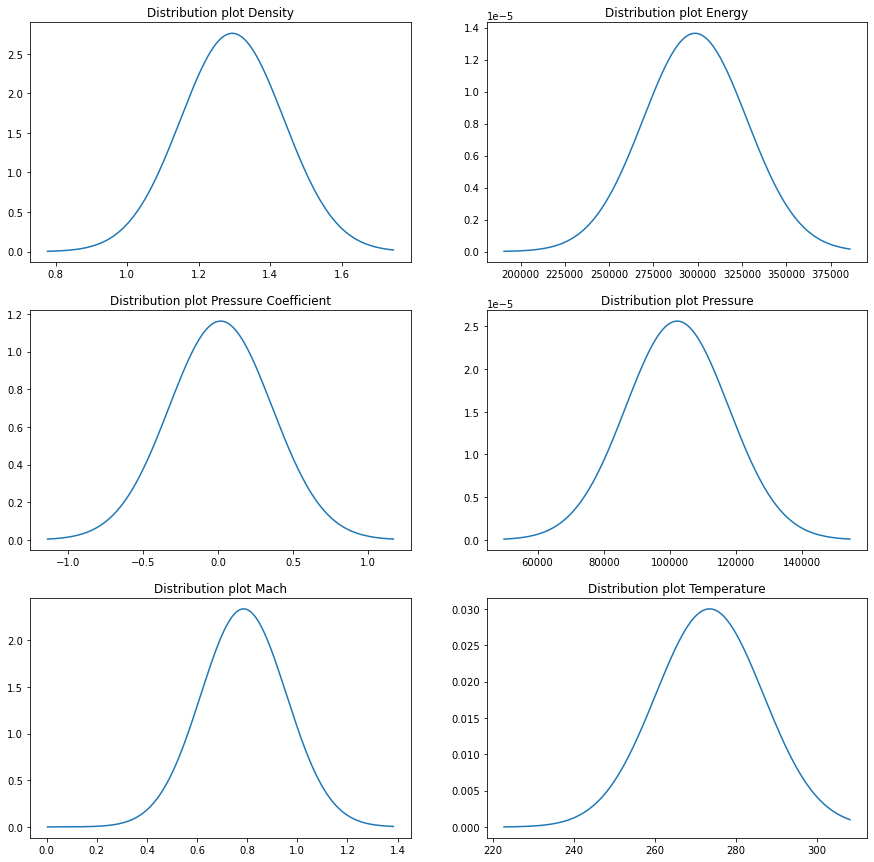

In [7]:
fig, axs = plt.subplots(3, 2, figsize=(15,15))

density.sort()
mean = np.mean(density)
std = np.std(density)
axs[0,0].plot(density, norm.pdf(density, mean, std))
axs[0,0].set_title("Distribution plot Density")


energy.sort()
mean = np.mean(energy)
std = np.std(energy)
axs[0, 1].plot(energy, norm.pdf(energy, mean, std))
axs[0, 1].set_title("Distribution plot Energy")

pressure.sort()
mean = np.mean(pressure)
std = np.std(pressure)
axs[1, 1].plot(pressure, norm.pdf(pressure, mean, std))
axs[1, 1].set_title("Distribution plot Pressure")

temperature.sort()
mean = np.mean(temperature)
std = np.std(temperature)
axs[2, 1].plot(temperature, norm.pdf(temperature, mean, std))
axs[2, 1].set_title("Distribution plot Temperature")

mach.sort()
mean = np.mean(mach)
std = np.std(mach)
axs[2, 0].plot(mach, norm.pdf(mach, mean, std))
axs[2, 0].set_title("Distribution plot Mach")

pressure_coefficient.sort()
mean = np.mean(pressure_coefficient)
std = np.std(pressure_coefficient)
axs[1, 0].set_title("Distribution plot Pressure Coefficient")
axs[1, 0].plot(pressure_coefficient, norm.pdf(pressure_coefficient, mean, std))



**Visualizing the Data in Paraview** (Example Temperature)<br>
The code below can be used to vizualize the SU2 results in Paraview.

In [8]:
# Define the colors we want to use
green = np.array([200/256, 247/256, 0/256, 1])
greenblue = np.array([12/256, 238/256, 200/256, 1])
blue = np.array([12/256, 238/256, 246/256, 1])
darkblue = np.array([12/256, 150/256, 246/256, 1])
purple= np.array([200/256, 50/256, 246/256, 1])
pink= np.array([250/256, 50/256, 246/256, 1])
lightpink = np.array([250/256, 50/256, 246/256, 0.7])
orange = np.array([250/256, 150/256, 0/256, 0.7])
yelloworange = np.array([250/256, 200/256, 0/256, 0.7])
yellow = np.array([255/256, 247/256, 0/256, 1])
grey = np.array([189/256, 189/256, 189/256, 1])

Temperature = np.linspace(pd['Temperature'].min(), pd['Temperature'].max(), 256)

newcolors = np.empty((256, 4))
newcolors[Temperature >= 200] = green
newcolors[Temperature > 210] = greenblue
newcolors[Temperature > 220] = blue
newcolors[Temperature > 230] = darkblue
newcolors[Temperature > 240] = purple
newcolors[Temperature > 250] = pink
newcolors[Temperature > 260] = lightpink
newcolors[Temperature > 270] = orange
newcolors[Temperature > 280] = yelloworange
newcolors[Temperature > 290] = yellow
newcolors[Temperature >= 300] = grey

my_colormap = ListedColormap(newcolors)

pl = pvqt.BackgroundPlotter()
pl.set_background('white')
pv.global_theme.font.color = 'black'
pl.add_mesh(pd, show_edges=True, line_width=0.5,scalars='Temperature',
            cmap=my_colormap,clim=[200, 300])
pl.camera_position = 'xy'
pl.show()

**Sorting the data per cell** (Example Temperature) <br>
To make sure that the correct cells can be indicated an average per cell will be calculated. 'data_variable' indicated the variable you wish to base your local mesh refinement on. 

In [9]:
data_variable = 'Temperature' # 'Density', 'Momentum', 'Energy', 'Pressure', 'Temperature', 'Mach', 'Pressure_Coefficient'
cells=pd.cells
points=pd.points

Centers = []
cellsC = cells

while True:
    if cellsC[0]==3:
        a = cellsC[1]
        b = cellsC[2]
        c = cellsC[3]
        
        C = (pd[data_variable][a]+pd[data_variable][b] +pd[data_variable][c])/3
        Centers.append(C)
        cellsC = cellsC[4:]
        
    elif cellsC[0]==4:
        a = cellsC[1]
        b = cellsC[2]
        c = cellsC[3]
        d = cellsC[4]
        
        C = (pd[data_variable][a]+pd[data_variable][b] +pd[data_variable][c]+pd[data_variable])/4
        Centers.append(C)
        cellsC = cellsC[5:]
    
    if len(cellsC) == 0:
        break

**Determining which cells should be refined** <br>
Based on the visualizations above the user can determine the variable on which the local mesh refinement should be based. Then the code below can be used to for filter the cells based on that data variable. This can be done with a minimum or maximum value filter or with a minimum or maximum percentage filter. 

In [10]:
Index = []
Option= 1 # 1=min or max value, 2 = min or max percentage

if Option == 1:
    for x in range(0, len(Centers)):
        if Centers[x] <= 250:
            Index.append(x)
            
elif Option == 2:
    margin = np.percentile(Centers, 90)

    for x in range(0, len(Centers)):
        if Centers[x] >= margin:
            Index.append(x)

In [11]:
Index

[7,
 10,
 12,
 17,
 22,
 24,
 28,
 56,
 59,
 69,
 97,
 111,
 112,
 113,
 114,
 117,
 124,
 125,
 129,
 134,
 135,
 136,
 140,
 141,
 142,
 144,
 145,
 146,
 147,
 148,
 149,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 177,
 189,
 192,
 193,
 195,
 421,
 427,
 433,
 506,
 509,
 524,
 525,
 530,
 531,
 549,
 552,
 553,
 554,
 610,
 612,
 613,
 618,
 619,
 625,
 657,
 666,
 679,
 688,
 691,
 700,
 701,
 709,
 710,
 712,
 713,
 716,
 717,
 718,
 719,
 726,
 727,
 731,
 736,
 744,
 745,
 748,
 749,
 750,
 752,
 753,
 754,
 755,
 756,
 757,
 758,
 759,
 760,
 761,
 762,
 763,
 764,
 765,
 766,
 767,
 768,
 769,
 772,
 773,
 796,
 808,
 809,
 812,
 813,
 816,
 817,
 818,
 819,
 820,
 821,
 822,
 823,
 824,
 825,
 826,
 827,
 830,
 831,
 834,
 835,
 847,
 850,
 851,
 857,
 858,
 859,
 860,
 861,
 866,
 867,
 872,
 873,
 890,
 891,
 906,
 908,
 916,
 917,
 961,
 964,
 965,
 967,
 968,
 969,
 974,
 975,
 976,
 977,
 988,
 989,
 990,
 991,
 992,
 993,
 994,
 995,
 1002,
 1003,
 1040,
 

**Loading in the SU2 mesh file** <br>
Next the original SU2 mesh file will be loaded into Python. Additionally, the code will be prepared for processing.

In [12]:
f = open(new_name, 'r')


# first get the dimensions
line = f.readline()
columns = line.split()
print(columns)

NDIME = columns[1]
print("dimensions = ",NDIME)

# then, get the nr of elements
line = f.readline()
columns = line.split()

NELEM=columns[1]
print("nr of elements=",NELEM)

# create the 2D triangle array
connectivity = np.arange(4*int(NELEM),dtype=np.int32)
connectivity = connectivity.reshape(int(NELEM),4)
                    
# now, read all the elements into a structure
for i in range(int(NELEM)):
    line=f.readline()
    columns = line.split()
    connectivity[i][:]=[int(3), int(columns[1]), int(columns[2]), int(columns[3])]
    
print("end reading elements")
# then, get the coordinates
line = f.readline()
columns = line.split()

NPOIN=columns[1]
print("nr of points=",NPOIN)

# create the 2D point array
points = np.arange(2*int(NPOIN),dtype=np.float64).reshape(int(NPOIN),2)
# now, read all the points into a structure
for i in range(int(NPOIN)):
    line=f.readline()
    columns = line.split()
    points[i][0]=float(columns[0])
    points[i][1]=float(columns[1])

# now, read the markers
line = f.readline()
columns = line.split()

NMARK=columns[1]
print("nr of markers=",NMARK)

# name of the marker (list of strings)
markername = []
# number of elements in the marker (list of integers)
markerelements = np.arange(int(NMARK),dtype=np.int32)
# this is the list of numpy arrays
markers = []

# list of marker points
markerpointslist = []

for m in range(int(NMARK)):
    line = f.readline()
    columns = line.split()
    markername.append(columns[1])
    print(" ",m,": marker name=",markername[m])
    line = f.readline()
    columns = line.split()
    markerelements[m] = int(columns[1])   
    print(" marker elements=",markerelements[m])
    markerarray = np.arange(2*int(markerelements[m])).reshape(int(markerelements[m]),2)

    for i in range(int(markerelements[m])):
        line=f.readline()
        columns = line.split()
        markerarray[i][0]=columns[1]
        markerarray[i][1]=columns[2]
        
    # now add the array to the list of markers
    markers.append(markerarray)

print("Finished reading su2 file.") 

['NDIME=', '2']
dimensions =  2
nr of elements= 10216
end reading elements
nr of points= 5233
nr of markers= 2
  0 : marker name= airfoil
 marker elements= 200
  1 : marker name= farfield
 marker elements= 50
Finished reading su2 file.


In [13]:
connectivity

array([[   3,  417,   69,  311],
       [   3,  302,   55,   56],
       [   3,  405,  159,  384],
       ...,
       [   3, 5105, 5061, 5029],
       [   3, 5134, 5106, 5097],
       [   3, 5122, 5109, 5075]])

In [14]:
n = int(NPOIN)
z = np.zeros((n, 1))
p = np.append(points, z, axis=1)
points = p
points

array([[ 9.99750018e-01, -3.63289652e-05,  0.00000000e+00],
       [ 9.99000013e-01, -1.45253750e-04,  0.00000000e+00],
       [ 9.97759998e-01, -3.25111163e-04,  0.00000000e+00],
       ...,
       [ 1.75493202e+01,  3.08875299e+00,  0.00000000e+00],
       [ 1.14168196e+01,  1.40551205e+01,  0.00000000e+00],
       [ 1.71931591e+01,  7.91305924e+00,  0.00000000e+00]])

In [15]:
markers0 = markers

**Visualizing the mesh with Paraview** <br>
The original mesh will be visualized with Paraview to later confirm the refinement of the desired cells.

In [16]:
mesh = pv.PolyData(points, connectivity)
pl = pvqt.BackgroundPlotter()
pl.add_mesh(mesh, show_edges=True, line_width=0.05, color='#EEEEEE')
pl.set_background('white')
#pl.add_point_labels(points, [f'Point {i}' for i in range(5)],always_visible=True,
#                    font_size=20,text_color='white', point_size=20,point_color='red',render_points_as_spheres=True)
pl.camera_position = 'xy'
pl.show()

**Mesh Quality of the original mesh** <br>
Before refining the mesh, the mesh quality of the original mesh will be determined.

In [17]:
if connectivity[0][0] == 3: #If the mesh is triangular
    z1 = 3
    z2 = 5
    qe = 60
    
elif connectivity[0][0] == 4: #is the mesh is square
    z1 = 4
    z2 = 6
    qe = 90
    z3 = 2

q = len(connectivity) #Total number of cells
p = [] #A temporary array to store the points of the cell of interest
i = 0

#----------------------------------------------------------------------------#
#-----------------Aspect Ratio-----------------------------------------------#
#----------------------------------------------------------------------------#

aspect_ratio_original = []
distance = [] #A temporary array containing the lenghts of the edges

for y in range(0,q):
    for x in range(1,z2):
        if i < z1:
            a = points[connectivity[y][x]]
            p.append(a)
            i = i+1
        elif i == z1:
            for x in range(0,z1):
                l = abs(p[x%z1]-p[(x+1)%z1]) # calculates the difference in x and y coordinates of the points
                d = math.sqrt(l[0]**2 + l[1]**2) # calculates the length of the edges
                distance.append(d)
            ar = min(distance)/max(distance)
            aspect_ratio_original.append(ar)
            i = 0
            p =[]
            distance = []

i = 0
Skewness_original = []
distance = []

for y in range(0,q):
    for x in range(1,z2):
        if i < z1:
            a = points[connectivity[y][x]]
            p.append(a)
            i = i+1
        elif i == z1:
            
            if z1 ==3:
                for x in range(0,z1):
                    l = abs(p[x%z1]-p[(x+1)%z1]) # calculates the difference in x and y coordinates of the points
                    d = math.sqrt(l[0]**2 + l[1]**2) # calculates the length of the edges
                    distance.append(d)
                a = distance[1]
                b = distance[2]
                c = distance[0]
                alpha = math.degrees(math.acos((a**2-b**2-c**2)/(-2*b*c))) #calculates the angles of the corners
                beta = math.degrees(math.acos((b**2-c**2-a**2)/(-2*c*a)))
                gamma = math.degrees(math.acos((c**2-b**2-a**2)/(-2*b*a)))
                qmin = min(alpha, beta, gamma) #determines the minimal angle
                qmax = max(alpha, beta, gamma) #determines the maximal angle
                
            elif z1 == 4:
                for x in range(0,z1):
                    l = abs(p[x%z1]-p[(x+1)%z1]) # calculates the difference in x and y coordinates of the points
                    d = math.sqrt(l[0]**2 + l[1]**2) # calculates the length of the edges
                    distance.append(d)
                a = distance[0]
                b = distance[1]
                c = distance[2]
                d = distance[3]
                
                for x in range(0,z3):
                    l = abs(p[x%z1]-p[(x+2)%z1]) # calculates the difference in x and y coordinates of the points
                    d2 = math.sqrt(l[0]**2 + l[1]**2) # calculates the length of the edges
                    distance.append(d2)
                    
                e = distance[4]
                f = distance[5]
                alpha1 = math.degrees(math.acos((b**2-e**2-a**2)/(-2*e*a))) #calculates the angles of the corners
                alpha2 = math.degrees(math.acos((d**2-f**2-c**2)/(-2*f*c)))
                beta = math.degrees(math.acos((e**2-a**2-b**2)/(-2*a*b)))
                gamma1 = math.degrees(math.acos((a**2-e**2-b**2)/(-2*e*b)))
                gamma2 = math.degrees(math.acos((c**2-d**2-f**2)/(-2*d*f)))
                gamma = gamma2+alpha2
                alpha = gamma1+alpha1
                delta = math.degrees(math.acos((f**2-d**2-c**2)/(-2*d*c)))
                qmin = min(alpha, beta, gamma, delta) #determines the minimal angle
                qmax = max(alpha, beta, gamma, delta) #determines the maximal angle
            skewness = max((qmax-qe)/(180-qe), (qe-qmin)/qe) 
            Skewness_original.append(skewness)
            i = 0
            p =[]
            distance = []
            

len_cells = len(connectivity) #the total number of cells in the mesh
len_points = len(points)
Orthogonality_original = []

if z1 ==3: #if triangle
    for y in range(0,len_cells):
        p=[]
        i = 0
        
        d = connectivity[y][1]
        e = connectivity[y][2]
        f = connectivity[y][3]
    
        for x in range(1,5):
            if i < z1:
                a = points[connectivity[y][x]]
                p.append(a)
                i = i+1
            elif i == z1:
                center = (p[0]+p[1]+p[2])/3
                point1 = ((points[e]+points[d])/2) #creating a additional point in the middle of the first edge of the side
                point2 = ((points[f]+points[e])/2) #creating a additional point in the middle of the second edge of the side
                point3 = ((points[d]+points[f])/2) #creating a additional point in the middle of the third edge of the side 
                
                e1= point1-center #center to point1
                e2= point2-center #center to point2
                e3= point3-center #center to point3
                vectors_e = [e1[:2],e2[:2],e3[:2]]
                
                v1= points[e]-points[d]
                v2= points[f]-points[e]
                v3= points[d]-points[f]
                
                #v=(a,b) u=(b,-a) #perpendicular
                A1= (v1[1],-v1[0]) #perpendicular to side de
                A2= (v2[1],-v2[0])#perpendicular to side ef
                A3= (v3[1],-v3[0])#perpendicular to side fd
                vectors_A=[A1,A2,A3]
                
                orth = []
                for o in range(0,3):
                    dot_e_A = abs((vectors_A[o][0]*vectors_e[o][0])+(vectors_A[o][1]*vectors_e[o][1]))
                    magnitude_e = math.sqrt((vectors_e[o][0])**2+(vectors_e[o][1])**2)
                    magnitude_A = math.sqrt((vectors_A[o][0])**2+(vectors_A[o][1])**2)
                    ort = (dot_e_A)/(magnitude_e*magnitude_A)
                    orth.append(ort)
                Orthogonality_original.append(min(orth))

                                        
elif z1==4: #if square

    for y in range(0,len_cells):
        p=[]
        i = 0
        
        d = connectivity[y][1]
        e = connectivity[y][2]
        f = connectivity[y][3]
        g = connectivity[y][4]
        
        for x in range(1,6):
            if i < z1:
                a = points[connectivity[y][x]]
                p.append(a)
                i = i+1
            elif i == z1:
                center = (p[0]+p[1]+p[2]+p[3])/4
                point1 = ((points[e]+points[d])/2) #creating a additional point in the middle of the first edge of the side
                point2 = ((points[f]+points[e])/2) #creating a additional point in the middle of the second edge of the side
                point3 = ((points[g]+points[f])/2) #creating a additional point in the middle of the third edge of the side
                point4 = ((points[f]+points[d])/2) #creating a additional point in the middle of the third edge of the side
                
                e1= point1-center #center to point1
                e2= point2-center #center to point2
                e3= point3-center #center to point3
                e4= point4-center #center to point4
                vectors_e = [e1[:2],e2[:2],e3[:2], e4[:2]]
                
                v1= points[e]-points[d]
                v2= points[f]-points[e]
                v3= points[g]-points[f]
                v4= points[d]-points[g]
                
                #v=(a,b) u=(b,-a) #perpendicular
                A1= (v1[1],-v1[0]) #perpendicular to side de
                A2= (v2[1],-v2[0])#perpendicular to side ef
                A3= (v3[1],-v3[0])#perpendicular to side fg
                A4= (v4[1],-v4[0])#perpendicular to side gd
                vectors_A=[A1,A2,A3,A4]
                
                orth = []
                for o in range(0,4):
                    dot_e_A = abs((vectors_A[o][0]*vectors_e[o][0])+(vectors_A[o][1]*vectors_e[o][1]))
                    magnitude_e = math.sqrt((vectors_e[o][0])**2+(vectors_e[o][1])**2)
                    magnitude_A = math.sqrt((vectors_A[o][0])**2+(vectors_A[o][1])**2)
                    ort = (dot_e_A)/(magnitude_e*magnitude_A)
                    orth.append(ort)
                Orthogonality_original.append(min(orth))

      
        
print('The average Aspect Ratio of the original mesh is', round(sum(aspect_ratio_original)/len(aspect_ratio_original),3))
print('The minimum Aspect Ratio of the original mesh is', round(min(aspect_ratio_original),3))
print('the maximum Aspect Ratio of the original mesh is', round(max(aspect_ratio_original),3))

print('The average Skewness of the original mesh is', round(sum(Skewness_original)/len(Skewness_original),3))
print('The minimum Skewness of the original mesh is', round(min(Skewness_original),3))
print('the maximum Skewness of the original mesh is', round(max(Skewness_original),3))

print('The average Face Orthogonality of the mesh is', round(sum(Orthogonality_original)/len(Orthogonality_original),3))
print('The minimum Face Orthogonality of the mesh is', round(min(Orthogonality_original),3))
print('The maximum Face Orthogonality of the mesh is', round(max(Orthogonality_original),3))      

The average Aspect Ratio of the original mesh is 0.833
The minimum Aspect Ratio of the original mesh is 0.343
the maximum Aspect Ratio of the original mesh is 1.0
The average Skewness of the original mesh is 0.159
The minimum Skewness of the original mesh is 0.0
the maximum Skewness of the original mesh is 0.666
The average Face Orthogonality of the mesh is 0.967
The minimum Face Orthogonality of the mesh is 0.571
The maximum Face Orthogonality of the mesh is 1.0


C:\Users\20192167\Anaconda3\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(f'Failed to use notebook backend: \n\n{e}\n\n'


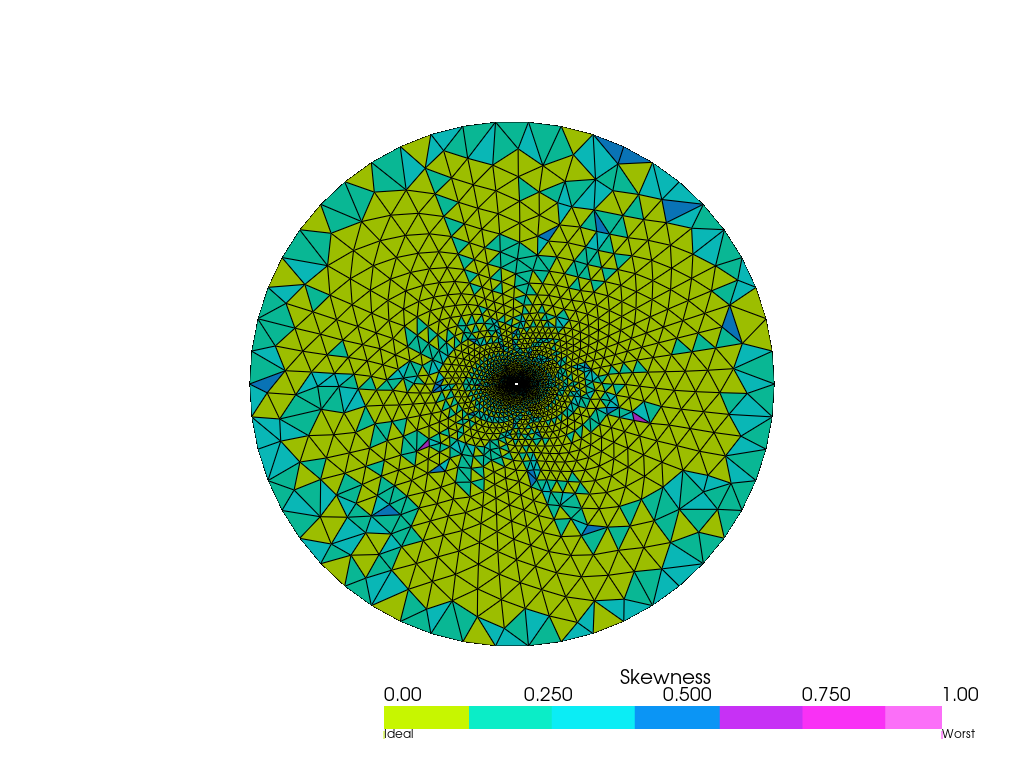

In [18]:
mesh.cell_data['Skewness']= Skewness_original

# Define the colors we want to use
green = np.array([200/256, 247/256, 0/256, 1])
greenblue = np.array([12/256, 238/256, 200/256, 1])
blue = np.array([12/256, 238/256, 246/256, 1])
darkblue = np.array([12/256, 150/256, 246/256, 1])
purple= np.array([200/256, 50/256, 246/256, 1])
pink= np.array([250/256, 50/256, 246/256, 1])
lightpink = np.array([250/256, 50/256, 246/256, 0.7])
orange = np.array([250/256, 150/256, 0/256, 0.7])
yelloworange = np.array([250/256, 200/256, 0/256, 0.7])
yellow = np.array([255/256, 247/256, 0/256, 1])
grey = np.array([189/256, 189/256, 189/256, 1])

skewness = np.linspace(mesh['Skewness'].min(), mesh['Skewness'].max(), 256)
newcolors = np.empty((256, 4))
newcolors[skewness >= 0] = green
#newcolors[skewness > 0.1] = lightgreen
newcolors[skewness > 0.1] = greenblue
newcolors[skewness > 0.2] = blue
newcolors[skewness > 0.3] = darkblue
newcolors[skewness > 0.4] = purple
newcolors[skewness > 0.5] = pink
newcolors[skewness > 0.6] = lightpink
newcolors[skewness > 0.7] = orange
newcolors[skewness > 0.8] = yelloworange
newcolors[skewness > 0.9] = yellow
newcolors[skewness >= 1] = grey

my_colormap = ListedColormap(newcolors)
annotations = {
    1: "Worst",
    0: "Ideal",
}

pl = pv.Plotter()
pl.set_background('white')
pv.global_theme.font.color = 'black'
pl.add_mesh(mesh, show_edges=True, line_width=0.5,scalars='Skewness',
            cmap=my_colormap, annotations=annotations,clim=[0, 1])
pl.camera_position = 'xy'
pl.show()

**Refining the mesh** <br>


In [22]:
c = Index.copy()

In [23]:
#----------------------------------------------#
#---------Rewritting the cells array-----------#
#----------------------------------------------#
cells=[]
for x in range(0,len(connectivity)):
    for y in range(0, len(connectivity[x])):
        cells.append(connectivity[x][y])

In [ ]:
print('Saving the cell types')
#----------------------------------------------#
#-----------Saving the cell types--------------#
#----------------------------------------------#
cells_type = cells.copy()
Type = []
ytotal = []
ytotaly = []

while True:
    if cells_type[0]==3:
        Type.append(3)
        cells_type= cells_type[4:]
        
    elif cells_type[0]==4:
        Type.append(4)
        cells_type= cells_type[5:]

    if len(cells_type) == 0:
        break

clen = len(c)
c_filtered=c.copy()

print('Refining the square cells')
#-----------------------------------------------------#
#------------Refining the square cells----------------#
#-----------------------------------------------------#
for cx in range(0,clen):

    cells_refinement=cells.copy()
    i=0
    
    if Type[c[cx]]==4:
        
        for x in range(0,c[cx]):
            cells_refinement= cells_refinement[(Type[x]+1):]
            i = i + (Type[x]+1)  
        
        cell_c= cells_refinement[:5]

        d1 = cell_c[1]
        d2 = cell_c[2]
        d3 = cell_c[3]
        d4 = cell_c[4]

        point1 = ((points[d3]+points[d1])/2) 
        points = np.vstack([points,point1]) #adding the points to the points array

        g = len(points) #the new total number of points

        cells[i] = 3
        cells[i+1]= d1
        cells[i+2]= d2
        cells[i+3]= (g-1)
        cells= np.delete(cells, [(i+4)],None)

        cells = np.append(cells,3)
        cells = np.append(cells,d2)
        cells = np.append(cells,d3)
        cells = np.append(cells,(g-1))

        cells = np.append(cells,3)
        cells = np.append(cells,d3)
        cells = np.append(cells,d4)
        cells = np.append(cells,(g-1))

        cells = np.append(cells,3)
        cells = np.append(cells,d4)
        cells = np.append(cells,d1)
        cells = np.append(cells,(g-1))

        Type[c[cx]]=3
        Type.append(3)
        Type.append(3)
        Type.append(3)

        c_filtered[cx] = 'x'

#------------------------------------------------------------------------------#
#----------Creating a new list c with just triangular cells--------------------#
#------------------------------------------------------------------------------#
c_new = [] #a new list with all the triangular cells that should still be refined

for x in range(0, len(c_filtered)):      
    if c_filtered[x] !='x':
        c_new.append(c_filtered[x])

print('Finding the neighbouring cells of the cells you wish to refine')
#-------------------------------------------------------------------------------#    
#--------Finding the neighbouring cells of the cells you wish to refine---------#
#-------------------------------------------------------------------------------#
for cx in range(0,len(c_new)):
    print('cx =', cx)
    cells_refinement=cells.copy()
    i=0
    
    for x in range(0,c_new[cx]): 
        cells_refinement= cells_refinement[(Type[x]+1):]
        i = i + (Type[x]+1)  
        
    if Type[c_new[cx]]==3:
        cell_c= cells_refinement[:4]
        d1 = cell_c[1]
        d2 = cell_c[2]
        d3 = cell_c[3]
        print(c_new[cx])
        print('d1,d2,d3 =',d1,d2,d3)
        #--------------------------------------------#
        #------Finding neigbouring cells-------------#
        #--------------------------------------------#
        
        cells_neighbour = cells.copy()
        w = 0
        y=[]
        while True:
            
            if cells_neighbour[0]==3:
                cell = cells_neighbour[:4]
                cells_neighbour=cells_neighbour[4:]  

            elif cells_neighbour[0]==4:
                cell = cells_neighbour[:5]
                cells_neighbour=cells_neighbour[5:] 

            if d1 in cell[1:] and d2 in cell[1:]:
                if w not in c_new:
                    y.append(w)
                    ytotaly.append(w)
                    break
                        
            if len(cells_neighbour) == 0:
                y.append(len(Type)+1)
                ytotaly.append(len(Type)+1)
                break
            w=w+1    

            
        cells_neighbour = cells.copy()
        w = 0
        print('d2, d3 =', d2,d3)        
        while True:
            
            if cells_neighbour[0]==3:
                cell = cells_neighbour[:4]
                cells_neighbour=cells_neighbour[4:]  

            elif cells_neighbour[0]==4:
                cell = cells_neighbour[:5]
                cells_neighbour=cells_neighbour[5:]
            
            print('cell =', cell)

            
            if d2 in cell[1:] and d3 in cell[1:]:
                if w not in c_new:
                    y.append(w)
                    ytotaly.append(w)
                    break    
                
            if len(cells_neighbour) == 0:
                y.append(len(Type)+1)
                ytotaly.append(len(Type)+1)
                break
            w = w+1
                
        cells_neighbour = cells.copy()
        w = 0   
        
        print('d3, d1 =', d3,d1)
        while True:
            
            if cells_neighbour[0]==3:
                cell = cells_neighbour[:4]
                cells_neighbour=cells_neighbour[4:]  

            elif cells_neighbour[0]==4:
                cell = cells_neighbour[:5]
                cells_neighbour=cells_neighbour[5:]  
            
            print('cell =', cell)
            
            if d3 in cell[1:] and d1 in cell[1:]:
                if w not in c_new:
                    y.append(w)
                    ytotaly.append(w)
                    break
                        
            if len(cells_neighbour) == 0:
                y.append(len(Type)+1)
                ytotaly.append(len(Type)+1)
                break
            w=w+1  
            
        print('y = ', y)
    ytotal.append(y)       

print('Find neighbouring cells that are called for twice')    
#-------------------------------------------------------------------------#
#---------Finding neighbouring cells that are called for twice------------#
#-------------------------------------------------------------------------#
i=0
c_new_len= len(c_new)
for x in range (0,len(ytotal)): #for every cell listed in {ytotal}
    for z in range(0,3): 
        if ytotal[x][z] in ytotaly[3+i:]: #if the cell is listed again in {ytotal}
            if ytotal[x][z] != len(Type)+1: #if it is not the additional cell added for no connection
                if ytotal[x] not in c_new: #if the cell is not listed in {c}
                    c_new.append(ytotal[x][z]) #add the cell to {c}
                    v =1
            else:
                v=0
        else:
            v =0

    i = i+3    

if c_new_len == len(c_new): #if at least two cells share the same neighbouring cell. The code will be ran again.
    a=1
else:
    a=0

    
while True:
    c_new_len = len(c_new)
    
    if a == 1:
        break
    
    ytotaly=[]
    ytotal = []
    c_filtered=c_new.copy()
    
    for cx in range(0,len(c_new)):
        cells_refinement=cells.copy()
        i=0

        for x in range(0,c_new[cx]):
            cells_refinement= cells_refinement[(Type[x]+1):]
            i = i + (Type[x]+1)  

        if Type[c_new[cx]]==4:
            cell_c= cells_refinement[:5]

            d1 = cell_c[1]
            d2 = cell_c[2]
            d3 = cell_c[3]
            d4 = cell_c[4]

            point1 = ((points[d3]+points[d1])/2) 
            points = np.vstack([points,point1]) #adding the points to the points array

            g = len(points) #the new total number of points

            cells[i] = 3
            cells[i+1]= d1
            cells[i+2]= d2
            cells[i+3]= (g-1)
            cells= np.delete(cells, [(i+4)],None)

            cells = np.append(cells,3)
            cells = np.append(cells,d2)
            cells = np.append(cells,d3)
            cells = np.append(cells,(g-1))

            cells = np.append(cells,3)
            cells = np.append(cells,d3)
            cells = np.append(cells,d4)
            cells = np.append(cells,(g-1))

            cells = np.append(cells,3)
            cells = np.append(cells,d4)
            cells = np.append(cells,d1)
            cells = np.append(cells,(g-1))

            Type[c_new[cx]]=3
            Type.append(3)
            Type.append(3)
            Type.append(3)

            c_filtered[cx] = 'x'

    c_new = []
    for x in range(0, len(c_filtered)):      
        if c_filtered[x] !='x':
            c_new.append(c_filtered[x])
    
    for cx in range(0,len(c_new)):
        cells_refinement=cells.copy()
        i=0

        for x in range(0,c_new[cx]):
            cells_refinement= cells_refinement[(Type[x]+1):]
            i = i + (Type[x]+1)  

        if Type[c_new[cx]]==3:
            cell_c= cells_refinement[:4]
            d1 = cell_c[1]
            d2 = cell_c[2]
            d3 = cell_c[3]
            #--------------------------------------------#
            #------Finding neigbouring cells-------------#
            #--------------------------------------------#

            cells_neighbour = cells.copy()
            w = 0
            y=[]
            while True:

                if cells_neighbour[0]==3:
                    cell = cells_neighbour[:4]
                    cells_neighbour=cells_neighbour[4:]  

                elif cells_neighbour[0]==4:
                    cell = cells_neighbour[:5]
                    cells_neighbour=cells_neighbour[5:] 

                if d1 in cell[1:] and d2 in cell[1:]:
                    if w not in c_new:
                        y.append(w)
                        ytotaly.append(w)
                        break
                        
                if len(cells_neighbour) == 0:
                    y.append(len(Type)+1)
                    ytotaly.append(len(Type)+1)
                    break
                w=w+1    
                
            cells_neighbour = cells.copy()
            w = 0
            while True:
                
                if cells_neighbour[0]==3:
                    cell = cells_neighbour[:4]
                    cells_neighbour=cells_neighbour[4:]  

                elif cells_neighbour[0]==4:
                    cell = cells_neighbour[:5]
                    cells_neighbour=cells_neighbour[5:]
                    
                if d2 in cell[1:] and d3 in cell[1:]:
                    if w not in c_new:
                        y.append(w)
                        ytotaly.append(w)
                        break    
                
                if len(cells_neighbour) == 0:
                    y.append(len(Type)+1)
                    ytotaly.append(len(Type)+1)
                    break
                w = w+1
                
            cells_neighbour = cells.copy()
            w = 0   
            while True:
                
                if cells_neighbour[0]==3:
                    cell = cells_neighbour[:4]
                    cells_neighbour=cells_neighbour[4:]  

                elif cells_neighbour[0]==4:
                    cell = cells_neighbour[:5]
                    cells_neighbour=cells_neighbour[5:]  
                    
                if d3 in cell[1:] and d1 in cell[1:]:
                    if w not in c_new:
                        y.append(w)
                        ytotaly.append(w)
                        break
                        
                if len(cells_neighbour) == 0:
                    y.append(len(Type)+1)
                    ytotaly.append(len(Type)+1)
                    break
                w=w+1    

        ytotal.append(y)        

    #-------------------------------------------------------------------------#
    #---------Finding neighbouring cells that are called for twice------------#
    #-------------------------------------------------------------------------#
    i=0
    
    for x in range (0,len(ytotal)): #for every cell listed in {ytotal}
        for z in range(0,3): 
            if ytotal[x][z] in ytotaly[3+i:]: #if the cell is listed again in {ytotal}
                if ytotal[x][z] != len(Type)+1: #if it is not the additional cell added for no connection
                    if ytotal[x] not in c_new: #if the cell is not listed in {c}
                        c_new.append(ytotal[x][z]) #add the cell to {c}
                        v =1
                else:
                    v=0
            else:
                v =0

        i = i+3    
        
    if c_new_len == len(c_new): #if at least two cells share the same neighbouring cell. The code will be ran again.
        break

print('Determining which point the cells do not share')
#---------------------------------------------------------------#
#--------Determining which point the cells do not share---------#
#---------------------------------------------------------------#

r=[] #an array containing a 1 for sharing and a 0 for not sharing

for cx in range(0,len(c_new)):
    cells_refinement=cells.copy()
    i=0

    for x in range(0,c_new[cx]):
        cells_refinement= cells_refinement[(Type[x]+1):]
        i = i + (Type[x]+1)  
        
    y = ytotal[cx] #the numbers of the neigbouring cells 
    
    cell_c= cells_refinement[:4]
    d1 = cell_c[1]
    d2 = cell_c[2]
    d3 = cell_c[3]
    cy = [d1,d2,d3]   #an array containing the points from the refined cell
        
    rx = [] #temporary storange array
    for x in range(0,3):
   
        if y[x]==len(Type)+1:
            rx.append(0)
            rx.append(0)
            rx.append(0)
            
        elif Type[y[x]]==3:

            if y[x] <= len(Type):
                cells_refinement=cells.copy()
                i=0

                for w in range(0,y[x]):
                    cells_refinement= cells_refinement[(Type[w]+1):]
                    i = i + (Type[w]+1) 

                q = [cells[i+1], cells[i+2], cells[i+3]] #points in the neighbouring cell

                for w in range (0,3):
                    q1 = q[w]
                    if q1 in cy: #if two cells share a point
                        t = 1
                        rx.append(t)
                    else: # if two cells do not share a point
                        t = 0                            
                        rx.append(t)
            else:
                rx.append(0)
                rx.append(0)
                rx.append(0)
        
        elif Type[y[x]]==4:
            if y[x] <= len(Type):
                cells_refinement=cells.copy()
                i=0
                for w in range(0,y[x]):
                    cells_refinement= cells_refinement[(Type[w]+1):]
                    i = i + (Type[w]+1) 
                    
                q = [cells[i+1], cells[i+2], cells[i+3], cells[i+4]] #points in the neighbouring cell

                for w in range (0,4):
                    q1 = q[w]
                    if q1 in cy: #if two cells share a point
                        t = 1
                        rx.append(t)
                    else: # if two cells do not share a point
                        t = 0
                        rx.append(t)
            else:
                rx.append(0)
                rx.append(0)
                rx.append(0)
                rx.append(0)
                
    r.append(rx)       


print('Splitting the cell in four')
#---------------------------------------#
#-----Splitting the cell in four--------# 
#---------------------------------------#
for cx in range(0,len(c_new)):
    cells_refinement=cells.copy()
    i=0
    for x in range(0,c_new[cx]):
        cells_refinement= cells_refinement[(Type[x]+1):]
        i = i + (Type[x]+1)  
    
    if Type[c_new[cx]]==3:
        cell_c= cells_refinement[:4]
        
        d1 = cell_c[1]
        d2 = cell_c[2]
        d3 = cell_c[3]
    
        point1 = ((points[d2]+points[d1])/2) #creating a additional point in the middle of the first edge of the side
        point2 = ((points[d3]+points[d2])/2) #creating a additional point in the middle of the second edge of the side
        point3 = ((points[d1]+points[d3])/2) #creating a additional point in the middle of the third edge of the side
        points = np.vstack([points,point1,point2,point3]) #adding the points to the points array
    
        g = len(points) #the new total number of points
        #changing the original cell to to the refined cell
        cells[i]= 3
        cells[i+1]= (g-1)
        cells[i+2]= (g-2)
        cells[i+3]= d3
        
        cells = np.append(cells,3)
        cells = np.append(cells,(g-2))
        cells = np.append(cells,d2)
        cells = np.append(cells,(g-3))
        
        cells = np.append(cells,3)
        cells = np.append(cells,d1)
        cells = np.append(cells,(g-1))
        cells = np.append(cells,(g-3))
        
        cells = np.append(cells,3)
        cells = np.append(cells,(g-1))
        cells = np.append(cells,(g-2))
        cells = np.append(cells,(g-3))
        
        Type[c_new[cx]]=3
        Type.append(3)
        Type.append(3)
        Type.append(3)
        
        #------------------------------------#
        #------Adjusting marker lines--------#
        #------------------------------------#

        for x in range(0,len(markers0)): #for all cells in the mesh

            if d in markers0[x] and e in markers0[x]: #looks for the side DE in the other cells
                mmarker = []
                mcell = []
                mmarker.append(x) #if a second listing of DF is present the number of that cell is added to the list
                mcell.append(c_new[cx])

                u = 0
                while True:
                    print(d,e, markers0[x][u])
                    if d in markers0[x][u] and e in markers0[x][u]:
                        break 
                    u=u+1

                if c_new[cx] in mcell:
                    v = markers0[mmarker[0]][u]
                    markerx = [markers0[mmarker[x]][u][0], (g-3)]
                    markers0[mmarker[0]][u] = [(g-3) ,markers0[mmarker[x]][u][1]]
                    markers0[x] = np.vstack([markers0[x][:u], markerx, markers0[x][u:]])

                markerelements[x]=len(markers0[x])

        for x in range(0,len(markers0)): #for all cells in the mesh
            if e in markers0[x] and f in markers[x]: #looks for the side DE in the other cells
                mmarker = []
                mcell = []
                mmarker.append(x) #if a second listing of DF is present the number of that cell is added to the list
                mcell.append(c_new[cx])

                u = 0
                while True:
                    if e in markers0[x][u] and f in markers0[x][u]:
                        break 
                    u=u+1

                if c_new[cx] in mcell:
                    markerx = [markers0[mmarker[x]][u][0], (g-2)]
                    markers0[mmarker[0]][u] = [(g-2), markers0[mmarker[x]][u][1]]
                    markers0[x] = np.vstack([markers0[x][:u], markerx, markers0[x][u:]])

                markerelements[x]=len(markers0[x])

        for x in range(0,len(markers0)): #for all cells in the mesh
            if f in markers0[x] and d in markers0[x]: #looks for the side DE in the other cells
                mmarker = []
                mcell = []
                mmarker.append(x) #if a second listing of DF is present the number of that cell is added to the list
                mcell.append(c_new[cx])

                u = 0
                while True:
                    if f in markers0[x][u] and d in markers0[x][u]:
                        break 
                    u=u+1

                if c_new[cx] in mcell:
                    markerx = [markers0[mmarker[x]][u][0], (g-1)]
                    markers0[mmarker[0]][u] = [(g-1), markers0[mmarker[x]][u][1]]
                    markers0[x] = np.vstack([markers0[x][:u], markerx, markers0[x][u:]])

                markerelements[x]=len(markers0[x]) 
                
print('Splitting the neighbouring cells')            
#-------------------------------------------------#   
#---------Splitting the neighbouring cells--------#
#-------------------------------------------------#
for cx in range(0, len(c_new)):
    y = ytotal[cx]
    rcx = r[cx]
    m = []

    for x in range(0,3):
        if Type[y[x]]==3: #if the neighbouring cell is a triangle
            rx = rcx[:3]
            rcx = rcx[3:]
            h=0
            n = []                     
            for z in range(0,3):
                z1=rx[z]
                if z1==1:
                    n.append(z)
                    h=h+1
                    if h == 2:
                        if n[0]==0 and n[1]==2:
                            m.append(n[1])
                            m.append(n[0])
                        else:
                            m.append(n[0])
                            m.append(n[1])
            if n==[]:
                m.append(4)
                m.append(4)
                
        elif Type[y[x]]==4: #if the neighbouring cell is a square
            rx = rcx[:4]
            rcx = rcx[4:]
            h=0
            n = []
            for z in range(0,4):
                z1=rx[z]
                if z1==1:
                    n.append(z)
                    h=h+1
                    if h == 2:
                        if n[0]==0 and n[1]==3:
                            m.append(n[1])
                            m.append(n[0])
                        else:
                            m.append(n[0])
                            m.append(n[1])
            if n==[]:
                m.append(4)
                m.append(4)
    
    for x in range(0,3):

        if m[2*x]==4:
            a=1
            
        elif Type[y[x]]==3:
            n=3-x
            g=len(points)-3*(len(c_new)-cx-1)
            j=2*x
            #Splitting the neigbouring cells in two
            u = y[x]

            if u <= len(Type):
                cells_refinement=cells.copy()
                i=0
                
                for w in range(0,u):
                    cells_refinement= cells_refinement[(Type[w]+1):]
                    i = i + (Type[w]+1) 

                cell_c= cells_refinement[:4]

                d1 = cell_c[1]
                d2 = cell_c[2]
                d3 = cell_c[3]
                cell = [3, d1, d2, d3]
                cell[m[j]+1] = g-n  
                cells[i]= cell[0]
                cells[i+1]= cell[1]
                cells[i+2]= cell[2]
                cells[i+3]= cell[3]

                j=j+1
                cell = [3, d1, d2, d3]
                cell[m[j]+1] = g-n

                cells = np.append(cells,cell[0])
                cells = np.append(cells,cell[1])
                cells = np.append(cells,cell[2])
                cells = np.append(cells,cell[3])
                
                Type.append(3)    
                
        elif Type[y[x]]==4:
            n=3-x
            g=len(points)-3*(len(c_new)-cx-1)
            m_square = m.copy()
            m_square = m_square[x*2:]
            
        #Splitting the neigbouring cells in three
            u = y[x]
            if u <= len(Type):
                cells_neighbour=cells.copy()
                i=0
                for w in range(0,u):
                    cells_neighbour= cells_neighbour[(Type[w]+1):]
                    i = i + (Type[w]+1) 

                cell_c= cells_neighbour[:5]
                
                d1 = cell_c[1]
                d2 = cell_c[2]
                d3 = cell_c[3]
                d4 = cell_c[4]
                cy=[d1,d2,d3,d4] #the numbers of the points creating the cell
                
                #changing the original cell to to the refined cell
                cells[i]=3
                cells[i+1]=cy[m_square[0]]
                cells[i+2]=(g-n)
                cells[i+3]=cy[m_square[0]-1]
                cells= np.delete(cells, [(i+4)],None)
                
                cell = [3, (g-n), cy[m_square[0]-2], cy[m_square[0]-1]]
                cells = np.append(cells,cell[0])
                cells = np.append(cells,cell[1])
                cells = np.append(cells,cell[2])
                cells = np.append(cells,cell[3])
                
                cell = [3, (g-n), cy[m_square[0]-3], cy[m_square[0]-2]]
                cells = np.append(cells,cell[0])
                cells = np.append(cells,cell[1])
                cells = np.append(cells,cell[2])
                cells = np.append(cells,cell[3])
                
                Type[y[x]]=3
                Type.append(3)
                Type.append(3)

Saving the cell types
Refining the square cells
Finding the neighbouring cells of the cells you wish to refine
cx = 0
7
d1,d2,d3 = 327 65 66
d2, d3 = 65 66
cell = [3, 417, 69, 311]
cell = [3, 302, 55, 56]
cell = [3, 405, 159, 384]
cell = [3, 594, 427, 450]
cell = [3, 315, 71, 72]
cell = [3, 319, 4, 262]
cell = [3, 270, 39, 40]
cell = [3, 327, 65, 66]
cell = [3, 451, 259, 325]
cell = [3, 441, 40, 41]
cell = [3, 358, 147, 148]
cell = [3, 287, 12, 13]
cell = [3, 252, 144, 145]
cell = [3, 254, 56, 57]
cell = [3, 348, 96, 269]
cell = [3, 262, 4, 5]
cell = [3, 647, 465, 525]
cell = [3, 453, 308, 449]
cell = [3, 309, 282, 15]
cell = [3, 560, 265, 470]
cell = [3, 369, 185, 186]
cell = [3, 420, 271, 27]
cell = [3, 432, 137, 376]
cell = [3, 643, 471, 270]
cell = [3, 429, 121, 354]
cell = [3, 282, 14, 15]
cell = [3, 568, 446, 456]
cell = [3, 292, 257, 31]
cell = [3, 617, 385, 457]
cell = [3, 831, 694, 478]
cell = [3, 274, 24, 25]
cell = [3, 470, 346, 454]
cell = [3, 311, 69, 70]
cell = [3, 291, 2

cell = [3, 340, 199, 0]
cell = [3, 5110, 5079, 5048]
cell = [3, 1218, 517, 853]
cell = [3, 5109, 5049, 5038]
cell = [3, 729, 460, 521]
cell = [3, 5109, 5097, 5049]
cell = [3, 746, 543, 518]
cell = [3, 5149, 5099, 5112]
cell = [3, 5209, 5195, 5169]
cell = [3, 5107, 5020, 5063]
cell = [3, 5107, 5068, 5020]
cell = [3, 312, 80, 279]
cell = [3, 762, 562, 555]
cell = [3, 460, 263, 267]
cell = [3, 670, 470, 454]
cell = [3, 273, 139, 140]
cell = [3, 641, 588, 365]
cell = [3, 384, 159, 160]
cell = [3, 261, 154, 155]
cell = [3, 304, 55, 302]
cell = [3, 573, 332, 466]
cell = [3, 742, 537, 741]
cell = [3, 1505, 888, 1371]
cell = [3, 256, 255, 1]
cell = [3, 256, 1, 2]
cell = [3, 330, 30, 257]
cell = [3, 472, 345, 295]
cell = [3, 346, 36, 258]
cell = [3, 260, 32, 33]
cell = [3, 511, 456, 320]
cell = [3, 452, 259, 451]
cell = [3, 329, 34, 265]
cell = [3, 292, 32, 260]
cell = [3, 813, 617, 667]
cell = [3, 349, 151, 152]
cell = [3, 521, 460, 267]
cell = [3, 726, 515, 340]
cell = [3, 263, 262, 5]
cell =

cell = [3, 698, 512, 513]
cell = [3, 754, 554, 540]
cell = [3, 737, 532, 516]
cell = [3, 567, 250, 335]
cell = [3, 532, 279, 447]
cell = [3, 539, 268, 288]
cell = [3, 538, 419, 468]
cell = [3, 572, 498, 311]
cell = [3, 505, 290, 469]
cell = [3, 561, 541, 260]
cell = [3, 542, 257, 292]
cell = [3, 843, 643, 642]
cell = [3, 631, 520, 296]
cell = [3, 544, 297, 345]
cell = [3, 520, 328, 296]
cell = [3, 701, 536, 547]
cell = [3, 536, 307, 301]
cell = [3, 548, 304, 302]
cell = [3, 526, 472, 295]
cell = [3, 531, 317, 522]
cell = [3, 533, 291, 475]
cell = [3, 628, 420, 272]
cell = [3, 629, 271, 420]
cell = [3, 477, 425, 277]
cell = [3, 499, 477, 277]
cell = [3, 499, 277, 415]
cell = [3, 698, 513, 578]
cell = [3, 615, 405, 384]
cell = [3, 523, 261, 264]
cell = [3, 610, 601, 388]
cell = [3, 862, 707, 655]
cell = [3, 635, 426, 634]
cell = [3, 634, 371, 496]
cell = [3, 705, 479, 482]
cell = [3, 792, 597, 687]
cell = [3, 598, 411, 483]
cell = [3, 600, 354, 380]
cell = [3, 607, 397, 393]
cell = [3, 6

cell = [3, 631, 422, 630]
cell = [3, 715, 497, 714]
cell = [3, 740, 455, 533]
cell = [3, 632, 510, 423]
cell = [3, 632, 423, 418]
cell = [3, 791, 595, 790]
cell = [3, 831, 478, 633]
cell = [3, 718, 500, 598]
cell = [3, 796, 713, 481]
cell = [3, 831, 633, 830]
cell = [3, 1007, 819, 818]
cell = [3, 637, 529, 373]
cell = [3, 636, 432, 376]
cell = [3, 813, 618, 617]
cell = [3, 836, 638, 591]
cell = [3, 797, 603, 602]
cell = [3, 639, 436, 638]
cell = [3, 811, 705, 482]
cell = [3, 705, 684, 479]
cell = [3, 903, 684, 705]
cell = [3, 641, 437, 640]
cell = [3, 654, 581, 485]
cell = [3, 817, 730, 523]
cell = [3, 649, 575, 453]
cell = [3, 643, 441, 642]
cell = [3, 778, 575, 649]
cell = [3, 770, 550, 676]
cell = [3, 644, 551, 442]
cell = [3, 644, 442, 307]
cell = [3, 645, 579, 445]
cell = [3, 645, 445, 348]
cell = [3, 950, 766, 765]
cell = [3, 937, 752, 855]
cell = [3, 695, 452, 451]
cell = [3, 1220, 1045, 1048]
cell = [3, 648, 548, 474]
cell = [3, 772, 648, 474]
cell = [3, 778, 576, 575]
cell = [

cell = [3, 887, 876, 654]
cell = [3, 887, 654, 653]
cell = [3, 932, 679, 896]
cell = [3, 932, 746, 679]
cell = [3, 917, 729, 743]
cell = [3, 942, 758, 889]
cell = [3, 890, 871, 662]
cell = [3, 890, 662, 673]
cell = [3, 893, 672, 670]
cell = [3, 945, 930, 744]
cell = [3, 892, 861, 669]
cell = [3, 892, 669, 723]
cell = [3, 1113, 921, 885]
cell = [3, 944, 760, 894]
cell = [3, 1046, 944, 894]
cell = [3, 1195, 1111, 919]
cell = [3, 895, 890, 673]
cell = [3, 895, 673, 680]
cell = [3, 932, 888, 746]
cell = [3, 896, 679, 666]
cell = [3, 897, 895, 680]
cell = [3, 897, 680, 675]
cell = [3, 990, 804, 803]
cell = [3, 992, 704, 805]
cell = [3, 1071, 1000, 1001]
cell = [3, 1206, 1027, 974]
cell = [3, 906, 711, 835]
cell = [3, 907, 687, 711]
cell = [3, 1108, 1055, 912]
cell = [3, 1221, 852, 1056]
cell = [3, 912, 656, 721]
cell = [3, 912, 721, 911]
cell = [3, 994, 807, 993]
cell = [3, 1180, 996, 1179]
cell = [3, 986, 800, 709]
cell = [3, 989, 703, 802]
cell = [3, 905, 900, 710]
cell = [3, 905, 710, 68

cell = [3, 1097, 887, 1078]
cell = [3, 1081, 1049, 850]
cell = [3, 1210, 1032, 1070]
cell = [3, 1211, 1031, 1033]
cell = [3, 1210, 1033, 1032]
cell = [3, 1211, 1069, 1031]
cell = [3, 1249, 1079, 1248]
cell = [3, 1157, 967, 1075]
cell = [3, 1312, 1160, 1311]
cell = [3, 1072, 1000, 1071]
cell = [3, 1071, 1001, 877]
cell = [3, 1182, 1004, 1003]
cell = [3, 1181, 998, 1180]
cell = [3, 1074, 994, 993]
cell = [3, 1072, 1075, 858]
cell = [3, 1378, 1232, 1353]
cell = [3, 1139, 950, 949]
cell = [3, 1127, 936, 935]
cell = [3, 1158, 970, 1157]
cell = [3, 1208, 1029, 1028]
cell = [3, 1323, 1074, 1322]
cell = [3, 1239, 1097, 1224]
cell = [3, 1141, 952, 1140]
cell = [3, 1231, 1041, 1045]
cell = [3, 1550, 1367, 1265]
cell = [3, 1754, 1607, 1753]
cell = [3, 1126, 933, 1125]
cell = [3, 1197, 1018, 1017]
cell = [3, 1267, 914, 1082]
cell = [3, 1281, 1235, 1055]
cell = [3, 1289, 1064, 1260]
cell = [3, 1233, 867, 1092]
cell = [3, 1268, 727, 1084]
cell = [3, 1084, 727, 668]
cell = [3, 1112, 920, 1111]
cell =

cell = [3, 1392, 1300, 1269]
cell = [3, 1276, 1262, 1072]
cell = [3, 1640, 1494, 1493]
cell = [3, 1413, 1249, 1412]
cell = [3, 1381, 1230, 1273]
cell = [3, 1275, 1070, 1099]
cell = [3, 1354, 1210, 1070]
cell = [3, 1460, 1318, 1458]
cell = [3, 1355, 1252, 1211]
cell = [3, 1469, 1429, 1328]
cell = [3, 1464, 1323, 1322]
cell = [3, 1428, 1232, 1378]
cell = [3, 1332, 1189, 1188]
cell = [3, 1250, 1166, 1053]
cell = [3, 1455, 1311, 1263]
cell = [3, 1279, 1261, 1046]
cell = [3, 1279, 1046, 1101]
cell = [3, 1281, 1055, 1108]
cell = [3, 1280, 1108, 1107]
cell = [3, 1431, 1281, 1430]
cell = [3, 1572, 1419, 1267]
cell = [3, 1282, 1273, 1110]
cell = [3, 1282, 1110, 1094]
cell = [3, 1296, 1123, 1295]
cell = [3, 1296, 1066, 1123]
cell = [3, 1301, 1141, 1300]
cell = [3, 1242, 1085, 1120]
cell = [3, 1647, 1500, 1499]
cell = [3, 1286, 1119, 1118]
cell = [3, 1444, 1297, 1244]
cell = [3, 1387, 1357, 1243]
cell = [3, 1443, 1296, 1295]
cell = [3, 1380, 1287, 1286]
cell = [3, 1288, 1255, 1122]
cell = [3, 128

cell = [3, 1802, 1663, 1571]
cell = [3, 1702, 1509, 1541]
cell = [3, 1668, 1578, 1362]
cell = [3, 1669, 1528, 1364]
cell = [3, 1421, 1400, 1285]
cell = [3, 1421, 1285, 1303]
cell = [3, 1531, 1384, 1369]
cell = [3, 1581, 1369, 1423]
cell = [3, 1579, 1422, 1411]
cell = [3, 1670, 1566, 1531]
cell = [3, 1582, 1427, 1532]
cell = [3, 1538, 1428, 1378]
cell = [3, 1425, 1381, 1273]
cell = [3, 1425, 1273, 1282]
cell = [3, 1536, 1457, 1496]
cell = [3, 1642, 1536, 1496]
cell = [3, 1427, 1424, 1276]
cell = [3, 1427, 1276, 1272]
cell = [3, 1428, 1397, 1277]
cell = [3, 1428, 1277, 1232]
cell = [3, 1429, 1398, 1329]
cell = [3, 1429, 1329, 1328]
cell = [3, 1431, 1235, 1281]
cell = [3, 1430, 1281, 1280]
cell = [3, 1580, 1422, 1579]
cell = [3, 1548, 1408, 1507]
cell = [3, 1433, 1286, 1284]
cell = [3, 1432, 1284, 1283]
cell = [3, 1768, 1623, 1767]
cell = [3, 1770, 1625, 1672]
cell = [3, 1435, 1241, 1242]
cell = [3, 1434, 1242, 1287]
cell = [3, 1555, 1389, 1404]
cell = [3, 1565, 1407, 1390]
cell = [3, 154

cell = [3, 1706, 1664, 1368]
cell = [3, 2157, 1867, 1989]
cell = [3, 1717, 1565, 1556]
cell = [3, 1710, 1556, 1555]
cell = [3, 2003, 1844, 1660]
cell = [3, 1689, 1503, 1402]
cell = [3, 1690, 1506, 1379]
cell = [3, 1690, 1379, 1685]
cell = [3, 1698, 1511, 1420]
cell = [3, 1695, 1367, 1550]
cell = [3, 1808, 1686, 1519]
cell = [3, 1954, 1685, 1813]
cell = [3, 1696, 1551, 1406]
cell = [3, 1696, 1406, 1511]
cell = [3, 1955, 1842, 1873]
cell = [3, 2026, 1651, 1879]
cell = [3, 1819, 1691, 1521]
cell = [3, 1851, 1691, 1819]
cell = [3, 1811, 1511, 1698]
cell = [3, 1852, 1528, 1669]
cell = [3, 2004, 1697, 1814]
cell = [3, 1697, 1550, 1551]
cell = [3, 1698, 1530, 1693]
cell = [3, 1814, 1697, 1551]
cell = [3, 1750, 1604, 1537]
cell = [3, 1752, 1605, 1751]
cell = [3, 1714, 1562, 1538]
cell = [3, 1715, 1562, 1714]
cell = [3, 1733, 1507, 1584]
cell = [3, 1732, 1584, 1509]
cell = [3, 1856, 1701, 1855]
cell = [3, 1917, 1774, 1916]
cell = [3, 1771, 1626, 1770]
cell = [3, 1871, 1671, 1726]
cell = [3, 185

cell = [3, 1864, 1719, 1718]
cell = [3, 1886, 1740, 1885]
cell = [3, 2287, 2160, 2286]
cell = [3, 1969, 1829, 1859]
cell = [3, 2114, 2078, 1938]
cell = [3, 1886, 1859, 1741]
cell = [3, 2031, 1835, 1883]
cell = [3, 2015, 1866, 1858]
cell = [3, 2135, 1953, 2086]
cell = [3, 1950, 1849, 1687]
cell = [3, 1869, 1725, 1724]
cell = [3, 1870, 1725, 1869]
cell = [3, 2225, 2080, 2224]
cell = [3, 2020, 1871, 1870]
cell = [3, 2175, 2028, 2121]
cell = [3, 1871, 1726, 1870]
cell = [3, 1975, 1960, 1805]
cell = [3, 2058, 1993, 1913]
cell = [3, 2022, 1872, 1999]
cell = [3, 1872, 1721, 1577]
cell = [3, 1875, 1729, 1874]
cell = [3, 2116, 2012, 1958]
cell = [3, 1875, 1730, 1729]
cell = [3, 1875, 1873, 1730]
cell = [3, 1992, 1831, 1823]
cell = [3, 2001, 1843, 1842]
cell = [3, 1927, 1786, 1731]
cell = [3, 1928, 1786, 1927]
cell = [3, 1878, 1733, 1732]
cell = [3, 1999, 1872, 1845]
cell = [3, 2006, 1855, 1837]
cell = [3, 2234, 1987, 2145]
cell = [3, 2055, 1838, 1995]
cell = [3, 1987, 1728, 1822]
cell = [3, 188

cell = [3, 2166, 2013, 2012]
cell = [3, 2115, 2111, 1966]
cell = [3, 2082, 1936, 2081]
cell = [3, 2227, 2142, 2083]
cell = [3, 2083, 2039, 1889]
cell = [3, 2343, 2203, 2111]
cell = [3, 2226, 2081, 2225]
cell = [3, 2085, 1948, 1949]
cell = [3, 2086, 1953, 1849]
cell = [3, 2270, 2157, 1989]
cell = [3, 2087, 1989, 1799]
cell = [3, 2167, 2088, 2016]
cell = [3, 2369, 2134, 1941]
cell = [3, 2151, 1807, 2008]
cell = [3, 2133, 1817, 1948]
cell = [3, 2386, 2135, 2086]
cell = [3, 2088, 1950, 1513]
cell = [3, 2089, 2001, 1955]
cell = [3, 2155, 2089, 1955]
cell = [3, 2330, 2188, 2329]
cell = [3, 2337, 2196, 2195]
cell = [3, 2091, 2018, 1965]
cell = [3, 2237, 2130, 2171]
cell = [3, 2140, 1976, 2120]
cell = [3, 2215, 2071, 2070]
cell = [3, 2271, 2086, 1950]
cell = [3, 2429, 2271, 2304]
cell = [3, 2094, 2025, 1961]
cell = [3, 2478, 2272, 2339]
cell = [3, 2182, 2036, 2035]
cell = [3, 2181, 2035, 2034]
cell = [3, 2154, 2096, 1959]
cell = [3, 2130, 1960, 1975]
cell = [3, 2167, 2016, 2017]
cell = [3, 214

cell = [3, 2586, 2524, 2407]
cell = [3, 2566, 2457, 2529]
cell = [3, 2470, 2331, 2469]
cell = [3, 2468, 2329, 2467]
cell = [3, 2356, 2355, 2219]
cell = [3, 2356, 2219, 2218]
cell = [3, 2821, 2722, 2780]
cell = [3, 2761, 2631, 2630]
cell = [3, 2726, 2589, 2724]
cell = [3, 2463, 2326, 2325]
cell = [3, 2496, 2360, 2406]
cell = [3, 2632, 2498, 2631]
cell = [3, 2361, 2225, 2224]
cell = [3, 2362, 2226, 2225]
cell = [3, 2630, 2496, 2629]
cell = [3, 2364, 2142, 2227]
cell = [3, 3011, 2931, 2887]
cell = [3, 2912, 2884, 2769]
cell = [3, 2494, 2357, 2492]
cell = [3, 2364, 2227, 2363]
cell = [3, 2411, 2395, 2228]
cell = [3, 2399, 2256, 2373]
cell = [3, 2674, 2505, 2397]
cell = [3, 2428, 2157, 2270]
cell = [3, 2367, 2240, 2366]
cell = [3, 2367, 2249, 2240]
cell = [3, 2537, 2241, 2438]
cell = [3, 2695, 2537, 2637]
cell = [3, 2523, 2258, 2368]
cell = [3, 2523, 2424, 2258]
cell = [3, 2437, 2296, 2290]
cell = [3, 2369, 2290, 2134]
cell = [3, 2733, 2598, 2647]
cell = [3, 2540, 2303, 2370]
cell = [3, 244

cell = [3, 2574, 2435, 2513]
cell = [3, 2878, 2751, 2877]
cell = [3, 2541, 2425, 2404]
cell = [3, 2697, 2559, 2640]
cell = [3, 2589, 2430, 2570]
cell = [3, 2550, 2429, 2304]
cell = [3, 2811, 2685, 2653]
cell = [3, 2517, 2503, 2439]
cell = [3, 2517, 2439, 2388]
cell = [3, 2634, 2503, 2517]
cell = [3, 2518, 2517, 2388]
cell = [3, 2770, 2700, 2569]
cell = [3, 2569, 2378, 2429]
cell = [3, 2540, 2453, 2303]
cell = [3, 2564, 2375, 2520]
cell = [3, 2750, 2673, 2619]
cell = [3, 2691, 2546, 2656]
cell = [3, 2522, 2427, 2377]
cell = [3, 2783, 2717, 2643]
cell = [3, 2642, 2419, 2588]
cell = [3, 2639, 2424, 2523]
cell = [3, 2543, 2377, 2444]
cell = [3, 2795, 2689, 2669]
cell = [3, 2593, 2459, 2592]
cell = [3, 3090, 2957, 3016]
cell = [3, 2635, 2445, 2526]
cell = [3, 2639, 2526, 2424]
cell = [3, 2527, 2514, 2414]
cell = [3, 2527, 2414, 2448]
cell = [3, 2781, 2690, 2691]
cell = [3, 2836, 2698, 2690]
cell = [3, 2529, 2457, 2385]
cell = [3, 2682, 2570, 2522]
cell = [3, 2692, 2626, 2623]
cell = [3, 275

cell = [3, 2768, 2697, 2640]
cell = [3, 2776, 2640, 2645]
cell = [3, 3079, 2933, 3074]
cell = [3, 2818, 2648, 2551]
cell = [3, 3076, 2770, 2936]
cell = [3, 3156, 3060, 2953]
cell = [3, 2771, 2661, 2550]
cell = [3, 2937, 2708, 2786]
cell = [3, 2786, 2515, 2667]
cell = [3, 3028, 2936, 2771]
cell = [3, 2773, 2703, 2552]
cell = [3, 2785, 2674, 2577]
cell = [3, 2785, 2667, 2674]
cell = [3, 2775, 2706, 2679]
cell = [3, 2880, 2753, 2879]
cell = [3, 3029, 3012, 3013]
cell = [3, 3169, 3082, 3143]
cell = [3, 2845, 2665, 2713]
cell = [3, 2824, 2671, 2822]
cell = [3, 2844, 2712, 2843]
cell = [3, 2960, 2920, 2777]
cell = [3, 3037, 3024, 2918]
cell = [3, 2935, 2779, 2700]
cell = [3, 3207, 3074, 3204]
cell = [3, 3233, 3067, 3201]
cell = [3, 2814, 2782, 2656]
cell = [3, 2998, 2874, 2921]
cell = [3, 2782, 2781, 2691]
cell = [3, 2782, 2691, 2656]
cell = [3, 3047, 3008, 2883]
cell = [3, 3170, 3081, 3169]
cell = [3, 2945, 2768, 2930]
cell = [3, 2913, 2905, 2821]
cell = [3, 3031, 2785, 2946]
cell = [3, 289

cell = [3, 3119, 2995, 2994]
cell = [3, 3246, 3125, 3245]
cell = [3, 3121, 2997, 2996]
cell = [3, 3245, 3121, 3241]
cell = [3, 3263, 3173, 3179]
cell = [3, 3120, 2996, 2995]
cell = [3, 3321, 3225, 3276]
cell = [3, 3161, 3044, 3084]
cell = [3, 3132, 3105, 2981]
cell = [3, 3444, 3442, 3324]
cell = [3, 3008, 2840, 2883]
cell = [3, 3175, 3006, 3130]
cell = [3, 3264, 3014, 2897]
cell = [3, 3007, 2882, 2881]
cell = [3, 3109, 2985, 3107]
cell = [3, 3105, 2983, 2981]
cell = [3, 3177, 3052, 3163]
cell = [3, 3254, 3133, 3253]
cell = [3, 3253, 3133, 3050]
cell = [3, 3163, 3052, 3041]
cell = [3, 3054, 2931, 3034]
cell = [3, 3054, 3013, 2931]
cell = [3, 3012, 2932, 2888]
cell = [3, 3012, 2888, 2890]
cell = [3, 3013, 3012, 2890]
cell = [3, 3013, 2890, 2889]
cell = [3, 3130, 3006, 2882]
cell = [3, 3032, 2929, 2834]
cell = [3, 3185, 3029, 3054]
cell = [3, 3180, 3137, 3026]
cell = [3, 3104, 3062, 2980]
cell = [3, 3050, 2952, 2891]
cell = [3, 3036, 2956, 2812]
cell = [3, 3059, 2941, 2837]
cell = [3, 311

cell = [3, 3530, 3381, 3526]
cell = [3, 3492, 3479, 3369]
cell = [3, 3292, 3252, 3132]
cell = [3, 3252, 3105, 3132]
cell = [3, 3295, 3175, 3130]
cell = [3, 3593, 3388, 3496]
cell = [3, 3251, 3131, 3129]
cell = [3, 3288, 3228, 3171]
cell = [3, 3369, 3288, 3171]
cell = [3, 3254, 3134, 3133]
cell = [3, 3255, 3134, 3254]
cell = [3, 3371, 3255, 3254]
cell = [3, 3378, 3319, 3377]
cell = [3, 3322, 3190, 3203]
cell = [3, 3416, 3269, 3293]
cell = [3, 3526, 3373, 3521]
cell = [3, 3447, 3323, 3443]
cell = [3, 3403, 3279, 3166]
cell = [3, 3335, 3211, 3102]
cell = [3, 3417, 3270, 3269]
cell = [3, 3270, 3152, 3269]
cell = [3, 3259, 3204, 3137]
cell = [3, 3551, 3436, 3435]
cell = [3, 3297, 3260, 3149]
cell = [3, 3297, 3149, 3189]
cell = [3, 3360, 3257, 3242]
cell = [3, 3495, 3386, 3481]
cell = [3, 3420, 3286, 3385]
cell = [3, 3584, 3474, 3583]
cell = [3, 3364, 3247, 3246]
cell = [3, 3365, 3248, 3247]
cell = [3, 3314, 3032, 3175]
cell = [3, 3511, 3409, 3330]
cell = [3, 3327, 3197, 3265]
cell = [3, 333

cell = [3, 3754, 3628, 3753]
cell = [3, 3501, 3423, 3379]
cell = [3, 3551, 3435, 3550]
cell = [3, 3532, 3395, 3423]
cell = [3, 3631, 3402, 3593]
cell = [3, 3437, 3267, 3174]
cell = [3, 3439, 3280, 3421]
cell = [3, 3471, 3310, 3438]
cell = [3, 3470, 3361, 3439]
cell = [3, 3470, 3401, 3360]
cell = [3, 3541, 3417, 3416]
cell = [3, 3645, 3528, 3609]
cell = [3, 3554, 3318, 3415]
cell = [3, 3591, 3531, 3441]
cell = [3, 3442, 3427, 3287]
cell = [3, 3442, 3287, 3324]
cell = [3, 3447, 3329, 3323]
cell = [3, 3443, 3323, 3311]
cell = [3, 3519, 3314, 3175]
cell = [3, 3511, 3330, 3402]
cell = [3, 3708, 3615, 3555]
cell = [3, 3445, 3326, 3325]
cell = [3, 3572, 3446, 3556]
cell = [3, 3469, 3358, 3468]
cell = [3, 3383, 3332, 3320]
cell = [3, 3383, 3320, 3188]
cell = [3, 3449, 3278, 3211]
cell = [3, 3598, 3561, 3456]
cell = [3, 3558, 3278, 3449]
cell = [3, 3558, 3383, 3278]
cell = [3, 3559, 3450, 3425]
cell = [3, 3515, 3403, 3512]
cell = [3, 3455, 3342, 3451]
cell = [3, 3453, 3284, 3341]
cell = [3, 345

cell = [3, 3732, 3623, 3731]
cell = [3, 3587, 3457, 3479]
cell = [3, 3750, 3668, 3523]
cell = [3, 3711, 3621, 3492]
cell = [3, 3586, 3478, 3476]
cell = [3, 3700, 3587, 3621]
cell = [3, 3695, 3619, 3565]
cell = [3, 4034, 3924, 4003]
cell = [3, 3658, 3614, 3495]
cell = [3, 3625, 3604, 3486]
cell = [3, 3732, 3602, 3623]
cell = [3, 3726, 3595, 3663]
cell = [3, 3671, 3555, 3445]
cell = [3, 3735, 3542, 3419]
cell = [3, 3735, 3419, 3505]
cell = [3, 3592, 3529, 3489]
cell = [3, 3936, 3812, 3935]
cell = [3, 3850, 3633, 3737]
cell = [3, 3901, 3805, 3733]
cell = [3, 3594, 3533, 3485]
cell = [3, 3765, 3629, 3754]
cell = [3, 3663, 3548, 3661]
cell = [3, 3661, 3506, 3644]
cell = [3, 3596, 3497, 3482]
cell = [3, 3820, 3719, 3705]
cell = [3, 3790, 3687, 3766]
cell = [3, 3638, 3579, 3513]
cell = [3, 3740, 3675, 3564]
cell = [3, 3675, 3673, 3562]
cell = [3, 4064, 3999, 4030]
cell = [3, 3740, 3564, 3674]
cell = [3, 3750, 3523, 3600]
cell = [3, 3613, 3414, 3552]
cell = [3, 3601, 3492, 3426]
cell = [3, 360

cell = [3, 3811, 3694, 3796]
cell = [3, 4135, 4079, 4118]
cell = [3, 3935, 3812, 3846]
cell = [3, 3851, 3599, 3775]
cell = [3, 3922, 3851, 3775]
cell = [3, 3814, 3615, 3708]
cell = [3, 3894, 3793, 3893]
cell = [3, 3901, 3733, 3835]
cell = [3, 3835, 3631, 3593]
cell = [3, 3861, 3757, 3668]
cell = [3, 3865, 3757, 3861]
cell = [3, 4000, 3913, 3999]
cell = [3, 3931, 3897, 3802]
cell = [3, 4033, 4008, 3952]
cell = [3, 3866, 3862, 3818]
cell = [3, 3942, 3845, 3918]
cell = [3, 3853, 3721, 3804]
cell = [3, 4072, 3984, 4005]
cell = [3, 4259, 4217, 4198]
cell = [3, 3862, 3624, 3749]
cell = [3, 3821, 3862, 3749]
cell = [3, 3860, 3668, 3750]
cell = [3, 3814, 3593, 3496]
cell = [3, 3823, 3813, 3740]
cell = [3, 3824, 3739, 3823]
cell = [3, 3852, 3674, 3741]
cell = [3, 3824, 3740, 3852]
cell = [3, 3883, 3784, 3782]
cell = [3, 3885, 3784, 3883]
cell = [3, 3893, 3792, 3892]
cell = [3, 3892, 3792, 3791]
cell = [3, 3994, 3904, 3801]
cell = [3, 4077, 3995, 4067]
cell = [3, 3832, 3819, 3798]
cell = [3, 384

cell = [3, 4151, 4081, 4116]
cell = [3, 4030, 3999, 3936]
cell = [3, 4030, 3936, 3935]
cell = [3, 4062, 4031, 4017]
cell = [3, 4173, 4107, 4095]
cell = [3, 4125, 4113, 3997]
cell = [3, 4116, 4081, 4041]
cell = [3, 4002, 3946, 3850]
cell = [3, 4102, 4097, 4011]
cell = [3, 4034, 4006, 3950]
cell = [3, 4034, 3950, 3924]
cell = [3, 4002, 4013, 3953]
cell = [3, 4002, 3953, 3946]
cell = [3, 4115, 4036, 4112]
cell = [3, 4112, 4032, 4111]
cell = [3, 4037, 4020, 3957]
cell = [3, 4037, 3957, 3921]
cell = [3, 4153, 4004, 4065]
cell = [3, 4287, 4197, 4245]
cell = [3, 4124, 4051, 4123]
cell = [3, 4109, 4021, 4093]
cell = [3, 4166, 4108, 4088]
cell = [3, 4154, 4081, 4151]
cell = [3, 4116, 4041, 4040]
cell = [3, 4116, 4040, 4115]
cell = [3, 4051, 3974, 3959]
cell = [3, 4051, 4039, 3974]
cell = [3, 4043, 4027, 3965]
cell = [3, 4043, 3965, 3930]
cell = [3, 4132, 4023, 4117]
cell = [3, 4044, 4023, 3926]
cell = [3, 4158, 4030, 4060]
cell = [3, 4056, 3977, 3976]
cell = [3, 4148, 4126, 4084]
cell = [3, 404

cell = [3, 4309, 4250, 4293]
cell = [3, 4274, 4191, 4213]
cell = [3, 4223, 4213, 4141]
cell = [3, 4223, 4141, 4165]
cell = [3, 4457, 4434, 4386]
cell = [3, 4395, 4390, 4368]
cell = [3, 4548, 4457, 4530]
cell = [3, 4301, 4244, 4282]
cell = [3, 4279, 4225, 4218]
cell = [3, 4280, 4225, 4279]
cell = [3, 4268, 4237, 4221]
cell = [3, 4249, 4205, 4227]
cell = [3, 4420, 4331, 4381]
cell = [3, 4555, 4515, 4513]
cell = [3, 4275, 4215, 4207]
cell = [3, 4229, 4206, 4174]
cell = [3, 4230, 4223, 4165]
cell = [3, 4230, 4165, 4142]
cell = [3, 4231, 4218, 4151]
cell = [3, 4231, 4151, 4178]
cell = [3, 4233, 4178, 4177]
cell = [3, 4325, 4244, 4301]
cell = [3, 4322, 4274, 4255]
cell = [3, 4282, 4231, 4233]
cell = [3, 4267, 4190, 4195]
cell = [3, 4234, 4195, 4180]
cell = [3, 4236, 4182, 4176]
cell = [3, 4236, 4176, 4183]
cell = [3, 4236, 4183, 4235]
cell = [3, 4236, 4235, 4234]
cell = [3, 4238, 4157, 4208]
cell = [3, 4304, 4269, 4272]
cell = [3, 4312, 4263, 4259]
cell = [3, 4328, 4286, 4239]
cell = [3, 428

cell = [3, 4413, 4369, 4389]
cell = [3, 4413, 4370, 4369]
cell = [3, 4396, 4373, 4366]
cell = [3, 4395, 4368, 4334]
cell = [3, 4451, 4407, 4406]
cell = [3, 4508, 4484, 4438]
cell = [3, 4442, 4337, 4392]
cell = [3, 4441, 4382, 4377]
cell = [3, 4403, 4355, 4393]
cell = [3, 4445, 4414, 4403]
cell = [3, 4394, 4386, 4359]
cell = [3, 4394, 4359, 4356]
cell = [3, 4526, 4484, 4508]
cell = [3, 4404, 4366, 4320]
cell = [3, 4515, 4467, 4513]
cell = [3, 4574, 4547, 4501]
cell = [3, 4465, 4420, 4430]
cell = [3, 4588, 4494, 4548]
cell = [3, 4398, 4335, 4324]
cell = [3, 4398, 4324, 4338]
cell = [3, 4401, 4343, 4332]
cell = [3, 4402, 4374, 4347]
cell = [3, 4603, 4539, 4571]
cell = [3, 4425, 4398, 4338]
cell = [3, 4666, 4610, 4598]
cell = [3, 4506, 4475, 4441]
cell = [3, 4540, 4509, 4458]
cell = [3, 4429, 4400, 4335]
cell = [3, 4450, 4393, 4433]
cell = [3, 4405, 4356, 4371]
cell = [3, 4485, 4448, 4484]
cell = [3, 4449, 4396, 4404]
cell = [3, 4627, 4568, 4529]
cell = [3, 4490, 4470, 4453]
cell = [3, 446

cell = [3, 4620, 4557, 4590]
cell = [3, 4557, 4506, 4480]
cell = [3, 4579, 4525, 4542]
cell = [3, 4595, 4506, 4557]
cell = [3, 4593, 4550, 4552]
cell = [3, 4594, 4556, 4550]
cell = [3, 4666, 4598, 4635]
cell = [3, 4596, 4558, 4556]
cell = [3, 4562, 4512, 4466]
cell = [3, 4562, 4466, 4521]
cell = [3, 4902, 4828, 4866]
cell = [3, 4677, 4636, 4640]
cell = [3, 4568, 4522, 4529]
cell = [3, 4585, 4565, 4563]
cell = [3, 4564, 4552, 4507]
cell = [3, 4564, 4507, 4526]
cell = [3, 4565, 4524, 4527]
cell = [3, 4565, 4527, 4505]
cell = [3, 4621, 4543, 4589]
cell = [3, 4716, 4686, 4667]
cell = [3, 4681, 4645, 4610]
cell = [3, 4712, 4676, 4646]
cell = [3, 4609, 4541, 4588]
cell = [3, 4625, 4582, 4624]
cell = [3, 4779, 4720, 4746]
cell = [3, 4641, 4624, 4602]
cell = [3, 4624, 4570, 4602]
cell = [3, 4617, 4569, 4536]
cell = [3, 4581, 4538, 4566]
cell = [3, 4604, 4495, 4539]
cell = [3, 4650, 4627, 4585]
cell = [3, 4655, 4603, 4605]
cell = [3, 4574, 4535, 4573]
cell = [3, 4573, 4535, 4532]
cell = [3, 459

cell = [3, 4718, 4640, 4690]
cell = [3, 4856, 4841, 4780]
cell = [3, 4864, 4791, 4824]
cell = [3, 4901, 4813, 4837]
cell = [3, 4751, 4703, 4720]
cell = [3, 4721, 4684, 4660]
cell = [3, 4721, 4660, 4694]
cell = [3, 4730, 4706, 4670]
cell = [3, 4722, 4692, 4662]
cell = [3, 4723, 4722, 4687]
cell = [3, 4723, 4687, 4649]
cell = [3, 4740, 4700, 4717]
cell = [3, 4725, 4643, 4684]
cell = [3, 4740, 4701, 4700]
cell = [3, 4818, 4784, 4799]
cell = [3, 4726, 4711, 4685]
cell = [3, 4726, 4685, 4704]
cell = [3, 4727, 4695, 4659]
cell = [3, 4727, 4659, 4674]
cell = [3, 4728, 4723, 4673]
cell = [3, 4728, 4673, 4677]
cell = [3, 4783, 4742, 4776]
cell = [3, 4736, 4680, 4645]
cell = [3, 4743, 4708, 4731]
cell = [3, 4731, 4706, 4730]
cell = [3, 4858, 4793, 4835]
cell = [3, 4793, 4776, 4743]
cell = [3, 4758, 4702, 4732]
cell = [3, 4850, 4846, 4812]
cell = [3, 4756, 4693, 4715]
cell = [3, 4785, 4710, 4770]
cell = [3, 4774, 4719, 4683]
cell = [3, 4734, 4683, 4638]
cell = [3, 4791, 4735, 4766]
cell = [3, 488

cell = [3, 4908, 4867, 4868]
cell = [3, 4868, 4867, 4838]
cell = [3, 4868, 4838, 4816]
cell = [3, 4869, 4851, 4834]
cell = [3, 4869, 4834, 4839]
cell = [3, 4870, 4842, 4819]
cell = [3, 4909, 4819, 4847]
cell = [3, 4937, 4898, 4870]
cell = [3, 4910, 4814, 4871]
cell = [3, 4872, 4775, 4800]
cell = [3, 5017, 4947, 4984]
cell = [3, 4897, 4862, 4829]
cell = [3, 4954, 4914, 4886]
cell = [3, 4874, 4843, 4811]
cell = [3, 4874, 4811, 4827]
cell = [3, 4875, 4871, 4833]
cell = [3, 4875, 4833, 4842]
cell = [3, 4876, 4869, 4839]
cell = [3, 4876, 4839, 4788]
cell = [3, 4987, 4971, 4977]
cell = [3, 4929, 4905, 4857]
cell = [3, 4928, 4912, 4878]
cell = [3, 4878, 4840, 4803]
cell = [3, 4872, 4800, 4844]
cell = [3, 4913, 4844, 4853]
cell = [3, 4988, 4946, 4957]
cell = [3, 4899, 4846, 4850]
cell = [3, 4881, 4858, 4835]
cell = [3, 4881, 4835, 4851]
cell = [3, 4882, 4852, 4826]
cell = [3, 4882, 4826, 4879]
cell = [3, 5042, 4972, 5009]
cell = [3, 4894, 4832, 4864]
cell = [3, 4884, 4847, 4822]
cell = [3, 488

cell = [3, 5188, 5119, 5154]
cell = [3, 5056, 5010, 5000]
cell = [3, 5071, 5025, 4983]
cell = [3, 5052, 4991, 5025]
cell = [3, 5120, 5083, 5102]
cell = [3, 5082, 5026, 5045]
cell = [3, 5027, 4954, 4955]
cell = [3, 5027, 4955, 4979]
cell = [3, 5079, 5016, 5048]
cell = [3, 5216, 228, 5179]
cell = [3, 5029, 5003, 4951]
cell = [3, 5029, 4951, 4981]
cell = [3, 5030, 4979, 4945]
cell = [3, 5030, 4945, 5007]
cell = [3, 5081, 5015, 5060]
cell = [3, 5058, 5031, 5001]
cell = [3, 5121, 5088, 5094]
cell = [3, 5095, 5043, 5072]
cell = [3, 5198, 222, 5194]
cell = [3, 5123, 5091, 5066]
cell = [3, 5126, 5051, 5083]
cell = [3, 5173, 5145, 5163]
cell = [3, 5125, 5053, 5099]
cell = [3, 5125, 5090, 5053]
cell = [3, 5036, 5008, 4959]
cell = [3, 5036, 4959, 4982]
cell = [3, 5136, 231, 5095]
cell = [3, 5204, 5175, 213]
cell = [3, 5075, 5038, 4987]
cell = [3, 5049, 4995, 5038]
cell = [3, 5126, 5098, 5051]
cell = [3, 5055, 5039, 5054]
cell = [3, 5102, 5055, 5054]
cell = [3, 5100, 5054, 5070]
cell = [3, 5041, 5

cell = [3, 614, 482, 253]
cell = [3, 355, 143, 144]
cell = [3, 409, 130, 383]
cell = [3, 380, 354, 122]
cell = [3, 486, 435, 273]
cell = [3, 436, 273, 140]
cell = [3, 411, 126, 375]
cell = [3, 360, 186, 187]
cell = [3, 593, 394, 488]
cell = [3, 850, 681, 706]
cell = [3, 393, 175, 176]
cell = [3, 806, 611, 604]
cell = [3, 398, 177, 361]
cell = [3, 784, 587, 502]
cell = [3, 403, 162, 163]
cell = [3, 402, 169, 388]
cell = [3, 253, 161, 162]
cell = [3, 396, 188, 359]
cell = [3, 388, 169, 170]
cell = [3, 1083, 868, 726]
cell = [3, 390, 173, 174]
cell = [3, 484, 393, 398]
cell = [3, 356, 195, 196]
cell = [3, 380, 122, 123]
cell = [3, 432, 373, 136]
cell = [3, 375, 126, 127]
cell = [3, 412, 128, 382]
cell = [3, 357, 150, 151]
cell = [3, 355, 144, 252]
cell = [3, 364, 141, 142]
cell = [3, 624, 483, 375]
cell = [3, 435, 139, 273]
cell = [3, 482, 479, 406]
cell = [3, 424, 110, 351]
cell = [3, 623, 412, 382]
cell = [3, 595, 501, 352]
cell = [3, 325, 259, 102]
cell = [3, 328, 46, 296]
cell = [3, 2

cell = [3, 5134, 5097, 5109]
cell = [3, 473, 464, 312]
cell = [3, 5134, 5109, 5122]
cell = [3, 769, 737, 516]
cell = [3, 5179, 5121, 5158]
cell = [3, 5158, 5121, 5141]
cell = [3, 5160, 5120, 5139]
cell = [3, 347, 100, 101]
cell = [3, 5168, 5100, 5138]
cell = [3, 445, 95, 348]
cell = [3, 5140, 5103, 5056]
cell = [3, 671, 579, 645]
cell = [3, 5205, 5188, 5154]
cell = [3, 303, 84, 85]
cell = [3, 5146, 5118, 5089]
cell = [3, 445, 336, 94]
cell = [3, 5146, 5089, 5113]
cell = [3, 721, 509, 477]
cell = [3, 5117, 5077, 5046]
cell = [3, 320, 92, 93]
cell = [3, 5117, 234, 5077]
cell = [3, 335, 83, 84]
cell = [3, 5116, 5086, 5064]
cell = [3, 447, 82, 250]
cell = [3, 5138, 5100, 5070]
cell = [3, 764, 754, 540]
cell = [3, 5159, 236, 237]
cell = [3, 339, 71, 315]
cell = [3, 5159, 237, 5115]
cell = [3, 306, 58, 59]
cell = [3, 5169, 5140, 5085]
cell = [3, 5140, 5056, 5085]
cell = [3, 5113, 5052, 5076]
cell = [3, 292, 31, 32]
cell = [3, 5113, 5089, 5052]
cell = [3, 419, 12, 287]
cell = [3, 5159, 5111, 

cell = [3, 5230, 200, 201]
cell = [3, 5230, 5229, 5213]
cell = [3, 5219, 5210, 5191]
cell = [3, 5225, 5218, 248]
cell = [3, 5231, 5202, 5224]
cell = [3, 5231, 5222, 5202]
cell = [3, 5216, 227, 228]
cell = [3, 5216, 5208, 227]
cell = [3, 5215, 207, 208]
cell = [3, 5222, 5206, 5189]
cell = [3, 5232, 203, 5226]
cell = [3, 5230, 201, 5229]
cell = [3, 5214, 5205, 5174]
cell = [3, 5229, 201, 202]
cell = [3, 5212, 246, 247]
cell = [3, 5221, 246, 5212]
cell = [3, 5211, 5180, 224]
cell = [3, 5211, 5181, 5180]
cell = [3, 5210, 5152, 5191]
cell = [3, 5210, 5190, 5152]
cell = [3, 5231, 5224, 205]
cell = [3, 5228, 5224, 5209]
cell = [3, 5223, 5208, 5185]
cell = [3, 5223, 226, 227]
cell = [3, 5207, 5180, 5166]
cell = [3, 5207, 223, 5180]
cell = [3, 5222, 5189, 5202]
cell = [3, 5222, 5215, 5206]
cell = [3, 5226, 5205, 5214]
cell = [3, 5217, 5188, 5205]
cell = [3, 5197, 229, 230]
cell = [3, 5197, 5179, 229]
cell = [3, 5203, 5163, 5193]
cell = [3, 5203, 5173, 5163]
cell = [3, 5215, 208, 209]
cell = [3,

cell = [3, 281, 97, 98]
cell = [3, 309, 16, 283]
cell = [3, 470, 265, 346]
cell = [3, 309, 15, 16]
cell = [3, 283, 16, 17]
cell = [3, 307, 87, 301]
cell = [3, 675, 568, 456]
cell = [3, 333, 43, 44]
cell = [3, 314, 44, 45]
cell = [3, 286, 276, 23]
cell = [3, 286, 23, 24]
cell = [3, 528, 462, 274]
cell = [3, 533, 455, 280]
cell = [3, 324, 10, 289]
cell = [3, 535, 323, 282]
cell = [3, 324, 9, 10]
cell = [3, 289, 10, 11]
cell = [3, 498, 466, 417]
cell = [3, 310, 290, 73]
cell = [3, 291, 280, 19]
cell = [3, 291, 19, 20]
cell = [3, 938, 928, 741]
cell = [3, 537, 468, 287]
cell = [3, 534, 283, 322]
cell = [3, 521, 267, 268]
cell = [3, 514, 318, 284]
cell = [3, 297, 50, 51]
cell = [3, 422, 47, 48]
cell = [3, 296, 46, 47]
cell = [3, 644, 307, 536]
cell = [3, 573, 341, 332]
cell = [3, 298, 48, 49]
cell = [3, 299, 50, 297]
cell = [3, 505, 315, 290]
cell = [3, 422, 48, 298]
cell = [3, 299, 298, 49]
cell = [3, 299, 49, 50]
cell = [3, 310, 73, 74]
cell = [3, 448, 75, 300]
cell = [3, 913, 671, 859]
c

cell = [3, 572, 498, 311]
cell = [3, 505, 290, 469]
cell = [3, 561, 541, 260]
cell = [3, 542, 257, 292]
cell = [3, 843, 643, 642]
cell = [3, 631, 520, 296]
cell = [3, 544, 297, 345]
cell = [3, 520, 328, 296]
cell = [3, 701, 536, 547]
cell = [3, 536, 307, 301]
cell = [3, 548, 304, 302]
cell = [3, 526, 472, 295]
cell = [3, 531, 317, 522]
cell = [3, 533, 291, 475]
cell = [3, 628, 420, 272]
cell = [3, 629, 271, 420]
cell = [3, 477, 425, 277]
cell = [3, 499, 477, 277]
cell = [3, 499, 277, 415]
cell = [3, 698, 513, 578]
cell = [3, 615, 405, 384]
cell = [3, 523, 261, 264]
cell = [3, 610, 601, 388]
cell = [3, 862, 707, 655]
cell = [3, 635, 426, 634]
cell = [3, 634, 371, 496]
cell = [3, 705, 479, 482]
cell = [3, 792, 597, 687]
cell = [3, 598, 411, 483]
cell = [3, 600, 354, 380]
cell = [3, 607, 397, 393]
cell = [3, 608, 390, 397]
cell = [3, 808, 797, 602]
cell = [3, 488, 394, 369]
cell = [3, 596, 493, 275]
cell = [3, 596, 275, 374]
cell = [3, 590, 252, 363]
cell = [3, 519, 355, 252]
cell = [3, 9

cell = [3, 1134, 943, 1133]
cell = [3, 856, 751, 725]
cell = [3, 915, 701, 871]
cell = [3, 719, 502, 586]
cell = [3, 784, 502, 719]
cell = [3, 814, 618, 813]
cell = [3, 814, 582, 618]
cell = [3, 841, 588, 641]
cell = [3, 703, 605, 480]
cell = [3, 993, 807, 806]
cell = [3, 704, 604, 601]
cell = [3, 867, 659, 506]
cell = [3, 720, 685, 508]
cell = [3, 1028, 837, 836]
cell = [3, 838, 486, 639]
cell = [3, 710, 494, 688]
cell = [3, 711, 687, 529]
cell = [3, 710, 636, 494]
cell = [3, 999, 903, 705]
cell = [3, 818, 495, 712]
cell = [3, 819, 622, 621]
cell = [3, 832, 496, 713]
cell = [3, 1202, 1024, 1023]
cell = [3, 720, 508, 507]
cell = [3, 691, 658, 440]
cell = [3, 692, 671, 645]
cell = [3, 692, 645, 465]
cell = [3, 695, 663, 452]
cell = [3, 1267, 1109, 914]
cell = [3, 823, 580, 781]
cell = [3, 830, 633, 627]
cell = [3, 1107, 902, 1054]
cell = [3, 901, 695, 693]
cell = [3, 728, 558, 538]
cell = [3, 729, 666, 460]
cell = [3, 697, 664, 464]
cell = [3, 697, 464, 473]
cell = [3, 724, 512, 698]
ce

cell = [3, 835, 637, 636]
cell = [3, 978, 712, 793]
cell = [3, 837, 638, 836]
cell = [3, 1030, 688, 838]
cell = [3, 838, 639, 837]
cell = [3, 1003, 815, 1002]
cell = [3, 878, 683, 707]
cell = [3, 1367, 1092, 1265]
cell = [3, 841, 641, 840]
cell = [3, 984, 798, 983]
cell = [3, 841, 789, 588]
cell = [3, 1226, 1090, 1156]
cell = [3, 876, 706, 654]
cell = [3, 921, 674, 885]
cell = [3, 843, 642, 842]
cell = [3, 931, 869, 650]
cell = [3, 844, 643, 843]
cell = [3, 894, 672, 893]
cell = [3, 909, 715, 908]
cell = [3, 870, 773, 699]
cell = [3, 846, 646, 845]
cell = [3, 961, 716, 775]
cell = [3, 959, 773, 870]
cell = [3, 847, 692, 647]
cell = [3, 914, 647, 724]
cell = [3, 848, 762, 664]
cell = [3, 1138, 1131, 939]
cell = [3, 1044, 691, 659]
cell = [3, 1686, 1371, 1519]
cell = [3, 1154, 910, 1049]
cell = [3, 857, 653, 657]
cell = [3, 851, 756, 651]
cell = [3, 1148, 872, 958]
cell = [3, 1082, 724, 1058]
cell = [3, 914, 847, 647]
cell = [3, 1506, 863, 1042]
cell = [3, 1083, 726, 727]
cell = [3, 854,

cell = [3, 1168, 982, 981]
cell = [3, 1192, 1013, 1012]
cell = [3, 1021, 830, 1020]
cell = [3, 1201, 982, 1168]
cell = [3, 1022, 831, 1021]
cell = [3, 1015, 827, 826]
cell = [3, 1016, 733, 827]
cell = [3, 1046, 894, 893]
cell = [3, 1016, 827, 1015]
cell = [3, 1212, 1034, 950]
cell = [3, 1128, 936, 1127]
cell = [3, 1135, 944, 1046]
cell = [3, 1018, 828, 1017]
cell = [3, 1106, 1101, 909]
cell = [3, 1019, 851, 651]
cell = [3, 1076, 941, 851]
cell = [3, 1212, 1035, 1034]
cell = [3, 1415, 1056, 1253]
cell = [3, 1163, 975, 1162]
cell = [3, 1349, 1203, 1348]
cell = [3, 1022, 860, 694]
cell = [3, 1091, 866, 1055]
cell = [3, 1055, 866, 912]
cell = [3, 1192, 1012, 1191]
cell = [3, 1024, 832, 1023]
cell = [3, 1164, 977, 882]
cell = [3, 1026, 690, 834]
cell = [3, 1184, 1006, 978]
cell = [3, 1103, 900, 1062]
cell = [3, 1179, 996, 995]
cell = [3, 1105, 882, 907]
cell = [3, 1072, 899, 1000]
cell = [3, 1028, 836, 1027]
cell = [3, 1180, 998, 997]
cell = [3, 1029, 837, 1028]
cell = [3, 1105, 907, 1104]


cell = [3, 1462, 1459, 1321]
cell = [3, 1174, 987, 1173]
cell = [3, 1641, 1426, 1583]
cell = [3, 1175, 988, 1174]
cell = [3, 1239, 1081, 1097]
cell = [3, 1176, 990, 898]
cell = [3, 1355, 1210, 1354]
cell = [3, 1176, 898, 989]
cell = [3, 1252, 1069, 1211]
cell = [3, 1317, 1169, 1252]
cell = [3, 1317, 1171, 1170]
cell = [3, 1177, 990, 1176]
cell = [3, 1252, 1169, 1069]
cell = [3, 1178, 992, 991]
cell = [3, 1464, 1322, 1463]
cell = [3, 1180, 997, 996]
cell = [3, 1311, 1159, 1158]
cell = [3, 1181, 999, 998]
cell = [3, 1272, 1071, 1098]
cell = [3, 1329, 1098, 1183]
cell = [3, 1325, 1181, 1180]
cell = [3, 1316, 1178, 1177]
cell = [3, 1317, 1170, 1169]
cell = [3, 1183, 1005, 1004]
cell = [3, 1276, 1072, 1071]
cell = [3, 1328, 1183, 1182]
cell = [3, 1343, 1198, 1342]
cell = [3, 1259, 1246, 1060]
cell = [3, 1351, 1313, 1162]
cell = [3, 1186, 1007, 1185]
cell = [3, 1331, 1186, 1330]
cell = [3, 1187, 1008, 1186]
cell = [3, 1330, 1185, 1184]
cell = [3, 1188, 1009, 1187]
cell = [3, 1277, 1062, 1232

cell = [3, 1421, 1400, 1285]
cell = [3, 1421, 1285, 1303]
cell = [3, 1531, 1384, 1369]
cell = [3, 1581, 1369, 1423]
cell = [3, 1579, 1422, 1411]
cell = [3, 1670, 1566, 1531]
cell = [3, 1582, 1427, 1532]
cell = [3, 1538, 1428, 1378]
cell = [3, 1425, 1381, 1273]
cell = [3, 1425, 1273, 1282]
cell = [3, 1536, 1457, 1496]
cell = [3, 1642, 1536, 1496]
cell = [3, 1427, 1424, 1276]
cell = [3, 1427, 1276, 1272]
cell = [3, 1428, 1397, 1277]
cell = [3, 1428, 1277, 1232]
cell = [3, 1429, 1398, 1329]
cell = [3, 1429, 1329, 1328]
cell = [3, 1431, 1235, 1281]
cell = [3, 1430, 1281, 1280]
cell = [3, 1580, 1422, 1579]
cell = [3, 1548, 1408, 1507]
cell = [3, 1433, 1286, 1284]
cell = [3, 1432, 1284, 1283]
cell = [3, 1768, 1623, 1767]
cell = [3, 1770, 1625, 1672]
cell = [3, 1435, 1241, 1242]
cell = [3, 1434, 1242, 1287]
cell = [3, 1555, 1389, 1404]
cell = [3, 1565, 1407, 1390]
cell = [3, 1542, 1394, 1395]
cell = [3, 1565, 1390, 1556]
cell = [3, 1480, 1340, 1290]
cell = [3, 1481, 1341, 1340]
cell = [3, 143

cell = [3, 1576, 1403, 1221]
cell = [3, 1727, 1419, 1576]
cell = [3, 1667, 1571, 1374]
cell = [3, 1945, 1668, 1547]
cell = [3, 1668, 1362, 1547]
cell = [3, 1775, 1630, 1629]
cell = [3, 1720, 1568, 1719]
cell = [3, 1887, 1712, 1711]
cell = [3, 1581, 1531, 1369]
cell = [3, 1713, 1524, 1596]
cell = [3, 1670, 1531, 1654]
cell = [3, 1601, 1454, 1424]
cell = [3, 1638, 1492, 1455]
cell = [3, 1807, 1746, 1570]
cell = [3, 2072, 1927, 1876]
cell = [3, 1727, 1576, 1663]
cell = [3, 1729, 1579, 1728]
cell = [3, 1623, 1442, 1591]
cell = [3, 1624, 1585, 1432]
cell = [3, 1820, 1680, 1734]
cell = [3, 1930, 1790, 1789]
cell = [3, 1829, 1674, 1742]
cell = [3, 1716, 1563, 1533]
cell = [3, 1830, 1722, 1565]
cell = [3, 1717, 1556, 1710]
cell = [3, 1590, 1416, 1439]
cell = [3, 1589, 1439, 1438]
cell = [3, 1709, 1555, 1514]
cell = [3, 1880, 1735, 1680]
cell = [3, 1623, 1479, 1442]
cell = [3, 1624, 1479, 1623]
cell = [3, 1592, 1591, 1441]
cell = [3, 1592, 1441, 1478]
cell = [3, 1932, 1792, 1839]
cell = [3, 159

cell = [3, 2028, 1880, 1964]
cell = [3, 1737, 1510, 1588]
cell = [3, 1884, 1739, 1738]
cell = [3, 1883, 1835, 1673]
cell = [3, 1880, 1680, 1820]
cell = [3, 1821, 1767, 1658]
cell = [3, 1739, 1709, 1514]
cell = [3, 1738, 1590, 1589]
cell = [3, 1858, 1709, 1803]
cell = [3, 1830, 1565, 1717]
cell = [3, 1831, 1711, 1659]
cell = [3, 1831, 1659, 1823]
cell = [3, 1874, 1729, 1728]
cell = [3, 1742, 1594, 1741]
cell = [3, 1839, 1674, 1829]
cell = [3, 1743, 1713, 1596]
cell = [3, 1935, 1795, 1934]
cell = [3, 1863, 1713, 1812]
cell = [3, 1745, 1554, 1598]
cell = [3, 1744, 1598, 1597]
cell = [3, 1839, 1792, 1674]
cell = [3, 1933, 1793, 1932]
cell = [3, 1747, 1656, 1560]
cell = [3, 1896, 1751, 1895]
cell = [3, 2016, 1513, 1826]
cell = [3, 1928, 1827, 1787]
cell = [3, 1896, 1752, 1751]
cell = [3, 1749, 1601, 1748]
cell = [3, 2071, 1926, 1925]
cell = [3, 1783, 1602, 1749]
cell = [3, 1895, 1750, 1894]
cell = [3, 1898, 1754, 1753]
cell = [3, 1894, 1699, 1815]
cell = [3, 1754, 1608, 1607]
cell = [3, 189

cell = [3, 2049, 1902, 1901]
cell = [3, 2117, 1946, 1970]
cell = [3, 2028, 1881, 1880]
cell = [3, 2079, 1933, 2078]
cell = [3, 1930, 1789, 1929]
cell = [3, 2058, 1832, 2057]
cell = [3, 1931, 1804, 1791]
cell = [3, 2057, 1840, 1966]
cell = [3, 2283, 2115, 2142]
cell = [3, 1933, 1794, 1793]
cell = [3, 1934, 1795, 1794]
cell = [3, 2238, 2114, 2125]
cell = [3, 1936, 1796, 1935]
cell = [3, 2077, 1930, 2076]
cell = [3, 2081, 1935, 2080]
cell = [3, 2035, 1885, 2034]
cell = [3, 1937, 1744, 1797]
cell = [3, 2111, 2057, 1966]
cell = [3, 2037, 1831, 1992]
cell = [3, 2036, 1859, 1886]
cell = [3, 1969, 1947, 1829]
cell = [3, 1938, 1932, 1839]
cell = [3, 2126, 1969, 2095]
cell = [3, 2146, 1852, 1997]
cell = [3, 2152, 1662, 1684]
cell = [3, 1943, 1546, 1655]
cell = [3, 2239, 2085, 2129]
cell = [3, 2245, 2008, 2093]
cell = [3, 2128, 2004, 1814]
cell = [3, 1956, 1819, 1695]
cell = [3, 2104, 2005, 1956]
cell = [3, 2129, 1546, 1943]
cell = [3, 1991, 1799, 1722]
cell = [3, 1985, 1959, 1911]
cell = [3, 222

cell = [3, 2266, 2118, 1971]
cell = [3, 2226, 2082, 2081]
cell = [3, 2282, 2114, 2238]
cell = [3, 2273, 2110, 2222]
cell = [3, 2256, 2111, 2115]
cell = [3, 2180, 2013, 2166]
cell = [3, 2181, 2034, 2180]
cell = [3, 2317, 2175, 2316]
cell = [3, 2457, 2319, 2385]
cell = [3, 2118, 2117, 1970]
cell = [3, 2118, 1970, 1971]
cell = [3, 2219, 2074, 2073]
cell = [3, 2334, 2193, 2192]
cell = [3, 2140, 1963, 1976]
cell = [3, 2120, 1976, 1994]
cell = [3, 2175, 2029, 2028]
cell = [3, 2177, 2031, 2030]
cell = [3, 2462, 2324, 2398]
cell = [3, 2345, 2205, 2230]
cell = [3, 2211, 2065, 2066]
cell = [3, 2123, 2066, 1968]
cell = [3, 2124, 2120, 1994]
cell = [3, 2124, 1994, 2071]
cell = [3, 2125, 2114, 1938]
cell = [3, 2125, 1938, 1947]
cell = [3, 2126, 2125, 1947]
cell = [3, 2126, 1947, 1969]
cell = [3, 2303, 2174, 2094]
cell = [3, 2383, 2277, 2104]
cell = [3, 2296, 2149, 2290]
cell = [3, 2277, 2005, 2104]
cell = [3, 2129, 2085, 1949]
cell = [3, 2129, 1949, 1546]
cell = [3, 2153, 1985, 1960]
cell = [3, 215

cell = [3, 2302, 2155, 2301]
cell = [3, 2302, 2286, 2089]
cell = [3, 2302, 2089, 2155]
cell = [3, 2368, 2156, 2234]
cell = [3, 2452, 2253, 2109]
cell = [3, 2304, 2271, 2088]
cell = [3, 2304, 2088, 2167]
cell = [3, 2305, 2158, 2229]
cell = [3, 2305, 2229, 2127]
cell = [3, 2435, 2286, 2302]
cell = [3, 2619, 2485, 2618]
cell = [3, 2483, 2342, 2381]
cell = [3, 2572, 2433, 2423]
cell = [3, 2308, 2307, 2165]
cell = [3, 2308, 2165, 2164]
cell = [3, 2310, 2166, 2116]
cell = [3, 2321, 2095, 2182]
cell = [3, 2459, 2310, 2458]
cell = [3, 2632, 2499, 2498]
cell = [3, 2313, 2171, 2170]
cell = [3, 2313, 2170, 2312]
cell = [3, 2570, 2430, 2427]
cell = [3, 2313, 2237, 2171]
cell = [3, 2427, 2274, 2377]
cell = [3, 2444, 2377, 2300]
cell = [3, 2452, 2393, 2314]
cell = [3, 2452, 2109, 2252]
cell = [3, 2588, 2315, 2453]
cell = [3, 2767, 2642, 2588]
cell = [3, 2489, 2353, 2281]
cell = [3, 2454, 2254, 2318]
cell = [3, 2451, 2407, 2313]
cell = [3, 2780, 2644, 2766]
cell = [3, 2491, 2355, 2356]
cell = [3, 240

cell = [3, 2581, 2418, 2447]
cell = [3, 2484, 2341, 2348]
cell = [3, 2943, 2831, 2798]
cell = [3, 2541, 2404, 2376]
cell = [3, 2584, 2448, 2371]
cell = [3, 2618, 2382, 2547]
cell = [3, 2749, 2547, 2698]
cell = [3, 2622, 2488, 2487]
cell = [3, 2841, 2706, 2775]
cell = [3, 2721, 2584, 2565]
cell = [3, 2488, 2376, 2264]
cell = [3, 2617, 2483, 2546]
cell = [3, 2541, 2376, 2508]
cell = [3, 2490, 2426, 2354]
cell = [3, 2600, 2420, 2557]
cell = [3, 2674, 2667, 2505]
cell = [3, 2705, 2555, 2704]
cell = [3, 2704, 2555, 2510]
cell = [3, 2601, 2465, 2600]
cell = [3, 3015, 2905, 2913]
cell = [3, 2628, 2495, 2627]
cell = [3, 2495, 2358, 2494]
cell = [3, 2542, 2372, 2412]
cell = [3, 2495, 2359, 2358]
cell = [3, 2495, 2493, 2359]
cell = [3, 2591, 2529, 2385]
cell = [3, 2543, 2522, 2377]
cell = [3, 2533, 2408, 2504]
cell = [3, 2633, 2531, 2373]
cell = [3, 2533, 2406, 2408]
cell = [3, 2500, 2283, 2364]
cell = [3, 2530, 2399, 2531]
cell = [3, 2530, 2492, 2480]
cell = [3, 2633, 2373, 2500]
cell = [3, 250

cell = [3, 2656, 2546, 2521]
cell = [3, 2876, 2673, 2750]
cell = [3, 2688, 2656, 2521]
cell = [3, 2657, 2563, 2514]
cell = [3, 2815, 2568, 2658]
cell = [3, 2658, 2568, 2367]
cell = [3, 2904, 2678, 2825]
cell = [3, 2661, 2569, 2429]
cell = [3, 2938, 2837, 2702]
cell = [3, 2699, 2383, 2417]
cell = [3, 2947, 2774, 2894]
cell = [3, 2818, 2551, 2678]
cell = [3, 2734, 2599, 2733]
cell = [3, 2857, 2734, 2733]
cell = [3, 2671, 2506, 2665]
cell = [3, 2711, 2528, 2673]
cell = [3, 2664, 2650, 2556]
cell = [3, 2664, 2556, 2615]
cell = [3, 2671, 2615, 2506]
cell = [3, 2665, 2506, 2507]
cell = [3, 2817, 2549, 2699]
cell = [3, 2699, 2549, 2383]
cell = [3, 2675, 2405, 2558]
cell = [3, 2756, 2558, 2625]
cell = [3, 2758, 2627, 2676]
cell = [3, 2784, 2766, 2694]
cell = [3, 3133, 2952, 3050]
cell = [3, 2912, 2769, 2901]
cell = [3, 2780, 2722, 2644]
cell = [3, 3061, 2930, 3026]
cell = [3, 2809, 2718, 2719]
cell = [3, 2680, 2663, 2539]
cell = [3, 2672, 2657, 2514]
cell = [3, 2672, 2514, 2527]
cell = [3, 271

cell = [3, 2967, 2636, 2835]
cell = [3, 2876, 2842, 2673]
cell = [3, 2844, 2713, 2712]
cell = [3, 2837, 2811, 2653]
cell = [3, 2837, 2653, 2702]
cell = [3, 3063, 2773, 2915]
cell = [3, 2968, 2819, 2908]
cell = [3, 2896, 2846, 2703]
cell = [3, 2896, 2703, 2773]
cell = [3, 2866, 2740, 2865]
cell = [3, 2867, 2741, 2866]
cell = [3, 2849, 2721, 2710]
cell = [3, 2841, 2710, 2706]
cell = [3, 2875, 2749, 2874]
cell = [3, 2916, 2781, 2892]
cell = [3, 3101, 3051, 2972]
cell = [3, 2895, 2765, 2854]
cell = [3, 2921, 2874, 2836]
cell = [3, 2957, 2824, 2822]
cell = [3, 2978, 2854, 2853]
cell = [3, 3038, 2979, 2914]
cell = [3, 2846, 2839, 2714]
cell = [3, 2846, 2714, 2576]
cell = [3, 2958, 2824, 2957]
cell = [3, 2961, 2960, 2826]
cell = [3, 2977, 2787, 2924]
cell = [3, 3147, 2954, 3093]
cell = [3, 3148, 3080, 3141]
cell = [3, 3191, 3064, 3167]
cell = [3, 3045, 2850, 2954]
cell = [3, 2924, 2723, 2850]
cell = [3, 2881, 2693, 2851]
cell = [3, 3046, 2923, 2716]
cell = [3, 2860, 2727, 2852]
cell = [3, 286

cell = [3, 3096, 2967, 3024]
cell = [3, 3024, 2967, 2918]
cell = [3, 3025, 2950, 2900]
cell = [3, 3043, 2975, 2893]
cell = [3, 3200, 3018, 3170]
cell = [3, 3350, 3347, 3231]
cell = [3, 3265, 3197, 3017]
cell = [3, 3266, 3078, 3182]
cell = [3, 3094, 2904, 2825]
cell = [3, 3089, 2829, 2959]
cell = [3, 3034, 2931, 3011]
cell = [3, 3134, 3010, 3009]
cell = [3, 3074, 2945, 3061]
cell = [3, 3074, 2933, 2945]
cell = [3, 3271, 3060, 3156]
cell = [3, 3031, 2897, 2785]
cell = [3, 3376, 3309, 3162]
cell = [3, 3072, 2772, 2929]
cell = [3, 3033, 3025, 2900]
cell = [3, 3033, 2900, 2976]
cell = [3, 3054, 3029, 3013]
cell = [3, 3436, 3312, 3435]
cell = [3, 3186, 3065, 2940]
cell = [3, 3060, 2816, 2953]
cell = [3, 3220, 3098, 3219]
cell = [3, 3040, 2969, 3023]
cell = [3, 3142, 3037, 2803]
cell = [3, 3046, 2716, 2947]
cell = [3, 3051, 2973, 2972]
cell = [3, 3194, 3055, 3085]
cell = [3, 3188, 2962, 3087]
cell = [3, 3045, 2924, 2850]
cell = [3, 3040, 3036, 2917]
cell = [3, 3040, 2917, 2969]
cell = [3, 309

cell = [3, 3269, 3152, 3153]
cell = [3, 3418, 3060, 3271]
cell = [3, 3337, 3145, 3217]
cell = [3, 3218, 3022, 3187]
cell = [3, 3220, 2938, 3098]
cell = [3, 3320, 3093, 3188]
cell = [3, 3188, 3093, 2962]
cell = [3, 3381, 3260, 3373]
cell = [3, 3311, 3161, 3262]
cell = [3, 3310, 3154, 3256]
cell = [3, 3294, 3140, 3287]
cell = [3, 3474, 3364, 3363]
cell = [3, 3202, 3069, 3191]
cell = [3, 3192, 3185, 3054]
cell = [3, 3192, 3054, 3034]
cell = [3, 3193, 3158, 3053]
cell = [3, 3193, 3053, 3075]
cell = [3, 3315, 3177, 3163]
cell = [3, 3287, 3140, 3194]
cell = [3, 3651, 3393, 3534]
cell = [3, 3400, 3078, 3266]
cell = [3, 3337, 3217, 3309]
cell = [3, 3309, 3217, 3162]
cell = [3, 3198, 3063, 3197]
cell = [3, 3197, 3063, 2915]
cell = [3, 3318, 3210, 3088]
cell = [3, 3265, 3017, 3181]
cell = [3, 3199, 3156, 3035]
cell = [3, 3199, 3035, 2909]
cell = [3, 3313, 3170, 3169]
cell = [3, 3240, 3119, 3239]
cell = [3, 3234, 3113, 3232]
cell = [3, 3228, 3109, 3107]
cell = [3, 3401, 3257, 3360]
cell = [3, 336

cell = [3, 3448, 3332, 3383]
cell = [3, 3449, 3211, 3335]
cell = [3, 3471, 3315, 3310]
cell = [3, 3616, 3405, 3515]
cell = [3, 3524, 3506, 3394]
cell = [3, 3391, 3281, 3303]
cell = [3, 3340, 3220, 3339]
cell = [3, 3339, 3219, 3338]
cell = [3, 3452, 3327, 3265]
cell = [3, 3400, 3265, 3181]
cell = [3, 3400, 3181, 3078]
cell = [3, 3382, 3318, 3088]
cell = [3, 3453, 3424, 3284]
cell = [3, 3341, 3284, 3209]
cell = [3, 3342, 3341, 3222]
cell = [3, 3342, 3222, 3221]
cell = [3, 3450, 3336, 3285]
cell = [3, 3425, 3285, 3257]
cell = [3, 3454, 3343, 3336]
cell = [3, 3597, 3513, 3560]
cell = [3, 3348, 3230, 3345]
cell = [3, 3356, 3237, 3355]
cell = [3, 3476, 3366, 3346]
cell = [3, 3366, 3227, 3346]
cell = [3, 3347, 3346, 3229]
cell = [3, 3347, 3229, 3231]
cell = [3, 3736, 3592, 3626]
cell = [3, 3354, 3235, 3353]
cell = [3, 3352, 3201, 3349]
cell = [3, 3350, 3231, 3233]
cell = [3, 3474, 3363, 3473]
cell = [3, 3461, 3458, 3350]
cell = [3, 3458, 3347, 3350]
cell = [3, 3459, 3351, 3348]
cell = [3, 345

cell = [3, 3616, 3522, 3405]
cell = [3, 3515, 3405, 3279]
cell = [3, 3716, 3606, 3699]
cell = [3, 3653, 3578, 3504]
cell = [3, 3644, 3506, 3524]
cell = [3, 3590, 3483, 3433]
cell = [3, 3563, 3454, 3507]
cell = [3, 3522, 3282, 3405]
cell = [3, 3574, 3465, 3573]
cell = [3, 3572, 3463, 3446]
cell = [3, 3517, 3490, 3408]
cell = [3, 3517, 3408, 3475]
cell = [3, 3544, 3427, 3442]
cell = [3, 3588, 3480, 3427]
cell = [3, 3640, 3437, 3519]
cell = [3, 3552, 3267, 3437]
cell = [3, 3520, 3518, 3444]
cell = [3, 3520, 3444, 3396]
cell = [3, 3530, 3494, 3392]
cell = [3, 3808, 3715, 3762]
cell = [3, 3557, 3335, 3422]
cell = [3, 3642, 3422, 3561]
cell = [3, 3523, 3519, 3295]
cell = [3, 3523, 3295, 3389]
cell = [3, 3644, 3524, 3643]
cell = [3, 3590, 3433, 3514]
cell = [3, 3799, 3696, 3717]
cell = [3, 3654, 3525, 3645]
cell = [3, 4029, 3898, 4020]
cell = [3, 3817, 3752, 3718]
cell = [3, 3657, 3518, 3607]
cell = [3, 3767, 3645, 3761]
cell = [3, 3528, 3525, 3377]
cell = [3, 3528, 3377, 3410]
cell = [3, 354

cell = [3, 3737, 3493, 3613]
cell = [3, 3672, 3557, 3636]
cell = [3, 3672, 3636, 3512]
cell = [3, 3776, 3597, 3673]
cell = [3, 3775, 3599, 3612]
cell = [3, 3674, 3564, 3451]
cell = [3, 3674, 3451, 3522]
cell = [3, 3813, 3675, 3740]
cell = [3, 3852, 3741, 3701]
cell = [3, 3729, 3618, 3676]
cell = [3, 3778, 3666, 3619]
cell = [3, 3783, 3680, 3682]
cell = [3, 3779, 3712, 3677]
cell = [3, 3678, 3677, 3570]
cell = [3, 3678, 3570, 3572]
cell = [3, 3685, 3576, 3684]
cell = [3, 3684, 3575, 3683]
cell = [3, 3779, 3677, 3678]
cell = [3, 3680, 3678, 3572]
cell = [3, 3712, 3620, 3677]
cell = [3, 3773, 3667, 3665]
cell = [3, 3785, 3667, 3773]
cell = [3, 3682, 3680, 3556]
cell = [3, 3782, 3679, 3727]
cell = [3, 3794, 3691, 3793]
cell = [3, 3826, 3692, 3794]
cell = [3, 3769, 3650, 3765]
cell = [3, 3926, 3831, 3907]
cell = [3, 3784, 3683, 3681]
cell = [3, 3706, 3673, 3675]
cell = [3, 3714, 3637, 3686]
cell = [3, 3748, 3630, 3738]
cell = [3, 3687, 3617, 3580]
cell = [3, 3688, 3653, 3504]
cell = [3, 368

cell = [3, 3961, 3909, 3873]
cell = [3, 4169, 4099, 4098]
cell = [3, 3923, 3890, 3916]
cell = [3, 3916, 3890, 3854]
cell = [3, 4001, 3920, 3990]
cell = [3, 4023, 3966, 3926]
cell = [3, 3888, 3714, 3788]
cell = [3, 3927, 3855, 3888]
cell = [3, 3888, 3788, 3871]
cell = [3, 3888, 3855, 3714]
cell = [3, 3940, 3829, 3819]
cell = [3, 3961, 3873, 3872]
cell = [3, 4190, 4142, 4161]
cell = [3, 4006, 3912, 3950]
cell = [3, 3821, 3759, 3770]
cell = [3, 3821, 3770, 3760]
cell = [3, 4007, 3964, 3967]
cell = [3, 3971, 3876, 3915]
cell = [3, 3906, 3848, 3698]
cell = [3, 3906, 3698, 3810]
cell = [3, 4241, 4189, 4135]
cell = [3, 3877, 3856, 3744]
cell = [3, 3896, 3778, 3797]
cell = [3, 3884, 3783, 3785]
cell = [3, 3964, 3879, 3882]
cell = [3, 3907, 3831, 3879]
cell = [3, 3880, 3878, 3780]
cell = [3, 3880, 3780, 3778]
cell = [3, 3926, 3881, 3831]
cell = [3, 3881, 3844, 3777]
cell = [3, 3882, 3879, 3781]
cell = [3, 3882, 3781, 3783]
cell = [3, 3928, 3794, 3894]
cell = [3, 3891, 3787, 3887]
cell = [3, 396

cell = [3, 4065, 4004, 3903]
cell = [3, 4066, 4063, 3987]
cell = [3, 4066, 3987, 4028]
cell = [3, 4067, 3995, 3994]
cell = [3, 4067, 3994, 3933]
cell = [3, 4068, 4065, 3912]
cell = [3, 4068, 3912, 4006]
cell = [3, 4069, 3996, 3941]
cell = [3, 4074, 4059, 3980]
cell = [3, 4092, 3995, 3939]
cell = [3, 4070, 4012, 4061]
cell = [3, 4070, 4014, 3908]
cell = [3, 4061, 3929, 3996]
cell = [3, 4111, 4031, 4062]
cell = [3, 4115, 4040, 4036]
cell = [3, 4163, 4038, 4073]
cell = [3, 4239, 4187, 4238]
cell = [3, 4074, 3991, 4082]
cell = [3, 4362, 4313, 4312]
cell = [3, 4071, 3992, 4061]
cell = [3, 4071, 4061, 4012]
cell = [3, 4082, 4022, 3979]
cell = [3, 4076, 4082, 3991]
cell = [3, 4077, 4067, 3986]
cell = [3, 4077, 3986, 4015]
cell = [3, 4069, 3941, 4022]
cell = [3, 4076, 3925, 4014]
cell = [3, 4160, 3985, 4079]
cell = [3, 4079, 3985, 4026]
cell = [3, 4080, 4049, 4008]
cell = [3, 4397, 4330, 4331]
cell = [3, 4081, 4072, 4005]
cell = [3, 4081, 4005, 4041]
cell = [3, 4076, 4069, 4022]
cell = [3, 407

cell = [3, 4260, 4247, 4210]
cell = [3, 4260, 4210, 4222]
cell = [3, 4278, 4260, 4222]
cell = [3, 4261, 4216, 4194]
cell = [3, 4364, 4314, 4350]
cell = [3, 4262, 4194, 4134]
cell = [3, 4423, 4362, 4384]
cell = [3, 4313, 4263, 4312]
cell = [3, 4264, 4255, 4223]
cell = [3, 4264, 4223, 4230]
cell = [3, 4322, 4293, 4274]
cell = [3, 4345, 4280, 4302]
cell = [3, 4316, 4266, 4281]
cell = [3, 4327, 4275, 4297]
cell = [3, 4297, 4275, 4266]
cell = [3, 4267, 4243, 4190]
cell = [3, 4285, 4238, 4269]
cell = [3, 4273, 4202, 4212]
cell = [3, 4376, 4291, 4333]
cell = [3, 4321, 4268, 4270]
cell = [3, 4270, 4268, 4221]
cell = [3, 4270, 4221, 4205]
cell = [3, 4411, 4300, 4367]
cell = [3, 4328, 4239, 4285]
cell = [3, 4272, 4269, 4208]
cell = [3, 4272, 4208, 4196]
cell = [3, 4277, 4228, 4219]
cell = [3, 4277, 4220, 4202]
cell = [3, 4403, 4351, 4355]
cell = [3, 4293, 4250, 4274]
cell = [3, 4276, 4234, 4235]
cell = [3, 4283, 4233, 4232]
cell = [3, 4276, 4235, 4215]
cell = [3, 4276, 4215, 4275]
cell = [3, 427

cell = [3, 4472, 4425, 4422]
cell = [3, 4553, 4511, 4497]
cell = [3, 4502, 4463, 4426]
cell = [3, 4544, 4474, 4492]
cell = [3, 4509, 4476, 4429]
cell = [3, 4480, 4441, 4428]
cell = [3, 4545, 4475, 4506]
cell = [3, 4546, 4492, 4461]
cell = [3, 4487, 4450, 4483]
cell = [3, 4490, 4436, 4477]
cell = [3, 4490, 4453, 4436]
cell = [3, 4507, 4468, 4485]
cell = [3, 4498, 4462, 4439]
cell = [3, 4510, 4469, 4446]
cell = [3, 4519, 4479, 4518]
cell = [3, 4516, 4435, 4462]
cell = [3, 4518, 4479, 4478]
cell = [3, 4482, 4423, 4384]
cell = [3, 4482, 4384, 4444]
cell = [3, 4674, 4659, 4616]
cell = [3, 4521, 4482, 4520]
cell = [3, 4569, 4523, 4536]
cell = [3, 4551, 4500, 4476]
cell = [3, 4485, 4449, 4448]
cell = [3, 4485, 4468, 4449]
cell = [3, 4517, 4435, 4516]
cell = [3, 4677, 4673, 4636]
cell = [3, 4546, 4461, 4522]
cell = [3, 4486, 4461, 4447]
cell = [3, 4527, 4490, 4477]
cell = [3, 4523, 4487, 4483]
cell = [3, 4489, 4452, 4488]
cell = [3, 4489, 4380, 4452]
cell = [3, 4611, 4561, 4577]
cell = [3, 452

cell = [3, 4723, 4722, 4687]
cell = [3, 4723, 4687, 4649]
cell = [3, 4740, 4700, 4717]
cell = [3, 4725, 4643, 4684]
cell = [3, 4740, 4701, 4700]
cell = [3, 4818, 4784, 4799]
cell = [3, 4726, 4711, 4685]
cell = [3, 4726, 4685, 4704]
cell = [3, 4727, 4695, 4659]
cell = [3, 4727, 4659, 4674]
cell = [3, 4728, 4723, 4673]
cell = [3, 4728, 4673, 4677]
cell = [3, 4783, 4742, 4776]
cell = [3, 4736, 4680, 4645]
cell = [3, 4743, 4708, 4731]
cell = [3, 4731, 4706, 4730]
cell = [3, 4858, 4793, 4835]
cell = [3, 4793, 4776, 4743]
cell = [3, 4758, 4702, 4732]
cell = [3, 4850, 4846, 4812]
cell = [3, 4756, 4693, 4715]
cell = [3, 4785, 4710, 4770]
cell = [3, 4774, 4719, 4683]
cell = [3, 4734, 4683, 4638]
cell = [3, 4791, 4735, 4766]
cell = [3, 4883, 4864, 4824]
cell = [3, 4806, 4716, 4772]
cell = [3, 4879, 4806, 4843]
cell = [3, 4737, 4721, 4694]
cell = [3, 4737, 4694, 4697]
cell = [3, 4738, 4737, 4697]
cell = [3, 4738, 4697, 4699]
cell = [3, 4739, 4738, 4699]
cell = [3, 4739, 4699, 4698]
cell = [3, 479

cell = [3, 4872, 4800, 4844]
cell = [3, 4913, 4844, 4853]
cell = [3, 4988, 4946, 4957]
cell = [3, 4899, 4846, 4850]
cell = [3, 4881, 4858, 4835]
cell = [3, 4881, 4835, 4851]
cell = [3, 4882, 4852, 4826]
cell = [3, 4882, 4826, 4879]
cell = [3, 5042, 4972, 5009]
cell = [3, 4894, 4832, 4864]
cell = [3, 4884, 4847, 4822]
cell = [3, 4884, 4822, 4855]
cell = [3, 5093, 5047, 5017]
cell = [3, 5079, 5050, 5016]
cell = [3, 4915, 4886, 4852]
cell = [3, 4934, 4888, 4862]
cell = [3, 4887, 4855, 4830]
cell = [3, 4887, 4830, 4861]
cell = [3, 4888, 4873, 4821]
cell = [3, 4888, 4821, 4862]
cell = [3, 4928, 4878, 4841]
cell = [3, 5163, 5120, 5160]
cell = [3, 5080, 5063, 5028]
cell = [3, 4975, 4901, 4935]
cell = [3, 4912, 4840, 4878]
cell = [3, 5106, 5066, 5073]
cell = [3, 5038, 4971, 4987]
cell = [3, 5080, 5028, 5050]
cell = [3, 4893, 4854, 4820]
cell = [3, 4893, 4820, 4858]
cell = [3, 4936, 4864, 4883]
cell = [3, 4936, 4894, 4864]
cell = [3, 5044, 5021, 4992]
cell = [3, 4922, 4895, 4854]
cell = [3, 489

cell = [3, 5103, 5059, 5010]
cell = [3, 5133, 5081, 5060]
cell = [3, 5062, 5008, 5036]
cell = [3, 5085, 5056, 5031]
cell = [3, 5199, 5146, 5190]
cell = [3, 5101, 5058, 5021]
cell = [3, 5149, 5125, 5099]
cell = [3, 5212, 5170, 5201]
cell = [3, 5218, 5200, 5176]
cell = [3, 5061, 5032, 5003]
cell = [3, 5061, 5003, 5029]
cell = [3, 5115, 5062, 5087]
cell = [3, 5115, 5104, 5062]
cell = [3, 5063, 5020, 5002]
cell = [3, 5063, 5002, 5028]
cell = [3, 5064, 5040, 5005]
cell = [3, 5064, 5005, 5013]
cell = [3, 5094, 5032, 5061]
cell = [3, 5130, 5065, 5091]
cell = [3, 5164, 5131, 5107]
cell = [3, 5049, 5022, 4995]
cell = [3, 5108, 5027, 5067]
cell = [3, 5215, 209, 5162]
cell = [3, 5137, 5063, 5080]
cell = [3, 5131, 5068, 5107]
cell = [3, 5132, 5093, 5069]
cell = [3, 5175, 5132, 5155]
cell = [3, 5075, 4987, 5068]
cell = [3, 5106, 5073, 5097]
cell = [3, 5196, 5176, 5153]
cell = [3, 5081, 5071, 5015]
cell = [3, 5072, 5043, 4988]
cell = [3, 5072, 4988, 5037]
cell = [3, 5073, 5066, 5041]
cell = [3, 5073

cell = [3, 5225, 5219, 5200]
cell = [3, 5225, 249, 5219]
cell = [3, 5232, 5229, 202]
cell = [3, 5232, 202, 203]
cell = [3, 5227, 247, 248]
cell = [3, 5227, 5196, 5212]
cell = [3, 5224, 5195, 5209]
cell = [3, 5224, 5202, 5195]
cell = [3, 5223, 225, 226]
cell = [3, 5223, 5220, 225]
cell = [3, 5224, 5228, 205]
cell = [3, 5231, 205, 206]
cell = [3, 5221, 5173, 5203]
cell = [3, 5221, 5201, 5173]
cell = [3, 5220, 5211, 225]
cell = [3, 5220, 5181, 5211]
cell = [3, 5230, 200, 201]
cell = [3, 5230, 5229, 5213]
cell = [3, 5219, 5210, 5191]
cell = [3, 5225, 5218, 248]
cell = [3, 5231, 5202, 5224]
cell = [3, 5231, 5222, 5202]
cell = [3, 5216, 227, 228]
cell = [3, 5216, 5208, 227]
cell = [3, 5215, 207, 208]
cell = [3, 5222, 5206, 5189]
cell = [3, 5232, 203, 5226]
cell = [3, 5230, 201, 5229]
cell = [3, 5214, 5205, 5174]
cell = [3, 5229, 201, 202]
cell = [3, 5212, 246, 247]
cell = [3, 5221, 246, 5212]
cell = [3, 5211, 5180, 224]
cell = [3, 5211, 5181, 5180]
cell = [3, 5210, 5152, 5191]
cell = [3, 521

cell = [3, 498, 466, 417]
cell = [3, 310, 290, 73]
cell = [3, 291, 280, 19]
cell = [3, 291, 19, 20]
cell = [3, 938, 928, 741]
cell = [3, 537, 468, 287]
cell = [3, 534, 283, 322]
cell = [3, 521, 267, 268]
cell = [3, 514, 318, 284]
cell = [3, 297, 50, 51]
cell = [3, 422, 47, 48]
cell = [3, 296, 46, 47]
cell = [3, 644, 307, 536]
cell = [3, 573, 341, 332]
cell = [3, 298, 48, 49]
cell = [3, 299, 50, 297]
cell = [3, 505, 315, 290]
cell = [3, 422, 48, 298]
cell = [3, 299, 298, 49]
cell = [3, 299, 49, 50]
cell = [3, 310, 73, 74]
cell = [3, 448, 75, 300]
cell = [3, 913, 671, 859]
cell = [3, 1110, 871, 1094]
cell = [3, 304, 54, 55]
cell = [3, 304, 285, 54]
cell = [3, 442, 86, 307]
cell = [3, 442, 85, 86]
cell = [3, 576, 343, 575]
cell = [3, 665, 534, 652]
cell = [3, 343, 62, 308]
cell = [3, 344, 64, 65]
cell = [3, 556, 314, 328]
cell = [3, 338, 58, 306]
cell = [3, 442, 303, 85]
cell = [3, 467, 284, 337]
cell = [3, 343, 61, 62]
cell = [3, 343, 305, 61]
cell = [3, 497, 334, 251]
cell = [3, 497, 25

cell = [3, 519, 355, 252]
cell = [3, 988, 802, 801]
cell = [3, 587, 360, 396]
cell = [3, 798, 592, 789]
cell = [3, 800, 607, 484]
cell = [3, 490, 485, 433]
cell = [3, 490, 433, 434]
cell = [3, 491, 488, 369]
cell = [3, 491, 369, 360]
cell = [3, 502, 396, 359]
cell = [3, 587, 491, 360]
cell = [3, 730, 457, 523]
cell = [3, 495, 410, 493]
cell = [3, 711, 529, 637]
cell = [3, 597, 428, 529]
cell = [3, 835, 636, 710]
cell = [3, 621, 383, 495]
cell = [3, 822, 689, 483]
cell = [3, 635, 367, 426]
cell = [3, 771, 570, 569]
cell = [3, 770, 569, 550]
cell = [3, 571, 315, 505]
cell = [3, 776, 466, 716]
cell = [3, 717, 625, 694]
cell = [3, 901, 852, 695]
cell = [3, 821, 623, 820]
cell = [3, 599, 414, 500]
cell = [3, 627, 416, 626]
cell = [3, 626, 416, 353]
cell = [3, 706, 581, 654]
cell = [3, 587, 396, 502]
cell = [3, 503, 490, 434]
cell = [3, 503, 434, 443]
cell = [3, 504, 489, 361]
cell = [3, 504, 361, 392]
cell = [3, 571, 339, 315]
cell = [3, 572, 311, 339]
cell = [3, 506, 438, 199]
cell = [3, 9

cell = [3, 719, 502, 586]
cell = [3, 784, 502, 719]
cell = [3, 814, 618, 813]
cell = [3, 814, 582, 618]
cell = [3, 841, 588, 641]
cell = [3, 703, 605, 480]
cell = [3, 993, 807, 806]
cell = [3, 704, 604, 601]
cell = [3, 867, 659, 506]
cell = [3, 720, 685, 508]
cell = [3, 1028, 837, 836]
cell = [3, 838, 486, 639]
cell = [3, 710, 494, 688]
cell = [3, 711, 687, 529]
cell = [3, 710, 636, 494]
cell = [3, 999, 903, 705]
cell = [3, 818, 495, 712]
cell = [3, 819, 622, 621]
cell = [3, 832, 496, 713]
cell = [3, 1202, 1024, 1023]
cell = [3, 720, 508, 507]
cell = [3, 691, 658, 440]
cell = [3, 692, 671, 645]
cell = [3, 692, 645, 465]
cell = [3, 695, 663, 452]
cell = [3, 1267, 1109, 914]
cell = [3, 823, 580, 781]
cell = [3, 830, 633, 627]
cell = [3, 1107, 902, 1054]
cell = [3, 901, 695, 693]
cell = [3, 728, 558, 538]
cell = [3, 729, 666, 460]
cell = [3, 697, 664, 464]
cell = [3, 697, 464, 473]
cell = [3, 724, 512, 698]
cell = [3, 724, 525, 512]
cell = [3, 755, 554, 754]
cell = [3, 716, 466, 498]
cell

cell = [3, 1527, 1061, 932]
cell = [3, 1371, 888, 1227]
cell = [3, 1016, 919, 733]
cell = [3, 885, 674, 677]
cell = [3, 940, 755, 939]
cell = [3, 962, 716, 961]
cell = [3, 1140, 952, 951]
cell = [3, 1094, 890, 1041]
cell = [3, 1217, 875, 1040]
cell = [3, 955, 770, 676]
cell = [3, 924, 738, 923]
cell = [3, 924, 697, 738]
cell = [3, 936, 750, 935]
cell = [3, 933, 700, 874]
cell = [3, 1150, 960, 1149]
cell = [3, 958, 648, 772]
cell = [3, 1171, 985, 1170]
cell = [3, 1155, 968, 1154]
cell = [3, 1077, 905, 1030]
cell = [3, 899, 686, 682]
cell = [3, 879, 839, 683]
cell = [3, 1033, 840, 1032]
cell = [3, 1078, 887, 857]
cell = [3, 1171, 904, 985]
cell = [3, 990, 803, 898]
cell = [3, 996, 797, 995]
cell = [3, 881, 718, 689]
cell = [3, 1011, 881, 689]
cell = [3, 1006, 712, 978]
cell = [3, 1010, 822, 821]
cell = [3, 1135, 945, 944]
cell = [3, 917, 883, 729]
cell = [3, 980, 794, 979]
cell = [3, 1024, 833, 832]
cell = [3, 920, 734, 919]
cell = [3, 925, 736, 922]
cell = [3, 1508, 720, 886]
cell = [3,

cell = [3, 1080, 658, 691]
cell = [3, 1045, 1041, 895]
cell = [3, 1045, 895, 897]
cell = [3, 1101, 893, 891]
cell = [3, 1106, 1037, 1213]
cell = [3, 1047, 946, 848]
cell = [3, 1273, 1051, 1110]
cell = [3, 1048, 1045, 897]
cell = [3, 1048, 897, 861]
cell = [3, 1049, 910, 850]
cell = [3, 1326, 1073, 1181]
cell = [3, 1089, 861, 892]
cell = [3, 1089, 1048, 861]
cell = [3, 1143, 923, 954]
cell = [3, 1079, 848, 873]
cell = [3, 1132, 940, 1131]
cell = [3, 1290, 1126, 1125]
cell = [3, 1053, 979, 881]
cell = [3, 1190, 1053, 881]
cell = [3, 1054, 902, 860]
cell = [3, 1200, 1088, 1022]
cell = [3, 1108, 911, 1107]
cell = [3, 1270, 1050, 1246]
cell = [3, 1102, 864, 1091]
cell = [3, 1102, 901, 864]
cell = [3, 1058, 698, 1057]
cell = [3, 1058, 724, 698]
cell = [3, 1082, 914, 724]
cell = [3, 1258, 1057, 1059]
cell = [3, 1059, 1057, 663]
cell = [3, 1059, 663, 852]
cell = [3, 1246, 1050, 1060]
cell = [3, 1345, 1200, 1344]
cell = [3, 1356, 1243, 1212]
cell = [3, 1124, 896, 1064]
cell = [3, 1405, 1310, 13

cell = [3, 1654, 1531, 1581]
cell = [3, 1215, 1038, 1214]
cell = [3, 1285, 1115, 1116]
cell = [3, 1216, 1039, 1215]
cell = [3, 1384, 1231, 1220]
cell = [3, 1217, 1040, 1216]
cell = [3, 1306, 1247, 1067]
cell = [3, 1247, 1127, 1067]
cell = [3, 1218, 1084, 668]
cell = [3, 1218, 668, 517]
cell = [3, 1521, 1233, 1367]
cell = [3, 1219, 886, 507]
cell = [3, 1271, 1048, 1089]
cell = [3, 1271, 1089, 1270]
cell = [3, 1403, 1082, 1059]
cell = [3, 1403, 1267, 1082]
cell = [3, 1264, 1078, 1068]
cell = [3, 1260, 1064, 1100]
cell = [3, 1223, 1133, 1063]
cell = [3, 1514, 1404, 1416]
cell = [3, 1224, 1097, 1078]
cell = [3, 1562, 1428, 1538]
cell = [3, 1225, 1102, 1091]
cell = [3, 1235, 1225, 1091]
cell = [3, 1495, 1275, 1426]
cell = [3, 1309, 1155, 1154]
cell = [3, 1420, 1083, 1268]
cell = [3, 1519, 1227, 1518]
cell = [3, 1436, 1260, 1417]
cell = [3, 1439, 1292, 1438]
cell = [3, 1423, 1369, 1271]
cell = [3, 1423, 1270, 1422]
cell = [3, 1236, 1041, 1231]
cell = [3, 1558, 1391, 1557]
cell = [3, 1236, 10

cell = [3, 1581, 1423, 1580]
cell = [3, 1431, 1408, 1235]
cell = [3, 1630, 1485, 1484]
cell = [3, 1630, 1484, 1629]
cell = [3, 1376, 1310, 1309]
cell = [3, 1453, 1309, 1251]
cell = [3, 1377, 1295, 1261]
cell = [3, 1418, 1377, 1261]
cell = [3, 1636, 1491, 1490]
cell = [3, 1494, 1352, 1493]
cell = [3, 1511, 1406, 1222]
cell = [3, 1555, 1404, 1514]
cell = [3, 1433, 1284, 1432]
cell = [3, 1710, 1555, 1709]
cell = [3, 1552, 1425, 1520]
cell = [3, 1872, 1727, 1845]
cell = [3, 1627, 1482, 1477]
cell = [3, 1483, 1342, 1482]
cell = [3, 1477, 1335, 1476]
cell = [3, 1482, 1342, 1336]
cell = [3, 1409, 1370, 1236]
cell = [3, 1552, 1381, 1425]
cell = [3, 1540, 1410, 1481]
cell = [3, 1645, 1387, 1498]
cell = [3, 1435, 1242, 1434]
cell = [3, 1573, 1417, 1407]
cell = [3, 1497, 1299, 1388]
cell = [3, 1788, 1543, 1703]
cell = [3, 1497, 1356, 1299]
cell = [3, 1498, 1243, 1356]
cell = [3, 1587, 1434, 1525]
cell = [3, 1722, 1573, 1565]
cell = [3, 1586, 1433, 1585]
cell = [3, 1417, 1228, 1407]
cell = [3, 159

cell = [3, 1587, 1435, 1434]
cell = [3, 1588, 1435, 1587]
cell = [3, 1526, 1443, 1377]
cell = [3, 1575, 1526, 1377]
cell = [3, 1527, 932, 1124]
cell = [3, 1547, 1362, 1363]
cell = [3, 1529, 1266, 1528]
cell = [3, 1529, 1379, 1266]
cell = [3, 1941, 1692, 1940]
cell = [3, 1690, 1361, 1506]
cell = [3, 1698, 1420, 1530]
cell = [3, 1530, 1420, 1268]
cell = [3, 1553, 1370, 1409]
cell = [3, 1566, 1384, 1531]
cell = [3, 1532, 1427, 1398]
cell = [3, 1614, 1535, 1429]
cell = [3, 1563, 1399, 1452]
cell = [3, 1574, 1418, 1399]
cell = [3, 1626, 1540, 1481]
cell = [3, 1643, 1497, 1388]
cell = [3, 1535, 1532, 1398]
cell = [3, 1535, 1398, 1429]
cell = [3, 1583, 1396, 1561]
cell = [3, 1642, 1496, 1495]
cell = [3, 1751, 1604, 1750]
cell = [3, 1901, 1756, 1900]
cell = [3, 1700, 1538, 1549]
cell = [3, 1639, 1493, 1492]
cell = [3, 1539, 1476, 1382]
cell = [3, 1637, 1382, 1491]
cell = [3, 1626, 1480, 1625]
cell = [3, 1644, 1498, 1497]
cell = [3, 1774, 1628, 1773]
cell = [3, 1909, 1765, 1908]
cell = [3, 1560

cell = [3, 1674, 1599, 1523]
cell = [3, 1742, 1674, 1523]
cell = [3, 1745, 1598, 1744]
cell = [3, 1795, 1649, 1648]
cell = [3, 1731, 1583, 1561]
cell = [3, 1786, 1641, 1583]
cell = [3, 1897, 1752, 1896]
cell = [3, 1899, 1754, 1898]
cell = [3, 1748, 1601, 1582]
cell = [3, 1783, 1638, 1602]
cell = [3, 1714, 1538, 1700]
cell = [3, 1715, 1679, 1517]
cell = [3, 1737, 1588, 1736]
cell = [3, 1736, 1587, 1735]
cell = [3, 1701, 1541, 1522]
cell = [3, 1733, 1584, 1732]
cell = [3, 1903, 1759, 1758]
cell = [3, 1897, 1753, 1752]
cell = [3, 1683, 1678, 1532]
cell = [3, 1683, 1532, 1535]
cell = [3, 2152, 1977, 1809]
cell = [3, 1809, 1544, 1508]
cell = [3, 1692, 1519, 1518]
cell = [3, 1951, 1854, 1693]
cell = [3, 1798, 1692, 1518]
cell = [3, 1945, 1848, 1668]
cell = [3, 1706, 1664, 1368]
cell = [3, 2157, 1867, 1989]
cell = [3, 1717, 1565, 1556]
cell = [3, 1710, 1556, 1555]
cell = [3, 2003, 1844, 1660]
cell = [3, 1689, 1503, 1402]
cell = [3, 1690, 1506, 1379]
cell = [3, 1690, 1379, 1685]
cell = [3, 169

cell = [3, 2316, 2175, 2121]
cell = [3, 1911, 1768, 1767]
cell = [3, 1910, 1734, 1769]
cell = [3, 2169, 2019, 2168]
cell = [3, 1879, 1733, 1878]
cell = [3, 1998, 1845, 1802]
cell = [3, 1888, 1712, 1887]
cell = [3, 1887, 1711, 1831]
cell = [3, 1923, 1782, 1781]
cell = [3, 1923, 1781, 1921]
cell = [3, 1995, 1907, 1957]
cell = [3, 2345, 2207, 2206]
cell = [3, 1989, 1867, 1723]
cell = [3, 1826, 1513, 1436]
cell = [3, 1846, 1815, 1677]
cell = [3, 1990, 1815, 1846]
cell = [3, 1828, 1805, 1666]
cell = [3, 1828, 1666, 1671]
cell = [3, 1886, 1741, 1740]
cell = [3, 1885, 1740, 1720]
cell = [3, 2084, 1830, 1717]
cell = [3, 1991, 1722, 1830]
cell = [3, 2301, 2155, 2173]
cell = [3, 2026, 1801, 1651]
cell = [3, 2168, 2018, 2091]
cell = [3, 1931, 1790, 1930]
cell = [3, 1833, 1800, 1656]
cell = [3, 1833, 1656, 1747]
cell = [3, 2050, 1902, 2049]
cell = [3, 1892, 1678, 1834]
cell = [3, 1881, 1735, 1880]
cell = [3, 1881, 1736, 1735]
cell = [3, 1832, 1770, 1672]
cell = [3, 1974, 1965, 1804]
cell = [3, 191

cell = [3, 2005, 1851, 1819]
cell = [3, 2004, 1853, 1697]
cell = [3, 2148, 2136, 1954]
cell = [3, 1980, 1813, 1707]
cell = [3, 1981, 1980, 1707]
cell = [3, 1981, 1707, 1852]
cell = [3, 2296, 2289, 2149]
cell = [3, 2134, 1952, 1808]
cell = [3, 2379, 2167, 2233]
cell = [3, 2008, 1653, 1857]
cell = [3, 2152, 1684, 1984]
cell = [3, 1984, 1684, 1503]
cell = [3, 2220, 2075, 1993]
cell = [3, 2221, 2076, 2075]
cell = [3, 1986, 1964, 1820]
cell = [3, 1986, 1820, 1910]
cell = [3, 2185, 2108, 1973]
cell = [3, 2375, 2370, 2262]
cell = [3, 2010, 1861, 2009]
cell = [3, 2010, 1862, 1861]
cell = [3, 2217, 2072, 1946]
cell = [3, 2157, 2017, 1867]
cell = [3, 2074, 1928, 2073]
cell = [3, 2217, 1946, 2117]
cell = [3, 2113, 2032, 2112]
cell = [3, 2008, 1807, 1653]
cell = [3, 2038, 1973, 1888]
cell = [3, 2038, 1887, 2037]
cell = [3, 2075, 1929, 1836]
cell = [3, 2077, 1931, 1930]
cell = [3, 1994, 1976, 1841]
cell = [3, 1994, 1841, 1926]
cell = [3, 2055, 1908, 1838]
cell = [3, 2064, 1909, 2056]
cell = [3, 199

cell = [3, 2424, 2173, 2258]
cell = [3, 2287, 2161, 2160]
cell = [3, 2615, 2481, 2506]
cell = [3, 2209, 2162, 2006]
cell = [3, 2231, 2139, 2162]
cell = [3, 2485, 2350, 2349]
cell = [3, 2483, 2348, 2342]
cell = [3, 2350, 2211, 2349]
cell = [3, 2448, 2307, 2308]
cell = [3, 2276, 2138, 2243]
cell = [3, 2342, 2202, 2201]
cell = [3, 2556, 2402, 2482]
cell = [3, 2212, 2143, 2067]
cell = [3, 2212, 2067, 2068]
cell = [3, 2259, 2120, 2124]
cell = [3, 2214, 2069, 2213]
cell = [3, 2352, 2264, 2215]
cell = [3, 2215, 2070, 2214]
cell = [3, 2508, 2376, 2488]
cell = [3, 2332, 2190, 2331]
cell = [3, 2216, 2119, 2000]
cell = [3, 2216, 2000, 2074]
cell = [3, 2218, 2073, 2072]
cell = [3, 2327, 2119, 2279]
cell = [3, 2766, 2644, 2694]
cell = [3, 2355, 2216, 2219]
cell = [3, 2328, 2186, 2327]
cell = [3, 2219, 2216, 2074]
cell = [3, 2497, 2362, 2361]
cell = [3, 2421, 2255, 2254]
cell = [3, 2311, 2168, 2235]
cell = [3, 2222, 2076, 2221]
cell = [3, 2235, 2168, 2091]
cell = [3, 2412, 2235, 2267]
cell = [3, 222

cell = [3, 2685, 2440, 2653]
cell = [3, 2653, 2440, 2560]
cell = [3, 2667, 2515, 2505]
cell = [3, 2660, 2571, 2384]
cell = [3, 2447, 2418, 2306]
cell = [3, 2447, 2287, 2446]
cell = [3, 2689, 2682, 2522]
cell = [3, 2452, 2314, 2253]
cell = [3, 2491, 2420, 2355]
cell = [3, 2491, 2356, 2426]
cell = [3, 2590, 2456, 2455]
cell = [3, 2421, 2405, 2255]
cell = [3, 2690, 2616, 2617]
cell = [3, 2892, 2781, 2782]
cell = [3, 2433, 2285, 2261]
cell = [3, 2434, 2285, 2433]
cell = [3, 2453, 2174, 2303]
cell = [3, 2618, 2485, 2382]
cell = [3, 2521, 2381, 2422]
cell = [3, 2975, 2841, 2893]
cell = [3, 2693, 2566, 2529]
cell = [3, 2625, 2558, 2421]
cell = [3, 2456, 2385, 2317]
cell = [3, 2668, 2645, 2554]
cell = [3, 2567, 2270, 2087]
cell = [3, 2658, 2367, 2534]
cell = [3, 2661, 2429, 2550]
cell = [3, 2519, 2387, 2293]
cell = [3, 2591, 2385, 2456]
cell = [3, 2626, 2491, 2426]
cell = [3, 2660, 2548, 2571]
cell = [3, 2701, 2561, 2415]
cell = [3, 2510, 2284, 2405]
cell = [3, 2771, 2550, 2659]
cell = [3, 272

cell = [3, 2744, 2608, 2743]
cell = [3, 2740, 2605, 2604]
cell = [3, 2745, 2610, 2609]
cell = [3, 2611, 2475, 2610]
cell = [3, 2741, 2606, 2605]
cell = [3, 2746, 2611, 2610]
cell = [3, 2742, 2607, 2606]
cell = [3, 2748, 2612, 2747]
cell = [3, 2743, 2608, 2607]
cell = [3, 2748, 2614, 2613]
cell = [3, 2745, 2609, 2744]
cell = [3, 2621, 2487, 2486]
cell = [3, 2751, 2614, 2748]
cell = [3, 2744, 2609, 2608]
cell = [3, 2615, 2556, 2482]
cell = [3, 2615, 2482, 2481]
cell = [3, 2616, 2547, 2403]
cell = [3, 2616, 2403, 2484]
cell = [3, 2617, 2616, 2484]
cell = [3, 2617, 2484, 2483]
cell = [3, 3020, 2893, 2898]
cell = [3, 2619, 2528, 2374]
cell = [3, 2688, 2563, 2657]
cell = [3, 2721, 2681, 2584]
cell = [3, 2746, 2610, 2745]
cell = [3, 2622, 2508, 2488]
cell = [3, 2747, 2612, 2611]
cell = [3, 2751, 2620, 2614]
cell = [3, 2681, 2672, 2527]
cell = [3, 2706, 2508, 2679]
cell = [3, 2738, 2602, 2737]
cell = [3, 2626, 2557, 2491]
cell = [3, 2624, 2623, 2490]
cell = [3, 2624, 2490, 2489]
cell = [3, 273

cell = [3, 2789, 2681, 2721]
cell = [3, 2790, 2778, 2647]
cell = [3, 2790, 2647, 2663]
cell = [3, 2808, 2428, 2791]
cell = [3, 2808, 2516, 2428]
cell = [3, 2792, 2769, 2649]
cell = [3, 2792, 2649, 2757]
cell = [3, 2793, 2726, 2724]
cell = [3, 2820, 2717, 2783]
cell = [3, 2794, 2793, 2724]
cell = [3, 2794, 2724, 2682]
cell = [3, 2828, 2682, 2689]
cell = [3, 3372, 3258, 3270]
cell = [3, 2845, 2713, 2844]
cell = [3, 2847, 2809, 2719]
cell = [3, 2834, 2675, 2558]
cell = [3, 2894, 2704, 2772]
cell = [3, 3127, 3002, 3126]
cell = [3, 2950, 2788, 2900]
cell = [3, 3009, 2885, 2800]
cell = [3, 3009, 2800, 2952]
cell = [3, 3158, 3021, 3053]
cell = [3, 2932, 2901, 2792]
cell = [3, 2835, 2536, 2695]
cell = [3, 3160, 2637, 2801]
cell = [3, 2813, 2564, 2696]
cell = [3, 2848, 2720, 2796]
cell = [3, 2816, 2659, 2683]
cell = [3, 2808, 2683, 2516]
cell = [3, 2804, 2799, 2641]
cell = [3, 2804, 2641, 2730]
cell = [3, 2805, 2776, 2645]
cell = [3, 2805, 2645, 2668]
cell = [3, 2806, 2783, 2643]
cell = [3, 280

cell = [3, 2985, 2861, 2983]
cell = [3, 2987, 2862, 2985]
cell = [3, 3005, 2851, 2982]
cell = [3, 3007, 2881, 3005]
cell = [3, 3168, 3008, 3047]
cell = [3, 2991, 2866, 2990]
cell = [3, 3129, 3005, 2982]
cell = [3, 2984, 2982, 2860]
cell = [3, 3106, 2982, 2984]
cell = [3, 2997, 2872, 2996]
cell = [3, 3110, 2986, 2927]
cell = [3, 2986, 2984, 2852]
cell = [3, 3018, 2919, 2899]
cell = [3, 3082, 2905, 3015]
cell = [3, 3229, 3108, 3110]
cell = [3, 3331, 3204, 3259]
cell = [3, 3067, 2949, 2963]
cell = [3, 3251, 3129, 3249]
cell = [3, 3109, 2987, 2985]
cell = [3, 3111, 2988, 2987]
cell = [3, 3118, 2993, 3117]
cell = [3, 3113, 2989, 2988]
cell = [3, 3119, 2994, 3118]
cell = [3, 3126, 3002, 3001]
cell = [3, 3114, 2990, 2989]
cell = [3, 3120, 2995, 3119]
cell = [3, 3115, 2991, 2990]
cell = [3, 3128, 3004, 3003]
cell = [3, 3116, 2992, 2991]
cell = [3, 3128, 3003, 3127]
cell = [3, 3117, 2993, 2992]
cell = [3, 3121, 2996, 3120]
cell = [3, 3118, 2994, 2993]
cell = [3, 3128, 3048, 3004]
cell = [3, 300

cell = [3, 3149, 3025, 3033]
cell = [3, 3189, 3149, 3033]
cell = [3, 3225, 3043, 3150]
cell = [3, 3301, 3206, 3077]
cell = [3, 3250, 3130, 3007]
cell = [3, 3556, 3436, 3551]
cell = [3, 3176, 3034, 3135]
cell = [3, 3153, 3152, 3073]
cell = [3, 3153, 3073, 3029]
cell = [3, 3226, 3062, 3104]
cell = [3, 3164, 3104, 3038]
cell = [3, 3302, 3094, 3155]
cell = [3, 3303, 3142, 3065]
cell = [3, 3304, 3199, 3066]
cell = [3, 3305, 3156, 3199]
cell = [3, 3157, 3122, 3068]
cell = [3, 3381, 3300, 3260]
cell = [3, 3874, 3769, 3765]
cell = [3, 3352, 3233, 3201]
cell = [3, 3165, 2904, 3094]
cell = [3, 3393, 3266, 3182]
cell = [3, 3160, 3065, 3142]
cell = [3, 3160, 3142, 2803]
cell = [3, 3167, 3064, 3044]
cell = [3, 3191, 3069, 3064]
cell = [3, 3764, 3430, 3536]
cell = [3, 3217, 3083, 3046]
cell = [3, 3310, 3163, 3154]
cell = [3, 3285, 3214, 3172]
cell = [3, 3215, 3042, 3147]
cell = [3, 3147, 3042, 3045]
cell = [3, 3274, 3058, 3165]
cell = [3, 3333, 3155, 3089]
cell = [3, 3278, 3087, 3211]
cell = [3, 321

cell = [3, 3400, 3181, 3078]
cell = [3, 3382, 3318, 3088]
cell = [3, 3453, 3424, 3284]
cell = [3, 3341, 3284, 3209]
cell = [3, 3342, 3341, 3222]
cell = [3, 3342, 3222, 3221]
cell = [3, 3450, 3336, 3285]
cell = [3, 3425, 3285, 3257]
cell = [3, 3454, 3343, 3336]
cell = [3, 3597, 3513, 3560]
cell = [3, 3348, 3230, 3345]
cell = [3, 3356, 3237, 3355]
cell = [3, 3476, 3366, 3346]
cell = [3, 3366, 3227, 3346]
cell = [3, 3347, 3346, 3229]
cell = [3, 3347, 3229, 3231]
cell = [3, 3736, 3592, 3626]
cell = [3, 3354, 3235, 3353]
cell = [3, 3352, 3201, 3349]
cell = [3, 3350, 3231, 3233]
cell = [3, 3474, 3363, 3473]
cell = [3, 3461, 3458, 3350]
cell = [3, 3458, 3347, 3350]
cell = [3, 3459, 3351, 3348]
cell = [3, 3458, 3406, 3347]
cell = [3, 3352, 3350, 3233]
cell = [3, 3565, 3384, 3457]
cell = [3, 3460, 3352, 3349]
cell = [3, 3463, 3328, 3446]
cell = [3, 3429, 3298, 3316]
cell = [3, 3436, 3313, 3312]
cell = [3, 3462, 3351, 3459]
cell = [3, 3462, 3353, 3351]
cell = [3, 3464, 3354, 3353]
cell = [3, 358

cell = [3, 3484, 3396, 3374]
cell = [3, 3580, 3484, 3374]
cell = [3, 3753, 3594, 3703]
cell = [3, 3768, 3655, 3654]
cell = [3, 3766, 3687, 3652]
cell = [3, 3527, 3486, 3447]
cell = [3, 3542, 3398, 3277]
cell = [3, 3554, 3441, 3318]
cell = [3, 3519, 3175, 3295]
cell = [3, 3555, 3326, 3445]
cell = [3, 3489, 3420, 3385]
cell = [3, 3788, 3686, 3653]
cell = [3, 3491, 3489, 3385]
cell = [3, 3490, 3407, 3408]
cell = [3, 3626, 3592, 3489]
cell = [3, 3934, 3836, 3897]
cell = [3, 3608, 3477, 3585]
cell = [3, 3586, 3476, 3537]
cell = [3, 3509, 3434, 3309]
cell = [3, 3509, 3376, 3493]
cell = [3, 3508, 3443, 3399]
cell = [3, 3527, 3443, 3508]
cell = [3, 3589, 3495, 3481]
cell = [3, 3588, 3427, 3544]
cell = [3, 3496, 3388, 3283]
cell = [3, 3496, 3283, 3375]
cell = [3, 3553, 3485, 3440]
cell = [3, 3497, 3390, 3372]
cell = [3, 3747, 3610, 3669]
cell = [3, 3660, 3532, 3650]
cell = [3, 3548, 3432, 3431]
cell = [3, 3549, 3432, 3548]
cell = [3, 3514, 3299, 3500]
cell = [3, 3514, 3433, 3299]
cell = [3, 361

cell = [3, 3720, 3717, 3657]
cell = [3, 3720, 3657, 3607]
cell = [3, 3734, 3607, 3611]
cell = [3, 3847, 3743, 3715]
cell = [3, 3834, 3802, 3707]
cell = [3, 4162, 4138, 4087]
cell = [3, 3764, 3536, 3649]
cell = [3, 3774, 3670, 3723]
cell = [3, 3771, 3662, 3664]
cell = [3, 3725, 3663, 3661]
cell = [3, 3841, 3547, 3764]
cell = [3, 3726, 3663, 3725]
cell = [3, 3771, 3724, 3662]
cell = [3, 3841, 3499, 3547]
cell = [3, 3786, 3683, 3784]
cell = [3, 3784, 3681, 3782]
cell = [3, 3790, 3617, 3687]
cell = [3, 3728, 3702, 3688]
cell = [3, 3843, 3695, 3700]
cell = [3, 3881, 3777, 3712]
cell = [3, 3854, 3728, 3743]
cell = [3, 3867, 3730, 3829]
cell = [3, 3732, 3718, 3602]
cell = [3, 3731, 3623, 3692]
cell = [3, 4134, 4066, 4107]
cell = [3, 3834, 3707, 3736]
cell = [3, 3733, 3635, 3511]
cell = [3, 3733, 3511, 3631]
cell = [3, 3743, 3604, 3625]
cell = [3, 3923, 3871, 3890]
cell = [3, 3971, 3886, 3876]
cell = [3, 3848, 3656, 3735]
cell = [3, 3849, 3752, 3817]
cell = [3, 3936, 3913, 3817]
cell = [3, 375

cell = [3, 3899, 3814, 3708]
cell = [3, 3957, 3898, 3868]
cell = [3, 3957, 3809, 3921]
cell = [3, 4102, 4011, 4010]
cell = [3, 3988, 3919, 3815]
cell = [3, 4099, 4003, 4098]
cell = [3, 4400, 4393, 4341]
cell = [3, 3903, 3863, 3703]
cell = [3, 3903, 3703, 3833]
cell = [3, 3908, 3700, 3837]
cell = [3, 4139, 4110, 4137]
cell = [3, 4060, 4030, 3935]
cell = [3, 3978, 3894, 3893]
cell = [3, 4013, 3816, 3953]
cell = [3, 3946, 3756, 3850]
cell = [3, 3969, 3884, 3886]
cell = [3, 4004, 3863, 3903]
cell = [3, 4092, 3939, 3992]
cell = [3, 4070, 4069, 4014]
cell = [3, 3961, 3872, 3960]
cell = [3, 3956, 3867, 3829]
cell = [3, 4077, 3910, 3995]
cell = [3, 3919, 3750, 3815]
cell = [3, 3911, 3900, 3840]
cell = [3, 3911, 3840, 3807]
cell = [3, 3924, 3838, 3820]
cell = [3, 4040, 3956, 4036]
cell = [3, 3913, 3849, 3817]
cell = [3, 4028, 3987, 3931]
cell = [3, 3972, 3888, 3871]
cell = [3, 3972, 3871, 3923]
cell = [3, 3915, 3876, 3875]
cell = [3, 4170, 4096, 4167]
cell = [3, 3940, 3819, 3937]
cell = [3, 429

cell = [3, 4043, 3965, 3930]
cell = [3, 4132, 4023, 4117]
cell = [3, 4044, 4023, 3926]
cell = [3, 4158, 4030, 4060]
cell = [3, 4056, 3977, 3976]
cell = [3, 4148, 4126, 4084]
cell = [3, 4046, 4007, 3967]
cell = [3, 4118, 4079, 4026]
cell = [3, 4053, 3970, 4047]
cell = [3, 4103, 4001, 4096]
cell = [3, 4048, 4046, 3969]
cell = [3, 4049, 4042, 3973]
cell = [3, 4049, 3973, 3963]
cell = [3, 4080, 4008, 4033]
cell = [3, 4121, 4049, 4080]
cell = [3, 4080, 4033, 4035]
cell = [3, 4052, 3923, 3916]
cell = [3, 4085, 4025, 3993]
cell = [3, 4123, 4051, 4042]
cell = [3, 4156, 4057, 4131]
cell = [3, 4103, 4016, 4001]
cell = [3, 4126, 4053, 4047]
cell = [3, 4054, 4048, 3971]
cell = [3, 4091, 4044, 4009]
cell = [3, 4129, 4016, 4103]
cell = [3, 4201, 4068, 4146]
cell = [3, 4163, 4090, 4038]
cell = [3, 4212, 4202, 4140]
cell = [3, 4209, 4131, 4136]
cell = [3, 4059, 4043, 3930]
cell = [3, 4132, 4058, 4023]
cell = [3, 4074, 3980, 3991]
cell = [3, 4117, 4023, 4044]
cell = [3, 4185, 4104, 4156]
cell = [3, 429

cell = [3, 4355, 4351, 4292]
cell = [3, 4355, 4292, 4306]
cell = [3, 4359, 4339, 4325]
cell = [3, 4387, 4302, 4339]
cell = [3, 4388, 4304, 4360]
cell = [3, 4388, 4308, 4357]
cell = [3, 4371, 4356, 4326]
cell = [3, 4465, 4430, 4460]
cell = [3, 4340, 4352, 4317]
cell = [3, 4340, 4317, 4318]
cell = [3, 4360, 4272, 4277]
cell = [3, 4360, 4277, 4273]
cell = [3, 4361, 4354, 4246]
cell = [3, 4361, 4246, 4310]
cell = [3, 4363, 4305, 4253]
cell = [3, 4363, 4253, 4313]
cell = [3, 4438, 4395, 4334]
cell = [3, 4407, 4363, 4406]
cell = [3, 4365, 4340, 4316]
cell = [3, 4365, 4303, 4364]
cell = [3, 4389, 4369, 4352]
cell = [3, 4409, 4340, 4365]
cell = [3, 4367, 4271, 4329]
cell = [3, 4373, 4328, 4366]
cell = [3, 4464, 4442, 4392]
cell = [3, 4439, 4411, 4367]
cell = [3, 4368, 4357, 4299]
cell = [3, 4368, 4299, 4321]
cell = [3, 4408, 4365, 4364]
cell = [3, 4370, 4322, 4369]
cell = [3, 4424, 4408, 4412]
cell = [3, 4414, 4351, 4403]
cell = [3, 4569, 4563, 4523]
cell = [3, 4445, 4421, 4414]
cell = [3, 446

cell = [3, 4580, 4534, 4533]
cell = [3, 4690, 4611, 4648]
cell = [3, 4622, 4580, 4533]
cell = [3, 4581, 4571, 4528]
cell = [3, 4581, 4528, 4538]
cell = [3, 4732, 4663, 4703]
cell = [3, 4678, 4615, 4643]
cell = [3, 4703, 4625, 4664]
cell = [3, 4701, 4641, 4661]
cell = [3, 4638, 4584, 4626]
cell = [3, 4747, 4679, 4713]
cell = [3, 4615, 4585, 4563]
cell = [3, 4627, 4529, 4585]
cell = [3, 4667, 4567, 4632]
cell = [3, 4693, 4646, 4621]
cell = [3, 4587, 4553, 4497]
cell = [3, 4587, 4497, 4541]
cell = [3, 4713, 4679, 4654]
cell = [3, 4653, 4608, 4609]
cell = [3, 4715, 4693, 4642]
cell = [3, 4776, 4742, 4709]
cell = [3, 4736, 4645, 4681]
cell = [3, 4707, 4666, 4635]
cell = [3, 4704, 4653, 4696]
cell = [3, 4766, 4695, 4727]
cell = [3, 4848, 4810, 4845]
cell = [3, 4713, 4654, 4675]
cell = [3, 4597, 4558, 4596]
cell = [3, 4594, 4550, 4593]
cell = [3, 4662, 4580, 4622]
cell = [3, 4623, 4578, 4580]
cell = [3, 4667, 4606, 4567]
cell = [3, 4595, 4545, 4506]
cell = [3, 4630, 4593, 4578]
cell = [3, 463

cell = [3, 4769, 4730, 4692]
cell = [3, 4769, 4692, 4722]
cell = [3, 4790, 4770, 4733]
cell = [3, 4903, 4879, 4843]
cell = [3, 4855, 4787, 4830]
cell = [3, 5078, 5043, 232]
cell = [3, 4826, 4765, 4806]
cell = [3, 4831, 4762, 4783]
cell = [3, 4797, 4732, 4751]
cell = [3, 4812, 4758, 4797]
cell = [3, 4978, 4939, 4902]
cell = [3, 4814, 4774, 4804]
cell = [3, 4825, 4809, 4775]
cell = [3, 4809, 4724, 4775]
cell = [3, 4783, 4762, 4742]
cell = [3, 4835, 4793, 4760]
cell = [3, 4798, 4766, 4727]
cell = [3, 4864, 4832, 4791]
cell = [3, 4833, 4804, 4763]
cell = [3, 4778, 4763, 4651]
cell = [3, 4850, 4812, 4813]
cell = [3, 4837, 4751, 4779]
cell = [3, 4780, 4761, 4752]
cell = [3, 5000, 4958, 4940]
cell = [3, 4781, 4756, 4715]
cell = [3, 4781, 4715, 4759]
cell = [3, 4782, 4750, 4712]
cell = [3, 4782, 4712, 4756]
cell = [3, 4941, 4904, 4863]
cell = [3, 4992, 4922, 4963]
cell = [3, 4786, 4717, 4768]
cell = [3, 4808, 4768, 4725]
cell = [3, 4829, 4782, 4756]
cell = [3, 4872, 4825, 4775]
cell = [3, 4786

cell = [3, 4911, 4825, 4872]
cell = [3, 4912, 4896, 4876]
cell = [3, 4912, 4876, 4840]
cell = [3, 4913, 4911, 4872]
cell = [3, 4913, 4872, 4844]
cell = [3, 5035, 4997, 4954]
cell = [3, 4934, 4862, 4897]
cell = [3, 5007, 4924, 4958]
cell = [3, 4964, 4897, 4914]
cell = [3, 4994, 4942, 4961]
cell = [3, 4990, 4929, 4973]
cell = [3, 4917, 4909, 4847]
cell = [3, 4917, 4847, 4884]
cell = [3, 4939, 4883, 4860]
cell = [3, 4952, 4891, 4927]
cell = [3, 4919, 4884, 4855]
cell = [3, 4919, 4855, 4887]
cell = [3, 4920, 4881, 4851]
cell = [3, 4920, 4851, 4889]
cell = [3, 5143, 5081, 5133]
cell = [3, 5082, 5060, 5026]
cell = [3, 4966, 4940, 4904]
cell = [3, 5052, 5024, 4991]
cell = [3, 4995, 4968, 4923]
cell = [3, 4995, 4923, 4971]
cell = [3, 4967, 4941, 4895]
cell = [3, 5103, 5010, 5056]
cell = [3, 5054, 5039, 5042]
cell = [3, 4925, 4910, 4871]
cell = [3, 4926, 4885, 4865]
cell = [3, 4926, 4865, 4906]
cell = [3, 4927, 4891, 4856]
cell = [3, 4927, 4856, 4894]
cell = [3, 4928, 4896, 4912]
cell = [3, 507

cell = [3, 5088, 5072, 5037]
cell = [3, 5136, 5095, 5072]
cell = [3, 5213, 5190, 5210]
cell = [3, 5196, 5153, 5170]
cell = [3, 5202, 5157, 5195]
cell = [3, 5093, 5017, 5069]
cell = [3, 5185, 5165, 5123]
cell = [3, 5130, 5105, 5065]
cell = [3, 5092, 5048, 5018]
cell = [3, 5092, 5018, 5047]
cell = [3, 5156, 5110, 5092]
cell = [3, 5142, 5093, 5132]
cell = [3, 5094, 5088, 5037]
cell = [3, 5094, 5037, 4994]
cell = [3, 5136, 5072, 5088]
cell = [3, 5136, 230, 231]
cell = [3, 5096, 5075, 5068]
cell = [3, 5137, 5107, 5063]
cell = [3, 5109, 5038, 5075]
cell = [3, 5123, 5066, 5106]
cell = [3, 5098, 5045, 5023]
cell = [3, 5098, 5023, 5051]
cell = [3, 5099, 5053, 5035]
cell = [3, 5099, 5035, 5074]
cell = [3, 5148, 5086, 5116]
cell = [3, 5178, 5135, 5142]
cell = [3, 5226, 203, 204]
cell = [3, 5119, 5058, 5101]
cell = [3, 5163, 5145, 5126]
cell = [3, 5126, 5083, 5120]
cell = [3, 5157, 5103, 5140]
cell = [3, 5128, 5108, 5067]
cell = [3, 5104, 5064, 5013]
cell = [3, 5104, 5013, 5062]
cell = [3, 5158, 5

cell = [3, 5191, 5129, 5143]
cell = [3, 5227, 5212, 247]
cell = [3, 5204, 5142, 5175]
cell = [3, 5204, 214, 5178]
cell = [3, 5174, 5118, 5146]
cell = [3, 5174, 5154, 5118]
cell = [3, 5171, 5144, 238]
cell = [3, 5171, 5116, 5144]
cell = [3, 5171, 5148, 5116]
cell = [3, 5172, 216, 217]
cell = [3, 5171, 238, 239]
cell = [3, 5172, 217, 5150]
cell = [3, 5176, 5133, 5153]
cell = [3, 5218, 5176, 5196]
cell = [3, 5202, 5189, 5157]
cell = [3, 5226, 204, 5217]
cell = [3, 5194, 5166, 5131]
cell = [3, 5192, 5138, 5148]
cell = [3, 5167, 5134, 5122]
cell = [3, 5167, 5161, 5134]
cell = [3, 5166, 5096, 5131]
cell = [3, 5166, 5147, 5096]
cell = [3, 5165, 5091, 5123]
cell = [3, 5165, 5130, 5091]
cell = [3, 5198, 5194, 5164]
cell = [3, 5207, 222, 223]
cell = [3, 5201, 5145, 5173]
cell = [3, 5203, 5193, 244]
cell = [3, 5162, 5108, 5128]
cell = [3, 5162, 5112, 5108]
cell = [3, 5181, 5147, 5180]
cell = [3, 5208, 5165, 5185]
cell = [3, 5208, 5177, 5165]
cell = [3, 5216, 5177, 5208]
cell = [3, 5159, 5087, 511

cell = [3, 342, 313, 78]
cell = [3, 342, 78, 79]
cell = [3, 575, 308, 453]
cell = [3, 474, 302, 254]
cell = [3, 556, 328, 520]
cell = [3, 449, 308, 63]
cell = [3, 345, 297, 51]
cell = [3, 345, 51, 52]
cell = [3, 346, 265, 35]
cell = [3, 346, 35, 36]
cell = [3, 692, 465, 647]
cell = [3, 347, 266, 100]
cell = [3, 445, 94, 95]
cell = [3, 725, 536, 701]
cell = [3, 407, 153, 385]
cell = [3, 618, 407, 617]
cell = [3, 350, 281, 98]
cell = [3, 350, 98, 99]
cell = [3, 424, 109, 110]
cell = [3, 351, 110, 111]
cell = [3, 413, 114, 352]
cell = [3, 416, 112, 353]
cell = [3, 478, 321, 424]
cell = [3, 496, 371, 429]
cell = [3, 426, 367, 118]
cell = [3, 372, 352, 115]
cell = [3, 378, 143, 355]
cell = [3, 436, 140, 141]
cell = [3, 807, 611, 806]
cell = [3, 359, 188, 189]
cell = [3, 495, 383, 410]
cell = [3, 591, 364, 378]
cell = [3, 783, 584, 782]
cell = [3, 493, 410, 275]
cell = [3, 489, 398, 361]
cell = [3, 394, 185, 369]
cell = [3, 992, 880, 704]
cell = [3, 365, 181, 182]
cell = [3, 605, 391, 400]
c

cell = [3, 537, 287, 323]
cell = [3, 553, 309, 552]
cell = [3, 537, 323, 535]
cell = [3, 567, 335, 566]
cell = [3, 566, 303, 551]
cell = [3, 760, 560, 672]
cell = [3, 744, 542, 541]
cell = [3, 559, 539, 288]
cell = [3, 558, 289, 538]
cell = [3, 559, 324, 558]
cell = [3, 759, 559, 758]
cell = [3, 554, 310, 448]
cell = [3, 554, 469, 310]
cell = [3, 561, 329, 560]
cell = [3, 542, 292, 541]
cell = [3, 674, 522, 530]
cell = [3, 1017, 828, 748]
cell = [3, 889, 758, 728]
cell = [3, 1528, 1266, 1364]
cell = [3, 545, 299, 297]
cell = [3, 630, 422, 298]
cell = [3, 748, 546, 545]
cell = [3, 546, 299, 545]
cell = [3, 844, 714, 471]
cell = [3, 630, 298, 546]
cell = [3, 547, 536, 301]
cell = [3, 547, 301, 318]
cell = [3, 549, 285, 304]
cell = [3, 549, 526, 285]
cell = [3, 700, 544, 472]
cell = [3, 715, 678, 458]
cell = [3, 569, 338, 306]
cell = [3, 570, 254, 338]
cell = [3, 751, 551, 644]
cell = [3, 567, 516, 250]
cell = [3, 553, 282, 309]
cell = [3, 552, 309, 283]
cell = [3, 745, 459, 542]
cell = [

cell = [3, 995, 808, 994]
cell = [3, 706, 681, 492]
cell = [3, 706, 492, 581]
cell = [3, 707, 683, 488]
cell = [3, 707, 488, 491]
cell = [3, 709, 484, 489]
cell = [3, 802, 480, 608]
cell = [3, 995, 797, 808]
cell = [3, 800, 484, 709]
cell = [3, 991, 805, 804]
cell = [3, 993, 806, 880]
cell = [3, 865, 812, 684]
cell = [3, 1002, 812, 865]
cell = [3, 818, 621, 495]
cell = [3, 820, 622, 819]
cell = [3, 832, 634, 496]
cell = [3, 833, 635, 634]
cell = [3, 715, 458, 497]
cell = [3, 714, 497, 471]
cell = [3, 925, 739, 736]
cell = [3, 921, 735, 674]
cell = [3, 774, 571, 773]
cell = [3, 775, 716, 498]
cell = [3, 717, 702, 499]
cell = [3, 717, 499, 625]
cell = [3, 794, 599, 500]
cell = [3, 795, 600, 599]
cell = [3, 910, 719, 681]
cell = [3, 1032, 839, 879]
cell = [3, 1070, 1032, 879]
cell = [3, 1068, 857, 863]
cell = [3, 1021, 831, 830]
cell = [3, 1026, 884, 690]
cell = [3, 722, 693, 510]
cell = [3, 722, 510, 632]
cell = [3, 1253, 1102, 1225]
cell = [3, 1258, 1059, 1082]
cell = [3, 1221, 1059, 85

cell = [3, 887, 654, 653]
cell = [3, 932, 679, 896]
cell = [3, 932, 746, 679]
cell = [3, 917, 729, 743]
cell = [3, 942, 758, 889]
cell = [3, 890, 871, 662]
cell = [3, 890, 662, 673]
cell = [3, 893, 672, 670]
cell = [3, 945, 930, 744]
cell = [3, 892, 861, 669]
cell = [3, 892, 669, 723]
cell = [3, 1113, 921, 885]
cell = [3, 944, 760, 894]
cell = [3, 1046, 944, 894]
cell = [3, 1195, 1111, 919]
cell = [3, 895, 890, 673]
cell = [3, 895, 673, 680]
cell = [3, 932, 888, 746]
cell = [3, 896, 679, 666]
cell = [3, 897, 895, 680]
cell = [3, 897, 680, 675]
cell = [3, 990, 804, 803]
cell = [3, 992, 704, 805]
cell = [3, 1071, 1000, 1001]
cell = [3, 1206, 1027, 974]
cell = [3, 906, 711, 835]
cell = [3, 907, 687, 711]
cell = [3, 1108, 1055, 912]
cell = [3, 1221, 852, 1056]
cell = [3, 912, 656, 721]
cell = [3, 912, 721, 911]
cell = [3, 994, 807, 993]
cell = [3, 1180, 996, 1179]
cell = [3, 986, 800, 709]
cell = [3, 989, 703, 802]
cell = [3, 905, 900, 710]
cell = [3, 905, 710, 688]
cell = [3, 1190, 881, 1

cell = [3, 1136, 947, 946]
cell = [3, 1039, 845, 1038]
cell = [3, 1214, 1038, 966]
cell = [3, 1040, 846, 1039]
cell = [3, 1149, 959, 1052]
cell = [3, 1216, 1040, 1039]
cell = [3, 1050, 892, 913]
cell = [3, 1422, 1270, 1246]
cell = [3, 1042, 863, 849]
cell = [3, 1044, 659, 867]
cell = [3, 1436, 1289, 1260]
cell = [3, 1122, 916, 929]
cell = [3, 1256, 691, 1044]
cell = [3, 1080, 658, 691]
cell = [3, 1045, 1041, 895]
cell = [3, 1045, 895, 897]
cell = [3, 1101, 893, 891]
cell = [3, 1106, 1037, 1213]
cell = [3, 1047, 946, 848]
cell = [3, 1273, 1051, 1110]
cell = [3, 1048, 1045, 897]
cell = [3, 1048, 897, 861]
cell = [3, 1049, 910, 850]
cell = [3, 1326, 1073, 1181]
cell = [3, 1089, 861, 892]
cell = [3, 1089, 1048, 861]
cell = [3, 1143, 923, 954]
cell = [3, 1079, 848, 873]
cell = [3, 1132, 940, 1131]
cell = [3, 1290, 1126, 1125]
cell = [3, 1053, 979, 881]
cell = [3, 1190, 1053, 881]
cell = [3, 1054, 902, 860]
cell = [3, 1200, 1088, 1022]
cell = [3, 1108, 911, 1107]
cell = [3, 1270, 1050, 1246]

cell = [3, 1342, 1192, 1336]
cell = [3, 1330, 1186, 1185]
cell = [3, 1351, 1162, 1205]
cell = [3, 1374, 1253, 1225]
cell = [3, 1280, 1107, 1234]
cell = [3, 1198, 1013, 1192]
cell = [3, 1284, 1114, 1113]
cell = [3, 1194, 1015, 1193]
cell = [3, 1291, 1129, 1241]
cell = [3, 1195, 1016, 1194]
cell = [3, 1241, 1129, 1065]
cell = [3, 1287, 1120, 1119]
cell = [3, 1284, 1113, 1283]
cell = [3, 1197, 1019, 1018]
cell = [3, 1295, 1135, 1261]
cell = [3, 1358, 1106, 1357]
cell = [3, 1234, 1107, 1054]
cell = [3, 1200, 1022, 1021]
cell = [3, 1345, 1254, 1088]
cell = [3, 1344, 1199, 1343]
cell = [3, 1342, 1198, 1192]
cell = [3, 1313, 1163, 1162]
cell = [3, 1335, 1191, 1163]
cell = [3, 1204, 1026, 1025]
cell = [3, 1349, 1204, 1203]
cell = [3, 1350, 1205, 1204]
cell = [3, 1492, 1312, 1311]
cell = [3, 1204, 1025, 1203]
cell = [3, 1263, 1157, 1075]
cell = [3, 1205, 1026, 1204]
cell = [3, 1278, 1164, 1105]
cell = [3, 1346, 1201, 1168]
cell = [3, 1323, 1179, 1074]
cell = [3, 1207, 1027, 1206]
cell = [3, 131

cell = [3, 1476, 1335, 1313]
cell = [3, 1617, 1475, 1474]
cell = [3, 1490, 1349, 1348]
cell = [3, 1487, 1315, 1456]
cell = [3, 1345, 1088, 1200]
cell = [3, 1407, 1294, 1390]
cell = [3, 1434, 1287, 1380]
cell = [3, 1339, 1195, 1338]
cell = [3, 1339, 1111, 1195]
cell = [3, 1442, 1338, 1441]
cell = [3, 1478, 1441, 1337]
cell = [3, 1341, 1238, 1197]
cell = [3, 1341, 1196, 1340]
cell = [3, 1418, 1261, 1279]
cell = [3, 1791, 1645, 1790]
cell = [3, 1488, 1346, 1487]
cell = [3, 1344, 1200, 1199]
cell = [3, 1456, 1315, 1250]
cell = [3, 1541, 1383, 1522]
cell = [3, 1487, 1346, 1315]
cell = [3, 1483, 1343, 1342]
cell = [3, 1383, 1373, 1234]
cell = [3, 1572, 1267, 1403]
cell = [3, 1473, 1332, 1331]
cell = [3, 1470, 1278, 1397]
cell = [3, 1475, 1456, 1250]
cell = [3, 1350, 1204, 1349]
cell = [3, 1489, 1348, 1347]
cell = [3, 1351, 1205, 1350]
cell = [3, 1657, 1549, 1640]
cell = [3, 1491, 1382, 1350]
cell = [3, 1382, 1313, 1351]
cell = [3, 1482, 1336, 1477]
cell = [3, 1470, 1314, 1278]
cell = [3, 135

cell = [3, 1773, 1627, 1772]
cell = [3, 1621, 1477, 1476]
cell = [3, 1760, 1614, 1613]
cell = [3, 1493, 1312, 1492]
cell = [3, 1601, 1424, 1582]
cell = [3, 1494, 1378, 1353]
cell = [3, 1860, 1714, 1700]
cell = [3, 1616, 1474, 1473]
cell = [3, 1570, 1414, 1394]
cell = [3, 1496, 1355, 1495]
cell = [3, 1807, 1570, 1653]
cell = [3, 1786, 1583, 1731]
cell = [3, 1533, 1452, 1387]
cell = [3, 1498, 1356, 1497]
cell = [3, 1645, 1533, 1387]
cell = [3, 1643, 1388, 1543]
cell = [3, 1649, 1502, 1501]
cell = [3, 1502, 1240, 1360]
cell = [3, 1648, 1500, 1647]
cell = [3, 1569, 1413, 1568]
cell = [3, 1558, 1392, 1391]
cell = [3, 1502, 1360, 1501]
cell = [3, 1524, 1421, 1365]
cell = [3, 1564, 1421, 1524]
cell = [3, 1814, 1551, 1696]
cell = [3, 1515, 1256, 1393]
cell = [3, 1519, 1371, 1227]
cell = [3, 1849, 1706, 1687]
cell = [3, 1505, 1504, 660]
cell = [3, 1505, 660, 746]
cell = [3, 1506, 1068, 863]
cell = [3, 1506, 1042, 1379]
cell = [3, 1584, 1507, 1431]
cell = [3, 1541, 1509, 1373]
cell = [3, 1809, 1

cell = [3, 1726, 1575, 1725]
cell = [3, 1792, 1599, 1674]
cell = [3, 1796, 1649, 1795]
cell = [3, 1797, 1650, 1796]
cell = [3, 1650, 1502, 1649]
cell = [3, 1931, 1791, 1790]
cell = [3, 1650, 1597, 1448]
cell = [3, 1675, 1534, 1554]
cell = [3, 1711, 1552, 1659]
cell = [3, 1719, 1568, 1564]
cell = [3, 1796, 1650, 1649]
cell = [3, 1651, 1548, 1507]
cell = [3, 1733, 1651, 1507]
cell = [3, 1665, 1547, 1363]
cell = [3, 1652, 1363, 853]
cell = [3, 1653, 1570, 1542]
cell = [3, 2093, 1857, 1983]
cell = [3, 1730, 1581, 1580]
cell = [3, 1728, 1579, 1567]
cell = [3, 1655, 1546, 1545]
cell = [3, 1655, 1545, 1361]
cell = [3, 1747, 1600, 1746]
cell = [3, 1747, 1560, 1600]
cell = [3, 1860, 1700, 1806]
cell = [3, 1785, 1640, 1639]
cell = [3, 1726, 1671, 1526]
cell = [3, 1725, 1575, 1574]
cell = [3, 1855, 1701, 1681]
cell = [3, 1694, 1520, 1553]
cell = [3, 1684, 1401, 1503]
cell = [3, 2127, 1997, 1977]
cell = [3, 1731, 1561, 1676]
cell = [3, 1787, 1642, 1641]
cell = [3, 1662, 1508, 886]
cell = [3, 1662,

cell = [3, 1832, 1770, 1672]
cell = [3, 1974, 1965, 1804]
cell = [3, 1915, 1772, 1914]
cell = [3, 1916, 1774, 1773]
cell = [3, 2068, 1921, 2065]
cell = [3, 1909, 1777, 1765]
cell = [3, 1936, 1797, 1796]
cell = [3, 2078, 1932, 1938]
cell = [3, 1890, 1745, 1889]
cell = [3, 1935, 1796, 1795]
cell = [3, 1893, 1748, 1892]
cell = [3, 1925, 1784, 1783]
cell = [3, 1843, 1708, 1670]
cell = [3, 1850, 1823, 1694]
cell = [3, 2037, 1887, 1831]
cell = [3, 1850, 1708, 1843]
cell = [3, 2131, 1854, 1951]
cell = [3, 1939, 1503, 1689]
cell = [3, 1987, 1874, 1728]
cell = [3, 1872, 1577, 1727]
cell = [3, 2044, 1897, 1896]
cell = [3, 2047, 1900, 1899]
cell = [3, 1847, 1825, 1682]
cell = [3, 1847, 1682, 1679]
cell = [3, 1848, 1693, 1578]
cell = [3, 1848, 1578, 1668]
cell = [3, 2041, 1815, 1990]
cell = [3, 2295, 2148, 1980]
cell = [3, 2182, 2035, 2181]
cell = [3, 2001, 1842, 1955]
cell = [3, 2305, 2127, 2152]
cell = [3, 1851, 1660, 1691]
cell = [3, 1979, 1811, 1942]
cell = [3, 1979, 1814, 1696]
cell = [3, 210

cell = [3, 2103, 1939, 1844]
cell = [3, 2003, 1660, 1851]
cell = [3, 2022, 1822, 1721]
cell = [3, 1999, 1845, 1998]
cell = [3, 2172, 1999, 2159]
cell = [3, 2022, 1721, 1872]
cell = [3, 2000, 1990, 1846]
cell = [3, 2000, 1846, 1827]
cell = [3, 2002, 1850, 1843]
cell = [3, 2002, 1996, 1850]
cell = [3, 2320, 2166, 2310]
cell = [3, 2161, 2102, 1996]
cell = [3, 2128, 1979, 1942]
cell = [3, 2005, 1819, 1956]
cell = [3, 2369, 1941, 2097]
cell = [3, 2147, 1652, 1810]
cell = [3, 2105, 2003, 1851]
cell = [3, 2684, 2517, 2518]
cell = [3, 2060, 1915, 2059]
cell = [3, 2061, 1917, 1916]
cell = [3, 2212, 2068, 2107]
cell = [3, 2422, 2260, 2276]
cell = [3, 2249, 2087, 1991]
cell = [3, 2084, 1991, 1830]
cell = [3, 2202, 2055, 2201]
cell = [3, 2011, 1862, 2010]
cell = [3, 2213, 2040, 2090]
cell = [3, 2011, 1988, 1847]
cell = [3, 2092, 2009, 1963]
cell = [3, 2371, 2308, 2250]
cell = [3, 2013, 1865, 1864]
cell = [3, 2034, 1885, 1865]
cell = [3, 2185, 1973, 2038]
cell = [3, 2036, 1886, 2035]
cell = [3, 210

cell = [3, 2162, 2139, 2007]
cell = [3, 2162, 2007, 2006]
cell = [3, 2163, 2138, 1988]
cell = [3, 2163, 1988, 2011]
cell = [3, 2165, 2011, 2010]
cell = [3, 2422, 2276, 2394]
cell = [3, 2335, 2193, 2334]
cell = [3, 2307, 2163, 2165]
cell = [3, 2310, 2116, 2309]
cell = [3, 2449, 2322, 2320]
cell = [3, 2438, 2241, 2133]
cell = [3, 2292, 1948, 2085]
cell = [3, 2169, 2020, 2019]
cell = [3, 2170, 2021, 2020]
cell = [3, 2644, 2585, 2511]
cell = [3, 2316, 2121, 2275]
cell = [3, 2358, 2221, 2220]
cell = [3, 2171, 2021, 2170]
cell = [3, 2358, 2220, 2357]
cell = [3, 2360, 2224, 2223]
cell = [3, 2314, 2172, 2159]
cell = [3, 2252, 2026, 2144]
cell = [3, 2173, 2155, 2024]
cell = [3, 2173, 2024, 2023]
cell = [3, 2258, 2023, 2156]
cell = [3, 2433, 2261, 2423]
cell = [3, 2411, 2228, 2273]
cell = [3, 2443, 2298, 2396]
cell = [3, 2318, 2112, 2177]
cell = [3, 2275, 2121, 2141]
cell = [3, 2319, 2176, 2317]
cell = [3, 2177, 2112, 2031]
cell = [3, 2284, 2179, 2255]
cell = [3, 2505, 2266, 2397]
cell = [3, 217

cell = [3, 2608, 2472, 2607]
cell = [3, 2605, 2469, 2604]
cell = [3, 2602, 2467, 2466]
cell = [3, 2612, 2476, 2611]
cell = [3, 2603, 2468, 2467]
cell = [3, 2476, 2338, 2337]
cell = [3, 2609, 2473, 2608]
cell = [3, 2614, 2478, 2613]
cell = [3, 2604, 2469, 2468]
cell = [3, 2605, 2470, 2469]
cell = [3, 2607, 2471, 2606]
cell = [3, 2476, 2337, 2475]
cell = [3, 2606, 2470, 2605]
cell = [3, 2606, 2471, 2470]
cell = [3, 2613, 2477, 2612]
cell = [3, 2488, 2352, 2487]
cell = [3, 2607, 2472, 2471]
cell = [3, 2608, 2473, 2472]
cell = [3, 2621, 2486, 2620]
cell = [3, 2486, 2340, 2479]
cell = [3, 2609, 2474, 2473]
cell = [3, 2610, 2475, 2474]
cell = [3, 2492, 2357, 2344]
cell = [3, 2493, 2273, 2359]
cell = [3, 2482, 2402, 2347]
cell = [3, 2481, 2346, 2345]
cell = [3, 2583, 2520, 2401]
cell = [3, 2581, 2418, 2447]
cell = [3, 2484, 2341, 2348]
cell = [3, 2943, 2831, 2798]
cell = [3, 2541, 2404, 2376]
cell = [3, 2584, 2448, 2371]
cell = [3, 2618, 2382, 2547]
cell = [3, 2749, 2547, 2698]
cell = [3, 262

cell = [3, 2703, 2437, 2552]
cell = [3, 3023, 2969, 2896]
cell = [3, 2714, 2553, 2390]
cell = [3, 3186, 2940, 3058]
cell = [3, 2772, 2704, 2510]
cell = [3, 2923, 2658, 2534]
cell = [3, 2705, 2535, 2432]
cell = [3, 2710, 2565, 2541]
cell = [3, 2721, 2565, 2710]
cell = [3, 3008, 2981, 2840]
cell = [3, 2726, 2590, 2589]
cell = [3, 2862, 2736, 2861]
cell = [3, 2754, 2625, 2566]
cell = [3, 2787, 2655, 2642]
cell = [3, 2850, 2723, 2540]
cell = [3, 2831, 2657, 2798]
cell = [3, 2814, 2656, 2688]
cell = [3, 2849, 2789, 2721]
cell = [3, 2713, 2665, 2507]
cell = [3, 2843, 2712, 2711]
cell = [3, 2922, 2790, 2920]
cell = [3, 2999, 2876, 2875]
cell = [3, 2925, 2765, 2895]
cell = [3, 2839, 2553, 2714]
cell = [3, 2846, 2576, 2703]
cell = [3, 2774, 2535, 2705]
cell = [3, 2772, 2510, 2675]
cell = [3, 2816, 2771, 2659]
cell = [3, 3014, 2786, 2897]
cell = [3, 2717, 2669, 2580]
cell = [3, 2717, 2580, 2579]
cell = [3, 2718, 2680, 2581]
cell = [3, 2718, 2581, 2582]
cell = [3, 2719, 2718, 2582]
cell = [3, 271

cell = [3, 2958, 2827, 2824]
cell = [3, 2922, 2778, 2790]
cell = [3, 2981, 2859, 2840]
cell = [3, 3047, 2883, 2928]
cell = [3, 2989, 2864, 2988]
cell = [3, 2860, 2851, 2725]
cell = [3, 3005, 2881, 2851]
cell = [3, 2986, 2793, 2927]
cell = [3, 2984, 2860, 2852]
cell = [3, 2919, 2795, 2820]
cell = [3, 3019, 2919, 3018]
cell = [3, 2939, 2805, 2911]
cell = [3, 2983, 2861, 2859]
cell = [3, 2870, 2744, 2869]
cell = [3, 2985, 2862, 2861]
cell = [3, 2992, 2867, 2991]
cell = [3, 2987, 2863, 2862]
cell = [3, 2988, 2864, 2863]
cell = [3, 2996, 2872, 2871]
cell = [3, 2989, 2865, 2864]
cell = [3, 2993, 2868, 2992]
cell = [3, 2990, 2866, 2865]
cell = [3, 2994, 2869, 2993]
cell = [3, 2991, 2867, 2866]
cell = [3, 3004, 2879, 3003]
cell = [3, 2873, 2747, 2872]
cell = [3, 2992, 2868, 2867]
cell = [3, 3003, 2879, 2878]
cell = [3, 2995, 2870, 2994]
cell = [3, 2993, 2869, 2868]
cell = [3, 2994, 2870, 2869]
cell = [3, 3257, 3172, 3242]
cell = [3, 2875, 2750, 2749]
cell = [3, 2876, 2750, 2875]
cell = [3, 297

cell = [3, 3395, 3316, 3289]
cell = [3, 3075, 2901, 3056]
cell = [3, 3253, 3050, 3140]
cell = [3, 3085, 2926, 3071]
cell = [3, 3060, 3028, 2816]
cell = [3, 3035, 2953, 2808]
cell = [3, 3219, 3097, 3218]
cell = [3, 3094, 2825, 2964]
cell = [3, 3066, 2909, 2910]
cell = [3, 3376, 3162, 3183]
cell = [3, 3079, 2942, 2933]
cell = [3, 3079, 3030, 2942]
cell = [3, 3101, 2972, 2970]
cell = [3, 3203, 3057, 3177]
cell = [3, 3220, 3059, 2938]
cell = [3, 3218, 3097, 3022]
cell = [3, 3069, 2916, 3064]
cell = [3, 3104, 2980, 2979]
cell = [3, 3159, 3027, 2935]
cell = [3, 3160, 2803, 2637]
cell = [3, 3303, 3065, 3186]
cell = [3, 3199, 2909, 3066]
cell = [3, 3170, 3018, 3081]
cell = [3, 3207, 3079, 3074]
cell = [3, 3214, 3051, 3172]
cell = [3, 3444, 3322, 3396]
cell = [3, 3069, 3068, 2921]
cell = [3, 3069, 2921, 2916]
cell = [3, 3087, 2848, 2974]
cell = [3, 3102, 2974, 2958]
cell = [3, 3410, 3268, 3273]
cell = [3, 3085, 3055, 2951]
cell = [3, 3196, 2946, 3096]
cell = [3, 3275, 3028, 3060]
cell = [3, 307

cell = [3, 3308, 3182, 3027]
cell = [3, 3343, 3213, 3223]
cell = [3, 3279, 3212, 3086]
cell = [3, 3332, 3146, 3215]
cell = [3, 3334, 3070, 3146]
cell = [3, 3652, 3539, 3579]
cell = [3, 3413, 3272, 3392]
cell = [3, 3547, 3274, 3430]
cell = [3, 3299, 3216, 3024]
cell = [3, 3558, 3448, 3383]
cell = [3, 3341, 3209, 3222]
cell = [3, 3444, 3324, 3322]
cell = [3, 3367, 3250, 3131]
cell = [3, 3285, 3172, 3257]
cell = [3, 3291, 3164, 3284]
cell = [3, 3336, 3214, 3285]
cell = [3, 3344, 3213, 3343]
cell = [3, 3286, 3276, 3150]
cell = [3, 3286, 3150, 3173]
cell = [3, 3294, 3253, 3140]
cell = [3, 3370, 3254, 3253]
cell = [3, 3345, 3230, 3228]
cell = [3, 3355, 3236, 3354]
cell = [3, 3553, 3390, 3497]
cell = [3, 3446, 3328, 3313]
cell = [3, 3290, 3263, 3179]
cell = [3, 3290, 3179, 3248]
cell = [3, 3425, 3257, 3401]
cell = [3, 3502, 3425, 3401]
cell = [3, 3366, 3249, 3227]
cell = [3, 3503, 3292, 3409]
cell = [3, 3293, 3269, 3153]
cell = [3, 3293, 3153, 3185]
cell = [3, 3456, 3344, 3343]
cell = [3, 341

cell = [3, 3532, 3395, 3423]
cell = [3, 3631, 3402, 3593]
cell = [3, 3437, 3267, 3174]
cell = [3, 3439, 3280, 3421]
cell = [3, 3471, 3310, 3438]
cell = [3, 3470, 3361, 3439]
cell = [3, 3470, 3401, 3360]
cell = [3, 3541, 3417, 3416]
cell = [3, 3645, 3528, 3609]
cell = [3, 3554, 3318, 3415]
cell = [3, 3591, 3531, 3441]
cell = [3, 3442, 3427, 3287]
cell = [3, 3442, 3287, 3324]
cell = [3, 3447, 3329, 3323]
cell = [3, 3443, 3323, 3311]
cell = [3, 3519, 3314, 3175]
cell = [3, 3511, 3330, 3402]
cell = [3, 3708, 3615, 3555]
cell = [3, 3445, 3326, 3325]
cell = [3, 3572, 3446, 3556]
cell = [3, 3469, 3358, 3468]
cell = [3, 3383, 3332, 3320]
cell = [3, 3383, 3320, 3188]
cell = [3, 3449, 3278, 3211]
cell = [3, 3598, 3561, 3456]
cell = [3, 3558, 3278, 3449]
cell = [3, 3558, 3383, 3278]
cell = [3, 3559, 3450, 3425]
cell = [3, 3515, 3403, 3512]
cell = [3, 3455, 3342, 3451]
cell = [3, 3453, 3284, 3341]
cell = [3, 3452, 3400, 3382]
cell = [3, 3452, 3382, 3340]
cell = [3, 3454, 3336, 3450]
cell = [3, 355

cell = [3, 3755, 3601, 3503]
cell = [3, 3755, 3503, 3635]
cell = [3, 3760, 3644, 3643]
cell = [3, 3758, 3634, 3756]
cell = [3, 3865, 3613, 3757]
cell = [3, 3757, 3613, 3552]
cell = [3, 3962, 3875, 3874]
cell = [3, 3818, 3760, 3758]
cell = [3, 3759, 3749, 3590]
cell = [3, 3759, 3590, 3639]
cell = [3, 3770, 3644, 3760]
cell = [3, 3770, 3725, 3661]
cell = [3, 3960, 3867, 3956]
cell = [3, 3945, 3808, 3898]
cell = [3, 3868, 3716, 3809]
cell = [3, 3974, 3804, 3889]
cell = [3, 3763, 3722, 3648]
cell = [3, 3763, 3648, 3646]
cell = [3, 4047, 3968, 4018]
cell = [3, 3810, 3595, 3726]
cell = [3, 3864, 3753, 3863]
cell = [3, 3864, 3754, 3753]
cell = [3, 3922, 3775, 3859]
cell = [3, 3989, 3803, 3902]
cell = [3, 3872, 3767, 3761]
cell = [3, 3938, 3800, 3909]
cell = [3, 3960, 3872, 3867]
cell = [3, 3990, 3920, 3958]
cell = [3, 3883, 3782, 3825]
cell = [3, 3874, 3765, 3869]
cell = [3, 3821, 3760, 3818]
cell = [3, 3770, 3759, 3724]
cell = [3, 3771, 3726, 3725]
cell = [3, 3771, 3725, 3724]
cell = [3, 401

cell = [3, 4117, 4023, 4044]
cell = [3, 4185, 4104, 4156]
cell = [3, 4298, 4241, 4256]
cell = [3, 4071, 4012, 3904]
cell = [3, 4061, 3992, 3929]
cell = [3, 4545, 4493, 4475]
cell = [3, 4111, 4032, 4031]
cell = [3, 4290, 4260, 4278]
cell = [3, 4107, 4028, 4000]
cell = [3, 4367, 4300, 4271]
cell = [3, 4198, 4153, 4159]
cell = [3, 4240, 4198, 4159]
cell = [3, 4065, 4004, 3903]
cell = [3, 4066, 4063, 3987]
cell = [3, 4066, 3987, 4028]
cell = [3, 4067, 3995, 3994]
cell = [3, 4067, 3994, 3933]
cell = [3, 4068, 4065, 3912]
cell = [3, 4068, 3912, 4006]
cell = [3, 4069, 3996, 3941]
cell = [3, 4074, 4059, 3980]
cell = [3, 4092, 3995, 3939]
cell = [3, 4070, 4012, 4061]
cell = [3, 4070, 4014, 3908]
cell = [3, 4061, 3929, 3996]
cell = [3, 4111, 4031, 4062]
cell = [3, 4115, 4040, 4036]
cell = [3, 4163, 4038, 4073]
cell = [3, 4239, 4187, 4238]
cell = [3, 4074, 3991, 4082]
cell = [3, 4362, 4313, 4312]
cell = [3, 4071, 3992, 4061]
cell = [3, 4071, 4061, 4012]
cell = [3, 4082, 4022, 3979]
cell = [3, 407

cell = [3, 4265, 4229, 4211]
cell = [3, 4255, 4213, 4223]
cell = [3, 4371, 4326, 4309]
cell = [3, 4270, 4205, 4249]
cell = [3, 4299, 4284, 4268]
cell = [3, 4321, 4270, 4319]
cell = [3, 4410, 4298, 4372]
cell = [3, 4210, 4199, 4138]
cell = [3, 4210, 4138, 4162]
cell = [3, 4229, 4166, 4211]
cell = [3, 4211, 4166, 4139]
cell = [3, 4284, 4237, 4268]
cell = [3, 4269, 4238, 4208]
cell = [3, 4243, 4230, 4190]
cell = [3, 4213, 4191, 4143]
cell = [3, 4214, 4211, 4139]
cell = [3, 4214, 4139, 4137]
cell = [3, 4278, 4216, 4261]
cell = [3, 4276, 4195, 4234]
cell = [3, 4222, 4210, 4162]
cell = [3, 4216, 4152, 4150]
cell = [3, 4227, 4205, 4170]
cell = [3, 4224, 4090, 4163]
cell = [3, 4218, 4154, 4151]
cell = [3, 4232, 4177, 4175]
cell = [3, 4277, 4196, 4228]
cell = [3, 4228, 4171, 4219]
cell = [3, 4220, 4219, 4172]
cell = [3, 4220, 4172, 4155]
cell = [3, 4237, 4184, 4186]
cell = [3, 4221, 4186, 4188]
cell = [3, 4309, 4250, 4293]
cell = [3, 4274, 4191, 4213]
cell = [3, 4223, 4213, 4141]
cell = [3, 422

cell = [3, 4539, 4495, 4472]
cell = [3, 4369, 4315, 4352]
cell = [3, 4404, 4396, 4366]
cell = [3, 4366, 4328, 4285]
cell = [3, 4382, 4361, 4377]
cell = [3, 4418, 4354, 4382]
cell = [3, 4355, 4351, 4292]
cell = [3, 4355, 4292, 4306]
cell = [3, 4359, 4339, 4325]
cell = [3, 4387, 4302, 4339]
cell = [3, 4388, 4304, 4360]
cell = [3, 4388, 4308, 4357]
cell = [3, 4371, 4356, 4326]
cell = [3, 4465, 4430, 4460]
cell = [3, 4340, 4352, 4317]
cell = [3, 4340, 4317, 4318]
cell = [3, 4360, 4272, 4277]
cell = [3, 4360, 4277, 4273]
cell = [3, 4361, 4354, 4246]
cell = [3, 4361, 4246, 4310]
cell = [3, 4363, 4305, 4253]
cell = [3, 4363, 4253, 4313]
cell = [3, 4438, 4395, 4334]
cell = [3, 4407, 4363, 4406]
cell = [3, 4365, 4340, 4316]
cell = [3, 4365, 4303, 4364]
cell = [3, 4389, 4369, 4352]
cell = [3, 4409, 4340, 4365]
cell = [3, 4367, 4271, 4329]
cell = [3, 4373, 4328, 4366]
cell = [3, 4464, 4442, 4392]
cell = [3, 4439, 4411, 4367]
cell = [3, 4368, 4357, 4299]
cell = [3, 4368, 4299, 4321]
cell = [3, 440

cell = [3, 4704, 4685, 4665]
cell = [3, 4654, 4618, 4592]
cell = [3, 4654, 4592, 4629]
cell = [3, 4698, 4657, 4655]
cell = [3, 4658, 4604, 4657]
cell = [3, 4656, 4628, 4575]
cell = [3, 4656, 4575, 4606]
cell = [3, 4748, 4721, 4737]
cell = [3, 4658, 4647, 4607]
cell = [3, 4799, 4784, 4748]
cell = [3, 4829, 4756, 4781]
cell = [3, 4659, 4648, 4613]
cell = [3, 4659, 4613, 4616]
cell = [3, 4757, 4684, 4721]
cell = [3, 4821, 4790, 4750]
cell = [3, 4700, 4627, 4650]
cell = [3, 4700, 4661, 4627]
cell = [3, 4669, 4631, 4668]
cell = [3, 4671, 4633, 4669]
cell = [3, 4702, 4619, 4663]
cell = [3, 4663, 4619, 4583]
cell = [3, 4801, 4741, 4773]
cell = [3, 4664, 4625, 4624]
cell = [3, 4778, 4651, 4679]
cell = [3, 4877, 4779, 4817]
cell = [3, 4729, 4666, 4707]
cell = [3, 4759, 4715, 4691]
cell = [3, 4715, 4642, 4691]
cell = [3, 4714, 4691, 4656]
cell = [3, 4735, 4718, 4690]
cell = [3, 4820, 4783, 4776]
cell = [3, 4761, 4718, 4752]
cell = [3, 4707, 4635, 4672]
cell = [3, 4670, 4668, 4630]
cell = [3, 467

cell = [3, 4941, 4863, 4895]
cell = [3, 5004, 4932, 4947]
cell = [3, 4901, 4837, 4877]
cell = [3, 4857, 4809, 4825]
cell = [3, 4939, 4860, 4902]
cell = [3, 5060, 5015, 4996]
cell = [3, 4852, 4823, 4796]
cell = [3, 4852, 4796, 4826]
cell = [3, 4853, 4844, 4784]
cell = [3, 4853, 4784, 4818]
cell = [3, 4958, 4924, 4903]
cell = [3, 4924, 4879, 4903]
cell = [3, 4861, 4830, 4810]
cell = [3, 5078, 232, 233]
cell = [3, 4960, 4920, 4889]
cell = [3, 5015, 4983, 4960]
cell = [3, 4976, 4905, 4929]
cell = [3, 4929, 4857, 4892]
cell = [3, 4960, 4889, 4918]
cell = [3, 4889, 4851, 4869]
cell = [3, 5006, 4935, 4976]
cell = [3, 5047, 5018, 5004]
cell = [3, 4860, 4824, 4798]
cell = [3, 4860, 4798, 4828]
cell = [3, 5117, 233, 234]
cell = [3, 4961, 4880, 4933]
cell = [3, 4862, 4821, 4782]
cell = [3, 4862, 4782, 4829]
cell = [3, 4863, 4827, 4792]
cell = [3, 4863, 4792, 4831]
cell = [3, 5005, 4948, 4937]
cell = [3, 4883, 4824, 4860]
cell = [3, 4932, 4900, 4873]
cell = [3, 4923, 4890, 4867]
cell = [3, 4910, 4

cell = [3, 453, 308, 449]
cell = [3, 309, 282, 15]
cell = [3, 560, 265, 470]
cell = [3, 369, 185, 186]
cell = [3, 420, 271, 27]
cell = [3, 432, 137, 376]
cell = [3, 643, 471, 270]
cell = [3, 429, 121, 354]
cell = [3, 282, 14, 15]
cell = [3, 568, 446, 456]
cell = [3, 292, 257, 31]
cell = [3, 617, 385, 457]
cell = [3, 831, 694, 478]
cell = [3, 274, 24, 25]
cell = [3, 470, 346, 454]
cell = [3, 311, 69, 70]
cell = [3, 291, 20, 278]
cell = [3, 286, 24, 274]
cell = [3, 257, 30, 31]
cell = [3, 255, 0, 1]
cell = [3, 996, 809, 797]
cell = [3, 342, 79, 312]
cell = [3, 280, 18, 19]
cell = [3, 543, 319, 518]
cell = [3, 316, 42, 294]
cell = [3, 507, 356, 439]
cell = [3, 543, 293, 319]
cell = [3, 546, 298, 299]
cell = [3, 324, 288, 9]
cell = [3, 749, 548, 648]
cell = [3, 270, 251, 39]
cell = [3, 542, 459, 257]
cell = [3, 258, 36, 37]
cell = [3, 322, 18, 280]
cell = [3, 315, 72, 290]
cell = [3, 555, 313, 342]
cell = [3, 288, 8, 9]
cell = [3, 645, 348, 465]
cell = [3, 323, 14, 282]
cell = [3, 308, 62,

cell = [3, 5109, 5097, 5049]
cell = [3, 746, 543, 518]
cell = [3, 5149, 5099, 5112]
cell = [3, 5209, 5195, 5169]
cell = [3, 5107, 5020, 5063]
cell = [3, 5107, 5068, 5020]
cell = [3, 312, 80, 279]
cell = [3, 762, 562, 555]
cell = [3, 460, 263, 267]
cell = [3, 670, 470, 454]
cell = [3, 273, 139, 140]
cell = [3, 641, 588, 365]
cell = [3, 384, 159, 160]
cell = [3, 261, 154, 155]
cell = [3, 304, 55, 302]
cell = [3, 573, 332, 466]
cell = [3, 742, 537, 741]
cell = [3, 1505, 888, 1371]
cell = [3, 256, 255, 1]
cell = [3, 256, 1, 2]
cell = [3, 330, 30, 257]
cell = [3, 472, 345, 295]
cell = [3, 346, 36, 258]
cell = [3, 260, 32, 33]
cell = [3, 511, 456, 320]
cell = [3, 452, 259, 451]
cell = [3, 329, 34, 265]
cell = [3, 292, 32, 260]
cell = [3, 813, 617, 667]
cell = [3, 349, 151, 152]
cell = [3, 521, 460, 267]
cell = [3, 726, 515, 340]
cell = [3, 263, 262, 5]
cell = [3, 263, 5, 6]
cell = [3, 264, 261, 155]
cell = [3, 264, 155, 156]
cell = [3, 329, 33, 34]
cell = [3, 265, 34, 35]
cell = [3, 510, 325

cell = [3, 577, 344, 327]
cell = [3, 454, 346, 258]
cell = [3, 497, 458, 334]
cell = [3, 628, 272, 476]
cell = [3, 629, 463, 271]
cell = [3, 456, 446, 320]
cell = [3, 951, 751, 856]
cell = [3, 457, 385, 261]
cell = [3, 523, 457, 261]
cell = [3, 458, 454, 258]
cell = [3, 458, 258, 334]
cell = [3, 476, 272, 330]
cell = [3, 462, 286, 274]
cell = [3, 825, 628, 476]
cell = [3, 736, 475, 531]
cell = [3, 548, 302, 474]
cell = [3, 544, 345, 472]
cell = [3, 528, 326, 463]
cell = [3, 679, 524, 666]
cell = [3, 528, 274, 326]
cell = [3, 463, 326, 271]
cell = [3, 464, 342, 312]
cell = [3, 775, 498, 572]
cell = [3, 465, 348, 269]
cell = [3, 698, 512, 513]
cell = [3, 754, 554, 540]
cell = [3, 737, 532, 516]
cell = [3, 567, 250, 335]
cell = [3, 532, 279, 447]
cell = [3, 539, 268, 288]
cell = [3, 538, 419, 468]
cell = [3, 572, 498, 311]
cell = [3, 505, 290, 469]
cell = [3, 561, 541, 260]
cell = [3, 542, 257, 292]
cell = [3, 843, 643, 642]
cell = [3, 631, 520, 296]
cell = [3, 544, 297, 345]
cell = [3, 5

cell = [3, 730, 667, 457]
cell = [3, 853, 517, 660]
cell = [3, 727, 255, 668]
cell = [3, 673, 514, 467]
cell = [3, 675, 456, 669]
cell = [3, 1018, 829, 828]
cell = [3, 672, 470, 670]
cell = [3, 723, 669, 511]
cell = [3, 1012, 781, 976]
cell = [3, 1086, 951, 856]
cell = [3, 1040, 875, 649]
cell = [3, 680, 568, 675]
cell = [3, 680, 467, 568]
cell = [3, 735, 531, 522]
cell = [3, 739, 533, 475]
cell = [3, 680, 673, 467]
cell = [3, 915, 856, 725]
cell = [3, 779, 576, 778]
cell = [3, 779, 676, 461]
cell = [3, 677, 674, 530]
cell = [3, 677, 530, 462]
cell = [3, 678, 670, 454]
cell = [3, 678, 454, 458]
cell = [3, 896, 666, 883]
cell = [3, 1134, 943, 1133]
cell = [3, 856, 751, 725]
cell = [3, 915, 701, 871]
cell = [3, 719, 502, 586]
cell = [3, 784, 502, 719]
cell = [3, 814, 618, 813]
cell = [3, 814, 582, 618]
cell = [3, 841, 588, 641]
cell = [3, 703, 605, 480]
cell = [3, 993, 807, 806]
cell = [3, 704, 604, 601]
cell = [3, 867, 659, 506]
cell = [3, 720, 685, 508]
cell = [3, 1028, 837, 836]
cell 

cell = [3, 1024, 833, 832]
cell = [3, 920, 734, 919]
cell = [3, 925, 736, 922]
cell = [3, 1508, 720, 886]
cell = [3, 886, 720, 507]
cell = [3, 887, 876, 654]
cell = [3, 887, 654, 653]
cell = [3, 932, 679, 896]
cell = [3, 932, 746, 679]
cell = [3, 917, 729, 743]
cell = [3, 942, 758, 889]
cell = [3, 890, 871, 662]
cell = [3, 890, 662, 673]
cell = [3, 893, 672, 670]
cell = [3, 945, 930, 744]
cell = [3, 892, 861, 669]
cell = [3, 892, 669, 723]
cell = [3, 1113, 921, 885]
cell = [3, 944, 760, 894]
cell = [3, 1046, 944, 894]
cell = [3, 1195, 1111, 919]
cell = [3, 895, 890, 673]
cell = [3, 895, 673, 680]
cell = [3, 932, 888, 746]
cell = [3, 896, 679, 666]
cell = [3, 897, 895, 680]
cell = [3, 897, 680, 675]
cell = [3, 990, 804, 803]
cell = [3, 992, 704, 805]
cell = [3, 1071, 1000, 1001]
cell = [3, 1206, 1027, 974]
cell = [3, 906, 711, 835]
cell = [3, 907, 687, 711]
cell = [3, 1108, 1055, 912]
cell = [3, 1221, 852, 1056]
cell = [3, 912, 656, 721]
cell = [3, 912, 721, 911]
cell = [3, 994, 807, 99

cell = [3, 1050, 892, 913]
cell = [3, 1422, 1270, 1246]
cell = [3, 1042, 863, 849]
cell = [3, 1044, 659, 867]
cell = [3, 1436, 1289, 1260]
cell = [3, 1122, 916, 929]
cell = [3, 1256, 691, 1044]
cell = [3, 1080, 658, 691]
cell = [3, 1045, 1041, 895]
cell = [3, 1045, 895, 897]
cell = [3, 1101, 893, 891]
cell = [3, 1106, 1037, 1213]
cell = [3, 1047, 946, 848]
cell = [3, 1273, 1051, 1110]
cell = [3, 1048, 1045, 897]
cell = [3, 1048, 897, 861]
cell = [3, 1049, 910, 850]
cell = [3, 1326, 1073, 1181]
cell = [3, 1089, 861, 892]
cell = [3, 1089, 1048, 861]
cell = [3, 1143, 923, 954]
cell = [3, 1079, 848, 873]
cell = [3, 1132, 940, 1131]
cell = [3, 1290, 1126, 1125]
cell = [3, 1053, 979, 881]
cell = [3, 1190, 1053, 881]
cell = [3, 1054, 902, 860]
cell = [3, 1200, 1088, 1022]
cell = [3, 1108, 911, 1107]
cell = [3, 1270, 1050, 1246]
cell = [3, 1102, 864, 1091]
cell = [3, 1102, 901, 864]
cell = [3, 1058, 698, 1057]
cell = [3, 1058, 724, 698]
cell = [3, 1082, 914, 724]
cell = [3, 1258, 1057, 1059]
c

cell = [3, 1204, 1026, 1025]
cell = [3, 1349, 1204, 1203]
cell = [3, 1350, 1205, 1204]
cell = [3, 1492, 1312, 1311]
cell = [3, 1204, 1025, 1203]
cell = [3, 1263, 1157, 1075]
cell = [3, 1205, 1026, 1204]
cell = [3, 1278, 1164, 1105]
cell = [3, 1346, 1201, 1168]
cell = [3, 1323, 1179, 1074]
cell = [3, 1207, 1027, 1206]
cell = [3, 1314, 1184, 1165]
cell = [3, 1208, 1028, 1207]
cell = [3, 1263, 1158, 1157]
cell = [3, 1209, 1077, 1030]
cell = [3, 1353, 1209, 1208]
cell = [3, 1232, 1077, 1209]
cell = [3, 1319, 1175, 1174]
cell = [3, 1211, 1033, 1210]
cell = [3, 1321, 1316, 1177]
cell = [3, 1324, 1179, 1323]
cell = [3, 1478, 1296, 1443]
cell = [3, 1213, 1036, 1035]
cell = [3, 1370, 1282, 1236]
cell = [3, 1243, 1213, 1212]
cell = [3, 1654, 1531, 1581]
cell = [3, 1215, 1038, 1214]
cell = [3, 1285, 1115, 1116]
cell = [3, 1216, 1039, 1215]
cell = [3, 1384, 1231, 1220]
cell = [3, 1217, 1040, 1216]
cell = [3, 1306, 1247, 1067]
cell = [3, 1247, 1127, 1067]
cell = [3, 1218, 1084, 668]
cell = [3, 1218

cell = [3, 1449, 1440, 1305]
cell = [3, 1360, 1217, 1216]
cell = [3, 1449, 1305, 1304]
cell = [3, 1412, 1249, 1248]
cell = [3, 1393, 1256, 1044]
cell = [3, 1393, 1044, 1233]
cell = [3, 1652, 853, 1504]
cell = [3, 1420, 1222, 1083]
cell = [3, 1363, 1362, 1218]
cell = [3, 1363, 1218, 853]
cell = [3, 1364, 1266, 849]
cell = [3, 1544, 849, 685]
cell = [3, 1413, 1244, 1249]
cell = [3, 1446, 1298, 1445]
cell = [3, 1545, 1264, 1361]
cell = [3, 1406, 1265, 1093]
cell = [3, 1658, 1591, 1592]
cell = [3, 1544, 720, 1508]
cell = [3, 1512, 1372, 1289]
cell = [3, 1417, 1260, 1228]
cell = [3, 1423, 1271, 1270]
cell = [3, 1422, 1246, 1411]
cell = [3, 1409, 1231, 1384]
cell = [3, 1409, 1236, 1231]
cell = [3, 1504, 853, 660]
cell = [3, 1505, 746, 888]
cell = [3, 1578, 1084, 1362]
cell = [3, 1372, 1124, 1289]
cell = [3, 1373, 1280, 1234]
cell = [3, 1484, 1344, 1343]
cell = [3, 1581, 1423, 1580]
cell = [3, 1431, 1408, 1235]
cell = [3, 1630, 1485, 1484]
cell = [3, 1630, 1484, 1629]
cell = [3, 1376, 1310, 1

cell = [3, 1532, 1427, 1398]
cell = [3, 1614, 1535, 1429]
cell = [3, 1563, 1399, 1452]
cell = [3, 1574, 1418, 1399]
cell = [3, 1626, 1540, 1481]
cell = [3, 1643, 1497, 1388]
cell = [3, 1535, 1532, 1398]
cell = [3, 1535, 1398, 1429]
cell = [3, 1583, 1396, 1561]
cell = [3, 1642, 1496, 1495]
cell = [3, 1751, 1604, 1750]
cell = [3, 1901, 1756, 1900]
cell = [3, 1700, 1538, 1549]
cell = [3, 1639, 1493, 1492]
cell = [3, 1539, 1476, 1382]
cell = [3, 1637, 1382, 1491]
cell = [3, 1626, 1480, 1625]
cell = [3, 1644, 1498, 1497]
cell = [3, 1774, 1628, 1773]
cell = [3, 1909, 1765, 1908]
cell = [3, 1560, 1376, 1453]
cell = [3, 1570, 1394, 1542]
cell = [3, 1703, 1543, 1540]
cell = [3, 1788, 1643, 1543]
cell = [3, 1809, 1364, 1544]
cell = [3, 1544, 1364, 849]
cell = [3, 1858, 1710, 1709]
cell = [3, 1545, 1366, 1264]
cell = [3, 1817, 1704, 1705]
cell = [3, 1818, 1366, 1546]
cell = [3, 1527, 1124, 1372]
cell = [3, 1819, 1521, 1695]
cell = [3, 1567, 1411, 1375]
cell = [3, 1579, 1411, 1567]
cell = [3, 1549

cell = [3, 1737, 1510, 1588]
cell = [3, 1884, 1739, 1738]
cell = [3, 1883, 1835, 1673]
cell = [3, 1880, 1680, 1820]
cell = [3, 1821, 1767, 1658]
cell = [3, 1739, 1709, 1514]
cell = [3, 1738, 1590, 1589]
cell = [3, 1858, 1709, 1803]
cell = [3, 1830, 1565, 1717]
cell = [3, 1831, 1711, 1659]
cell = [3, 1831, 1659, 1823]
cell = [3, 1874, 1729, 1728]
cell = [3, 1742, 1594, 1741]
cell = [3, 1839, 1674, 1829]
cell = [3, 1743, 1713, 1596]
cell = [3, 1935, 1795, 1934]
cell = [3, 1863, 1713, 1812]
cell = [3, 1745, 1554, 1598]
cell = [3, 1744, 1598, 1597]
cell = [3, 1839, 1792, 1674]
cell = [3, 1933, 1793, 1932]
cell = [3, 1747, 1656, 1560]
cell = [3, 1896, 1751, 1895]
cell = [3, 2016, 1513, 1826]
cell = [3, 1928, 1827, 1787]
cell = [3, 1896, 1752, 1751]
cell = [3, 1749, 1601, 1748]
cell = [3, 2071, 1926, 1925]
cell = [3, 1783, 1602, 1749]
cell = [3, 1895, 1750, 1894]
cell = [3, 1898, 1754, 1753]
cell = [3, 1894, 1699, 1815]
cell = [3, 1754, 1608, 1607]
cell = [3, 1895, 1751, 1750]
cell = [3, 175

cell = [3, 2073, 1928, 1927]
cell = [3, 1905, 1760, 1904]
cell = [3, 2041, 1894, 1815]
cell = [3, 2043, 1896, 1895]
cell = [3, 2042, 1895, 1894]
cell = [3, 1903, 1758, 1902]
cell = [3, 2052, 1905, 1904]
cell = [3, 1904, 1759, 1903]
cell = [3, 2048, 1900, 2047]
cell = [3, 2045, 1897, 2044]
cell = [3, 2045, 1898, 1897]
cell = [3, 1906, 1761, 1905]
cell = [3, 2215, 2124, 2071]
cell = [3, 1906, 1683, 1761]
cell = [3, 2192, 2047, 2046]
cell = [3, 2009, 1861, 1860]
cell = [3, 2194, 2049, 2048]
cell = [3, 2040, 1892, 1962]
cell = [3, 1907, 1838, 1764]
cell = [3, 1907, 1764, 1763]
cell = [3, 1921, 1780, 1920]
cell = [3, 1919, 1778, 1777]
cell = [3, 2011, 1847, 1862]
cell = [3, 2342, 2201, 2260]
cell = [3, 1912, 1768, 1911]
cell = [3, 2280, 2015, 2178]
cell = [3, 1912, 1769, 1768]
cell = [3, 1912, 1910, 1769]
cell = [3, 1913, 1836, 1703]
cell = [3, 1913, 1771, 1832]
cell = [3, 2018, 1869, 1868]
cell = [3, 1965, 1868, 1804]
cell = [3, 1915, 1773, 1772]
cell = [3, 1917, 1775, 1774]
cell = [3, 212

cell = [3, 2627, 2494, 2502]
cell = [3, 2171, 2130, 1975]
cell = [3, 2077, 1974, 1931]
cell = [3, 2377, 2274, 2300]
cell = [3, 2298, 2153, 2130]
cell = [3, 2079, 1934, 1933]
cell = [3, 2080, 1935, 1934]
cell = [3, 2180, 2034, 2013]
cell = [3, 2083, 1889, 1937]
cell = [3, 2183, 1992, 2102]
cell = [3, 2166, 2013, 2012]
cell = [3, 2115, 2111, 1966]
cell = [3, 2082, 1936, 2081]
cell = [3, 2227, 2142, 2083]
cell = [3, 2083, 2039, 1889]
cell = [3, 2343, 2203, 2111]
cell = [3, 2226, 2081, 2225]
cell = [3, 2085, 1948, 1949]
cell = [3, 2086, 1953, 1849]
cell = [3, 2270, 2157, 1989]
cell = [3, 2087, 1989, 1799]
cell = [3, 2167, 2088, 2016]
cell = [3, 2369, 2134, 1941]
cell = [3, 2151, 1807, 2008]
cell = [3, 2133, 1817, 1948]
cell = [3, 2386, 2135, 2086]
cell = [3, 2088, 1950, 1513]
cell = [3, 2089, 2001, 1955]
cell = [3, 2155, 2089, 1955]
cell = [3, 2330, 2188, 2329]
cell = [3, 2337, 2196, 2195]
cell = [3, 2091, 2018, 1965]
cell = [3, 2237, 2130, 2171]
cell = [3, 2140, 1976, 2120]
cell = [3, 221

cell = [3, 2359, 2273, 2222]
cell = [3, 2343, 2111, 2256]
cell = [3, 2257, 2238, 2125]
cell = [3, 2257, 2125, 2126]
cell = [3, 2315, 2144, 2027]
cell = [3, 2315, 2027, 2174]
cell = [3, 2294, 2120, 2259]
cell = [3, 2265, 2250, 2092]
cell = [3, 2487, 2352, 2351]
cell = [3, 2488, 2264, 2352]
cell = [3, 2423, 2261, 2263]
cell = [3, 2350, 2107, 2211]
cell = [3, 2573, 2433, 2572]
cell = [3, 2286, 2160, 2089]
cell = [3, 2263, 2261, 2212]
cell = [3, 2263, 2212, 2107]
cell = [3, 2264, 2259, 2124]
cell = [3, 2264, 2124, 2215]
cell = [3, 2514, 2394, 2414]
cell = [3, 2381, 2342, 2260]
cell = [3, 2486, 2351, 2340]
cell = [3, 2281, 2117, 2118]
cell = [3, 2267, 2235, 2091]
cell = [3, 2267, 2091, 2101]
cell = [3, 2555, 2284, 2510]
cell = [3, 2427, 2268, 2274]
cell = [3, 2269, 2257, 2126]
cell = [3, 2269, 2126, 2095]
cell = [3, 2501, 2438, 2292]
cell = [3, 2516, 2233, 2428]
cell = [3, 2432, 2366, 2100]
cell = [3, 2429, 2378, 2271]
cell = [3, 2340, 2090, 2199]
cell = [3, 2351, 2213, 2090]
cell = [3, 234

cell = [3, 2613, 2477, 2612]
cell = [3, 2488, 2352, 2487]
cell = [3, 2607, 2472, 2471]
cell = [3, 2608, 2473, 2472]
cell = [3, 2621, 2486, 2620]
cell = [3, 2486, 2340, 2479]
cell = [3, 2609, 2474, 2473]
cell = [3, 2610, 2475, 2474]
cell = [3, 2492, 2357, 2344]
cell = [3, 2493, 2273, 2359]
cell = [3, 2482, 2402, 2347]
cell = [3, 2481, 2346, 2345]
cell = [3, 2583, 2520, 2401]
cell = [3, 2581, 2418, 2447]
cell = [3, 2484, 2341, 2348]
cell = [3, 2943, 2831, 2798]
cell = [3, 2541, 2404, 2376]
cell = [3, 2584, 2448, 2371]
cell = [3, 2618, 2382, 2547]
cell = [3, 2749, 2547, 2698]
cell = [3, 2622, 2488, 2487]
cell = [3, 2841, 2706, 2775]
cell = [3, 2721, 2584, 2565]
cell = [3, 2488, 2376, 2264]
cell = [3, 2617, 2483, 2546]
cell = [3, 2541, 2376, 2508]
cell = [3, 2490, 2426, 2354]
cell = [3, 2600, 2420, 2557]
cell = [3, 2674, 2667, 2505]
cell = [3, 2705, 2555, 2704]
cell = [3, 2704, 2555, 2510]
cell = [3, 2601, 2465, 2600]
cell = [3, 3015, 2905, 2913]
cell = [3, 2628, 2495, 2627]
cell = [3, 249

cell = [3, 2641, 2509, 2525]
cell = [3, 2639, 2523, 2538]
cell = [3, 2642, 2655, 2562]
cell = [3, 2643, 2579, 2524]
cell = [3, 2670, 2643, 2524]
cell = [3, 2670, 2524, 2586]
cell = [3, 3107, 2983, 3105]
cell = [3, 2645, 2640, 2532]
cell = [3, 2645, 2532, 2554]
cell = [3, 2807, 2638, 2799]
cell = [3, 2759, 2629, 2533]
cell = [3, 2647, 2598, 2512]
cell = [3, 2663, 2647, 2512]
cell = [3, 2659, 2550, 2380]
cell = [3, 2946, 2785, 2715]
cell = [3, 2668, 2554, 2628]
cell = [3, 2676, 2502, 2649]
cell = [3, 2853, 2728, 2662]
cell = [3, 2677, 2574, 2513]
cell = [3, 2695, 2536, 2537]
cell = [3, 2659, 2380, 2379]
cell = [3, 2703, 2576, 2437]
cell = [3, 2810, 2654, 2652]
cell = [3, 3027, 2779, 2935]
cell = [3, 2915, 2654, 2810]
cell = [3, 2702, 2560, 2561]
cell = [3, 2969, 2846, 2896]
cell = [3, 2642, 2562, 2587]
cell = [3, 2847, 2719, 2677]
cell = [3, 2656, 2546, 2521]
cell = [3, 2876, 2673, 2750]
cell = [3, 2688, 2656, 2521]
cell = [3, 2657, 2563, 2514]
cell = [3, 2815, 2568, 2658]
cell = [3, 265

cell = [3, 2848, 2720, 2796]
cell = [3, 2816, 2659, 2683]
cell = [3, 2808, 2683, 2516]
cell = [3, 2804, 2799, 2641]
cell = [3, 2804, 2641, 2730]
cell = [3, 2805, 2776, 2645]
cell = [3, 2805, 2645, 2668]
cell = [3, 2806, 2783, 2643]
cell = [3, 2806, 2643, 2670]
cell = [3, 2807, 2800, 2646]
cell = [3, 2807, 2646, 2638]
cell = [3, 2936, 2661, 2771]
cell = [3, 3174, 2929, 3032]
cell = [3, 2813, 2709, 2564]
cell = [3, 2824, 2664, 2671]
cell = [3, 2829, 2684, 2811]
cell = [3, 2811, 2684, 2685]
cell = [3, 2830, 2687, 2779]
cell = [3, 2825, 2503, 2634]
cell = [3, 2817, 2660, 2549]
cell = [3, 2812, 2699, 2417]
cell = [3, 2832, 2655, 2787]
cell = [3, 2954, 2709, 2813]
cell = [3, 2916, 2836, 2781]
cell = [3, 2999, 2875, 2998]
cell = [3, 2918, 2695, 2803]
cell = [3, 2904, 2818, 2678]
cell = [3, 2909, 2791, 2651]
cell = [3, 2918, 2835, 2695]
cell = [3, 3097, 2968, 2908]
cell = [3, 2819, 2660, 2817]
cell = [3, 2907, 2830, 2906]
cell = [3, 3065, 2801, 2940]
cell = [3, 2819, 2701, 2548]
cell = [3, 281

cell = [3, 3098, 2938, 2838]
cell = [3, 2969, 2917, 2839]
cell = [3, 2969, 2839, 2846]
cell = [3, 2971, 2822, 2845]
cell = [3, 3090, 2958, 2957]
cell = [3, 2972, 2844, 2843]
cell = [3, 3016, 2957, 2971]
cell = [3, 3091, 2960, 3086]
cell = [3, 2980, 2978, 2853]
cell = [3, 2974, 2796, 2827]
cell = [3, 2974, 2848, 2796]
cell = [3, 3062, 3041, 2978]
cell = [3, 3095, 3039, 2966]
cell = [3, 2976, 2789, 2849]
cell = [3, 2975, 2849, 2841]
cell = [3, 3044, 2892, 2948]
cell = [3, 3103, 3033, 2976]
cell = [3, 2977, 2965, 2832]
cell = [3, 2977, 2832, 2787]
cell = [3, 2980, 2858, 2979]
cell = [3, 3086, 2960, 2961]
cell = [3, 2980, 2853, 2858]
cell = [3, 2979, 2858, 2857]
cell = [3, 3100, 2914, 2922]
cell = [3, 3248, 3179, 3128]
cell = [3, 2985, 2861, 2983]
cell = [3, 2987, 2862, 2985]
cell = [3, 3005, 2851, 2982]
cell = [3, 3007, 2881, 3005]
cell = [3, 3168, 3008, 3047]
cell = [3, 2991, 2866, 2990]
cell = [3, 3129, 3005, 2982]
cell = [3, 2984, 2982, 2860]
cell = [3, 3106, 2982, 2984]
cell = [3, 299

cell = [3, 3311, 3161, 3262]
cell = [3, 3310, 3154, 3256]
cell = [3, 3294, 3140, 3287]
cell = [3, 3474, 3364, 3363]
cell = [3, 3202, 3069, 3191]
cell = [3, 3192, 3185, 3054]
cell = [3, 3192, 3054, 3034]
cell = [3, 3193, 3158, 3053]
cell = [3, 3193, 3053, 3075]
cell = [3, 3315, 3177, 3163]
cell = [3, 3287, 3140, 3194]
cell = [3, 3651, 3393, 3534]
cell = [3, 3400, 3078, 3266]
cell = [3, 3337, 3217, 3309]
cell = [3, 3309, 3217, 3162]
cell = [3, 3198, 3063, 3197]
cell = [3, 3197, 3063, 2915]
cell = [3, 3318, 3210, 3088]
cell = [3, 3265, 3017, 3181]
cell = [3, 3199, 3156, 3035]
cell = [3, 3199, 3035, 2909]
cell = [3, 3313, 3170, 3169]
cell = [3, 3240, 3119, 3239]
cell = [3, 3234, 3113, 3232]
cell = [3, 3228, 3109, 3107]
cell = [3, 3401, 3257, 3360]
cell = [3, 3360, 3242, 3244]
cell = [3, 3203, 3190, 3071]
cell = [3, 3203, 3071, 3057]
cell = [3, 3207, 3144, 3079]
cell = [3, 3204, 3074, 3061]
cell = [3, 3205, 3193, 3075]
cell = [3, 3205, 3075, 3056]
cell = [3, 3250, 3007, 3131]
cell = [3, 340

cell = [3, 3518, 3442, 3444]
cell = [3, 3544, 3442, 3518]
cell = [3, 3379, 3331, 3259]
cell = [3, 3629, 3498, 3628]
cell = [3, 3397, 3379, 3259]
cell = [3, 3380, 3296, 3317]
cell = [3, 3951, 3855, 3927]
cell = [3, 3603, 3521, 3545]
cell = [3, 3452, 3339, 3338]
cell = [3, 3452, 3265, 3400]
cell = [3, 3902, 3706, 3813]
cell = [3, 3383, 3188, 3278]
cell = [3, 3466, 3355, 3465]
cell = [3, 3468, 3357, 3467]
cell = [3, 3385, 3286, 3263]
cell = [3, 3475, 3365, 3364]
cell = [3, 3410, 3377, 3268]
cell = [3, 3703, 3594, 3610]
cell = [3, 3494, 3413, 3392]
cell = [3, 3742, 3659, 3707]
cell = [3, 3402, 3301, 3388]
cell = [3, 3402, 3206, 3301]
cell = [3, 3389, 3295, 3250]
cell = [3, 3389, 3250, 3367]
cell = [3, 3440, 3380, 3317]
cell = [3, 3390, 3307, 3258]
cell = [3, 3433, 3216, 3299]
cell = [3, 3433, 3325, 3216]
cell = [3, 3648, 3530, 3526]
cell = [3, 3526, 3381, 3373]
cell = [3, 3404, 3302, 3155]
cell = [3, 3531, 3404, 3333]
cell = [3, 3394, 3304, 3145]
cell = [3, 3394, 3145, 3337]
cell = [3, 355

cell = [3, 3647, 3527, 3508]
cell = [3, 3752, 3627, 3718]
cell = [3, 3931, 3802, 3834]
cell = [3, 3627, 3626, 3491]
cell = [3, 3627, 3491, 3490]
cell = [3, 3785, 3682, 3667]
cell = [3, 4065, 3833, 3912]
cell = [3, 3713, 3669, 3596]
cell = [3, 3753, 3628, 3594]
cell = [3, 3630, 3612, 3559]
cell = [3, 3630, 3559, 3502]
cell = [3, 3904, 3837, 3711]
cell = [3, 3631, 3511, 3402]
cell = [3, 3647, 3625, 3527]
cell = [3, 3632, 3508, 3535]
cell = [3, 3634, 3509, 3633]
cell = [3, 3663, 3549, 3548]
cell = [3, 3848, 3822, 3774]
cell = [3, 3643, 3434, 3634]
cell = [3, 3635, 3503, 3409]
cell = [3, 3635, 3409, 3511]
cell = [3, 3636, 3616, 3515]
cell = [3, 3636, 3515, 3512]
cell = [3, 3637, 3630, 3502]
cell = [3, 3637, 3502, 3510]
cell = [3, 3652, 3579, 3638]
cell = [3, 3687, 3580, 3539]
cell = [3, 3639, 3590, 3514]
cell = [3, 3639, 3514, 3500]
cell = [3, 3757, 3640, 3668]
cell = [3, 3640, 3552, 3437]
cell = [3, 3641, 3606, 3494]
cell = [3, 3641, 3494, 3530]
cell = [3, 3642, 3636, 3557]
cell = [3, 364

cell = [3, 3979, 3895, 3844]
cell = [3, 4124, 4039, 4051]
cell = [3, 3895, 3729, 3844]
cell = [3, 3798, 3746, 3658]
cell = [3, 3798, 3658, 3697]
cell = [3, 3799, 3798, 3697]
cell = [3, 3799, 3697, 3696]
cell = [3, 3873, 3767, 3872]
cell = [3, 3867, 3761, 3730]
cell = [3, 4070, 3908, 4012]
cell = [3, 3815, 3750, 3600]
cell = [3, 3802, 3742, 3707]
cell = [3, 4086, 3981, 4063]
cell = [3, 3877, 3744, 3776]
cell = [3, 3803, 3776, 3706]
cell = [3, 4050, 3972, 3997]
cell = [3, 3868, 3762, 3716]
cell = [3, 3806, 3704, 3608]
cell = [3, 4071, 3904, 3994]
cell = [3, 3843, 3797, 3695]
cell = [3, 3910, 3704, 3806]
cell = [3, 4028, 3931, 3943]
cell = [3, 3921, 3830, 3900]
cell = [3, 3847, 3715, 3808]
cell = [3, 3855, 3738, 3714]
cell = [3, 3868, 3808, 3762]
cell = [3, 3809, 3716, 3699]
cell = [3, 3822, 3764, 3649]
cell = [3, 3810, 3698, 3595]
cell = [3, 3811, 3795, 3694]
cell = [3, 3811, 3694, 3796]
cell = [3, 4135, 4079, 4118]
cell = [3, 3935, 3812, 3846]
cell = [3, 3851, 3599, 3775]
cell = [3, 392

cell = [3, 4053, 3970, 4047]
cell = [3, 4103, 4001, 4096]
cell = [3, 4048, 4046, 3969]
cell = [3, 4049, 4042, 3973]
cell = [3, 4049, 3973, 3963]
cell = [3, 4080, 4008, 4033]
cell = [3, 4121, 4049, 4080]
cell = [3, 4080, 4033, 4035]
cell = [3, 4052, 3923, 3916]
cell = [3, 4085, 4025, 3993]
cell = [3, 4123, 4051, 4042]
cell = [3, 4156, 4057, 4131]
cell = [3, 4103, 4016, 4001]
cell = [3, 4126, 4053, 4047]
cell = [3, 4054, 4048, 3971]
cell = [3, 4091, 4044, 4009]
cell = [3, 4129, 4016, 4103]
cell = [3, 4201, 4068, 4146]
cell = [3, 4163, 4090, 4038]
cell = [3, 4212, 4202, 4140]
cell = [3, 4209, 4131, 4136]
cell = [3, 4059, 4043, 3930]
cell = [3, 4132, 4058, 4023]
cell = [3, 4074, 3980, 3991]
cell = [3, 4117, 4023, 4044]
cell = [3, 4185, 4104, 4156]
cell = [3, 4298, 4241, 4256]
cell = [3, 4071, 4012, 3904]
cell = [3, 4061, 3992, 3929]
cell = [3, 4545, 4493, 4475]
cell = [3, 4111, 4032, 4031]
cell = [3, 4290, 4260, 4278]
cell = [3, 4107, 4028, 4000]
cell = [3, 4367, 4300, 4271]
cell = [3, 419

cell = [3, 4218, 4154, 4151]
cell = [3, 4232, 4177, 4175]
cell = [3, 4277, 4196, 4228]
cell = [3, 4228, 4171, 4219]
cell = [3, 4220, 4219, 4172]
cell = [3, 4220, 4172, 4155]
cell = [3, 4237, 4184, 4186]
cell = [3, 4221, 4186, 4188]
cell = [3, 4309, 4250, 4293]
cell = [3, 4274, 4191, 4213]
cell = [3, 4223, 4213, 4141]
cell = [3, 4223, 4141, 4165]
cell = [3, 4457, 4434, 4386]
cell = [3, 4395, 4390, 4368]
cell = [3, 4548, 4457, 4530]
cell = [3, 4301, 4244, 4282]
cell = [3, 4279, 4225, 4218]
cell = [3, 4280, 4225, 4279]
cell = [3, 4268, 4237, 4221]
cell = [3, 4249, 4205, 4227]
cell = [3, 4420, 4331, 4381]
cell = [3, 4555, 4515, 4513]
cell = [3, 4275, 4215, 4207]
cell = [3, 4229, 4206, 4174]
cell = [3, 4230, 4223, 4165]
cell = [3, 4230, 4165, 4142]
cell = [3, 4231, 4218, 4151]
cell = [3, 4231, 4151, 4178]
cell = [3, 4233, 4178, 4177]
cell = [3, 4325, 4244, 4301]
cell = [3, 4322, 4274, 4255]
cell = [3, 4282, 4231, 4233]
cell = [3, 4267, 4190, 4195]
cell = [3, 4234, 4195, 4180]
cell = [3, 423

cell = [3, 4516, 4435, 4462]
cell = [3, 4518, 4479, 4478]
cell = [3, 4482, 4423, 4384]
cell = [3, 4482, 4384, 4444]
cell = [3, 4674, 4659, 4616]
cell = [3, 4521, 4482, 4520]
cell = [3, 4569, 4523, 4536]
cell = [3, 4551, 4500, 4476]
cell = [3, 4485, 4449, 4448]
cell = [3, 4485, 4468, 4449]
cell = [3, 4517, 4435, 4516]
cell = [3, 4677, 4673, 4636]
cell = [3, 4546, 4461, 4522]
cell = [3, 4486, 4461, 4447]
cell = [3, 4527, 4490, 4477]
cell = [3, 4523, 4487, 4483]
cell = [3, 4489, 4452, 4488]
cell = [3, 4489, 4380, 4452]
cell = [3, 4611, 4561, 4577]
cell = [3, 4526, 4485, 4484]
cell = [3, 4527, 4477, 4491]
cell = [3, 4491, 4445, 4487]
cell = [3, 4527, 4470, 4490]
cell = [3, 4491, 4477, 4421]
cell = [3, 4652, 4609, 4588]
cell = [3, 4582, 4544, 4570]
cell = [3, 4493, 4464, 4418]
cell = [3, 4493, 4418, 4475]
cell = [3, 4494, 4455, 4434]
cell = [3, 4494, 4434, 4457]
cell = [3, 4509, 4429, 4458]
cell = [3, 4495, 4458, 4472]
cell = [3, 4531, 4464, 4493]
cell = [3, 4558, 4517, 4516]
cell = [3, 449

cell = [3, 4715, 4642, 4691]
cell = [3, 4714, 4691, 4656]
cell = [3, 4735, 4718, 4690]
cell = [3, 4820, 4783, 4776]
cell = [3, 4761, 4718, 4752]
cell = [3, 4707, 4635, 4672]
cell = [3, 4670, 4668, 4630]
cell = [3, 4670, 4630, 4623]
cell = [3, 4762, 4729, 4707]
cell = [3, 4692, 4623, 4662]
cell = [3, 4731, 4708, 4705]
cell = [3, 4762, 4707, 4742]
cell = [3, 4673, 4649, 4637]
cell = [3, 4673, 4637, 4636]
cell = [3, 4774, 4683, 4734]
cell = [3, 4878, 4803, 4841]
cell = [3, 4675, 4654, 4629]
cell = [3, 4703, 4663, 4625]
cell = [3, 4838, 4805, 4816]
cell = [3, 4836, 4795, 4744]
cell = [3, 4921, 4858, 4881]
cell = [3, 4803, 4761, 4780]
cell = [3, 4732, 4702, 4663]
cell = [3, 4771, 4726, 4745]
cell = [3, 4679, 4651, 4618]
cell = [3, 4679, 4618, 4654]
cell = [3, 5001, 4966, 4941]
cell = [3, 4680, 4620, 4645]
cell = [3, 4765, 4686, 4716]
cell = [3, 4708, 4671, 4669]
cell = [3, 4682, 4655, 4639]
cell = [3, 4733, 4682, 4639]
cell = [3, 4842, 4747, 4819]
cell = [3, 4719, 4674, 4644]
cell = [3, 505

cell = [3, 4925, 4871, 4875]
cell = [3, 4876, 4788, 4840]
cell = [3, 4840, 4788, 4767]
cell = [3, 4856, 4780, 4832]
cell = [3, 4928, 4841, 4891]
cell = [3, 4859, 4836, 4785]
cell = [3, 4897, 4829, 4849]
cell = [3, 4951, 4933, 4938]
cell = [3, 4877, 4837, 4779]
cell = [3, 4838, 4818, 4799]
cell = [3, 4838, 4799, 4805]
cell = [3, 4839, 4834, 4802]
cell = [3, 4839, 4802, 4789]
cell = [3, 5143, 5129, 5081]
cell = [3, 4921, 4893, 4858]
cell = [3, 5044, 4992, 5024]
cell = [3, 4841, 4803, 4780]
cell = [3, 4842, 4833, 4778]
cell = [3, 4842, 4778, 4747]
cell = [3, 4886, 4823, 4852]
cell = [3, 4843, 4806, 4772]
cell = [3, 4997, 4914, 4954]
cell = [3, 4844, 4800, 4808]
cell = [3, 5144, 5104, 5115]
cell = [3, 4861, 4810, 4848]
cell = [3, 4899, 4801, 4846]
cell = [3, 4846, 4801, 4773]
cell = [3, 5077, 5057, 5014]
cell = [3, 4925, 4875, 4898]
cell = [3, 5037, 4957, 4994]
cell = [3, 4942, 4907, 4848]
cell = [3, 4941, 4863, 4895]
cell = [3, 5004, 4932, 4947]
cell = [3, 4901, 4837, 4877]
cell = [3, 485

cell = [3, 4998, 4978, 4944]
cell = [3, 4999, 4949, 4936]
cell = [3, 4999, 4936, 4970]
cell = [3, 5108, 5074, 5027]
cell = [3, 5007, 4945, 4924]
cell = [3, 5024, 4992, 4963]
cell = [3, 5225, 5200, 5218]
cell = [3, 5068, 4987, 5020]
cell = [3, 5150, 5079, 5110]
cell = [3, 5032, 4994, 4961]
cell = [3, 5094, 4994, 5032]
cell = [3, 5069, 5017, 4984]
cell = [3, 5090, 5069, 5011]
cell = [3, 5013, 5005, 4965]
cell = [3, 5040, 5009, 4948]
cell = [3, 5041, 4976, 4990]
cell = [3, 5091, 5065, 5033]
cell = [3, 5112, 5099, 5074]
cell = [3, 5056, 5000, 5031]
cell = [3, 5008, 4965, 4917]
cell = [3, 5008, 4917, 4959]
cell = [3, 5055, 4985, 5039]
cell = [3, 5009, 4972, 4948]
cell = [3, 5010, 5007, 4958]
cell = [3, 5010, 4958, 5000]
cell = [3, 5011, 4984, 4964]
cell = [3, 5011, 4964, 4997]
cell = [3, 5014, 4982, 4956]
cell = [3, 5014, 4956, 4980]
cell = [3, 5221, 5203, 245]
cell = [3, 5116, 5064, 5104]
cell = [3, 5117, 5078, 233]
cell = [3, 5077, 5014, 5046]
cell = [3, 5118, 5044, 5089]
cell = [3, 5025,

cell = [3, 400, 173, 390]
cell = [3, 437, 365, 182]
cell = [3, 406, 161, 253]
cell = [3, 403, 253, 162]
cell = [3, 395, 181, 365]
cell = [3, 397, 175, 393]
cell = [3, 408, 157, 381]
cell = [3, 619, 408, 381]
cell = [3, 401, 386, 166]
cell = [3, 399, 388, 170]
cell = [3, 834, 690, 450]
cell = [3, 585, 377, 358]
cell = [3, 387, 163, 164]
cell = [3, 404, 165, 386]
cell = [3, 353, 112, 113]
cell = [3, 424, 321, 109]
cell = [3, 363, 252, 145]
cell = [3, 363, 145, 146]
cell = [3, 481, 429, 354]
cell = [3, 607, 393, 484]
cell = [3, 1544, 685, 720]
cell = [3, 653, 485, 490]
cell = [3, 275, 132, 133]
cell = [3, 409, 382, 129]
cell = [3, 373, 135, 136]
cell = [3, 614, 482, 253]
cell = [3, 355, 143, 144]
cell = [3, 409, 130, 383]
cell = [3, 380, 354, 122]
cell = [3, 486, 435, 273]
cell = [3, 436, 273, 140]
cell = [3, 411, 126, 375]
cell = [3, 360, 186, 187]
cell = [3, 593, 394, 488]
cell = [3, 850, 681, 706]
cell = [3, 393, 175, 176]
cell = [3, 806, 611, 604]
cell = [3, 398, 177, 361]
cell = [3, 

cell = [3, 762, 562, 555]
cell = [3, 460, 263, 267]
cell = [3, 670, 470, 454]
cell = [3, 273, 139, 140]
cell = [3, 641, 588, 365]
cell = [3, 384, 159, 160]
cell = [3, 261, 154, 155]
cell = [3, 304, 55, 302]
cell = [3, 573, 332, 466]
cell = [3, 742, 537, 741]
cell = [3, 1505, 888, 1371]
cell = [3, 256, 255, 1]
cell = [3, 256, 1, 2]
cell = [3, 330, 30, 257]
cell = [3, 472, 345, 295]
cell = [3, 346, 36, 258]
cell = [3, 260, 32, 33]
cell = [3, 511, 456, 320]
cell = [3, 452, 259, 451]
cell = [3, 329, 34, 265]
cell = [3, 292, 32, 260]
cell = [3, 813, 617, 667]
cell = [3, 349, 151, 152]
cell = [3, 521, 460, 267]
cell = [3, 726, 515, 340]
cell = [3, 263, 262, 5]
cell = [3, 263, 5, 6]
cell = [3, 264, 261, 155]
cell = [3, 264, 155, 156]
cell = [3, 329, 33, 34]
cell = [3, 265, 34, 35]
cell = [3, 510, 325, 423]
cell = [3, 514, 284, 467]
cell = [3, 267, 263, 6]
cell = [3, 267, 6, 7]
cell = [3, 268, 267, 7]
cell = [3, 268, 7, 8]
cell = [3, 452, 347, 259]
cell = [3, 509, 418, 425]
cell = [3, 476, 330

cell = [3, 509, 425, 477]
cell = [3, 496, 429, 481]
cell = [3, 527, 378, 355]
cell = [3, 417, 332, 68]
cell = [3, 417, 68, 69]
cell = [3, 423, 325, 103]
cell = [3, 418, 104, 105]
cell = [3, 419, 289, 11]
cell = [3, 419, 11, 12]
cell = [3, 534, 322, 455]
cell = [3, 533, 280, 291]
cell = [3, 421, 306, 59]
cell = [3, 421, 59, 60]
cell = [3, 574, 327, 341]
cell = [3, 646, 449, 344]
cell = [3, 632, 418, 509]
cell = [3, 861, 675, 669]
cell = [3, 624, 375, 412]
cell = [3, 500, 414, 379]
cell = [3, 425, 418, 105]
cell = [3, 425, 105, 106]
cell = [3, 595, 372, 594]
cell = [3, 690, 594, 450]
cell = [3, 427, 372, 116]
cell = [3, 427, 116, 117]
cell = [3, 428, 374, 134]
cell = [3, 428, 134, 135]
cell = [3, 429, 371, 120]
cell = [3, 429, 120, 121]
cell = [3, 430, 368, 190]
cell = [3, 430, 190, 191]
cell = [3, 431, 430, 191]
cell = [3, 431, 191, 192]
cell = [3, 494, 435, 486]
cell = [3, 639, 486, 273]
cell = [3, 433, 431, 192]
cell = [3, 433, 192, 193]
cell = [3, 434, 433, 193]
cell = [3, 434, 193, 

cell = [3, 611, 401, 389]
cell = [3, 612, 386, 401]
cell = [3, 609, 399, 391]
cell = [3, 610, 388, 399]
cell = [3, 681, 586, 492]
cell = [3, 707, 491, 655]
cell = [3, 803, 609, 605]
cell = [3, 608, 397, 607]
cell = [3, 840, 640, 839]
cell = [3, 983, 798, 789]
cell = [3, 708, 489, 504]
cell = [3, 610, 399, 609]
cell = [3, 812, 615, 684]
cell = [3, 684, 615, 479]
cell = [3, 810, 614, 613]
cell = [3, 612, 401, 611]
cell = [3, 1032, 840, 839]
cell = [3, 801, 608, 607]
cell = [3, 709, 489, 708]
cell = [3, 614, 403, 613]
cell = [3, 788, 527, 732]
cell = [3, 682, 487, 582]
cell = [3, 616, 381, 405]
cell = [3, 620, 264, 408]
cell = [3, 1026, 834, 1025]
cell = [3, 619, 381, 616]
cell = [3, 618, 349, 407]
cell = [3, 618, 582, 349]
cell = [3, 686, 487, 682]
cell = [3, 782, 583, 686]
cell = [3, 732, 527, 519]
cell = [3, 620, 408, 619]
cell = [3, 787, 732, 519]
cell = [3, 785, 589, 585]
cell = [3, 687, 597, 529]
cell = [3, 622, 409, 621]
cell = [3, 820, 623, 622]
cell = [3, 623, 382, 622]
cell = [3

cell = [3, 878, 707, 862]
cell = [3, 998, 811, 810]
cell = [3, 804, 610, 609]
cell = [3, 805, 601, 610]
cell = [3, 880, 806, 704]
cell = [3, 805, 610, 804]
cell = [3, 989, 898, 703]
cell = [3, 1078, 857, 1068]
cell = [3, 807, 612, 611]
cell = [3, 808, 602, 612]
cell = [3, 1209, 1029, 1208]
cell = [3, 808, 612, 807]
cell = [3, 1182, 1002, 1073]
cell = [3, 877, 813, 667]
cell = [3, 1253, 1056, 1102]
cell = [3, 810, 613, 809]
cell = [3, 1004, 817, 816]
cell = [3, 811, 614, 810]
cell = [3, 903, 865, 684]
cell = [3, 1159, 972, 971]
cell = [3, 815, 619, 616]
cell = [3, 817, 523, 620]
cell = [3, 814, 682, 582]
cell = [3, 971, 786, 785]
cell = [3, 882, 792, 687]
cell = [3, 1102, 1056, 901]
cell = [3, 879, 683, 878]
cell = [3, 816, 619, 815]
cell = [3, 1002, 815, 812]
cell = [3, 817, 620, 816]
cell = [3, 907, 882, 687]
cell = [3, 1006, 818, 712]
cell = [3, 977, 793, 792]
cell = [3, 819, 621, 818]
cell = [3, 1025, 834, 833]
cell = [3, 822, 624, 821]
cell = [3, 1025, 833, 1024]
cell = [3, 822, 48

cell = [3, 1174, 988, 987]
cell = [3, 1310, 1156, 1155]
cell = [3, 1181, 1073, 903]
cell = [3, 991, 804, 990]
cell = [3, 1175, 989, 988]
cell = [3, 992, 805, 991]
cell = [3, 1170, 984, 1169]
cell = [3, 1157, 970, 967]
cell = [3, 994, 808, 807]
cell = [3, 999, 705, 811]
cell = [3, 1172, 904, 1171]
cell = [3, 997, 810, 809]
cell = [3, 1161, 974, 973]
cell = [3, 1207, 1028, 1027]
cell = [3, 1075, 967, 858]
cell = [3, 997, 809, 996]
cell = [3, 1101, 1046, 893]
cell = [3, 998, 810, 997]
cell = [3, 1584, 1430, 1509]
cell = [3, 999, 811, 998]
cell = [3, 1073, 865, 903]
cell = [3, 1183, 1098, 918]
cell = [3, 1000, 899, 682]
cell = [3, 1000, 682, 814]
cell = [3, 1001, 1000, 814]
cell = [3, 1001, 814, 813]
cell = [3, 1003, 816, 815]
cell = [3, 1005, 730, 817]
cell = [3, 1181, 903, 999]
cell = [3, 1004, 816, 1003]
cell = [3, 1178, 880, 992]
cell = [3, 1005, 817, 1004]
cell = [3, 1073, 1002, 865]
cell = [3, 1183, 1004, 1182]
cell = [3, 1189, 1011, 1010]
cell = [3, 1009, 821, 820]
cell = [3, 1104, 

cell = [3, 1336, 1192, 1191]
cell = [3, 1203, 1024, 1202]
cell = [3, 1170, 985, 984]
cell = [3, 1274, 1099, 1090]
cell = [3, 1746, 1600, 1570]
cell = [3, 1173, 986, 1172]
cell = [3, 1462, 1459, 1321]
cell = [3, 1174, 987, 1173]
cell = [3, 1641, 1426, 1583]
cell = [3, 1175, 988, 1174]
cell = [3, 1239, 1081, 1097]
cell = [3, 1176, 990, 898]
cell = [3, 1355, 1210, 1354]
cell = [3, 1176, 898, 989]
cell = [3, 1252, 1069, 1211]
cell = [3, 1317, 1169, 1252]
cell = [3, 1317, 1171, 1170]
cell = [3, 1177, 990, 1176]
cell = [3, 1252, 1169, 1069]
cell = [3, 1178, 992, 991]
cell = [3, 1464, 1322, 1463]
cell = [3, 1180, 997, 996]
cell = [3, 1311, 1159, 1158]
cell = [3, 1181, 999, 998]
cell = [3, 1272, 1071, 1098]
cell = [3, 1329, 1098, 1183]
cell = [3, 1325, 1181, 1180]
cell = [3, 1316, 1178, 1177]
cell = [3, 1317, 1170, 1169]
cell = [3, 1183, 1005, 1004]
cell = [3, 1276, 1072, 1071]
cell = [3, 1328, 1183, 1182]
cell = [3, 1343, 1198, 1342]
cell = [3, 1259, 1246, 1060]
cell = [3, 1351, 1313, 1162]
c

cell = [3, 1544, 720, 1508]
cell = [3, 1512, 1372, 1289]
cell = [3, 1417, 1260, 1228]
cell = [3, 1423, 1271, 1270]
cell = [3, 1422, 1246, 1411]
cell = [3, 1409, 1231, 1384]
cell = [3, 1409, 1236, 1231]
cell = [3, 1504, 853, 660]
cell = [3, 1505, 746, 888]
cell = [3, 1578, 1084, 1362]
cell = [3, 1372, 1124, 1289]
cell = [3, 1373, 1280, 1234]
cell = [3, 1484, 1344, 1343]
cell = [3, 1581, 1423, 1580]
cell = [3, 1431, 1408, 1235]
cell = [3, 1630, 1485, 1484]
cell = [3, 1630, 1484, 1629]
cell = [3, 1376, 1310, 1309]
cell = [3, 1453, 1309, 1251]
cell = [3, 1377, 1295, 1261]
cell = [3, 1418, 1377, 1261]
cell = [3, 1636, 1491, 1490]
cell = [3, 1494, 1352, 1493]
cell = [3, 1511, 1406, 1222]
cell = [3, 1555, 1404, 1514]
cell = [3, 1433, 1284, 1432]
cell = [3, 1710, 1555, 1709]
cell = [3, 1552, 1425, 1520]
cell = [3, 1872, 1727, 1845]
cell = [3, 1627, 1482, 1477]
cell = [3, 1483, 1342, 1482]
cell = [3, 1477, 1335, 1476]
cell = [3, 1482, 1342, 1336]
cell = [3, 1409, 1370, 1236]
cell = [3, 1552, 13

cell = [3, 1541, 1373, 1383]
cell = [3, 1522, 1383, 1486]
cell = [3, 1523, 1450, 1446]
cell = [3, 1594, 1523, 1446]
cell = [3, 1593, 1444, 1569]
cell = [3, 1564, 1412, 1400]
cell = [3, 1587, 1435, 1434]
cell = [3, 1588, 1435, 1587]
cell = [3, 1526, 1443, 1377]
cell = [3, 1575, 1526, 1377]
cell = [3, 1527, 932, 1124]
cell = [3, 1547, 1362, 1363]
cell = [3, 1529, 1266, 1528]
cell = [3, 1529, 1379, 1266]
cell = [3, 1941, 1692, 1940]
cell = [3, 1690, 1361, 1506]
cell = [3, 1698, 1420, 1530]
cell = [3, 1530, 1420, 1268]
cell = [3, 1553, 1370, 1409]
cell = [3, 1566, 1384, 1531]
cell = [3, 1532, 1427, 1398]
cell = [3, 1614, 1535, 1429]
cell = [3, 1563, 1399, 1452]
cell = [3, 1574, 1418, 1399]
cell = [3, 1626, 1540, 1481]
cell = [3, 1643, 1497, 1388]
cell = [3, 1535, 1532, 1398]
cell = [3, 1535, 1398, 1429]
cell = [3, 1583, 1396, 1561]
cell = [3, 1642, 1496, 1495]
cell = [3, 1751, 1604, 1750]
cell = [3, 1901, 1756, 1900]
cell = [3, 1700, 1538, 1549]
cell = [3, 1639, 1493, 1492]
cell = [3, 1539

cell = [3, 1798, 1518, 1664]
cell = [3, 1813, 1685, 1529]
cell = [3, 1708, 1694, 1553]
cell = [3, 1708, 1553, 1566]
cell = [3, 1739, 1590, 1738]
cell = [3, 1739, 1514, 1590]
cell = [3, 1866, 1717, 1710]
cell = [3, 2087, 1799, 1991]
cell = [3, 1743, 1595, 1712]
cell = [3, 1718, 1524, 1713]
cell = [3, 1932, 1793, 1792]
cell = [3, 1712, 1595, 1558]
cell = [3, 1743, 1596, 1595]
cell = [3, 1865, 1719, 1864]
cell = [3, 2056, 1909, 1908]
cell = [3, 1908, 1762, 1838]
cell = [3, 1861, 1714, 1860]
cell = [3, 2053, 1906, 1905]
cell = [3, 1789, 1643, 1788]
cell = [3, 1790, 1645, 1644]
cell = [3, 1799, 1723, 1573]
cell = [3, 1723, 1417, 1573]
cell = [3, 2034, 1865, 2013]
cell = [3, 1740, 1593, 1569]
cell = [3, 1913, 1703, 1771]
cell = [3, 1740, 1569, 1720]
cell = [3, 2196, 2050, 2195]
cell = [3, 1885, 1720, 1865]
cell = [3, 1801, 1548, 1651]
cell = [3, 2007, 1855, 2006]
cell = [3, 2015, 1858, 2014]
cell = [3, 1813, 1529, 1707]
cell = [3, 2088, 1513, 2016]
cell = [3, 1867, 1826, 1688]
cell = [3, 186

cell = [3, 1905, 1760, 1904]
cell = [3, 2041, 1894, 1815]
cell = [3, 2043, 1896, 1895]
cell = [3, 2042, 1895, 1894]
cell = [3, 1903, 1758, 1902]
cell = [3, 2052, 1905, 1904]
cell = [3, 1904, 1759, 1903]
cell = [3, 2048, 1900, 2047]
cell = [3, 2045, 1897, 2044]
cell = [3, 2045, 1898, 1897]
cell = [3, 1906, 1761, 1905]
cell = [3, 2215, 2124, 2071]
cell = [3, 1906, 1683, 1761]
cell = [3, 2192, 2047, 2046]
cell = [3, 2009, 1861, 1860]
cell = [3, 2194, 2049, 2048]
cell = [3, 2040, 1892, 1962]
cell = [3, 1907, 1838, 1764]
cell = [3, 1907, 1764, 1763]
cell = [3, 1921, 1780, 1920]
cell = [3, 1919, 1778, 1777]
cell = [3, 2011, 1847, 1862]
cell = [3, 2342, 2201, 2260]
cell = [3, 1912, 1768, 1911]
cell = [3, 2280, 2015, 2178]
cell = [3, 1912, 1769, 1768]
cell = [3, 1912, 1910, 1769]
cell = [3, 1913, 1836, 1703]
cell = [3, 1913, 1771, 1832]
cell = [3, 2018, 1869, 1868]
cell = [3, 1965, 1868, 1804]
cell = [3, 1915, 1773, 1772]
cell = [3, 1917, 1775, 1774]
cell = [3, 2122, 2059, 1967]
cell = [3, 191

cell = [3, 2154, 2096, 1959]
cell = [3, 2130, 1960, 1975]
cell = [3, 2167, 2016, 2017]
cell = [3, 2148, 1813, 1980]
cell = [3, 2275, 2141, 2268]
cell = [3, 2496, 2361, 2360]
cell = [3, 2696, 2564, 2520]
cell = [3, 2341, 2200, 2210]
cell = [3, 2178, 2015, 2014]
cell = [3, 2555, 2432, 2280]
cell = [3, 2101, 2091, 1965]
cell = [3, 2101, 1965, 1974]
cell = [3, 2161, 2002, 2160]
cell = [3, 2324, 2183, 2251]
cell = [3, 2388, 2148, 2295]
cell = [3, 2278, 2003, 2105]
cell = [3, 2384, 2105, 2277]
cell = [3, 2104, 1853, 2004]
cell = [3, 2152, 1809, 1662]
cell = [3, 2158, 1939, 2103]
cell = [3, 2113, 2033, 2032]
cell = [3, 2279, 2119, 2216]
cell = [3, 2211, 2066, 2123]
cell = [3, 2202, 2056, 2055]
cell = [3, 2184, 2037, 2183]
cell = [3, 2306, 2102, 2161]
cell = [3, 2314, 2159, 2253]
cell = [3, 2145, 1822, 2022]
cell = [3, 2110, 2101, 1974]
cell = [3, 2110, 1974, 2077]
cell = [3, 2203, 2058, 2057]
cell = [3, 2204, 1993, 2058]
cell = [3, 2280, 2100, 2015]
cell = [3, 2318, 2254, 2112]
cell = [3, 225

cell = [3, 2267, 2235, 2091]
cell = [3, 2267, 2091, 2101]
cell = [3, 2555, 2284, 2510]
cell = [3, 2427, 2268, 2274]
cell = [3, 2269, 2257, 2126]
cell = [3, 2269, 2126, 2095]
cell = [3, 2501, 2438, 2292]
cell = [3, 2516, 2233, 2428]
cell = [3, 2432, 2366, 2100]
cell = [3, 2429, 2378, 2271]
cell = [3, 2340, 2090, 2199]
cell = [3, 2351, 2213, 2090]
cell = [3, 2344, 2203, 2343]
cell = [3, 2399, 2343, 2256]
cell = [3, 2274, 2268, 2098]
cell = [3, 2274, 2098, 2096]
cell = [3, 2455, 2275, 2430]
cell = [3, 2444, 2300, 2299]
cell = [3, 2276, 2260, 2099]
cell = [3, 2276, 2099, 2138]
cell = [3, 2384, 2278, 2105]
cell = [3, 2278, 2103, 2003]
cell = [3, 2431, 2158, 2103]
cell = [3, 2431, 2103, 2278]
cell = [3, 2253, 2159, 1998]
cell = [3, 2253, 1998, 1972]
cell = [3, 2505, 2118, 2266]
cell = [3, 2366, 2240, 2100]
cell = [3, 2353, 2217, 2117]
cell = [3, 2354, 2218, 2217]
cell = [3, 2363, 2227, 2226]
cell = [3, 2283, 2256, 2115]
cell = [3, 2361, 2224, 2360]
cell = [3, 2763, 2632, 2762]
cell = [3, 244

cell = [3, 2667, 2515, 2505]
cell = [3, 2660, 2571, 2384]
cell = [3, 2447, 2418, 2306]
cell = [3, 2447, 2287, 2446]
cell = [3, 2689, 2682, 2522]
cell = [3, 2452, 2314, 2253]
cell = [3, 2491, 2420, 2355]
cell = [3, 2491, 2356, 2426]
cell = [3, 2590, 2456, 2455]
cell = [3, 2421, 2405, 2255]
cell = [3, 2690, 2616, 2617]
cell = [3, 2892, 2781, 2782]
cell = [3, 2433, 2285, 2261]
cell = [3, 2434, 2285, 2433]
cell = [3, 2453, 2174, 2303]
cell = [3, 2618, 2485, 2382]
cell = [3, 2521, 2381, 2422]
cell = [3, 2975, 2841, 2893]
cell = [3, 2693, 2566, 2529]
cell = [3, 2625, 2558, 2421]
cell = [3, 2456, 2385, 2317]
cell = [3, 2668, 2645, 2554]
cell = [3, 2567, 2270, 2087]
cell = [3, 2658, 2367, 2534]
cell = [3, 2661, 2429, 2550]
cell = [3, 2519, 2387, 2293]
cell = [3, 2591, 2385, 2456]
cell = [3, 2626, 2491, 2426]
cell = [3, 2660, 2548, 2571]
cell = [3, 2701, 2561, 2415]
cell = [3, 2510, 2284, 2405]
cell = [3, 2771, 2550, 2659]
cell = [3, 2720, 2520, 2583]
cell = [3, 2434, 2400, 2230]
cell = [3, 273

cell = [3, 2563, 2422, 2394]
cell = [3, 2767, 2588, 2723]
cell = [3, 2564, 2370, 2375]
cell = [3, 2900, 2788, 2789]
cell = [3, 2871, 2745, 2870]
cell = [3, 2625, 2454, 2566]
cell = [3, 2566, 2454, 2457]
cell = [3, 2801, 2637, 2501]
cell = [3, 2791, 2428, 2567]
cell = [3, 2568, 2567, 2249]
cell = [3, 2568, 2249, 2367]
cell = [3, 2686, 2652, 2387]
cell = [3, 2686, 2387, 2519]
cell = [3, 2589, 2455, 2430]
cell = [3, 2590, 2455, 2589]
cell = [3, 2571, 2548, 2431]
cell = [3, 2571, 2431, 2278]
cell = [3, 2827, 2796, 2650]
cell = [3, 2713, 2507, 2573]
cell = [3, 2671, 2664, 2615]
cell = [3, 2796, 2720, 2650]
cell = [3, 2581, 2539, 2418]
cell = [3, 2582, 2446, 2574]
cell = [3, 2714, 2390, 2575]
cell = [3, 2575, 2390, 2291]
cell = [3, 2714, 2575, 2576]
cell = [3, 2576, 2575, 2436]
cell = [3, 2825, 2678, 2503]
cell = [3, 2803, 2695, 2637]
cell = [3, 2578, 2577, 2441]
cell = [3, 2578, 2441, 2442]
cell = [3, 2580, 2444, 2443]
cell = [3, 2579, 2443, 2396]
cell = [3, 2708, 2489, 2515]
cell = [3, 268

cell = [3, 2768, 2697, 2640]
cell = [3, 2776, 2640, 2645]
cell = [3, 3079, 2933, 3074]
cell = [3, 2818, 2648, 2551]
cell = [3, 3076, 2770, 2936]
cell = [3, 3156, 3060, 2953]
cell = [3, 2771, 2661, 2550]
cell = [3, 2937, 2708, 2786]
cell = [3, 2786, 2515, 2667]
cell = [3, 3028, 2936, 2771]
cell = [3, 2773, 2703, 2552]
cell = [3, 2785, 2674, 2577]
cell = [3, 2785, 2667, 2674]
cell = [3, 2775, 2706, 2679]
cell = [3, 2880, 2753, 2879]
cell = [3, 3029, 3012, 3013]
cell = [3, 3169, 3082, 3143]
cell = [3, 2845, 2665, 2713]
cell = [3, 2824, 2671, 2822]
cell = [3, 2844, 2712, 2843]
cell = [3, 2960, 2920, 2777]
cell = [3, 3037, 3024, 2918]
cell = [3, 2935, 2779, 2700]
cell = [3, 3207, 3074, 3204]
cell = [3, 3233, 3067, 3201]
cell = [3, 2814, 2782, 2656]
cell = [3, 2998, 2874, 2921]
cell = [3, 2782, 2781, 2691]
cell = [3, 2782, 2691, 2656]
cell = [3, 3047, 3008, 2883]
cell = [3, 3170, 3081, 3169]
cell = [3, 2945, 2768, 2930]
cell = [3, 2913, 2905, 2821]
cell = [3, 3031, 2785, 2946]
cell = [3, 289

cell = [3, 2956, 2908, 2817]
cell = [3, 2956, 2817, 2699]
cell = [3, 2973, 2844, 2972]
cell = [3, 3055, 2891, 2951]
cell = [3, 2961, 2809, 2847]
cell = [3, 3102, 2958, 3090]
cell = [3, 3078, 2907, 2906]
cell = [3, 3089, 2964, 2829]
cell = [3, 3087, 2962, 2848]
cell = [3, 3070, 2847, 2903]
cell = [3, 2961, 2826, 2809]
cell = [3, 3286, 3173, 3263]
cell = [3, 3244, 3124, 3123]
cell = [3, 2962, 2813, 2696]
cell = [3, 2963, 2949, 2828]
cell = [3, 2963, 2828, 2795]
cell = [3, 3281, 3037, 3142]
cell = [3, 2964, 2825, 2634]
cell = [3, 3039, 2903, 2802]
cell = [3, 3166, 2961, 3070]
cell = [3, 2966, 2833, 2965]
cell = [3, 3039, 2802, 2966]
cell = [3, 3096, 2715, 2967]
cell = [3, 2967, 2715, 2578]
cell = [3, 3022, 2908, 2956]
cell = [3, 3098, 2938, 2838]
cell = [3, 2969, 2917, 2839]
cell = [3, 2969, 2839, 2846]
cell = [3, 2971, 2822, 2845]
cell = [3, 3090, 2958, 2957]
cell = [3, 2972, 2844, 2843]
cell = [3, 3016, 2957, 2971]
cell = [3, 3091, 2960, 3086]
cell = [3, 2980, 2978, 2853]
cell = [3, 297

cell = [3, 3189, 3149, 3033]
cell = [3, 3225, 3043, 3150]
cell = [3, 3301, 3206, 3077]
cell = [3, 3250, 3130, 3007]
cell = [3, 3556, 3436, 3551]
cell = [3, 3176, 3034, 3135]
cell = [3, 3153, 3152, 3073]
cell = [3, 3153, 3073, 3029]
cell = [3, 3226, 3062, 3104]
cell = [3, 3164, 3104, 3038]
cell = [3, 3302, 3094, 3155]
cell = [3, 3303, 3142, 3065]
cell = [3, 3304, 3199, 3066]
cell = [3, 3305, 3156, 3199]
cell = [3, 3157, 3122, 3068]
cell = [3, 3381, 3300, 3260]
cell = [3, 3874, 3769, 3765]
cell = [3, 3352, 3233, 3201]
cell = [3, 3165, 2904, 3094]
cell = [3, 3393, 3266, 3182]
cell = [3, 3160, 3065, 3142]
cell = [3, 3160, 3142, 2803]
cell = [3, 3167, 3064, 3044]
cell = [3, 3191, 3069, 3064]
cell = [3, 3764, 3430, 3536]
cell = [3, 3217, 3083, 3046]
cell = [3, 3310, 3163, 3154]
cell = [3, 3285, 3214, 3172]
cell = [3, 3215, 3042, 3147]
cell = [3, 3147, 3042, 3045]
cell = [3, 3274, 3058, 3165]
cell = [3, 3333, 3155, 3089]
cell = [3, 3278, 3087, 3211]
cell = [3, 3211, 2974, 3102]
cell = [3, 336

cell = [3, 3449, 3211, 3335]
cell = [3, 3471, 3315, 3310]
cell = [3, 3616, 3405, 3515]
cell = [3, 3524, 3506, 3394]
cell = [3, 3391, 3281, 3303]
cell = [3, 3340, 3220, 3339]
cell = [3, 3339, 3219, 3338]
cell = [3, 3452, 3327, 3265]
cell = [3, 3400, 3265, 3181]
cell = [3, 3400, 3181, 3078]
cell = [3, 3382, 3318, 3088]
cell = [3, 3453, 3424, 3284]
cell = [3, 3341, 3284, 3209]
cell = [3, 3342, 3341, 3222]
cell = [3, 3342, 3222, 3221]
cell = [3, 3450, 3336, 3285]
cell = [3, 3425, 3285, 3257]
cell = [3, 3454, 3343, 3336]
cell = [3, 3597, 3513, 3560]
cell = [3, 3348, 3230, 3345]
cell = [3, 3356, 3237, 3355]
cell = [3, 3476, 3366, 3346]
cell = [3, 3366, 3227, 3346]
cell = [3, 3347, 3346, 3229]
cell = [3, 3347, 3229, 3231]
cell = [3, 3736, 3592, 3626]
cell = [3, 3354, 3235, 3353]
cell = [3, 3352, 3201, 3349]
cell = [3, 3350, 3231, 3233]
cell = [3, 3474, 3363, 3473]
cell = [3, 3461, 3458, 3350]
cell = [3, 3458, 3347, 3350]
cell = [3, 3459, 3351, 3348]
cell = [3, 3458, 3406, 3347]
cell = [3, 335

cell = [3, 3571, 3462, 3569]
cell = [3, 3577, 3468, 3576]
cell = [3, 3679, 3571, 3622]
cell = [3, 3570, 3567, 3460]
cell = [3, 3576, 3467, 3575]
cell = [3, 3575, 3466, 3574]
cell = [3, 3677, 3620, 3567]
cell = [3, 3572, 3570, 3463]
cell = [3, 3620, 3568, 3567]
cell = [3, 3676, 3568, 3620]
cell = [3, 3826, 3731, 3692]
cell = [3, 3676, 3618, 3566]
cell = [3, 3681, 3573, 3679]
cell = [3, 3689, 3577, 3685]
cell = [3, 3679, 3573, 3571]
cell = [3, 3681, 3574, 3573]
cell = [3, 3691, 3582, 3690]
cell = [3, 3683, 3575, 3574]
cell = [3, 3612, 3599, 3507]
cell = [3, 3578, 3510, 3470]
cell = [3, 3579, 3539, 3438]
cell = [3, 3579, 3438, 3412]
cell = [3, 4110, 4019, 4075]
cell = [3, 3730, 3609, 3614]
cell = [3, 3812, 3718, 3732]
cell = [3, 3684, 3576, 3575]
cell = [3, 3690, 3581, 3689]
cell = [3, 3685, 3577, 3576]
cell = [3, 3846, 3732, 3731]
cell = [3, 3691, 3583, 3582]
cell = [3, 4063, 3981, 3987]
cell = [3, 3732, 3623, 3731]
cell = [3, 3587, 3457, 3479]
cell = [3, 3750, 3668, 3523]
cell = [3, 371

cell = [3, 3883, 3782, 3825]
cell = [3, 3874, 3765, 3869]
cell = [3, 3821, 3760, 3818]
cell = [3, 3770, 3759, 3724]
cell = [3, 3771, 3726, 3725]
cell = [3, 3771, 3725, 3724]
cell = [3, 4016, 3962, 4001]
cell = [3, 3869, 3765, 3754]
cell = [3, 3886, 3773, 3876]
cell = [3, 3782, 3681, 3679]
cell = [3, 3848, 3774, 3723]
cell = [3, 3822, 3649, 3774]
cell = [3, 3776, 3673, 3706]
cell = [3, 3813, 3706, 3675]
cell = [3, 3871, 3788, 3702]
cell = [3, 3776, 3744, 3597]
cell = [3, 3777, 3729, 3676]
cell = [3, 3777, 3676, 3620]
cell = [3, 3925, 3896, 3797]
cell = [3, 3780, 3666, 3778]
cell = [3, 3831, 3712, 3779]
cell = [3, 3780, 3622, 3666]
cell = [3, 3970, 3885, 3968]
cell = [3, 3844, 3729, 3777]
cell = [3, 3781, 3779, 3678]
cell = [3, 3781, 3678, 3680]
cell = [3, 3791, 3685, 3787]
cell = [3, 3787, 3684, 3786]
cell = [3, 3905, 3846, 3731]
cell = [3, 3783, 3781, 3680]
cell = [3, 3879, 3779, 3781]
cell = [3, 3876, 3773, 3772]
cell = [3, 3886, 3785, 3773]
cell = [3, 3785, 3783, 3682]
cell = [3, 404

cell = [3, 3959, 3889, 3870]
cell = [3, 3948, 3916, 3854]
cell = [3, 3949, 3947, 3853]
cell = [3, 3949, 3853, 3804]
cell = [3, 4003, 3924, 3938]
cell = [3, 4333, 4291, 4251]
cell = [3, 3963, 3856, 3877]
cell = [3, 3952, 3858, 3951]
cell = [3, 4039, 3949, 3974]
cell = [3, 3989, 3952, 3914]
cell = [3, 3953, 3816, 3751]
cell = [3, 3953, 3751, 3866]
cell = [3, 3958, 3869, 3864]
cell = [3, 3954, 3864, 3863]
cell = [3, 4033, 3952, 3951]
cell = [3, 3955, 3850, 3737]
cell = [3, 4036, 3940, 4032]
cell = [3, 4032, 3940, 3937]
cell = [3, 4037, 3921, 4019]
cell = [3, 3997, 3972, 3923]
cell = [3, 4056, 3976, 4055]
cell = [3, 4054, 3971, 3915]
cell = [3, 3974, 3949, 3804]
cell = [3, 4153, 4073, 4004]
cell = [3, 4098, 3984, 4072]
cell = [3, 4040, 3960, 3956]
cell = [3, 4041, 3961, 3960]
cell = [3, 4041, 3960, 4040]
cell = [3, 3906, 3764, 3822]
cell = [3, 3906, 3822, 3848]
cell = [3, 3973, 3959, 3870]
cell = [3, 4050, 4035, 3927]
cell = [3, 3965, 3825, 3878]
cell = [3, 3964, 3907, 3879]
cell = [3, 408

cell = [3, 4147, 4100, 4099]
cell = [3, 4169, 4098, 4168]
cell = [3, 4157, 4126, 4148]
cell = [3, 4187, 4130, 4128]
cell = [3, 4266, 4207, 4206]
cell = [3, 4161, 4093, 4106]
cell = [3, 4152, 4086, 4063]
cell = [3, 4162, 4086, 4152]
cell = [3, 4178, 4115, 4177]
cell = [3, 4348, 4296, 4248]
cell = [3, 4278, 4222, 4216]
cell = [3, 4338, 4324, 4261]
cell = [3, 4201, 4159, 4068]
cell = [3, 4170, 4103, 4096]
cell = [3, 4291, 4240, 4201]
cell = [3, 4225, 4154, 4218]
cell = [3, 4228, 4145, 4171]
cell = [3, 4171, 4089, 4083]
cell = [3, 4185, 4118, 4104]
cell = [3, 4185, 4135, 4118]
cell = [3, 4188, 4103, 4170]
cell = [3, 4237, 4212, 4184]
cell = [3, 4208, 4148, 4196]
cell = [3, 4252, 4160, 4189]
cell = [3, 4159, 4153, 4065]
cell = [3, 4159, 4065, 4068]
cell = [3, 4252, 4060, 4160]
cell = [3, 4160, 4060, 3985]
cell = [3, 4174, 4078, 4108]
cell = [3, 4161, 4142, 4093]
cell = [3, 4402, 4343, 4401]
cell = [3, 4222, 4152, 4216]
cell = [3, 4217, 4073, 4153]
cell = [3, 4294, 4240, 4291]
cell = [3, 416

cell = [3, 4342, 4288, 4241]
cell = [3, 4342, 4241, 4298]
cell = [3, 4347, 4311, 4262]
cell = [3, 4572, 4536, 4500]
cell = [3, 4344, 4312, 4259]
cell = [3, 4344, 4259, 4294]
cell = [3, 4626, 4537, 4576]
cell = [3, 4378, 4348, 4295]
cell = [3, 4354, 4307, 4246]
cell = [3, 4646, 4566, 4621]
cell = [3, 4433, 4393, 4400]
cell = [3, 4471, 4401, 4432]
cell = [3, 4434, 4339, 4386]
cell = [3, 4511, 4460, 4497]
cell = [3, 4406, 4363, 4362]
cell = [3, 4448, 4390, 4395]
cell = [3, 4358, 4309, 4293]
cell = [3, 4356, 4301, 4326]
cell = [3, 4351, 4350, 4323]
cell = [3, 4351, 4323, 4292]
cell = [3, 4539, 4495, 4472]
cell = [3, 4369, 4315, 4352]
cell = [3, 4404, 4396, 4366]
cell = [3, 4366, 4328, 4285]
cell = [3, 4382, 4361, 4377]
cell = [3, 4418, 4354, 4382]
cell = [3, 4355, 4351, 4292]
cell = [3, 4355, 4292, 4306]
cell = [3, 4359, 4339, 4325]
cell = [3, 4387, 4302, 4339]
cell = [3, 4388, 4304, 4360]
cell = [3, 4388, 4308, 4357]
cell = [3, 4371, 4356, 4326]
cell = [3, 4465, 4430, 4460]
cell = [3, 434

cell = [3, 4602, 4570, 4546]
cell = [3, 4602, 4546, 4568]
cell = [3, 4698, 4655, 4682]
cell = [3, 4768, 4678, 4725]
cell = [3, 4657, 4604, 4603]
cell = [3, 4650, 4585, 4615]
cell = [3, 4605, 4603, 4571]
cell = [3, 4605, 4571, 4581]
cell = [3, 4628, 4549, 4575]
cell = [3, 4716, 4667, 4680]
cell = [3, 4647, 4586, 4607]
cell = [3, 4646, 4601, 4566]
cell = [3, 4608, 4591, 4553]
cell = [3, 4608, 4553, 4587]
cell = [3, 4717, 4650, 4678]
cell = [3, 4625, 4583, 4582]
cell = [3, 4610, 4590, 4560]
cell = [3, 4610, 4560, 4598]
cell = [3, 4735, 4690, 4695]
cell = [3, 4636, 4600, 4599]
cell = [3, 4612, 4573, 4532]
cell = [3, 4612, 4532, 4584]
cell = [3, 4640, 4636, 4599]
cell = [3, 4719, 4644, 4683]
cell = [3, 4614, 4572, 4551]
cell = [3, 4614, 4551, 4586]
cell = [3, 4660, 4617, 4572]
cell = [3, 4661, 4568, 4627]
cell = [3, 4616, 4613, 4574]
cell = [3, 4616, 4574, 4573]
cell = [3, 4725, 4678, 4643]
cell = [3, 4643, 4569, 4617]
cell = [3, 4618, 4576, 4555]
cell = [3, 4618, 4555, 4592]
cell = [3, 465

cell = [3, 4803, 4767, 4728]
cell = [3, 4761, 4728, 4677]
cell = [3, 4820, 4776, 4793]
cell = [3, 4918, 4889, 4896]
cell = [3, 4804, 4774, 4734]
cell = [3, 4798, 4727, 4753]
cell = [3, 4923, 4867, 4908]
cell = [3, 4784, 4757, 4748]
cell = [3, 4904, 4827, 4863]
cell = [3, 4915, 4852, 4882]
cell = [3, 4804, 4734, 4763]
cell = [3, 4828, 4753, 4777]
cell = [3, 4791, 4752, 4735]
cell = [3, 4807, 4723, 4767]
cell = [3, 4808, 4725, 4757]
cell = [3, 4892, 4857, 4825]
cell = [3, 4769, 4730, 4692]
cell = [3, 4769, 4692, 4722]
cell = [3, 4790, 4770, 4733]
cell = [3, 4903, 4879, 4843]
cell = [3, 4855, 4787, 4830]
cell = [3, 5078, 5043, 232]
cell = [3, 4826, 4765, 4806]
cell = [3, 4831, 4762, 4783]
cell = [3, 4797, 4732, 4751]
cell = [3, 4812, 4758, 4797]
cell = [3, 4978, 4939, 4902]
cell = [3, 4814, 4774, 4804]
cell = [3, 4825, 4809, 4775]
cell = [3, 4809, 4724, 4775]
cell = [3, 4783, 4762, 4742]
cell = [3, 4835, 4793, 4760]
cell = [3, 4798, 4766, 4727]
cell = [3, 4864, 4832, 4791]
cell = [3, 4833

cell = [3, 5173, 5145, 5163]
cell = [3, 5125, 5053, 5099]
cell = [3, 5125, 5090, 5053]
cell = [3, 5036, 5008, 4959]
cell = [3, 5036, 4959, 4982]
cell = [3, 5136, 231, 5095]
cell = [3, 5204, 5175, 213]
cell = [3, 5075, 5038, 4987]
cell = [3, 5049, 4995, 5038]
cell = [3, 5126, 5098, 5051]
cell = [3, 5055, 5039, 5054]
cell = [3, 5102, 5055, 5054]
cell = [3, 5100, 5054, 5070]
cell = [3, 5041, 5033, 5006]
cell = [3, 5041, 5006, 4976]
cell = [3, 5042, 5039, 4998]
cell = [3, 5042, 4998, 4972]
cell = [3, 5043, 5012, 4988]
cell = [3, 5095, 231, 232]
cell = [3, 5119, 5085, 5058]
cell = [3, 5169, 5085, 5119]
cell = [3, 5045, 5026, 4986]
cell = [3, 5045, 4986, 5023]
cell = [3, 5057, 4982, 5014]
cell = [3, 5046, 5014, 4980]
cell = [3, 5172, 5150, 5110]
cell = [3, 5127, 5050, 5079]
cell = [3, 5048, 5016, 4989]
cell = [3, 5048, 4989, 5018]
cell = [3, 5182, 209, 210]
cell = [3, 5181, 5161, 5167]
cell = [3, 5127, 5080, 5050]
cell = [3, 5172, 5110, 5156]
cell = [3, 5051, 5023, 4999]
cell = [3, 5051, 499

cell = [3, 5207, 5180, 5166]
cell = [3, 5207, 223, 5180]
cell = [3, 5222, 5189, 5202]
cell = [3, 5222, 5215, 5206]
cell = [3, 5226, 5205, 5214]
cell = [3, 5217, 5188, 5205]
cell = [3, 5197, 229, 230]
cell = [3, 5197, 5179, 229]
cell = [3, 5203, 5163, 5193]
cell = [3, 5203, 5173, 5163]
cell = [3, 5215, 208, 209]
cell = [3, 5222, 207, 5215]
cell = [3, 5221, 5212, 5201]
cell = [3, 5221, 245, 246]
cell = [3, 5230, 5219, 200]
cell = [3, 5219, 249, 200]
cell = [3, 5205, 5154, 5174]
cell = [3, 5226, 5217, 5205]
cell = [3, 5198, 221, 222]
cell = [3, 5198, 5186, 221]
cell = [3, 5197, 5121, 5179]
cell = [3, 5197, 5088, 5121]
cell = [3, 5212, 5196, 5170]
cell = [3, 5201, 5170, 5145]
cell = [3, 5195, 5140, 5169]
cell = [3, 5195, 5157, 5140]
cell = [3, 5192, 241, 5168]
cell = [3, 5192, 240, 241]
cell = [3, 5193, 5160, 243]
cell = [3, 5193, 5163, 5160]
cell = [3, 5223, 5185, 5220]
cell = [3, 5211, 224, 225]
cell = [3, 5213, 5199, 5190]
cell = [3, 5225, 248, 249]
cell = [3, 5184, 5150, 218]
cell = [3

cell = [3, 318, 88, 89]
cell = [3, 319, 293, 3]
cell = [3, 319, 3, 4]
cell = [3, 337, 284, 90]
cell = [3, 446, 92, 320]
cell = [3, 415, 277, 107]
cell = [3, 321, 108, 109]
cell = [3, 322, 283, 17]
cell = [3, 322, 17, 18]
cell = [3, 323, 287, 13]
cell = [3, 323, 13, 14]
cell = [3, 552, 283, 534]
cell = [3, 538, 289, 419]
cell = [3, 423, 104, 418]
cell = [3, 694, 625, 478]
cell = [3, 326, 274, 25]
cell = [3, 326, 25, 26]
cell = [3, 341, 67, 332]
cell = [3, 344, 65, 327]
cell = [3, 328, 314, 45]
cell = [3, 328, 45, 46]
cell = [3, 734, 677, 462]
cell = [3, 459, 330, 257]
cell = [3, 330, 272, 29]
cell = [3, 330, 29, 30]
cell = [3, 562, 313, 555]
cell = [3, 498, 417, 311]
cell = [3, 341, 66, 67]
cell = [3, 341, 327, 66]
cell = [3, 468, 419, 287]
cell = [3, 1362, 1084, 1218]
cell = [3, 334, 258, 37]
cell = [3, 334, 37, 38]
cell = [3, 897, 675, 861]
cell = [3, 540, 448, 300]
cell = [3, 336, 320, 93]
cell = [3, 336, 93, 94]
cell = [3, 547, 318, 514]
cell = [3, 768, 567, 566]
cell = [3, 756, 520

cell = [3, 852, 663, 695]
cell = [3, 1199, 1020, 1198]
cell = [3, 724, 647, 525]
cell = [3, 698, 578, 663]
cell = [3, 722, 632, 656]
cell = [3, 859, 692, 847]
cell = [3, 525, 281, 512]
cell = [3, 513, 512, 350]
cell = [3, 513, 350, 266]
cell = [3, 566, 335, 303]
cell = [3, 516, 447, 250]
cell = [3, 1219, 658, 1080]
cell = [3, 515, 199, 340]
cell = [3, 1038, 845, 780]
cell = [3, 551, 303, 442]
cell = [3, 668, 256, 517]
cell = [3, 868, 661, 515]
cell = [3, 543, 517, 293]
cell = [3, 518, 319, 262]
cell = [3, 584, 362, 583]
cell = [3, 527, 355, 519]
cell = [3, 545, 297, 544]
cell = [3, 631, 296, 422]
cell = [3, 740, 652, 455]
cell = [3, 752, 552, 665]
cell = [3, 531, 278, 317]
cell = [3, 522, 317, 276]
cell = [3, 616, 405, 615]
cell = [3, 782, 584, 583]
cell = [3, 524, 518, 262]
cell = [3, 524, 262, 263]
cell = [3, 525, 465, 269]
cell = [3, 525, 269, 281]
cell = [3, 549, 304, 548]
cell = [3, 757, 556, 756]
cell = [3, 839, 593, 683]
cell = [3, 591, 378, 527]
cell = [3, 665, 552, 534]
cell =

cell = [3, 1012, 781, 976]
cell = [3, 1086, 951, 856]
cell = [3, 1040, 875, 649]
cell = [3, 680, 568, 675]
cell = [3, 680, 467, 568]
cell = [3, 735, 531, 522]
cell = [3, 739, 533, 475]
cell = [3, 680, 673, 467]
cell = [3, 915, 856, 725]
cell = [3, 779, 576, 778]
cell = [3, 779, 676, 461]
cell = [3, 677, 674, 530]
cell = [3, 677, 530, 462]
cell = [3, 678, 670, 454]
cell = [3, 678, 454, 458]
cell = [3, 896, 666, 883]
cell = [3, 1134, 943, 1133]
cell = [3, 856, 751, 725]
cell = [3, 915, 701, 871]
cell = [3, 719, 502, 586]
cell = [3, 784, 502, 719]
cell = [3, 814, 618, 813]
cell = [3, 814, 582, 618]
cell = [3, 841, 588, 641]
cell = [3, 703, 605, 480]
cell = [3, 993, 807, 806]
cell = [3, 704, 604, 601]
cell = [3, 867, 659, 506]
cell = [3, 720, 685, 508]
cell = [3, 1028, 837, 836]
cell = [3, 838, 486, 639]
cell = [3, 710, 494, 688]
cell = [3, 711, 687, 529]
cell = [3, 710, 636, 494]
cell = [3, 999, 903, 705]
cell = [3, 818, 495, 712]
cell = [3, 819, 622, 621]
cell = [3, 832, 496, 713]
cell =

cell = [3, 835, 637, 636]
cell = [3, 978, 712, 793]
cell = [3, 837, 638, 836]
cell = [3, 1030, 688, 838]
cell = [3, 838, 639, 837]
cell = [3, 1003, 815, 1002]
cell = [3, 878, 683, 707]
cell = [3, 1367, 1092, 1265]
cell = [3, 841, 641, 840]
cell = [3, 984, 798, 983]
cell = [3, 841, 789, 588]
cell = [3, 1226, 1090, 1156]
cell = [3, 876, 706, 654]
cell = [3, 921, 674, 885]
cell = [3, 843, 642, 842]
cell = [3, 931, 869, 650]
cell = [3, 844, 643, 843]
cell = [3, 894, 672, 893]
cell = [3, 909, 715, 908]
cell = [3, 870, 773, 699]
cell = [3, 846, 646, 845]
cell = [3, 961, 716, 775]
cell = [3, 959, 773, 870]
cell = [3, 847, 692, 647]
cell = [3, 914, 647, 724]
cell = [3, 848, 762, 664]
cell = [3, 1138, 1131, 939]
cell = [3, 1044, 691, 659]
cell = [3, 1686, 1371, 1519]
cell = [3, 1154, 910, 1049]
cell = [3, 857, 653, 657]
cell = [3, 851, 756, 651]
cell = [3, 1148, 872, 958]
cell = [3, 1082, 724, 1058]
cell = [3, 914, 847, 647]
cell = [3, 1506, 863, 1042]
cell = [3, 1083, 726, 727]
cell = [3, 854,

cell = [3, 1170, 984, 1169]
cell = [3, 1157, 970, 967]
cell = [3, 994, 808, 807]
cell = [3, 999, 705, 811]
cell = [3, 1172, 904, 1171]
cell = [3, 997, 810, 809]
cell = [3, 1161, 974, 973]
cell = [3, 1207, 1028, 1027]
cell = [3, 1075, 967, 858]
cell = [3, 997, 809, 996]
cell = [3, 1101, 1046, 893]
cell = [3, 998, 810, 997]
cell = [3, 1584, 1430, 1509]
cell = [3, 999, 811, 998]
cell = [3, 1073, 865, 903]
cell = [3, 1183, 1098, 918]
cell = [3, 1000, 899, 682]
cell = [3, 1000, 682, 814]
cell = [3, 1001, 1000, 814]
cell = [3, 1001, 814, 813]
cell = [3, 1003, 816, 815]
cell = [3, 1005, 730, 817]
cell = [3, 1181, 903, 999]
cell = [3, 1004, 816, 1003]
cell = [3, 1178, 880, 992]
cell = [3, 1005, 817, 1004]
cell = [3, 1073, 1002, 865]
cell = [3, 1183, 1004, 1182]
cell = [3, 1189, 1011, 1010]
cell = [3, 1009, 821, 820]
cell = [3, 1104, 906, 1103]
cell = [3, 1334, 1250, 1053]
cell = [3, 1166, 980, 979]
cell = [3, 1009, 820, 1008]
cell = [3, 1203, 1025, 1024]
cell = [3, 1010, 821, 1009]
cell = [3, 

cell = [3, 1360, 1240, 1096]
cell = [3, 1411, 1246, 1259]
cell = [3, 1150, 961, 960]
cell = [3, 1152, 963, 962]
cell = [3, 1305, 1146, 1304]
cell = [3, 1153, 963, 1152]
cell = [3, 1305, 1148, 1147]
cell = [3, 1214, 966, 1153]
cell = [3, 1359, 1216, 1215]
cell = [3, 1215, 1039, 1038]
cell = [3, 1306, 1067, 1148]
cell = [3, 1307, 1151, 1150]
cell = [3, 1155, 969, 968]
cell = [3, 1156, 1090, 862]
cell = [3, 1515, 1080, 1256]
cell = [3, 1156, 969, 1155]
cell = [3, 1899, 1755, 1754]
cell = [3, 1274, 1090, 1226]
cell = [3, 1158, 971, 970]
cell = [3, 1209, 1030, 1029]
cell = [3, 1232, 1062, 1077]
cell = [3, 1159, 971, 1158]
cell = [3, 1259, 1060, 1087]
cell = [3, 1160, 972, 1159]
cell = [3, 1329, 1272, 1098]
cell = [3, 1161, 973, 1160]
cell = [3, 1348, 1203, 1202]
cell = [3, 1206, 974, 1161]
cell = [3, 1163, 976, 975]
cell = [3, 1199, 1021, 1020]
cell = [3, 1333, 1190, 1189]
cell = [3, 1200, 1021, 1199]
cell = [3, 1277, 1104, 1103]
cell = [3, 1185, 1006, 1184]
cell = [3, 1346, 1168, 1315]
cel

cell = [3, 1427, 1272, 1398]
cell = [3, 1327, 1182, 1073]
cell = [3, 1398, 1272, 1329]
cell = [3, 1468, 1327, 1326]
cell = [3, 1467, 1326, 1325]
cell = [3, 1327, 1073, 1326]
cell = [3, 1459, 1316, 1321]
cell = [3, 1328, 1182, 1327]
cell = [3, 1603, 1457, 1536]
cell = [3, 1329, 1183, 1328]
cell = [3, 1489, 1347, 1488]
cell = [3, 1618, 1471, 1615]
cell = [3, 1488, 1347, 1346]
cell = [3, 1333, 1189, 1332]
cell = [3, 1468, 1326, 1467]
cell = [3, 1334, 1053, 1190]
cell = [3, 1458, 1317, 1457]
cell = [3, 1467, 1325, 1466]
cell = [3, 1397, 1278, 1277]
cell = [3, 1334, 1190, 1333]
cell = [3, 1627, 1477, 1621]
cell = [3, 1476, 1335, 1313]
cell = [3, 1617, 1475, 1474]
cell = [3, 1490, 1349, 1348]
cell = [3, 1487, 1315, 1456]
cell = [3, 1345, 1088, 1200]
cell = [3, 1407, 1294, 1390]
cell = [3, 1434, 1287, 1380]
cell = [3, 1339, 1195, 1338]
cell = [3, 1339, 1111, 1195]
cell = [3, 1442, 1338, 1441]
cell = [3, 1478, 1441, 1337]
cell = [3, 1341, 1238, 1197]
cell = [3, 1341, 1196, 1340]
cell = [3, 141

cell = [3, 1486, 1345, 1485]
cell = [3, 1751, 1605, 1604]
cell = [3, 1621, 1476, 1539]
cell = [3, 2080, 1934, 2079]
cell = [3, 1585, 1433, 1432]
cell = [3, 1588, 1386, 1435]
cell = [3, 1650, 1448, 1502]
cell = [3, 1481, 1410, 1341]
cell = [3, 1481, 1340, 1480]
cell = [3, 1543, 1388, 1410]
cell = [3, 1648, 1501, 1500]
cell = [3, 1484, 1343, 1483]
cell = [3, 1485, 1344, 1484]
cell = [3, 1629, 1483, 1628]
cell = [3, 1631, 1486, 1485]
cell = [3, 1628, 1483, 1482]
cell = [3, 1486, 1254, 1345]
cell = [3, 1774, 1629, 1628]
cell = [3, 1486, 1383, 1254]
cell = [3, 1780, 1636, 1635]
cell = [3, 1634, 1489, 1488]
cell = [3, 1562, 1397, 1428]
cell = [3, 1490, 1348, 1489]
cell = [3, 1633, 1488, 1487]
cell = [3, 1491, 1350, 1349]
cell = [3, 1633, 1487, 1632]
cell = [3, 1615, 1471, 1470]
cell = [3, 1752, 1606, 1605]
cell = [3, 1491, 1349, 1490]
cell = [3, 1773, 1627, 1772]
cell = [3, 1621, 1477, 1476]
cell = [3, 1760, 1614, 1613]
cell = [3, 1493, 1312, 1492]
cell = [3, 1601, 1424, 1582]
cell = [3, 149

cell = [3, 1747, 1560, 1600]
cell = [3, 1860, 1700, 1806]
cell = [3, 1785, 1640, 1639]
cell = [3, 1726, 1671, 1526]
cell = [3, 1725, 1575, 1574]
cell = [3, 1855, 1701, 1681]
cell = [3, 1694, 1520, 1553]
cell = [3, 1684, 1401, 1503]
cell = [3, 2127, 1997, 1977]
cell = [3, 1731, 1561, 1676]
cell = [3, 1787, 1642, 1641]
cell = [3, 1662, 1508, 886]
cell = [3, 1662, 886, 1401]
cell = [3, 1802, 1571, 1667]
cell = [3, 1663, 1576, 1415]
cell = [3, 1811, 1696, 1511]
cell = [3, 1707, 1529, 1528]
cell = [3, 1810, 1505, 1371]
cell = [3, 1810, 1371, 1686]
cell = [3, 1666, 1658, 1592]
cell = [3, 1666, 1592, 1622]
cell = [3, 1845, 1727, 1663]
cell = [3, 1721, 1567, 1375]
cell = [3, 1808, 1519, 1692]
cell = [3, 1693, 1530, 1578]
cell = [3, 1690, 1655, 1361]
cell = [3, 1950, 1687, 1513]
cell = [3, 1694, 1659, 1520]
cell = [3, 1708, 1566, 1670]
cell = [3, 1671, 1666, 1622]
cell = [3, 1671, 1622, 1526]
cell = [3, 1672, 1625, 1534]
cell = [3, 1836, 1788, 1703]
cell = [3, 1673, 1589, 1510]
cell = [3, 1737,

cell = [3, 1888, 1712, 1887]
cell = [3, 1887, 1711, 1831]
cell = [3, 1923, 1782, 1781]
cell = [3, 1923, 1781, 1921]
cell = [3, 1995, 1907, 1957]
cell = [3, 2345, 2207, 2206]
cell = [3, 1989, 1867, 1723]
cell = [3, 1826, 1513, 1436]
cell = [3, 1846, 1815, 1677]
cell = [3, 1990, 1815, 1846]
cell = [3, 1828, 1805, 1666]
cell = [3, 1828, 1666, 1671]
cell = [3, 1886, 1741, 1740]
cell = [3, 1885, 1740, 1720]
cell = [3, 2084, 1830, 1717]
cell = [3, 1991, 1722, 1830]
cell = [3, 2301, 2155, 2173]
cell = [3, 2026, 1801, 1651]
cell = [3, 2168, 2018, 2091]
cell = [3, 1931, 1790, 1930]
cell = [3, 1833, 1800, 1656]
cell = [3, 1833, 1656, 1747]
cell = [3, 2050, 1902, 2049]
cell = [3, 1892, 1678, 1834]
cell = [3, 1881, 1735, 1880]
cell = [3, 1881, 1736, 1735]
cell = [3, 1832, 1770, 1672]
cell = [3, 1974, 1965, 1804]
cell = [3, 1915, 1772, 1914]
cell = [3, 1916, 1774, 1773]
cell = [3, 2068, 1921, 2065]
cell = [3, 1909, 1777, 1765]
cell = [3, 1936, 1797, 1796]
cell = [3, 2078, 1932, 1938]
cell = [3, 189

cell = [3, 2098, 1986, 1944]
cell = [3, 2255, 2113, 2254]
cell = [3, 2033, 1803, 1884]
cell = [3, 2268, 2141, 2098]
cell = [3, 2176, 2029, 2175]
cell = [3, 2176, 2030, 2029]
cell = [3, 2373, 2256, 2283]
cell = [3, 2363, 2226, 2362]
cell = [3, 2273, 2228, 2110]
cell = [3, 2036, 1969, 1859]
cell = [3, 2362, 2225, 2361]
cell = [3, 2223, 2078, 2114]
cell = [3, 2156, 2023, 1874]
cell = [3, 2205, 2060, 2059]
cell = [3, 2374, 2263, 2350]
cell = [3, 2856, 2731, 2765]
cell = [3, 2039, 1966, 1890]
cell = [3, 2039, 1890, 1889]
cell = [3, 2069, 1924, 1893]
cell = [3, 2071, 1925, 2070]
cell = [3, 2188, 2042, 2187]
cell = [3, 2189, 2043, 2188]
cell = [3, 2186, 1990, 2119]
cell = [3, 2046, 1898, 2045]
cell = [3, 2190, 2045, 2044]
cell = [3, 2336, 2195, 2194]
cell = [3, 2218, 2072, 2217]
cell = [3, 2048, 1901, 1900]
cell = [3, 2186, 2041, 1990]
cell = [3, 2195, 2049, 2194]
cell = [3, 2187, 2041, 2186]
cell = [3, 2053, 1905, 2052]
cell = [3, 2187, 2042, 2041]
cell = [3, 2188, 2043, 2042]
cell = [3, 219

cell = [3, 2322, 2180, 2320]
cell = [3, 2325, 2184, 2324]
cell = [3, 2184, 2038, 2037]
cell = [3, 2185, 2038, 2184]
cell = [3, 2462, 2325, 2324]
cell = [3, 2309, 2116, 2108]
cell = [3, 2326, 2309, 2108]
cell = [3, 2446, 2286, 2435]
cell = [3, 2330, 2189, 2188]
cell = [3, 2329, 2187, 2328]
cell = [3, 2475, 2337, 2336]
cell = [3, 2193, 2048, 2047]
cell = [3, 2430, 2275, 2268]
cell = [3, 2441, 2397, 2106]
cell = [3, 2327, 2186, 2119]
cell = [3, 2191, 2046, 2045]
cell = [3, 2336, 2194, 2335]
cell = [3, 2334, 2192, 2333]
cell = [3, 2328, 2187, 2186]
cell = [3, 2329, 2188, 2187]
cell = [3, 2331, 2190, 2189]
cell = [3, 2197, 2051, 2196]
cell = [3, 2351, 2090, 2340]
cell = [3, 2195, 2050, 2049]
cell = [3, 2272, 2199, 2198]
cell = [3, 2339, 2198, 2197]
cell = [3, 2339, 2197, 2338]
cell = [3, 2198, 2053, 2052]
cell = [3, 2337, 2195, 2336]
cell = [3, 2332, 2191, 2190]
cell = [3, 2352, 2214, 2213]
cell = [3, 2090, 1962, 2054]
cell = [3, 2404, 2259, 2376]
cell = [3, 2214, 2070, 2069]
cell = [3, 248

cell = [3, 2356, 2355, 2219]
cell = [3, 2356, 2219, 2218]
cell = [3, 2821, 2722, 2780]
cell = [3, 2761, 2631, 2630]
cell = [3, 2726, 2589, 2724]
cell = [3, 2463, 2326, 2325]
cell = [3, 2496, 2360, 2406]
cell = [3, 2632, 2498, 2631]
cell = [3, 2361, 2225, 2224]
cell = [3, 2362, 2226, 2225]
cell = [3, 2630, 2496, 2629]
cell = [3, 2364, 2142, 2227]
cell = [3, 3011, 2931, 2887]
cell = [3, 2912, 2884, 2769]
cell = [3, 2494, 2357, 2492]
cell = [3, 2364, 2227, 2363]
cell = [3, 2411, 2395, 2228]
cell = [3, 2399, 2256, 2373]
cell = [3, 2674, 2505, 2397]
cell = [3, 2428, 2157, 2270]
cell = [3, 2367, 2240, 2366]
cell = [3, 2367, 2249, 2240]
cell = [3, 2537, 2241, 2438]
cell = [3, 2695, 2537, 2637]
cell = [3, 2523, 2258, 2368]
cell = [3, 2523, 2424, 2258]
cell = [3, 2437, 2296, 2290]
cell = [3, 2369, 2290, 2134]
cell = [3, 2733, 2598, 2647]
cell = [3, 2540, 2303, 2370]
cell = [3, 2448, 2414, 2307]
cell = [3, 2546, 2381, 2521]
cell = [3, 2372, 2311, 2235]
cell = [3, 2524, 2396, 2407]
cell = [3, 250

cell = [3, 2564, 2370, 2375]
cell = [3, 2900, 2788, 2789]
cell = [3, 2871, 2745, 2870]
cell = [3, 2625, 2454, 2566]
cell = [3, 2566, 2454, 2457]
cell = [3, 2801, 2637, 2501]
cell = [3, 2791, 2428, 2567]
cell = [3, 2568, 2567, 2249]
cell = [3, 2568, 2249, 2367]
cell = [3, 2686, 2652, 2387]
cell = [3, 2686, 2387, 2519]
cell = [3, 2589, 2455, 2430]
cell = [3, 2590, 2455, 2589]
cell = [3, 2571, 2548, 2431]
cell = [3, 2571, 2431, 2278]
cell = [3, 2827, 2796, 2650]
cell = [3, 2713, 2507, 2573]
cell = [3, 2671, 2664, 2615]
cell = [3, 2796, 2720, 2650]
cell = [3, 2581, 2539, 2418]
cell = [3, 2582, 2446, 2574]
cell = [3, 2714, 2390, 2575]
cell = [3, 2575, 2390, 2291]
cell = [3, 2714, 2575, 2576]
cell = [3, 2576, 2575, 2436]
cell = [3, 2825, 2678, 2503]
cell = [3, 2803, 2695, 2637]
cell = [3, 2578, 2577, 2441]
cell = [3, 2578, 2441, 2442]
cell = [3, 2580, 2444, 2443]
cell = [3, 2579, 2443, 2396]
cell = [3, 2708, 2489, 2515]
cell = [3, 2689, 2543, 2669]
cell = [3, 2719, 2574, 2677]
cell = [3, 272

cell = [3, 2925, 2765, 2895]
cell = [3, 2839, 2553, 2714]
cell = [3, 2846, 2576, 2703]
cell = [3, 2774, 2535, 2705]
cell = [3, 2772, 2510, 2675]
cell = [3, 2816, 2771, 2659]
cell = [3, 3014, 2786, 2897]
cell = [3, 2717, 2669, 2580]
cell = [3, 2717, 2580, 2579]
cell = [3, 2718, 2680, 2581]
cell = [3, 2718, 2581, 2582]
cell = [3, 2719, 2718, 2582]
cell = [3, 2719, 2582, 2574]
cell = [3, 2874, 2749, 2698]
cell = [3, 2857, 2733, 2778]
cell = [3, 3127, 3003, 3002]
cell = [3, 2877, 2751, 2748]
cell = [3, 2722, 2670, 2586]
cell = [3, 2722, 2586, 2585]
cell = [3, 2924, 2787, 2767]
cell = [3, 2802, 2677, 2513]
cell = [3, 2725, 2529, 2591]
cell = [3, 2828, 2794, 2682]
cell = [3, 2727, 2590, 2726]
cell = [3, 2863, 2737, 2862]
cell = [3, 2727, 2591, 2590]
cell = [3, 2879, 2752, 2878]
cell = [3, 2881, 2754, 2693]
cell = [3, 2740, 2604, 2739]
cell = [3, 3052, 2895, 3041]
cell = [3, 2799, 2638, 2641]
cell = [3, 3140, 3050, 3055]
cell = [3, 2889, 2762, 2887]
cell = [3, 2732, 2595, 2731]
cell = [3, 273

cell = [3, 3041, 2895, 2978]
cell = [3, 3000, 2970, 2842]
cell = [3, 2952, 2800, 2807]
cell = [3, 2890, 2763, 2889]
cell = [3, 2890, 2888, 2764]
cell = [3, 2890, 2764, 2763]
cell = [3, 3026, 2930, 2939]
cell = [3, 3152, 3056, 3073]
cell = [3, 3307, 3193, 3258]
cell = [3, 2891, 2807, 2799]
cell = [3, 3135, 3010, 3134]
cell = [3, 2948, 2892, 2782]
cell = [3, 2948, 2782, 2814]
cell = [3, 2893, 2841, 2775]
cell = [3, 3003, 2878, 3002]
cell = [3, 2923, 2534, 2716]
cell = [3, 2897, 2667, 2785]
cell = [3, 2902, 2855, 2856]
cell = [3, 2926, 2855, 2902]
cell = [3, 2956, 2699, 2812]
cell = [3, 3063, 2896, 2773]
cell = [3, 2988, 2863, 2987]
cell = [3, 3183, 3162, 2947]
cell = [3, 2898, 2893, 2775]
cell = [3, 2898, 2775, 2880]
cell = [3, 2899, 2820, 2783]
cell = [3, 2905, 2806, 2821]
cell = [3, 2976, 2849, 2975]
cell = [3, 2976, 2900, 2789]
cell = [3, 3258, 3193, 3205]
cell = [3, 3013, 2889, 2931]
cell = [3, 3154, 3041, 3062]
cell = [3, 3057, 2925, 3052]
cell = [3, 2960, 2777, 2826]
cell = [3, 290

cell = [3, 3081, 2899, 2944]
cell = [3, 3082, 3081, 2944]
cell = [3, 3082, 2944, 2905]
cell = [3, 3083, 3066, 2910]
cell = [3, 3083, 2910, 2923]
cell = [3, 3580, 3374, 3471]
cell = [3, 3364, 3246, 3363]
cell = [3, 3045, 3042, 2977]
cell = [3, 3045, 2977, 2924]
cell = [3, 3091, 2920, 2960]
cell = [3, 3213, 3090, 3016]
cell = [3, 3209, 3038, 3100]
cell = [3, 3093, 2954, 2813]
cell = [3, 3182, 3078, 2906]
cell = [3, 3210, 3089, 2959]
cell = [3, 3210, 2959, 3088]
cell = [3, 3382, 3088, 3195]
cell = [3, 3320, 3215, 3147]
cell = [3, 3344, 3224, 3213]
cell = [3, 3279, 3086, 3166]
cell = [3, 3212, 3091, 3086]
cell = [3, 3311, 3167, 3161]
cell = [3, 3099, 2922, 2920]
cell = [3, 3095, 2966, 2965]
cell = [3, 3211, 3087, 2974]
cell = [3, 3155, 2964, 3089]
cell = [3, 3299, 3037, 3281]
cell = [3, 3282, 3221, 3212]
cell = [3, 3209, 3164, 3038]
cell = [3, 3264, 3031, 3136]
cell = [3, 3151, 3077, 2937]
cell = [3, 3198, 3138, 3023]
cell = [3, 3187, 3022, 3036]
cell = [3, 3198, 3023, 3063]
cell = [3, 321

cell = [3, 3247, 3126, 3246]
cell = [3, 3351, 3232, 3348]
cell = [3, 3488, 3389, 3367]
cell = [3, 3229, 3227, 3108]
cell = [3, 3236, 3115, 3235]
cell = [3, 3235, 3114, 3234]
cell = [3, 3313, 3169, 3312]
cell = [3, 3231, 3229, 3110]
cell = [3, 3349, 3200, 3328]
cell = [3, 3349, 3201, 3200]
cell = [3, 3353, 3234, 3351]
cell = [3, 3233, 3231, 3112]
cell = [3, 3346, 3227, 3229]
cell = [3, 3478, 3366, 3476]
cell = [3, 3328, 3170, 3313]
cell = [3, 3312, 3169, 3143]
cell = [3, 3348, 3232, 3230]
cell = [3, 3359, 3241, 3240]
cell = [3, 3351, 3234, 3232]
cell = [3, 3357, 3238, 3356]
cell = [3, 3353, 3235, 3234]
cell = [3, 3362, 3241, 3359]
cell = [3, 3354, 3236, 3235]
cell = [3, 3355, 3237, 3236]
cell = [3, 3365, 3247, 3364]
cell = [3, 3356, 3238, 3237]
cell = [3, 3363, 3245, 3362]
cell = [3, 3357, 3239, 3238]
cell = [3, 3242, 3172, 3101]
cell = [3, 3242, 3101, 3124]
cell = [3, 3336, 3223, 3214]
cell = [3, 3243, 3123, 3122]
cell = [3, 3343, 3223, 3336]
cell = [3, 3428, 3297, 3321]
cell = [3, 335

cell = [3, 3604, 3543, 3486]
cell = [3, 3530, 3392, 3381]
cell = [3, 3589, 3480, 3588]
cell = [3, 3471, 3374, 3315]
cell = [3, 3690, 3582, 3581]
cell = [3, 3576, 3468, 3467]
cell = [3, 3582, 3472, 3581]
cell = [3, 3577, 3469, 3468]
cell = [3, 3583, 3474, 3473]
cell = [3, 3626, 3489, 3491]
cell = [3, 3581, 3472, 3469]
cell = [3, 3584, 3475, 3474]
cell = [3, 3585, 3368, 3478]
cell = [3, 3488, 3367, 3477]
cell = [3, 3479, 3288, 3369]
cell = [3, 3503, 3426, 3292]
cell = [3, 3600, 3389, 3488]
cell = [3, 3478, 3368, 3366]
cell = [3, 3492, 3369, 3426]
cell = [3, 3570, 3460, 3463]
cell = [3, 3513, 3412, 3424]
cell = [3, 3541, 3416, 3540]
cell = [3, 3525, 3378, 3377]
cell = [3, 3654, 3540, 3525]
cell = [3, 3541, 3482, 3417]
cell = [3, 3540, 3378, 3525]
cell = [3, 3624, 3445, 3483]
cell = [3, 3483, 3445, 3325]
cell = [3, 3484, 3396, 3374]
cell = [3, 3580, 3484, 3374]
cell = [3, 3753, 3594, 3703]
cell = [3, 3768, 3655, 3654]
cell = [3, 3766, 3687, 3652]
cell = [3, 3527, 3486, 3447]
cell = [3, 354

cell = [3, 3693, 3478, 3586]
cell = [3, 3683, 3574, 3681]
cell = [3, 3677, 3567, 3570]
cell = [3, 3623, 3602, 3517]
cell = [3, 3623, 3517, 3584]
cell = [3, 3815, 3600, 3704]
cell = [3, 3816, 3708, 3671]
cell = [3, 3647, 3508, 3632]
cell = [3, 3647, 3527, 3508]
cell = [3, 3752, 3627, 3718]
cell = [3, 3931, 3802, 3834]
cell = [3, 3627, 3626, 3491]
cell = [3, 3627, 3491, 3490]
cell = [3, 3785, 3682, 3667]
cell = [3, 4065, 3833, 3912]
cell = [3, 3713, 3669, 3596]
cell = [3, 3753, 3628, 3594]
cell = [3, 3630, 3612, 3559]
cell = [3, 3630, 3559, 3502]
cell = [3, 3904, 3837, 3711]
cell = [3, 3631, 3511, 3402]
cell = [3, 3647, 3625, 3527]
cell = [3, 3632, 3508, 3535]
cell = [3, 3634, 3509, 3633]
cell = [3, 3663, 3549, 3548]
cell = [3, 3848, 3822, 3774]
cell = [3, 3643, 3434, 3634]
cell = [3, 3635, 3503, 3409]
cell = [3, 3635, 3409, 3511]
cell = [3, 3636, 3616, 3515]
cell = [3, 3636, 3515, 3512]
cell = [3, 3637, 3630, 3502]
cell = [3, 3637, 3502, 3510]
cell = [3, 3652, 3579, 3638]
cell = [3, 368

cell = [3, 3866, 3818, 3758]
cell = [3, 3866, 3758, 3756]
cell = [3, 3961, 3909, 3873]
cell = [3, 4169, 4099, 4098]
cell = [3, 3923, 3890, 3916]
cell = [3, 3916, 3890, 3854]
cell = [3, 4001, 3920, 3990]
cell = [3, 4023, 3966, 3926]
cell = [3, 3888, 3714, 3788]
cell = [3, 3927, 3855, 3888]
cell = [3, 3888, 3788, 3871]
cell = [3, 3888, 3855, 3714]
cell = [3, 3940, 3829, 3819]
cell = [3, 3961, 3873, 3872]
cell = [3, 4190, 4142, 4161]
cell = [3, 4006, 3912, 3950]
cell = [3, 3821, 3759, 3770]
cell = [3, 3821, 3770, 3760]
cell = [3, 4007, 3964, 3967]
cell = [3, 3971, 3876, 3915]
cell = [3, 3906, 3848, 3698]
cell = [3, 3906, 3698, 3810]
cell = [3, 4241, 4189, 4135]
cell = [3, 3877, 3856, 3744]
cell = [3, 3896, 3778, 3797]
cell = [3, 3884, 3783, 3785]
cell = [3, 3964, 3879, 3882]
cell = [3, 3907, 3831, 3879]
cell = [3, 3880, 3878, 3780]
cell = [3, 3880, 3780, 3778]
cell = [3, 3926, 3881, 3831]
cell = [3, 3881, 3844, 3777]
cell = [3, 3882, 3879, 3781]
cell = [3, 3882, 3781, 3783]
cell = [3, 392

cell = [3, 4085, 4025, 3993]
cell = [3, 4123, 4051, 4042]
cell = [3, 4156, 4057, 4131]
cell = [3, 4103, 4016, 4001]
cell = [3, 4126, 4053, 4047]
cell = [3, 4054, 4048, 3971]
cell = [3, 4091, 4044, 4009]
cell = [3, 4129, 4016, 4103]
cell = [3, 4201, 4068, 4146]
cell = [3, 4163, 4090, 4038]
cell = [3, 4212, 4202, 4140]
cell = [3, 4209, 4131, 4136]
cell = [3, 4059, 4043, 3930]
cell = [3, 4132, 4058, 4023]
cell = [3, 4074, 3980, 3991]
cell = [3, 4117, 4023, 4044]
cell = [3, 4185, 4104, 4156]
cell = [3, 4298, 4241, 4256]
cell = [3, 4071, 4012, 3904]
cell = [3, 4061, 3992, 3929]
cell = [3, 4545, 4493, 4475]
cell = [3, 4111, 4032, 4031]
cell = [3, 4290, 4260, 4278]
cell = [3, 4107, 4028, 4000]
cell = [3, 4367, 4300, 4271]
cell = [3, 4198, 4153, 4159]
cell = [3, 4240, 4198, 4159]
cell = [3, 4065, 4004, 3903]
cell = [3, 4066, 4063, 3987]
cell = [3, 4066, 3987, 4028]
cell = [3, 4067, 3995, 3994]
cell = [3, 4067, 3994, 3933]
cell = [3, 4068, 4065, 3912]
cell = [3, 4068, 3912, 4006]
cell = [3, 406

cell = [3, 4195, 4161, 4180]
cell = [3, 4407, 4349, 4305]
cell = [3, 4209, 4156, 4131]
cell = [3, 4197, 4146, 4100]
cell = [3, 4197, 4100, 4147]
cell = [3, 4217, 4163, 4073]
cell = [3, 4217, 4153, 4198]
cell = [3, 4282, 4244, 4231]
cell = [3, 4437, 4394, 4405]
cell = [3, 4225, 4168, 4154]
cell = [3, 4226, 4168, 4225]
cell = [3, 4375, 4287, 4330]
cell = [3, 4291, 4201, 4251]
cell = [3, 4228, 4196, 4145]
cell = [3, 4219, 4171, 4172]
cell = [3, 4262, 4134, 4203]
cell = [3, 4203, 4134, 4173]
cell = [3, 4204, 4144, 4064]
cell = [3, 4204, 4064, 4158]
cell = [3, 4380, 4319, 4349]
cell = [3, 4263, 4217, 4259]
cell = [3, 4283, 4282, 4233]
cell = [3, 4265, 4229, 4211]
cell = [3, 4255, 4213, 4223]
cell = [3, 4371, 4326, 4309]
cell = [3, 4270, 4205, 4249]
cell = [3, 4299, 4284, 4268]
cell = [3, 4321, 4270, 4319]
cell = [3, 4410, 4298, 4372]
cell = [3, 4210, 4199, 4138]
cell = [3, 4210, 4138, 4162]
cell = [3, 4229, 4166, 4211]
cell = [3, 4211, 4166, 4139]
cell = [3, 4284, 4237, 4268]
cell = [3, 426

cell = [3, 4405, 4356, 4371]
cell = [3, 4485, 4448, 4484]
cell = [3, 4449, 4396, 4404]
cell = [3, 4627, 4568, 4529]
cell = [3, 4490, 4470, 4453]
cell = [3, 4463, 4375, 4426]
cell = [3, 4557, 4480, 4519]
cell = [3, 4481, 4444, 4443]
cell = [3, 4452, 4407, 4451]
cell = [3, 4409, 4352, 4340]
cell = [3, 4409, 4365, 4408]
cell = [3, 4409, 4408, 4389]
cell = [3, 4409, 4389, 4352]
cell = [3, 4416, 4367, 4329]
cell = [3, 4411, 4372, 4300]
cell = [3, 4462, 4372, 4411]
cell = [3, 4416, 4329, 4373]
cell = [3, 4412, 4408, 4364]
cell = [3, 4412, 4364, 4350]
cell = [3, 4421, 4412, 4414]
cell = [3, 4413, 4385, 4370]
cell = [3, 4414, 4412, 4350]
cell = [3, 4414, 4350, 4351]
cell = [3, 4415, 4405, 4371]
cell = [3, 4415, 4371, 4358]
cell = [3, 4498, 4439, 4469]
cell = [3, 4440, 4379, 4342]
cell = [3, 4417, 4378, 4345]
cell = [3, 4417, 4345, 4387]
cell = [3, 4442, 4383, 4337]
cell = [3, 4566, 4538, 4543]
cell = [3, 4447, 4415, 4419]
cell = [3, 4419, 4415, 4385]
cell = [3, 4537, 4502, 4473]
cell = [3, 451

cell = [3, 4662, 4580, 4622]
cell = [3, 4623, 4578, 4580]
cell = [3, 4667, 4606, 4567]
cell = [3, 4595, 4545, 4506]
cell = [3, 4630, 4593, 4578]
cell = [3, 4631, 4593, 4630]
cell = [3, 4709, 4672, 4671]
cell = [3, 4635, 4598, 4597]
cell = [3, 4631, 4594, 4593]
cell = [3, 4633, 4596, 4594]
cell = [3, 4600, 4562, 4599]
cell = [3, 4600, 4512, 4562]
cell = [3, 4633, 4594, 4631]
cell = [3, 4637, 4579, 4542]
cell = [3, 4601, 4581, 4566]
cell = [3, 4676, 4601, 4646]
cell = [3, 4602, 4570, 4546]
cell = [3, 4602, 4546, 4568]
cell = [3, 4698, 4655, 4682]
cell = [3, 4768, 4678, 4725]
cell = [3, 4657, 4604, 4603]
cell = [3, 4650, 4585, 4615]
cell = [3, 4605, 4603, 4571]
cell = [3, 4605, 4571, 4581]
cell = [3, 4628, 4549, 4575]
cell = [3, 4716, 4667, 4680]
cell = [3, 4647, 4586, 4607]
cell = [3, 4646, 4601, 4566]
cell = [3, 4608, 4591, 4553]
cell = [3, 4608, 4553, 4587]
cell = [3, 4717, 4650, 4678]
cell = [3, 4625, 4583, 4582]
cell = [3, 4610, 4590, 4560]
cell = [3, 4610, 4560, 4598]
cell = [3, 473

cell = [3, 4821, 4750, 4782]
cell = [3, 4760, 4743, 4731]
cell = [3, 4789, 4730, 4769]
cell = [3, 4803, 4767, 4728]
cell = [3, 4761, 4728, 4677]
cell = [3, 4820, 4776, 4793]
cell = [3, 4918, 4889, 4896]
cell = [3, 4804, 4774, 4734]
cell = [3, 4798, 4727, 4753]
cell = [3, 4923, 4867, 4908]
cell = [3, 4784, 4757, 4748]
cell = [3, 4904, 4827, 4863]
cell = [3, 4915, 4852, 4882]
cell = [3, 4804, 4734, 4763]
cell = [3, 4828, 4753, 4777]
cell = [3, 4791, 4752, 4735]
cell = [3, 4807, 4723, 4767]
cell = [3, 4808, 4725, 4757]
cell = [3, 4892, 4857, 4825]
cell = [3, 4769, 4730, 4692]
cell = [3, 4769, 4692, 4722]
cell = [3, 4790, 4770, 4733]
cell = [3, 4903, 4879, 4843]
cell = [3, 4855, 4787, 4830]
cell = [3, 5078, 5043, 232]
cell = [3, 4826, 4765, 4806]
cell = [3, 4831, 4762, 4783]
cell = [3, 4797, 4732, 4751]
cell = [3, 4812, 4758, 4797]
cell = [3, 4978, 4939, 4902]
cell = [3, 4814, 4774, 4804]
cell = [3, 4825, 4809, 4775]
cell = [3, 4809, 4724, 4775]
cell = [3, 4783, 4762, 4742]
cell = [3, 4835

cell = [3, 5097, 5019, 5049]
cell = [3, 4998, 4944, 4925]
cell = [3, 5144, 5116, 5104]
cell = [3, 5006, 4975, 4935]
cell = [3, 5049, 5019, 5022]
cell = [3, 4974, 4918, 4928]
cell = [3, 4974, 4928, 4891]
cell = [3, 4975, 4951, 4938]
cell = [3, 4975, 4938, 4901]
cell = [3, 5187, 243, 5160]
cell = [3, 5033, 4981, 5006]
cell = [3, 4977, 4971, 4908]
cell = [3, 4977, 4908, 4943]
cell = [3, 5086, 5070, 5040]
cell = [3, 5034, 4999, 4970]
cell = [3, 5035, 4954, 5027]
cell = [3, 5059, 5007, 5010]
cell = [3, 4980, 4956, 4931]
cell = [3, 4980, 4931, 4946]
cell = [3, 4990, 4976, 4929]
cell = [3, 5065, 4981, 5033]
cell = [3, 5111, 5057, 5077]
cell = [3, 5057, 5036, 4982]
cell = [3, 4983, 4953, 4920]
cell = [3, 4983, 4920, 4960]
cell = [3, 4984, 4947, 4934]
cell = [3, 4984, 4934, 4964]
cell = [3, 4985, 4970, 4939]
cell = [3, 4985, 4939, 4978]
cell = [3, 4986, 4952, 4927]
cell = [3, 4986, 4927, 4949]
cell = [3, 5002, 4977, 4943]
cell = [3, 5050, 4993, 5016]
cell = [3, 5105, 5029, 5065]
cell = [3, 5037

cell = [3, 435, 139, 273]
cell = [3, 482, 479, 406]
cell = [3, 424, 110, 351]
cell = [3, 623, 412, 382]
cell = [3, 595, 501, 352]
cell = [3, 325, 259, 102]
cell = [3, 328, 46, 296]
cell = [3, 269, 96, 97]
cell = [3, 1361, 1264, 1068]
cell = [3, 530, 286, 462]
cell = [3, 550, 306, 421]
cell = [3, 251, 38, 39]
cell = [3, 423, 103, 104]
cell = [3, 350, 99, 266]
cell = [3, 693, 451, 510]
cell = [3, 483, 411, 375]
cell = [3, 352, 114, 115]
cell = [3, 633, 478, 424]
cell = [3, 444, 150, 357]
cell = [3, 427, 117, 367]
cell = [3, 588, 395, 365]
cell = [3, 385, 154, 261]
cell = [3, 655, 491, 587]
cell = [3, 369, 186, 360]
cell = [3, 581, 431, 485]
cell = [3, 386, 165, 166]
cell = [3, 5232, 5214, 5229]
cell = [3, 508, 503, 443]
cell = [3, 5232, 5226, 5214]
cell = [3, 1099, 878, 1090]
cell = [3, 5231, 207, 5222]
cell = [3, 5231, 206, 207]
cell = [3, 5230, 5210, 5219]
cell = [3, 5230, 5213, 5210]
cell = [3, 5229, 5199, 5213]
cell = [3, 5229, 5214, 5199]
cell = [3, 5228, 204, 205]
cell = [3, 5228, 

cell = [3, 293, 2, 3]
cell = [3, 5128, 5084, 5114]
cell = [3, 293, 256, 2]
cell = [3, 5111, 5087, 5057]
cell = [3, 1394, 1257, 1239]
cell = [3, 5110, 5048, 5092]
cell = [3, 340, 199, 0]
cell = [3, 5110, 5079, 5048]
cell = [3, 1218, 517, 853]
cell = [3, 5109, 5049, 5038]
cell = [3, 729, 460, 521]
cell = [3, 5109, 5097, 5049]
cell = [3, 746, 543, 518]
cell = [3, 5149, 5099, 5112]
cell = [3, 5209, 5195, 5169]
cell = [3, 5107, 5020, 5063]
cell = [3, 5107, 5068, 5020]
cell = [3, 312, 80, 279]
cell = [3, 762, 562, 555]
cell = [3, 460, 263, 267]
cell = [3, 670, 470, 454]
cell = [3, 273, 139, 140]
cell = [3, 641, 588, 365]
cell = [3, 384, 159, 160]
cell = [3, 261, 154, 155]
cell = [3, 304, 55, 302]
cell = [3, 573, 332, 466]
cell = [3, 742, 537, 741]
cell = [3, 1505, 888, 1371]
cell = [3, 256, 255, 1]
cell = [3, 256, 1, 2]
cell = [3, 330, 30, 257]
cell = [3, 472, 345, 295]
cell = [3, 346, 36, 258]
cell = [3, 260, 32, 33]
cell = [3, 511, 456, 320]
cell = [3, 452, 259, 451]
cell = [3, 329, 34, 26

cell = [3, 638, 436, 364]
cell = [3, 583, 362, 444]
cell = [3, 487, 444, 357]
cell = [3, 583, 444, 487]
cell = [3, 636, 376, 494]
cell = [3, 617, 407, 385]
cell = [3, 410, 383, 131]
cell = [3, 410, 131, 132]
cell = [3, 411, 379, 125]
cell = [3, 411, 125, 126]
cell = [3, 529, 428, 373]
cell = [3, 634, 426, 371]
cell = [3, 413, 353, 113]
cell = [3, 413, 113, 114]
cell = [3, 414, 380, 123]
cell = [3, 414, 123, 124]
cell = [3, 580, 413, 501]
cell = [3, 509, 425, 477]
cell = [3, 496, 429, 481]
cell = [3, 527, 378, 355]
cell = [3, 417, 332, 68]
cell = [3, 417, 68, 69]
cell = [3, 423, 325, 103]
cell = [3, 418, 104, 105]
cell = [3, 419, 289, 11]
cell = [3, 419, 11, 12]
cell = [3, 534, 322, 455]
cell = [3, 533, 280, 291]
cell = [3, 421, 306, 59]
cell = [3, 421, 59, 60]
cell = [3, 574, 327, 341]
cell = [3, 646, 449, 344]
cell = [3, 632, 418, 509]
cell = [3, 861, 675, 669]
cell = [3, 624, 375, 412]
cell = [3, 500, 414, 379]
cell = [3, 425, 418, 105]
cell = [3, 425, 105, 106]
cell = [3, 595, 372, 

cell = [3, 577, 327, 574]
cell = [3, 576, 305, 343]
cell = [3, 576, 461, 305]
cell = [3, 1037, 714, 844]
cell = [3, 829, 651, 631]
cell = [3, 1039, 846, 845]
cell = [3, 646, 344, 577]
cell = [3, 578, 513, 266]
cell = [3, 578, 266, 347]
cell = [3, 579, 511, 336]
cell = [3, 579, 336, 445]
cell = [3, 790, 594, 690]
cell = [3, 633, 351, 627]
cell = [3, 581, 492, 430]
cell = [3, 581, 430, 431]
cell = [3, 582, 487, 357]
cell = [3, 582, 357, 349]
cell = [3, 584, 358, 362]
cell = [3, 589, 363, 377]
cell = [3, 712, 495, 493]
cell = [3, 585, 358, 584]
cell = [3, 688, 494, 486]
cell = [3, 589, 377, 585]
cell = [3, 586, 502, 359]
cell = [3, 586, 359, 368]
cell = [3, 1092, 867, 661]
cell = [3, 802, 703, 480]
cell = [3, 592, 366, 395]
cell = [3, 606, 392, 366]
cell = [3, 1030, 905, 688]
cell = [3, 590, 363, 589]
cell = [3, 840, 641, 640]
cell = [3, 1154, 968, 910]
cell = [3, 803, 605, 703]
cell = [3, 638, 364, 591]
cell = [3, 789, 592, 588]
cell = [3, 606, 366, 592]
cell = [3, 640, 437, 370]
cell = 

cell = [3, 938, 753, 937]
cell = [3, 739, 475, 736]
cell = [3, 767, 551, 751]
cell = [3, 875, 778, 649]
cell = [3, 958, 872, 648]
cell = [3, 960, 774, 959]
cell = [3, 929, 742, 928]
cell = [3, 740, 533, 739]
cell = [3, 1407, 1228, 1294]
cell = [3, 1810, 1652, 1504]
cell = [3, 742, 468, 537]
cell = [3, 741, 537, 535]
cell = [3, 855, 665, 854]
cell = [3, 1014, 826, 825]
cell = [3, 743, 729, 521]
cell = [3, 743, 521, 539]
cell = [3, 761, 561, 760]
cell = [3, 745, 542, 744]
cell = [3, 1019, 651, 829]
cell = [3, 935, 750, 749]
cell = [3, 1139, 941, 1076]
cell = [3, 1120, 854, 927]
cell = [3, 931, 650, 745]
cell = [3, 748, 545, 747]
cell = [3, 1014, 825, 869]
cell = [3, 828, 546, 748]
cell = [3, 750, 526, 549]
cell = [3, 750, 731, 526]
cell = [3, 920, 885, 677]
cell = [3, 927, 652, 740]
cell = [3, 767, 566, 551]
cell = [3, 769, 516, 567]
cell = [3, 753, 535, 553]
cell = [3, 752, 553, 552]
cell = [3, 929, 916, 696]
cell = [3, 1213, 1035, 1212]
cell = [3, 755, 469, 554]
cell = [3, 755, 699, 46

cell = [3, 948, 764, 947]
cell = [3, 1297, 1136, 1244]
cell = [3, 1106, 908, 1037]
cell = [3, 1095, 964, 965]
cell = [3, 1304, 1144, 1240]
cell = [3, 1149, 960, 959]
cell = [3, 950, 765, 949]
cell = [3, 1320, 1176, 1175]
cell = [3, 1034, 766, 950]
cell = [3, 952, 768, 767]
cell = [3, 953, 768, 952]
cell = [3, 1089, 892, 1050]
cell = [3, 1282, 1094, 1236]
cell = [3, 1430, 1280, 1373]
cell = [3, 954, 769, 953]
cell = [3, 1137, 947, 1136]
cell = [3, 1151, 962, 961]
cell = [3, 1146, 956, 1145]
cell = [3, 1212, 950, 1139]
cell = [3, 1152, 962, 1151]
cell = [3, 957, 771, 956]
cell = [3, 1197, 1017, 1196]
cell = [3, 958, 772, 957]
cell = [3, 1340, 1126, 1290]
cell = [3, 1196, 1017, 934]
cell = [3, 960, 775, 774]
cell = [3, 962, 776, 716]
cell = [3, 1110, 1051, 915]
cell = [3, 963, 776, 962]
cell = [3, 1094, 871, 890]
cell = [3, 966, 780, 777]
cell = [3, 1140, 951, 1086]
cell = [3, 1425, 1282, 1370]
cell = [3, 1079, 1047, 848]
cell = [3, 966, 777, 963]
cell = [3, 964, 955, 676]
cell = [3, 964,

cell = [3, 1100, 883, 917]
cell = [3, 1262, 1075, 1072]
cell = [3, 1382, 1351, 1350]
cell = [3, 1179, 994, 1074]
cell = [3, 1074, 993, 880]
cell = [3, 1352, 1207, 1206]
cell = [3, 1164, 882, 1105]
cell = [3, 1322, 1178, 1316]
cell = [3, 1165, 977, 1164]
cell = [3, 1276, 1071, 1272]
cell = [3, 1184, 978, 1165]
cell = [3, 1106, 909, 908]
cell = [3, 1357, 1213, 1243]
cell = [3, 1108, 912, 911]
cell = [3, 1107, 911, 902]
cell = [3, 1721, 1375, 1577]
cell = [3, 1383, 1234, 1254]
cell = [3, 1109, 1087, 847]
cell = [3, 1109, 847, 914]
cell = [3, 1384, 1220, 1369]
cell = [3, 1269, 1086, 1230]
cell = [3, 1112, 885, 920]
cell = [3, 1114, 922, 921]
cell = [3, 1284, 1117, 1114]
cell = [3, 1113, 885, 1112]
cell = [3, 1338, 1194, 1193]
cell = [3, 1114, 921, 1113]
cell = [3, 1339, 1283, 1111]
cell = [3, 1117, 922, 1114]
cell = [3, 1385, 1247, 1306]
cell = [3, 1141, 953, 952]
cell = [3, 1116, 1115, 924]
cell = [3, 1116, 924, 923]
cell = [3, 1242, 1065, 1085]
cell = [3, 1118, 925, 1117]
cell = [3, 1389

cell = [3, 1400, 1248, 1285]
cell = [3, 1298, 1138, 1297]
cell = [3, 1450, 1245, 1293]
cell = [3, 1412, 1248, 1400]
cell = [3, 1356, 1212, 1139]
cell = [3, 1299, 1139, 1076]
cell = [3, 1301, 1142, 1141]
cell = [3, 1302, 1143, 1142]
cell = [3, 1392, 1269, 1391]
cell = [3, 1302, 1142, 1301]
cell = [3, 1303, 1285, 1116]
cell = [3, 1303, 1143, 1302]
cell = [3, 1359, 1215, 1214]
cell = [3, 1245, 1149, 1052]
cell = [3, 1502, 1448, 1240]
cell = [3, 1388, 1299, 1238]
cell = [3, 1480, 1290, 1437]
cell = [3, 1306, 1148, 1305]
cell = [3, 1421, 1303, 1365]
cell = [3, 1448, 1304, 1240]
cell = [3, 1444, 1244, 1413]
cell = [3, 1360, 1096, 1217]
cell = [3, 1479, 1432, 1283]
cell = [3, 1308, 1153, 1152]
cell = [3, 1458, 1318, 1317]
cell = [3, 1310, 1155, 1309]
cell = [3, 1311, 1160, 1159]
cell = [3, 1353, 1208, 1352]
cell = [3, 1602, 1455, 1454]
cell = [3, 1493, 1352, 1312]
cell = [3, 1352, 1206, 1312]
cell = [3, 1312, 1161, 1160]
cell = [3, 1314, 1164, 1278]
cell = [3, 1331, 1188, 1187]
cell = [3, 131

cell = [3, 1452, 1358, 1357]
cell = [3, 1676, 1516, 1656]
cell = [3, 1608, 1464, 1463]
cell = [3, 1562, 1517, 1397]
cell = [3, 1455, 1263, 1454]
cell = [3, 1607, 1463, 1459]
cell = [3, 1492, 1311, 1455]
cell = [3, 1471, 1314, 1470]
cell = [3, 1471, 1330, 1314]
cell = [3, 1495, 1354, 1275]
cell = [3, 1496, 1252, 1355]
cell = [3, 1561, 1396, 1405]
cell = [3, 1604, 1460, 1537]
cell = [3, 1461, 1319, 1460]
cell = [3, 1465, 1324, 1323]
cell = [3, 1461, 1320, 1319]
cell = [3, 1462, 1321, 1320]
cell = [3, 1609, 1465, 1464]
cell = [3, 1462, 1320, 1461]
cell = [3, 1607, 1459, 1606]
cell = [3, 1676, 1561, 1516]
cell = [3, 1611, 1467, 1466]
cell = [3, 1613, 1469, 1468]
cell = [3, 1612, 1467, 1611]
cell = [3, 1465, 1323, 1464]
cell = [3, 1610, 1466, 1465]
cell = [3, 1466, 1324, 1465]
cell = [3, 1606, 1462, 1605]
cell = [3, 1469, 1327, 1468]
cell = [3, 1605, 1461, 1604]
cell = [3, 1469, 1328, 1327]
cell = [3, 1537, 1460, 1458]
cell = [3, 1750, 1537, 1699]
cell = [3, 1640, 1493, 1639]
cell = [3, 175

cell = [3, 1677, 1536, 1661]
cell = [3, 1612, 1468, 1467]
cell = [3, 1759, 1613, 1612]
cell = [3, 1753, 1606, 1752]
cell = [3, 1758, 1612, 1611]
cell = [3, 1609, 1464, 1608]
cell = [3, 1677, 1603, 1536]
cell = [3, 1610, 1465, 1609]
cell = [3, 1755, 1608, 1754]
cell = [3, 1613, 1468, 1612]
cell = [3, 1785, 1639, 1784]
cell = [3, 1749, 1602, 1601]
cell = [3, 1761, 1683, 1535]
cell = [3, 1611, 1466, 1610]
cell = [3, 1759, 1612, 1758]
cell = [3, 1614, 1469, 1613]
cell = [3, 1755, 1609, 1608]
cell = [3, 1614, 1429, 1469]
cell = [3, 1699, 1537, 1603]
cell = [3, 1841, 1657, 1785]
cell = [3, 1904, 1760, 1759]
cell = [3, 1678, 1582, 1532]
cell = [3, 1619, 1616, 1473]
cell = [3, 1620, 1475, 1617]
cell = [3, 1619, 1472, 1618]
cell = [3, 1632, 1456, 1620]
cell = [3, 1781, 1637, 1636]
cell = [3, 1632, 1487, 1456]
cell = [3, 1619, 1473, 1472]
cell = [3, 1618, 1472, 1471]
cell = [3, 1753, 1607, 1606]
cell = [3, 1715, 1517, 1562]
cell = [3, 1777, 1620, 1765]
cell = [3, 1682, 1615, 1679]
cell = [3, 177

cell = [3, 1825, 1763, 1682]
cell = [3, 1785, 1657, 1640]
cell = [3, 1862, 1847, 1679]
cell = [3, 1920, 1780, 1779]
cell = [3, 2072, 1876, 1946]
cell = [3, 1787, 1641, 1786]
cell = [3, 2093, 2008, 1857]
cell = [3, 2133, 1983, 1817]
cell = [3, 1789, 1644, 1643]
cell = [3, 1791, 1533, 1645]
cell = [3, 1869, 1724, 1868]
cell = [3, 1790, 1644, 1789]
cell = [3, 1911, 1767, 1821]
cell = [3, 1791, 1716, 1533]
cell = [3, 1884, 1738, 1835]
cell = [3, 1868, 1716, 1804]
cell = [3, 1793, 1647, 1646]
cell = [3, 1794, 1648, 1647]
cell = [3, 1929, 1788, 1836]
cell = [3, 1832, 1672, 1840]
cell = [3, 1864, 1718, 1863]
cell = [3, 1795, 1648, 1794]
cell = [3, 2082, 1937, 1936]
cell = [3, 1797, 1597, 1650]
cell = [3, 2081, 1936, 1935]
cell = [3, 1865, 1720, 1719]
cell = [3, 1863, 1718, 1713]
cell = [3, 1840, 1672, 1675]
cell = [3, 1954, 1690, 1685]
cell = [3, 1816, 1655, 1690]
cell = [3, 1866, 1710, 1858]
cell = [3, 1835, 1738, 1673]
cell = [3, 1800, 1676, 1656]
cell = [3, 2193, 2047, 2192]
cell = [3, 187

cell = [3, 2054, 1962, 1834]
cell = [3, 2199, 2053, 2198]
cell = [3, 2070, 1925, 1924]
cell = [3, 2177, 2030, 2176]
cell = [3, 2112, 2032, 2031]
cell = [3, 2021, 1975, 1828]
cell = [3, 2018, 1868, 1965]
cell = [3, 2220, 1993, 2204]
cell = [3, 2083, 1937, 2082]
cell = [3, 1967, 1914, 1824]
cell = [3, 2208, 2062, 2207]
cell = [3, 2065, 1921, 1920]
cell = [3, 2067, 1824, 1923]
cell = [3, 2013, 1864, 2012]
cell = [3, 2035, 1886, 1885]
cell = [3, 1970, 1946, 1800]
cell = [3, 1970, 1800, 1833]
cell = [3, 1971, 1970, 1833]
cell = [3, 1971, 1833, 1891]
cell = [3, 2144, 1879, 2027]
cell = [3, 2145, 1987, 1822]
cell = [3, 1973, 1958, 1812]
cell = [3, 1973, 1812, 1888]
cell = [3, 2075, 1836, 1993]
cell = [3, 2076, 1930, 1929]
cell = [3, 2019, 1869, 2018]
cell = [3, 2019, 1870, 1869]
cell = [3, 1976, 1963, 1806]
cell = [3, 1976, 1806, 1841]
cell = [3, 1997, 1669, 1977]
cell = [3, 2244, 2127, 2229]
cell = [3, 1982, 1945, 1547]
cell = [3, 2150, 1945, 1982]
cell = [3, 2005, 1851, 1819]
cell = [3, 200

cell = [3, 2141, 2121, 1964]
cell = [3, 2141, 1964, 1986]
cell = [3, 2142, 2115, 2039]
cell = [3, 2142, 2039, 2083]
cell = [3, 2143, 2122, 1967]
cell = [3, 2143, 1967, 2067]
cell = [3, 2174, 2025, 2094]
cell = [3, 2155, 1955, 2024]
cell = [3, 2156, 1874, 1987]
cell = [3, 2172, 2022, 1999]
cell = [3, 2416, 2137, 1981]
cell = [3, 2146, 1981, 1852]
cell = [3, 2147, 1982, 1665]
cell = [3, 2147, 1665, 1652]
cell = [3, 2295, 1980, 2137]
cell = [3, 2652, 2544, 2387]
cell = [3, 2417, 2248, 2391]
cell = [3, 2247, 2104, 2004]
cell = [3, 2391, 2248, 2128]
cell = [3, 2291, 1951, 2132]
cell = [3, 2297, 1891, 2151]
cell = [3, 2151, 1891, 1746]
cell = [3, 2158, 1984, 1939]
cell = [3, 2152, 2127, 1977]
cell = [3, 2267, 2101, 2228]
cell = [3, 2317, 2176, 2175]
cell = [3, 2298, 2130, 2237]
cell = [3, 2311, 2169, 2168]
cell = [3, 2368, 2258, 2156]
cell = [3, 2262, 2094, 2139]
cell = [3, 2345, 2206, 2205]
cell = [3, 2234, 2156, 1987]
cell = [3, 2242, 1943, 2136]
cell = [3, 2271, 1950, 2088]
cell = [3, 230

cell = [3, 2302, 2286, 2089]
cell = [3, 2302, 2089, 2155]
cell = [3, 2368, 2156, 2234]
cell = [3, 2452, 2253, 2109]
cell = [3, 2304, 2271, 2088]
cell = [3, 2304, 2088, 2167]
cell = [3, 2305, 2158, 2229]
cell = [3, 2305, 2229, 2127]
cell = [3, 2435, 2286, 2302]
cell = [3, 2619, 2485, 2618]
cell = [3, 2483, 2342, 2381]
cell = [3, 2572, 2433, 2423]
cell = [3, 2308, 2307, 2165]
cell = [3, 2308, 2165, 2164]
cell = [3, 2310, 2166, 2116]
cell = [3, 2321, 2095, 2182]
cell = [3, 2459, 2310, 2458]
cell = [3, 2632, 2499, 2498]
cell = [3, 2313, 2171, 2170]
cell = [3, 2313, 2170, 2312]
cell = [3, 2570, 2430, 2427]
cell = [3, 2313, 2237, 2171]
cell = [3, 2427, 2274, 2377]
cell = [3, 2444, 2377, 2300]
cell = [3, 2452, 2393, 2314]
cell = [3, 2452, 2109, 2252]
cell = [3, 2588, 2315, 2453]
cell = [3, 2767, 2642, 2588]
cell = [3, 2489, 2353, 2281]
cell = [3, 2454, 2254, 2318]
cell = [3, 2451, 2407, 2313]
cell = [3, 2780, 2644, 2766]
cell = [3, 2491, 2355, 2356]
cell = [3, 2405, 2284, 2255]
cell = [3, 231

cell = [3, 2527, 2514, 2414]
cell = [3, 2527, 2414, 2448]
cell = [3, 2781, 2690, 2691]
cell = [3, 2836, 2698, 2690]
cell = [3, 2529, 2457, 2385]
cell = [3, 2682, 2570, 2522]
cell = [3, 2692, 2626, 2623]
cell = [3, 2758, 2668, 2628]
cell = [3, 2755, 2623, 2624]
cell = [3, 2531, 2399, 2373]
cell = [3, 2559, 2395, 2532]
cell = [3, 2776, 2768, 2640]
cell = [3, 2629, 2496, 2406]
cell = [3, 2631, 2497, 2630]
cell = [3, 2536, 2442, 2245]
cell = [3, 2637, 2537, 2438]
cell = [3, 2535, 2534, 2366]
cell = [3, 2535, 2366, 2432]
cell = [3, 2577, 2397, 2441]
cell = [3, 2967, 2578, 2636]
cell = [3, 2537, 2536, 2245]
cell = [3, 2537, 2245, 2093]
cell = [3, 2538, 2523, 2368]
cell = [3, 2538, 2368, 2392]
cell = [3, 2539, 2512, 2398]
cell = [3, 2539, 2398, 2418]
cell = [3, 2663, 2512, 2539]
cell = [3, 2639, 2538, 2655]
cell = [3, 2565, 2425, 2541]
cell = [3, 2583, 2402, 2556]
cell = [3, 2669, 2543, 2580]
cell = [3, 2883, 2840, 2692]
cell = [3, 2580, 2443, 2579]
cell = [3, 2580, 2543, 2444]
cell = [3, 266

cell = [3, 3140, 3050, 3055]
cell = [3, 2889, 2762, 2887]
cell = [3, 2732, 2595, 2731]
cell = [3, 2732, 2596, 2595]
cell = [3, 2732, 2730, 2596]
cell = [3, 2942, 2913, 2780]
cell = [3, 2888, 2792, 2757]
cell = [3, 3010, 2886, 2885]
cell = [3, 2734, 2597, 2599]
cell = [3, 2734, 2662, 2597]
cell = [3, 2826, 2680, 2718]
cell = [3, 2822, 2671, 2665]
cell = [3, 2913, 2821, 2780]
cell = [3, 3117, 2992, 3116]
cell = [3, 2828, 2689, 2795]
cell = [3, 2852, 2727, 2726]
cell = [3, 2882, 2756, 2754]
cell = [3, 2742, 2606, 2741]
cell = [3, 2928, 2883, 2755]
cell = [3, 2861, 2736, 2735]
cell = [3, 2871, 2746, 2745]
cell = [3, 2863, 2738, 2737]
cell = [3, 2862, 2737, 2736]
cell = [3, 2865, 2739, 2864]
cell = [3, 2864, 2739, 2738]
cell = [3, 2748, 2613, 2612]
cell = [3, 2873, 2748, 2747]
cell = [3, 2868, 2742, 2867]
cell = [3, 2865, 2740, 2739]
cell = [3, 2869, 2743, 2868]
cell = [3, 2866, 2741, 2740]
cell = [3, 2872, 2746, 2871]
cell = [3, 2880, 2775, 2679]
cell = [3, 2747, 2611, 2746]
cell = [3, 286

cell = [3, 2961, 2826, 2809]
cell = [3, 3286, 3173, 3263]
cell = [3, 3244, 3124, 3123]
cell = [3, 2962, 2813, 2696]
cell = [3, 2963, 2949, 2828]
cell = [3, 2963, 2828, 2795]
cell = [3, 3281, 3037, 3142]
cell = [3, 2964, 2825, 2634]
cell = [3, 3039, 2903, 2802]
cell = [3, 3166, 2961, 3070]
cell = [3, 2966, 2833, 2965]
cell = [3, 3039, 2802, 2966]
cell = [3, 3096, 2715, 2967]
cell = [3, 2967, 2715, 2578]
cell = [3, 3022, 2908, 2956]
cell = [3, 3098, 2938, 2838]
cell = [3, 2969, 2917, 2839]
cell = [3, 2969, 2839, 2846]
cell = [3, 2971, 2822, 2845]
cell = [3, 3090, 2958, 2957]
cell = [3, 2972, 2844, 2843]
cell = [3, 3016, 2957, 2971]
cell = [3, 3091, 2960, 3086]
cell = [3, 2980, 2978, 2853]
cell = [3, 2974, 2796, 2827]
cell = [3, 2974, 2848, 2796]
cell = [3, 3062, 3041, 2978]
cell = [3, 3095, 3039, 2966]
cell = [3, 2976, 2789, 2849]
cell = [3, 2975, 2849, 2841]
cell = [3, 3044, 2892, 2948]
cell = [3, 3103, 3033, 2976]
cell = [3, 2977, 2965, 2832]
cell = [3, 2977, 2832, 2787]
cell = [3, 298

cell = [3, 3190, 3085, 3071]
cell = [3, 3141, 3080, 3025]
cell = [3, 3262, 3161, 3208]
cell = [3, 3303, 3281, 3142]
cell = [3, 3155, 3094, 2964]
cell = [3, 3143, 3082, 3015]
cell = [3, 3440, 3317, 3307]
cell = [3, 3178, 3015, 3030]
cell = [3, 3144, 3030, 3079]
cell = [3, 3217, 3046, 3162]
cell = [3, 3398, 3159, 3277]
cell = [3, 3226, 3104, 3164]
cell = [3, 3146, 3070, 2903]
cell = [3, 3146, 3039, 3095]
cell = [3, 3147, 3045, 2954]
cell = [3, 3323, 3167, 3311]
cell = [3, 3392, 3300, 3381]
cell = [3, 3149, 3141, 3025]
cell = [3, 3149, 3025, 3033]
cell = [3, 3189, 3149, 3033]
cell = [3, 3225, 3043, 3150]
cell = [3, 3301, 3206, 3077]
cell = [3, 3250, 3130, 3007]
cell = [3, 3556, 3436, 3551]
cell = [3, 3176, 3034, 3135]
cell = [3, 3153, 3152, 3073]
cell = [3, 3153, 3073, 3029]
cell = [3, 3226, 3062, 3104]
cell = [3, 3164, 3104, 3038]
cell = [3, 3302, 3094, 3155]
cell = [3, 3303, 3142, 3065]
cell = [3, 3304, 3199, 3066]
cell = [3, 3305, 3156, 3199]
cell = [3, 3157, 3122, 3068]
cell = [3, 338

cell = [3, 3475, 3364, 3474]
cell = [3, 3467, 3357, 3356]
cell = [3, 3411, 3306, 3329]
cell = [3, 3510, 3401, 3470]
cell = [3, 3361, 3360, 3244]
cell = [3, 3361, 3244, 3243]
cell = [3, 3472, 3359, 3469]
cell = [3, 3468, 3358, 3357]
cell = [3, 3469, 3359, 3358]
cell = [3, 3475, 3408, 3365]
cell = [3, 3473, 3363, 3362]
cell = [3, 3983, 3911, 3982]
cell = [3, 3699, 3606, 3641]
cell = [3, 3472, 3362, 3359]
cell = [3, 3479, 3457, 3288]
cell = [3, 3426, 3252, 3292]
cell = [3, 3369, 3171, 3252]
cell = [3, 3711, 3492, 3601]
cell = [3, 3704, 3488, 3608]
cell = [3, 3368, 3251, 3249]
cell = [3, 3476, 3346, 3406]
cell = [3, 3384, 3348, 3345]
cell = [3, 3481, 3386, 3371]
cell = [3, 3480, 3370, 3294]
cell = [3, 3696, 3544, 3657]
cell = [3, 3410, 3273, 3386]
cell = [3, 3417, 3372, 3270]
cell = [3, 3481, 3371, 3370]
cell = [3, 3491, 3407, 3490]
cell = [3, 3602, 3490, 3517]
cell = [3, 3438, 3310, 3256]
cell = [3, 3741, 3522, 3616]
cell = [3, 3552, 3414, 3267]
cell = [3, 3434, 3337, 3309]
cell = [3, 352

cell = [3, 3726, 3595, 3663]
cell = [3, 3671, 3555, 3445]
cell = [3, 3735, 3542, 3419]
cell = [3, 3735, 3419, 3505]
cell = [3, 3592, 3529, 3489]
cell = [3, 3936, 3812, 3935]
cell = [3, 3850, 3633, 3737]
cell = [3, 3901, 3805, 3733]
cell = [3, 3594, 3533, 3485]
cell = [3, 3765, 3629, 3754]
cell = [3, 3663, 3548, 3661]
cell = [3, 3661, 3506, 3644]
cell = [3, 3596, 3497, 3482]
cell = [3, 3820, 3719, 3705]
cell = [3, 3790, 3687, 3766]
cell = [3, 3638, 3579, 3513]
cell = [3, 3740, 3675, 3564]
cell = [3, 3675, 3673, 3562]
cell = [3, 4064, 3999, 4030]
cell = [3, 3740, 3564, 3674]
cell = [3, 3750, 3523, 3600]
cell = [3, 3613, 3414, 3552]
cell = [3, 3601, 3492, 3426]
cell = [3, 3601, 3426, 3503]
cell = [3, 3689, 3581, 3577]
cell = [3, 3692, 3584, 3583]
cell = [3, 3836, 3742, 3802]
cell = [3, 3710, 3646, 3603]
cell = [3, 3763, 3646, 3710]
cell = [3, 3817, 3718, 3812]
cell = [3, 3605, 3596, 3482]
cell = [3, 3605, 3482, 3541]
cell = [3, 3625, 3486, 3527]
cell = [3, 3632, 3535, 3606]
cell = [3, 368

cell = [3, 3733, 3511, 3631]
cell = [3, 3743, 3604, 3625]
cell = [3, 3923, 3871, 3890]
cell = [3, 3971, 3886, 3876]
cell = [3, 3848, 3656, 3735]
cell = [3, 3849, 3752, 3817]
cell = [3, 3936, 3913, 3817]
cell = [3, 3756, 3634, 3633]
cell = [3, 3850, 3756, 3633]
cell = [3, 3744, 3638, 3597]
cell = [3, 3859, 3775, 3748]
cell = [3, 3739, 3598, 3563]
cell = [3, 3739, 3563, 3599]
cell = [3, 3824, 3823, 3740]
cell = [3, 3852, 3740, 3674]
cell = [3, 3852, 3701, 3709]
cell = [3, 3824, 3598, 3739]
cell = [3, 3742, 3710, 3603]
cell = [3, 3742, 3603, 3659]
cell = [3, 3982, 3934, 3981]
cell = [3, 3889, 3766, 3870]
cell = [3, 3856, 3789, 3744]
cell = [3, 3832, 3798, 3799]
cell = [3, 3827, 3745, 3693]
cell = [3, 3796, 3694, 3618]
cell = [3, 3746, 3730, 3614]
cell = [3, 3746, 3614, 3658]
cell = [3, 3950, 3838, 3924]
cell = [3, 3966, 3881, 3926]
cell = [3, 3945, 3847, 3808]
cell = [3, 3858, 3748, 3738]
cell = [3, 3770, 3661, 3644]
cell = [3, 3760, 3643, 3758]
cell = [3, 3757, 3552, 3640]
cell = [3, 398

cell = [3, 4216, 4150, 4194]
cell = [3, 4107, 4000, 4095]
cell = [3, 3984, 3938, 3909]
cell = [3, 4036, 3956, 3940]
cell = [3, 3985, 3935, 3846]
cell = [3, 3985, 3846, 3905]
cell = [3, 3986, 3933, 3805]
cell = [3, 4101, 3988, 4015]
cell = [3, 3987, 3981, 3897]
cell = [3, 3987, 3897, 3931]
cell = [3, 4101, 4011, 3988]
cell = [3, 4015, 3805, 3901]
cell = [3, 4229, 4174, 4166]
cell = [3, 4089, 4027, 4083]
cell = [3, 4096, 4001, 3990]
cell = [3, 4090, 3990, 4038]
cell = [3, 4105, 4091, 4009]
cell = [3, 4076, 4014, 4069]
cell = [3, 4075, 4019, 3983]
cell = [3, 3992, 3939, 3827]
cell = [3, 4039, 4024, 3949]
cell = [3, 4114, 4025, 4085]
cell = [3, 4175, 4112, 4111]
cell = [3, 4067, 3933, 3986]
cell = [3, 3995, 3910, 3806]
cell = [3, 3995, 3806, 3939]
cell = [3, 4092, 4071, 3994]
cell = [3, 4058, 3979, 3966]
cell = [3, 4032, 3937, 4031]
cell = [3, 4031, 3942, 4017]
cell = [3, 4264, 4230, 4243]
cell = [3, 4426, 4330, 4397]
cell = [3, 4118, 4045, 4104]
cell = [3, 4060, 3935, 3985]
cell = [3, 417

cell = [3, 4252, 4160, 4189]
cell = [3, 4159, 4153, 4065]
cell = [3, 4159, 4065, 4068]
cell = [3, 4252, 4060, 4160]
cell = [3, 4160, 4060, 3985]
cell = [3, 4174, 4078, 4108]
cell = [3, 4161, 4142, 4093]
cell = [3, 4402, 4343, 4401]
cell = [3, 4222, 4152, 4216]
cell = [3, 4217, 4073, 4153]
cell = [3, 4294, 4240, 4291]
cell = [3, 4164, 4149, 4085]
cell = [3, 4164, 4085, 4078]
cell = [3, 4214, 4137, 4199]
cell = [3, 4166, 4088, 4139]
cell = [3, 4174, 4108, 4166]
cell = [3, 4174, 4164, 4078]
cell = [3, 4167, 4096, 4090]
cell = [3, 4346, 4252, 4288]
cell = [3, 4339, 4302, 4325]
cell = [3, 4233, 4177, 4232]
cell = [3, 4283, 4232, 4250]
cell = [3, 4226, 4169, 4168]
cell = [3, 4238, 4187, 4157]
cell = [3, 4208, 4157, 4148]
cell = [3, 4391, 4291, 4376]
cell = [3, 4171, 4145, 4089]
cell = [3, 4179, 4171, 4083]
cell = [3, 4188, 4129, 4103]
cell = [3, 4418, 4392, 4354]
cell = [3, 4444, 4384, 4344]
cell = [3, 4235, 4181, 4215]
cell = [3, 4207, 4149, 4164]
cell = [3, 4378, 4295, 4345]
cell = [3, 417

cell = [3, 4366, 4285, 4320]
cell = [3, 4368, 4321, 4334]
cell = [3, 4425, 4338, 4374]
cell = [3, 4464, 4392, 4418]
cell = [3, 4399, 4289, 4336]
cell = [3, 4336, 4289, 4242]
cell = [3, 4337, 4336, 4242]
cell = [3, 4337, 4242, 4307]
cell = [3, 4347, 4262, 4203]
cell = [3, 4598, 4560, 4559]
cell = [3, 4371, 4309, 4358]
cell = [3, 4400, 4341, 4335]
cell = [3, 4365, 4316, 4303]
cell = [3, 4340, 4318, 4297]
cell = [3, 4476, 4433, 4400]
cell = [3, 4522, 4461, 4486]
cell = [3, 4342, 4288, 4241]
cell = [3, 4342, 4241, 4298]
cell = [3, 4347, 4311, 4262]
cell = [3, 4572, 4536, 4500]
cell = [3, 4344, 4312, 4259]
cell = [3, 4344, 4259, 4294]
cell = [3, 4626, 4537, 4576]
cell = [3, 4378, 4348, 4295]
cell = [3, 4354, 4307, 4246]
cell = [3, 4646, 4566, 4621]
cell = [3, 4433, 4393, 4400]
cell = [3, 4471, 4401, 4432]
cell = [3, 4434, 4339, 4386]
cell = [3, 4511, 4460, 4497]
cell = [3, 4406, 4363, 4362]
cell = [3, 4448, 4390, 4395]
cell = [3, 4358, 4309, 4293]
cell = [3, 4356, 4301, 4326]
cell = [3, 435

cell = [3, 4604, 4495, 4539]
cell = [3, 4650, 4627, 4585]
cell = [3, 4655, 4603, 4605]
cell = [3, 4574, 4535, 4573]
cell = [3, 4573, 4535, 4532]
cell = [3, 4599, 4562, 4561]
cell = [3, 4763, 4734, 4689]
cell = [3, 4575, 4549, 4496]
cell = [3, 4575, 4496, 4531]
cell = [3, 4638, 4612, 4584]
cell = [3, 4665, 4591, 4608]
cell = [3, 4577, 4561, 4520]
cell = [3, 4577, 4520, 4547]
cell = [3, 4580, 4564, 4534]
cell = [3, 4622, 4533, 4579]
cell = [3, 4630, 4578, 4623]
cell = [3, 4580, 4534, 4533]
cell = [3, 4690, 4611, 4648]
cell = [3, 4622, 4580, 4533]
cell = [3, 4581, 4571, 4528]
cell = [3, 4581, 4528, 4538]
cell = [3, 4732, 4663, 4703]
cell = [3, 4678, 4615, 4643]
cell = [3, 4703, 4625, 4664]
cell = [3, 4701, 4641, 4661]
cell = [3, 4638, 4584, 4626]
cell = [3, 4747, 4679, 4713]
cell = [3, 4615, 4585, 4563]
cell = [3, 4627, 4529, 4585]
cell = [3, 4667, 4567, 4632]
cell = [3, 4693, 4646, 4621]
cell = [3, 4587, 4553, 4497]
cell = [3, 4587, 4497, 4541]
cell = [3, 4713, 4679, 4654]
cell = [3, 465

cell = [3, 4774, 4719, 4683]
cell = [3, 4734, 4683, 4638]
cell = [3, 4791, 4735, 4766]
cell = [3, 4883, 4864, 4824]
cell = [3, 4806, 4716, 4772]
cell = [3, 4879, 4806, 4843]
cell = [3, 4737, 4721, 4694]
cell = [3, 4737, 4694, 4697]
cell = [3, 4738, 4737, 4697]
cell = [3, 4738, 4697, 4699]
cell = [3, 4739, 4738, 4699]
cell = [3, 4739, 4699, 4698]
cell = [3, 4799, 4748, 4764]
cell = [3, 4757, 4725, 4684]
cell = [3, 4741, 4726, 4704]
cell = [3, 4741, 4704, 4696]
cell = [3, 4793, 4743, 4760]
cell = [3, 4767, 4723, 4728]
cell = [3, 4776, 4709, 4743]
cell = [3, 4743, 4709, 4708]
cell = [3, 4744, 4739, 4710]
cell = [3, 4785, 4744, 4710]
cell = [3, 4773, 4741, 4696]
cell = [3, 4859, 4785, 4815]
cell = [3, 4746, 4720, 4688]
cell = [3, 4746, 4688, 4724]
cell = [3, 4833, 4763, 4778]
cell = [3, 4755, 4713, 4675]
cell = [3, 4754, 4738, 4739]
cell = [3, 4805, 4754, 4795]
cell = [3, 4811, 4736, 4749]
cell = [3, 4806, 4765, 4716]
cell = [3, 4750, 4733, 4676]
cell = [3, 4750, 4676, 4712]
cell = [3, 475

cell = [3, 4887, 4830, 4861]
cell = [3, 4888, 4873, 4821]
cell = [3, 4888, 4821, 4862]
cell = [3, 4928, 4878, 4841]
cell = [3, 5163, 5120, 5160]
cell = [3, 5080, 5063, 5028]
cell = [3, 4975, 4901, 4935]
cell = [3, 4912, 4840, 4878]
cell = [3, 5106, 5066, 5073]
cell = [3, 5038, 4971, 4987]
cell = [3, 5080, 5028, 5050]
cell = [3, 4893, 4854, 4820]
cell = [3, 4893, 4820, 4858]
cell = [3, 4936, 4864, 4883]
cell = [3, 4936, 4894, 4864]
cell = [3, 5044, 5021, 4992]
cell = [3, 4922, 4895, 4854]
cell = [3, 4896, 4889, 4869]
cell = [3, 4896, 4869, 4876]
cell = [3, 5090, 5011, 5053]
cell = [3, 4964, 4934, 4897]
cell = [3, 4898, 4875, 4870]
cell = [3, 4965, 4909, 4917]
cell = [3, 4899, 4880, 4845]
cell = [3, 4899, 4845, 4801]
cell = [3, 4900, 4859, 4815]
cell = [3, 4900, 4815, 4873]
cell = [3, 4938, 4850, 4901]
cell = [3, 4901, 4850, 4813]
cell = [3, 4944, 4866, 4910]
cell = [3, 4902, 4860, 4828]
cell = [3, 4940, 4903, 4874]
cell = [3, 5031, 4966, 5001]
cell = [3, 4940, 4874, 4904]
cell = [3, 496

cell = [3, 595, 501, 352]
cell = [3, 325, 259, 102]
cell = [3, 328, 46, 296]
cell = [3, 269, 96, 97]
cell = [3, 1361, 1264, 1068]
cell = [3, 530, 286, 462]
cell = [3, 550, 306, 421]
cell = [3, 251, 38, 39]
cell = [3, 423, 103, 104]
cell = [3, 350, 99, 266]
cell = [3, 693, 451, 510]
cell = [3, 483, 411, 375]
cell = [3, 352, 114, 115]
cell = [3, 633, 478, 424]
cell = [3, 444, 150, 357]
cell = [3, 427, 117, 367]
cell = [3, 588, 395, 365]
cell = [3, 385, 154, 261]
cell = [3, 655, 491, 587]
cell = [3, 369, 186, 360]
cell = [3, 581, 431, 485]
cell = [3, 386, 165, 166]
cell = [3, 5232, 5214, 5229]
cell = [3, 508, 503, 443]
cell = [3, 5232, 5226, 5214]
cell = [3, 1099, 878, 1090]
cell = [3, 5231, 207, 5222]
cell = [3, 5231, 206, 207]
cell = [3, 5230, 5210, 5219]
cell = [3, 5230, 5213, 5210]
cell = [3, 5229, 5199, 5213]
cell = [3, 5229, 5214, 5199]
cell = [3, 5228, 204, 205]
cell = [3, 5228, 5217, 204]
cell = [3, 5225, 5219, 5200]
cell = [3, 5225, 249, 5219]
cell = [3, 5232, 5229, 202]
cell = [

cell = [3, 557, 316, 294]
cell = [3, 466, 332, 417]
cell = [3, 563, 540, 300]
cell = [3, 642, 441, 316]
cell = [3, 471, 251, 270]
cell = [3, 281, 269, 97]
cell = [3, 281, 97, 98]
cell = [3, 309, 16, 283]
cell = [3, 470, 265, 346]
cell = [3, 309, 15, 16]
cell = [3, 283, 16, 17]
cell = [3, 307, 87, 301]
cell = [3, 675, 568, 456]
cell = [3, 333, 43, 44]
cell = [3, 314, 44, 45]
cell = [3, 286, 276, 23]
cell = [3, 286, 23, 24]
cell = [3, 528, 462, 274]
cell = [3, 533, 455, 280]
cell = [3, 324, 10, 289]
cell = [3, 535, 323, 282]
cell = [3, 324, 9, 10]
cell = [3, 289, 10, 11]
cell = [3, 498, 466, 417]
cell = [3, 310, 290, 73]
cell = [3, 291, 280, 19]
cell = [3, 291, 19, 20]
cell = [3, 938, 928, 741]
cell = [3, 537, 468, 287]
cell = [3, 534, 283, 322]
cell = [3, 521, 267, 268]
cell = [3, 514, 318, 284]
cell = [3, 297, 50, 51]
cell = [3, 422, 47, 48]
cell = [3, 296, 46, 47]
cell = [3, 644, 307, 536]
cell = [3, 573, 341, 332]
cell = [3, 298, 48, 49]
cell = [3, 299, 50, 297]
cell = [3, 505, 315, 

cell = [3, 526, 295, 285]
cell = [3, 569, 306, 550]
cell = [3, 450, 427, 367]
cell = [3, 635, 450, 367]
cell = [3, 884, 790, 690]
cell = [3, 791, 781, 501]
cell = [3, 978, 793, 977]
cell = [3, 902, 702, 717]
cell = [3, 646, 453, 449]
cell = [3, 577, 344, 327]
cell = [3, 454, 346, 258]
cell = [3, 497, 458, 334]
cell = [3, 628, 272, 476]
cell = [3, 629, 463, 271]
cell = [3, 456, 446, 320]
cell = [3, 951, 751, 856]
cell = [3, 457, 385, 261]
cell = [3, 523, 457, 261]
cell = [3, 458, 454, 258]
cell = [3, 458, 258, 334]
cell = [3, 476, 272, 330]
cell = [3, 462, 286, 274]
cell = [3, 825, 628, 476]
cell = [3, 736, 475, 531]
cell = [3, 548, 302, 474]
cell = [3, 544, 345, 472]
cell = [3, 528, 326, 463]
cell = [3, 679, 524, 666]
cell = [3, 528, 274, 326]
cell = [3, 463, 326, 271]
cell = [3, 464, 342, 312]
cell = [3, 775, 498, 572]
cell = [3, 465, 348, 269]
cell = [3, 698, 512, 513]
cell = [3, 754, 554, 540]
cell = [3, 737, 532, 516]
cell = [3, 567, 250, 335]
cell = [3, 532, 279, 447]
cell = [3, 5

cell = [3, 785, 589, 585]
cell = [3, 687, 597, 529]
cell = [3, 622, 409, 621]
cell = [3, 820, 623, 622]
cell = [3, 623, 382, 622]
cell = [3, 1001, 813, 877]
cell = [3, 624, 412, 623]
cell = [3, 713, 496, 481]
cell = [3, 702, 477, 499]
cell = [3, 625, 499, 415]
cell = [3, 625, 415, 321]
cell = [3, 781, 580, 501]
cell = [3, 633, 424, 351]
cell = [3, 911, 702, 902]
cell = [3, 721, 477, 702]
cell = [3, 826, 628, 825]
cell = [3, 629, 420, 628]
cell = [3, 827, 733, 463]
cell = [3, 883, 666, 729]
cell = [3, 651, 520, 631]
cell = [3, 631, 422, 630]
cell = [3, 715, 497, 714]
cell = [3, 740, 455, 533]
cell = [3, 632, 510, 423]
cell = [3, 632, 423, 418]
cell = [3, 791, 595, 790]
cell = [3, 831, 478, 633]
cell = [3, 718, 500, 598]
cell = [3, 796, 713, 481]
cell = [3, 831, 633, 830]
cell = [3, 1007, 819, 818]
cell = [3, 637, 529, 373]
cell = [3, 636, 432, 376]
cell = [3, 813, 618, 617]
cell = [3, 836, 638, 591]
cell = [3, 797, 603, 602]
cell = [3, 639, 436, 638]
cell = [3, 811, 705, 482]
cell = [3,

cell = [3, 1002, 815, 812]
cell = [3, 817, 620, 816]
cell = [3, 907, 882, 687]
cell = [3, 1006, 818, 712]
cell = [3, 977, 793, 792]
cell = [3, 819, 621, 818]
cell = [3, 1025, 834, 833]
cell = [3, 822, 624, 821]
cell = [3, 1025, 833, 1024]
cell = [3, 822, 483, 624]
cell = [3, 1012, 823, 781]
cell = [3, 975, 790, 884]
cell = [3, 979, 718, 881]
cell = [3, 981, 796, 795]
cell = [3, 1013, 823, 1012]
cell = [3, 979, 794, 718]
cell = [3, 976, 781, 791]
cell = [3, 830, 627, 824]
cell = [3, 826, 629, 628]
cell = [3, 827, 463, 629]
cell = [3, 1019, 829, 1018]
cell = [3, 827, 629, 826]
cell = [3, 869, 825, 650]
cell = [3, 894, 760, 672]
cell = [3, 949, 757, 941]
cell = [3, 829, 630, 828]
cell = [3, 1037, 908, 714]
cell = [3, 1145, 955, 1144]
cell = [3, 1056, 852, 901]
cell = [3, 911, 721, 702]
cell = [3, 901, 693, 864]
cell = [3, 902, 717, 860]
cell = [3, 982, 796, 981]
cell = [3, 833, 634, 832]
cell = [3, 977, 792, 882]
cell = [3, 834, 635, 833]
cell = [3, 967, 783, 782]
cell = [3, 1104, 907, 90

cell = [3, 1028, 836, 1027]
cell = [3, 1180, 998, 997]
cell = [3, 1029, 837, 1028]
cell = [3, 1105, 907, 1104]
cell = [3, 1030, 838, 1029]
cell = [3, 1103, 906, 900]
cell = [3, 1188, 1010, 1009]
cell = [3, 1031, 983, 789]
cell = [3, 1031, 789, 841]
cell = [3, 1033, 841, 840]
cell = [3, 1033, 1031, 841]
cell = [3, 1355, 1211, 1210]
cell = [3, 1517, 1470, 1397]
cell = [3, 1076, 851, 1019]
cell = [3, 1035, 842, 1034]
cell = [3, 1118, 926, 925]
cell = [3, 1036, 843, 1035]
cell = [3, 1066, 869, 931]
cell = [3, 1037, 844, 1036]
cell = [3, 1085, 1065, 855]
cell = [3, 1122, 929, 1121]
cell = [3, 1136, 947, 946]
cell = [3, 1039, 845, 1038]
cell = [3, 1214, 1038, 966]
cell = [3, 1040, 846, 1039]
cell = [3, 1149, 959, 1052]
cell = [3, 1216, 1040, 1039]
cell = [3, 1050, 892, 913]
cell = [3, 1422, 1270, 1246]
cell = [3, 1042, 863, 849]
cell = [3, 1044, 659, 867]
cell = [3, 1436, 1289, 1260]
cell = [3, 1122, 916, 929]
cell = [3, 1256, 691, 1044]
cell = [3, 1080, 658, 691]
cell = [3, 1045, 1041, 895]

cell = [3, 1181, 999, 998]
cell = [3, 1272, 1071, 1098]
cell = [3, 1329, 1098, 1183]
cell = [3, 1325, 1181, 1180]
cell = [3, 1316, 1178, 1177]
cell = [3, 1317, 1170, 1169]
cell = [3, 1183, 1005, 1004]
cell = [3, 1276, 1072, 1071]
cell = [3, 1328, 1183, 1182]
cell = [3, 1343, 1198, 1342]
cell = [3, 1259, 1246, 1060]
cell = [3, 1351, 1313, 1162]
cell = [3, 1186, 1007, 1185]
cell = [3, 1331, 1186, 1330]
cell = [3, 1187, 1008, 1186]
cell = [3, 1330, 1185, 1184]
cell = [3, 1188, 1009, 1187]
cell = [3, 1277, 1062, 1232]
cell = [3, 1189, 1010, 1188]
cell = [3, 1620, 1456, 1475]
cell = [3, 1190, 1011, 1189]
cell = [3, 1342, 1192, 1336]
cell = [3, 1330, 1186, 1185]
cell = [3, 1351, 1162, 1205]
cell = [3, 1374, 1253, 1225]
cell = [3, 1280, 1107, 1234]
cell = [3, 1198, 1013, 1192]
cell = [3, 1284, 1114, 1113]
cell = [3, 1194, 1015, 1193]
cell = [3, 1291, 1129, 1241]
cell = [3, 1195, 1016, 1194]
cell = [3, 1241, 1129, 1065]
cell = [3, 1287, 1120, 1119]
cell = [3, 1284, 1113, 1283]
cell = [3, 1197,

cell = [3, 1624, 1432, 1479]
cell = [3, 1418, 1279, 1399]
cell = [3, 1564, 1400, 1421]
cell = [3, 1446, 1293, 1298]
cell = [3, 1844, 1689, 1559]
cell = [3, 1401, 886, 1219]
cell = [3, 1402, 1401, 1219]
cell = [3, 1402, 1219, 1080]
cell = [3, 1403, 1059, 1221]
cell = [3, 1801, 1667, 1548]
cell = [3, 1404, 1389, 1237]
cell = [3, 1404, 1237, 1255]
cell = [3, 1405, 1396, 1226]
cell = [3, 1405, 1226, 1310]
cell = [3, 1706, 1368, 1527]
cell = [3, 1665, 1363, 1652]
cell = [3, 1525, 1434, 1380]
cell = [3, 1590, 1514, 1416]
cell = [3, 1408, 1374, 1225]
cell = [3, 1408, 1225, 1235]
cell = [3, 1593, 1445, 1444]
cell = [3, 1596, 1365, 1447]
cell = [3, 1410, 1388, 1238]
cell = [3, 1410, 1238, 1341]
cell = [3, 1571, 1415, 1253]
cell = [3, 1553, 1520, 1370]
cell = [3, 1595, 1447, 1392]
cell = [3, 1569, 1444, 1413]
cell = [3, 1792, 1646, 1599]
cell = [3, 1534, 1437, 1385]
cell = [3, 1608, 1463, 1607]
cell = [3, 1453, 1376, 1309]
cell = [3, 1571, 1253, 1374]
cell = [3, 1576, 1221, 1415]
cell = [3, 1416

cell = [3, 1824, 1766, 1782]
cell = [3, 1900, 1755, 1899]
cell = [3, 1770, 1626, 1625]
cell = [3, 1574, 1399, 1563]
cell = [3, 1822, 1567, 1721]
cell = [3, 1729, 1580, 1579]
cell = [3, 1680, 1525, 1586]
cell = [3, 1736, 1588, 1587]
cell = [3, 1566, 1553, 1409]
cell = [3, 1566, 1409, 1384]
cell = [3, 1720, 1569, 1568]
cell = [3, 1718, 1564, 1524]
cell = [3, 1719, 1564, 1718]
cell = [3, 1594, 1446, 1445]
cell = [3, 1742, 1523, 1594]
cell = [3, 1712, 1558, 1557]
cell = [3, 1600, 1453, 1414]
cell = [3, 1600, 1560, 1453]
cell = [3, 1577, 1375, 1229]
cell = [3, 1701, 1522, 1681]
cell = [3, 1822, 1728, 1567]
cell = [3, 1576, 1419, 1572]
cell = [3, 1688, 1436, 1417]
cell = [3, 1826, 1436, 1688]
cell = [3, 1797, 1744, 1597]
cell = [3, 1575, 1418, 1574]
cell = [3, 1675, 1672, 1534]
cell = [3, 1882, 1737, 1736]
cell = [3, 1576, 1572, 1403]
cell = [3, 1576, 1403, 1221]
cell = [3, 1727, 1419, 1576]
cell = [3, 1667, 1571, 1374]
cell = [3, 1945, 1668, 1547]
cell = [3, 1668, 1362, 1547]
cell = [3, 177

cell = [3, 2002, 1843, 2001]
cell = [3, 2160, 2001, 2089]
cell = [3, 1902, 1757, 1901]
cell = [3, 1846, 1677, 1661]
cell = [3, 1877, 1732, 1702]
cell = [3, 2025, 1878, 1877]
cell = [3, 1855, 1681, 1837]
cell = [3, 1845, 1663, 1802]
cell = [3, 1734, 1680, 1586]
cell = [3, 1734, 1586, 1585]
cell = [3, 2028, 1880, 1964]
cell = [3, 1737, 1510, 1588]
cell = [3, 1884, 1739, 1738]
cell = [3, 1883, 1835, 1673]
cell = [3, 1880, 1680, 1820]
cell = [3, 1821, 1767, 1658]
cell = [3, 1739, 1709, 1514]
cell = [3, 1738, 1590, 1589]
cell = [3, 1858, 1709, 1803]
cell = [3, 1830, 1565, 1717]
cell = [3, 1831, 1711, 1659]
cell = [3, 1831, 1659, 1823]
cell = [3, 1874, 1729, 1728]
cell = [3, 1742, 1594, 1741]
cell = [3, 1839, 1674, 1829]
cell = [3, 1743, 1713, 1596]
cell = [3, 1935, 1795, 1934]
cell = [3, 1863, 1713, 1812]
cell = [3, 1745, 1554, 1598]
cell = [3, 1744, 1598, 1597]
cell = [3, 1839, 1792, 1674]
cell = [3, 1933, 1793, 1932]
cell = [3, 1747, 1656, 1560]
cell = [3, 1896, 1751, 1895]
cell = [3, 201

cell = [3, 2062, 1917, 2061]
cell = [3, 2050, 1903, 1902]
cell = [3, 1963, 1860, 1806]
cell = [3, 1968, 1922, 1919]
cell = [3, 2063, 2006, 1837]
cell = [3, 2211, 2107, 2065]
cell = [3, 1923, 1824, 1782]
cell = [3, 1922, 1920, 1779]
cell = [3, 1922, 1779, 1778]
cell = [3, 2066, 1922, 1968]
cell = [3, 2207, 2061, 2206]
cell = [3, 2040, 1893, 1892]
cell = [3, 1925, 1783, 1924]
cell = [3, 2213, 2069, 2040]
cell = [3, 1926, 1841, 1785]
cell = [3, 2051, 1904, 1903]
cell = [3, 2044, 1896, 2043]
cell = [3, 2046, 1899, 1898]
cell = [3, 2049, 1902, 1901]
cell = [3, 2117, 1946, 1970]
cell = [3, 2028, 1881, 1880]
cell = [3, 2079, 1933, 2078]
cell = [3, 1930, 1789, 1929]
cell = [3, 2058, 1832, 2057]
cell = [3, 1931, 1804, 1791]
cell = [3, 2057, 1840, 1966]
cell = [3, 2283, 2115, 2142]
cell = [3, 1933, 1794, 1793]
cell = [3, 1934, 1795, 1794]
cell = [3, 2238, 2114, 2125]
cell = [3, 1936, 1796, 1935]
cell = [3, 2077, 1930, 2076]
cell = [3, 2081, 1935, 2080]
cell = [3, 2035, 1885, 2034]
cell = [3, 193

cell = [3, 2203, 2058, 2057]
cell = [3, 2204, 1993, 2058]
cell = [3, 2280, 2100, 2015]
cell = [3, 2318, 2254, 2112]
cell = [3, 2255, 2179, 2113]
cell = [3, 2266, 2118, 1971]
cell = [3, 2226, 2082, 2081]
cell = [3, 2282, 2114, 2238]
cell = [3, 2273, 2110, 2222]
cell = [3, 2256, 2111, 2115]
cell = [3, 2180, 2013, 2166]
cell = [3, 2181, 2034, 2180]
cell = [3, 2317, 2175, 2316]
cell = [3, 2457, 2319, 2385]
cell = [3, 2118, 2117, 1970]
cell = [3, 2118, 1970, 1971]
cell = [3, 2219, 2074, 2073]
cell = [3, 2334, 2193, 2192]
cell = [3, 2140, 1963, 1976]
cell = [3, 2120, 1976, 1994]
cell = [3, 2175, 2029, 2028]
cell = [3, 2177, 2031, 2030]
cell = [3, 2462, 2324, 2398]
cell = [3, 2345, 2205, 2230]
cell = [3, 2211, 2065, 2066]
cell = [3, 2123, 2066, 1968]
cell = [3, 2124, 2120, 1994]
cell = [3, 2124, 1994, 2071]
cell = [3, 2125, 2114, 1938]
cell = [3, 2125, 1938, 1947]
cell = [3, 2126, 2125, 1947]
cell = [3, 2126, 1947, 1969]
cell = [3, 2303, 2174, 2094]
cell = [3, 2383, 2277, 2104]
cell = [3, 229

cell = [3, 2257, 2125, 2126]
cell = [3, 2315, 2144, 2027]
cell = [3, 2315, 2027, 2174]
cell = [3, 2294, 2120, 2259]
cell = [3, 2265, 2250, 2092]
cell = [3, 2487, 2352, 2351]
cell = [3, 2488, 2264, 2352]
cell = [3, 2423, 2261, 2263]
cell = [3, 2350, 2107, 2211]
cell = [3, 2573, 2433, 2572]
cell = [3, 2286, 2160, 2089]
cell = [3, 2263, 2261, 2212]
cell = [3, 2263, 2212, 2107]
cell = [3, 2264, 2259, 2124]
cell = [3, 2264, 2124, 2215]
cell = [3, 2514, 2394, 2414]
cell = [3, 2381, 2342, 2260]
cell = [3, 2486, 2351, 2340]
cell = [3, 2281, 2117, 2118]
cell = [3, 2267, 2235, 2091]
cell = [3, 2267, 2091, 2101]
cell = [3, 2555, 2284, 2510]
cell = [3, 2427, 2268, 2274]
cell = [3, 2269, 2257, 2126]
cell = [3, 2269, 2126, 2095]
cell = [3, 2501, 2438, 2292]
cell = [3, 2516, 2233, 2428]
cell = [3, 2432, 2366, 2100]
cell = [3, 2429, 2378, 2271]
cell = [3, 2340, 2090, 2199]
cell = [3, 2351, 2213, 2090]
cell = [3, 2344, 2203, 2343]
cell = [3, 2399, 2343, 2256]
cell = [3, 2274, 2268, 2098]
cell = [3, 227

cell = [3, 2450, 2312, 2311]
cell = [3, 2722, 2585, 2644]
cell = [3, 2586, 2451, 2585]
cell = [3, 2587, 2252, 2419]
cell = [3, 2587, 2452, 2252]
cell = [3, 2588, 2419, 2315]
cell = [3, 2453, 2315, 2174]
cell = [3, 2490, 2354, 2353]
cell = [3, 2454, 2421, 2254]
cell = [3, 2456, 2316, 2455]
cell = [3, 2456, 2317, 2316]
cell = [3, 2579, 2396, 2524]
cell = [3, 2762, 2632, 2631]
cell = [3, 2457, 2454, 2318]
cell = [3, 2457, 2318, 2319]
cell = [3, 2459, 2320, 2310]
cell = [3, 2459, 2449, 2320]
cell = [3, 2574, 2446, 2435]
cell = [3, 2649, 2502, 2530]
cell = [3, 2596, 2525, 2413]
cell = [3, 2598, 2463, 2462]
cell = [3, 2595, 2461, 2460]
cell = [3, 2525, 2509, 2410]
cell = [3, 2845, 2822, 2665]
cell = [3, 2464, 2326, 2463]
cell = [3, 2592, 2459, 2458]
cell = [3, 2464, 2458, 2309]
cell = [3, 2594, 2460, 2449]
cell = [3, 2729, 2594, 2593]
cell = [3, 2611, 2476, 2475]
cell = [3, 2602, 2466, 2601]
cell = [3, 2604, 2468, 2603]
cell = [3, 2600, 2465, 2420]
cell = [3, 2612, 2477, 2476]
cell = [3, 255

cell = [3, 2683, 2659, 2379]
cell = [3, 2683, 2379, 2516]
cell = [3, 2938, 2702, 2838]
cell = [3, 2684, 2634, 2517]
cell = [3, 2685, 2684, 2518]
cell = [3, 2685, 2518, 2440]
cell = [3, 3138, 3040, 3023]
cell = [3, 2770, 2569, 2661]
cell = [3, 2687, 2686, 2519]
cell = [3, 2687, 2519, 2545]
cell = [3, 2788, 2672, 2681]
cell = [3, 2921, 2836, 2916]
cell = [3, 2966, 2802, 2635]
cell = [3, 2833, 2639, 2832]
cell = [3, 2750, 2618, 2749]
cell = [3, 2750, 2619, 2618]
cell = [3, 2691, 2690, 2617]
cell = [3, 2691, 2617, 2546]
cell = [3, 2753, 2621, 2752]
cell = [3, 2736, 2600, 2735]
cell = [3, 2754, 2566, 2693]
cell = [3, 2834, 2558, 2756]
cell = [3, 2694, 2644, 2511]
cell = [3, 2694, 2511, 2542]
cell = [3, 2786, 2708, 2515]
cell = [3, 2835, 2636, 2536]
cell = [3, 2802, 2513, 2635]
cell = [3, 2709, 2540, 2370]
cell = [3, 2697, 2694, 2542]
cell = [3, 2697, 2542, 2559]
cell = [3, 2843, 2711, 2842]
cell = [3, 2874, 2698, 2836]
cell = [3, 2812, 2417, 2666]
cell = [3, 2838, 2702, 2561]
cell = [3, 270

cell = [3, 2883, 2692, 2755]
cell = [3, 2983, 2859, 2981]
cell = [3, 2928, 2755, 2797]
cell = [3, 2990, 2865, 2989]
cell = [3, 2884, 2823, 2758]
cell = [3, 2884, 2758, 2676]
cell = [3, 2931, 2889, 2887]
cell = [3, 3135, 3034, 3011]
cell = [3, 3122, 2998, 3068]
cell = [3, 3041, 2895, 2978]
cell = [3, 3000, 2970, 2842]
cell = [3, 2952, 2800, 2807]
cell = [3, 2890, 2763, 2889]
cell = [3, 2890, 2888, 2764]
cell = [3, 2890, 2764, 2763]
cell = [3, 3026, 2930, 2939]
cell = [3, 3152, 3056, 3073]
cell = [3, 3307, 3193, 3258]
cell = [3, 2891, 2807, 2799]
cell = [3, 3135, 3010, 3134]
cell = [3, 2948, 2892, 2782]
cell = [3, 2948, 2782, 2814]
cell = [3, 2893, 2841, 2775]
cell = [3, 3003, 2878, 3002]
cell = [3, 2923, 2534, 2716]
cell = [3, 2897, 2667, 2785]
cell = [3, 2902, 2855, 2856]
cell = [3, 2926, 2855, 2902]
cell = [3, 2956, 2699, 2812]
cell = [3, 3063, 2896, 2773]
cell = [3, 2988, 2863, 2987]
cell = [3, 3183, 3162, 2947]
cell = [3, 2898, 2893, 2775]
cell = [3, 2898, 2775, 2880]
cell = [3, 289

cell = [3, 3079, 2942, 2933]
cell = [3, 3079, 3030, 2942]
cell = [3, 3101, 2972, 2970]
cell = [3, 3203, 3057, 3177]
cell = [3, 3220, 3059, 2938]
cell = [3, 3218, 3097, 3022]
cell = [3, 3069, 2916, 3064]
cell = [3, 3104, 2980, 2979]
cell = [3, 3159, 3027, 2935]
cell = [3, 3160, 2803, 2637]
cell = [3, 3303, 3065, 3186]
cell = [3, 3199, 2909, 3066]
cell = [3, 3170, 3018, 3081]
cell = [3, 3207, 3079, 3074]
cell = [3, 3214, 3051, 3172]
cell = [3, 3444, 3322, 3396]
cell = [3, 3069, 3068, 2921]
cell = [3, 3069, 2921, 2916]
cell = [3, 3087, 2848, 2974]
cell = [3, 3102, 2974, 2958]
cell = [3, 3410, 3268, 3273]
cell = [3, 3085, 3055, 2951]
cell = [3, 3196, 2946, 3096]
cell = [3, 3275, 3028, 3060]
cell = [3, 3073, 3056, 2932]
cell = [3, 3073, 2932, 3012]
cell = [3, 3316, 3144, 3289]
cell = [3, 3501, 3379, 3498]
cell = [3, 3180, 3026, 3021]
cell = [3, 3556, 3446, 3436]
cell = [3, 3275, 3139, 3028]
cell = [3, 3165, 3058, 2904]
cell = [3, 3206, 3047, 2928]
cell = [3, 3077, 2928, 2797]
cell = [3, 308

cell = [3, 3558, 3448, 3383]
cell = [3, 3341, 3209, 3222]
cell = [3, 3444, 3324, 3322]
cell = [3, 3367, 3250, 3131]
cell = [3, 3285, 3172, 3257]
cell = [3, 3291, 3164, 3284]
cell = [3, 3336, 3214, 3285]
cell = [3, 3344, 3213, 3343]
cell = [3, 3286, 3276, 3150]
cell = [3, 3286, 3150, 3173]
cell = [3, 3294, 3253, 3140]
cell = [3, 3370, 3254, 3253]
cell = [3, 3345, 3230, 3228]
cell = [3, 3355, 3236, 3354]
cell = [3, 3553, 3390, 3497]
cell = [3, 3446, 3328, 3313]
cell = [3, 3290, 3263, 3179]
cell = [3, 3290, 3179, 3248]
cell = [3, 3425, 3257, 3401]
cell = [3, 3502, 3425, 3401]
cell = [3, 3366, 3249, 3227]
cell = [3, 3503, 3292, 3409]
cell = [3, 3293, 3269, 3153]
cell = [3, 3293, 3153, 3185]
cell = [3, 3456, 3344, 3343]
cell = [3, 3412, 3256, 3291]
cell = [3, 3375, 3264, 3136]
cell = [3, 3519, 3437, 3314]
cell = [3, 3296, 3259, 3137]
cell = [3, 3296, 3137, 3180]
cell = [3, 3438, 3256, 3412]
cell = [3, 3589, 3481, 3480]
cell = [3, 3669, 3497, 3596]
cell = [3, 3397, 3296, 3380]
cell = [3, 330

cell = [3, 3454, 3336, 3450]
cell = [3, 3559, 3425, 3502]
cell = [3, 3456, 3343, 3454]
cell = [3, 3741, 3616, 3701]
cell = [3, 3709, 3561, 3598]
cell = [3, 3455, 3453, 3341]
cell = [3, 3736, 3707, 3592]
cell = [3, 3580, 3471, 3539]
cell = [3, 3573, 3464, 3571]
cell = [3, 3457, 3384, 3345]
cell = [3, 3459, 3348, 3384]
cell = [3, 3516, 3459, 3384]
cell = [3, 3464, 3353, 3462]
cell = [3, 3465, 3354, 3464]
cell = [3, 3461, 3352, 3460]
cell = [3, 3461, 3350, 3352]
cell = [3, 3805, 3755, 3635]
cell = [3, 3537, 3476, 3406]
cell = [3, 3618, 3537, 3566]
cell = [3, 3583, 3473, 3582]
cell = [3, 3666, 3516, 3619]
cell = [3, 3463, 3460, 3349]
cell = [3, 3569, 3462, 3459]
cell = [3, 3567, 3461, 3460]
cell = [3, 3806, 3608, 3745]
cell = [3, 3546, 3429, 3395]
cell = [3, 3550, 3435, 3429]
cell = [3, 3904, 3711, 3801]
cell = [3, 3571, 3464, 3462]
cell = [3, 3573, 3465, 3464]
cell = [3, 3584, 3517, 3475]
cell = [3, 3574, 3466, 3465]
cell = [3, 3692, 3583, 3691]
cell = [3, 3575, 3467, 3466]
cell = [3, 360

cell = [3, 3722, 3641, 3648]
cell = [3, 3825, 3782, 3727]
cell = [3, 3796, 3618, 3729]
cell = [3, 3701, 3616, 3636]
cell = [3, 3701, 3636, 3642]
cell = [3, 3909, 3800, 3873]
cell = [3, 3829, 3746, 3819]
cell = [3, 3833, 3703, 3747]
cell = [3, 3767, 3654, 3645]
cell = [3, 3745, 3608, 3585]
cell = [3, 3994, 3801, 3933]
cell = [3, 3768, 3705, 3655]
cell = [3, 3872, 3761, 3867]
cell = [3, 3748, 3612, 3630]
cell = [3, 3789, 3638, 3744]
cell = [3, 3707, 3659, 3592]
cell = [3, 3840, 3763, 3807]
cell = [3, 3814, 3496, 3615]
cell = [3, 4077, 3988, 3910]
cell = [3, 3709, 3701, 3642]
cell = [3, 3709, 3642, 3561]
cell = [3, 3943, 3849, 3913]
cell = [3, 3807, 3763, 3710]
cell = [3, 3801, 3601, 3755]
cell = [3, 3910, 3815, 3704]
cell = [3, 3797, 3619, 3695]
cell = [3, 3727, 3679, 3622]
cell = [3, 3873, 3768, 3767]
cell = [3, 3912, 3833, 3857]
cell = [3, 3738, 3637, 3714]
cell = [3, 3775, 3612, 3748]
cell = [3, 3743, 3625, 3715]
cell = [3, 3728, 3688, 3604]
cell = [3, 3762, 3715, 3647]
cell = [3, 371

cell = [3, 4170, 4096, 4167]
cell = [3, 3940, 3819, 3937]
cell = [3, 4296, 4245, 4147]
cell = [3, 4104, 4045, 3978]
cell = [3, 3968, 3885, 3883]
cell = [3, 3957, 3868, 3809]
cell = [3, 4029, 3945, 3898]
cell = [3, 4010, 3901, 3835]
cell = [3, 3919, 3860, 3750]
cell = [3, 3962, 3915, 3875]
cell = [3, 3920, 3874, 3869]
cell = [3, 3982, 3911, 3934]
cell = [3, 4019, 3900, 3983]
cell = [3, 3989, 3914, 3803]
cell = [3, 3922, 3823, 3851]
cell = [3, 3973, 3856, 3963]
cell = [3, 4025, 3948, 3993]
cell = [3, 3950, 3912, 3857]
cell = [3, 4240, 4159, 4201]
cell = [3, 3979, 3844, 3966]
cell = [3, 4094, 4017, 3998]
cell = [3, 3930, 3878, 3880]
cell = [3, 4044, 3926, 3907]
cell = [3, 4051, 3959, 4042]
cell = [3, 4049, 3963, 4008]
cell = [3, 4289, 4144, 4242]
cell = [3, 4045, 4026, 3928]
cell = [3, 3929, 3827, 3795]
cell = [3, 3929, 3795, 3811]
cell = [3, 4009, 3964, 4007]
cell = [3, 3965, 3878, 3930]
cell = [3, 4095, 3999, 4064]
cell = [3, 4150, 4063, 4066]
cell = [3, 3974, 3889, 3959]
cell = [3, 402

cell = [3, 4148, 4084, 4145]
cell = [3, 4251, 4146, 4197]
cell = [3, 4146, 4068, 4006]
cell = [3, 4146, 4006, 4100]
cell = [3, 4147, 4100, 4099]
cell = [3, 4169, 4098, 4168]
cell = [3, 4157, 4126, 4148]
cell = [3, 4187, 4130, 4128]
cell = [3, 4266, 4207, 4206]
cell = [3, 4161, 4093, 4106]
cell = [3, 4152, 4086, 4063]
cell = [3, 4162, 4086, 4152]
cell = [3, 4178, 4115, 4177]
cell = [3, 4348, 4296, 4248]
cell = [3, 4278, 4222, 4216]
cell = [3, 4338, 4324, 4261]
cell = [3, 4201, 4159, 4068]
cell = [3, 4170, 4103, 4096]
cell = [3, 4291, 4240, 4201]
cell = [3, 4225, 4154, 4218]
cell = [3, 4228, 4145, 4171]
cell = [3, 4171, 4089, 4083]
cell = [3, 4185, 4118, 4104]
cell = [3, 4185, 4135, 4118]
cell = [3, 4188, 4103, 4170]
cell = [3, 4237, 4212, 4184]
cell = [3, 4208, 4148, 4196]
cell = [3, 4252, 4160, 4189]
cell = [3, 4159, 4153, 4065]
cell = [3, 4159, 4065, 4068]
cell = [3, 4252, 4060, 4160]
cell = [3, 4160, 4060, 3985]
cell = [3, 4174, 4078, 4108]
cell = [3, 4161, 4142, 4093]
cell = [3, 440

cell = [3, 4465, 4420, 4430]
cell = [3, 4588, 4494, 4548]
cell = [3, 4398, 4335, 4324]
cell = [3, 4398, 4324, 4338]
cell = [3, 4401, 4343, 4332]
cell = [3, 4402, 4374, 4347]
cell = [3, 4603, 4539, 4571]
cell = [3, 4425, 4398, 4338]
cell = [3, 4666, 4610, 4598]
cell = [3, 4506, 4475, 4441]
cell = [3, 4540, 4509, 4458]
cell = [3, 4429, 4400, 4335]
cell = [3, 4450, 4393, 4433]
cell = [3, 4405, 4356, 4371]
cell = [3, 4485, 4448, 4484]
cell = [3, 4449, 4396, 4404]
cell = [3, 4627, 4568, 4529]
cell = [3, 4490, 4470, 4453]
cell = [3, 4463, 4375, 4426]
cell = [3, 4557, 4480, 4519]
cell = [3, 4481, 4444, 4443]
cell = [3, 4452, 4407, 4451]
cell = [3, 4409, 4352, 4340]
cell = [3, 4409, 4365, 4408]
cell = [3, 4409, 4408, 4389]
cell = [3, 4409, 4389, 4352]
cell = [3, 4416, 4367, 4329]
cell = [3, 4411, 4372, 4300]
cell = [3, 4462, 4372, 4411]
cell = [3, 4416, 4329, 4373]
cell = [3, 4412, 4408, 4364]
cell = [3, 4412, 4364, 4350]
cell = [3, 4421, 4412, 4414]
cell = [3, 4413, 4385, 4370]
cell = [3, 441

cell = [3, 4600, 4562, 4599]
cell = [3, 4600, 4512, 4562]
cell = [3, 4633, 4594, 4631]
cell = [3, 4637, 4579, 4542]
cell = [3, 4601, 4581, 4566]
cell = [3, 4676, 4601, 4646]
cell = [3, 4602, 4570, 4546]
cell = [3, 4602, 4546, 4568]
cell = [3, 4698, 4655, 4682]
cell = [3, 4768, 4678, 4725]
cell = [3, 4657, 4604, 4603]
cell = [3, 4650, 4585, 4615]
cell = [3, 4605, 4603, 4571]
cell = [3, 4605, 4571, 4581]
cell = [3, 4628, 4549, 4575]
cell = [3, 4716, 4667, 4680]
cell = [3, 4647, 4586, 4607]
cell = [3, 4646, 4601, 4566]
cell = [3, 4608, 4591, 4553]
cell = [3, 4608, 4553, 4587]
cell = [3, 4717, 4650, 4678]
cell = [3, 4625, 4583, 4582]
cell = [3, 4610, 4590, 4560]
cell = [3, 4610, 4560, 4598]
cell = [3, 4735, 4690, 4695]
cell = [3, 4636, 4600, 4599]
cell = [3, 4612, 4573, 4532]
cell = [3, 4612, 4532, 4584]
cell = [3, 4640, 4636, 4599]
cell = [3, 4719, 4644, 4683]
cell = [3, 4614, 4572, 4551]
cell = [3, 4614, 4551, 4586]
cell = [3, 4660, 4617, 4572]
cell = [3, 4661, 4568, 4627]
cell = [3, 461

cell = [3, 4960, 4920, 4889]
cell = [3, 5015, 4983, 4960]
cell = [3, 4976, 4905, 4929]
cell = [3, 4929, 4857, 4892]
cell = [3, 4960, 4889, 4918]
cell = [3, 4889, 4851, 4869]
cell = [3, 5006, 4935, 4976]
cell = [3, 5047, 5018, 5004]
cell = [3, 4860, 4824, 4798]
cell = [3, 4860, 4798, 4828]
cell = [3, 5117, 233, 234]
cell = [3, 4961, 4880, 4933]
cell = [3, 4862, 4821, 4782]
cell = [3, 4862, 4782, 4829]
cell = [3, 4863, 4827, 4792]
cell = [3, 4863, 4792, 4831]
cell = [3, 5005, 4948, 4937]
cell = [3, 4883, 4824, 4860]
cell = [3, 4932, 4900, 4873]
cell = [3, 4923, 4890, 4867]
cell = [3, 4910, 4866, 4814]
cell = [3, 4996, 4918, 4974]
cell = [3, 4885, 4868, 4816]
cell = [3, 4908, 4867, 4868]
cell = [3, 4868, 4867, 4838]
cell = [3, 4868, 4838, 4816]
cell = [3, 4869, 4851, 4834]
cell = [3, 4869, 4834, 4839]
cell = [3, 4870, 4842, 4819]
cell = [3, 4909, 4819, 4847]
cell = [3, 4937, 4898, 4870]
cell = [3, 4910, 4814, 4871]
cell = [3, 4872, 4775, 4800]
cell = [3, 5017, 4947, 4984]
cell = [3, 4897,

cell = [3, 5021, 4967, 4992]
cell = [3, 5022, 5019, 4973]
cell = [3, 5022, 4973, 4916]
cell = [3, 5023, 4986, 4949]
cell = [3, 5023, 4949, 4999]
cell = [3, 5188, 5119, 5154]
cell = [3, 5056, 5010, 5000]
cell = [3, 5071, 5025, 4983]
cell = [3, 5052, 4991, 5025]
cell = [3, 5120, 5083, 5102]
cell = [3, 5082, 5026, 5045]
cell = [3, 5027, 4954, 4955]
cell = [3, 5027, 4955, 4979]
cell = [3, 5079, 5016, 5048]
cell = [3, 5216, 228, 5179]
cell = [3, 5029, 5003, 4951]
cell = [3, 5029, 4951, 4981]
cell = [3, 5030, 4979, 4945]
cell = [3, 5030, 4945, 5007]
cell = [3, 5081, 5015, 5060]
cell = [3, 5058, 5031, 5001]
cell = [3, 5121, 5088, 5094]
cell = [3, 5095, 5043, 5072]
cell = [3, 5198, 222, 5194]
cell = [3, 5123, 5091, 5066]
cell = [3, 5126, 5051, 5083]
cell = [3, 5173, 5145, 5163]
cell = [3, 5125, 5053, 5099]
cell = [3, 5125, 5090, 5053]
cell = [3, 5036, 5008, 4959]
cell = [3, 5036, 4959, 4982]
cell = [3, 5136, 231, 5095]
cell = [3, 5204, 5175, 213]
cell = [3, 5075, 5038, 4987]
cell = [3, 5049, 4

cell = [3, 1083, 868, 726]
cell = [3, 390, 173, 174]
cell = [3, 484, 393, 398]
cell = [3, 356, 195, 196]
cell = [3, 380, 122, 123]
cell = [3, 432, 373, 136]
cell = [3, 375, 126, 127]
cell = [3, 412, 128, 382]
cell = [3, 357, 150, 151]
cell = [3, 355, 144, 252]
cell = [3, 364, 141, 142]
cell = [3, 624, 483, 375]
cell = [3, 435, 139, 273]
cell = [3, 482, 479, 406]
cell = [3, 424, 110, 351]
cell = [3, 623, 412, 382]
cell = [3, 595, 501, 352]
cell = [3, 325, 259, 102]
cell = [3, 328, 46, 296]
cell = [3, 269, 96, 97]
cell = [3, 1361, 1264, 1068]
cell = [3, 530, 286, 462]
cell = [3, 550, 306, 421]
cell = [3, 251, 38, 39]
cell = [3, 423, 103, 104]
cell = [3, 350, 99, 266]
cell = [3, 693, 451, 510]
cell = [3, 483, 411, 375]
cell = [3, 352, 114, 115]
cell = [3, 633, 478, 424]
cell = [3, 444, 150, 357]
cell = [3, 427, 117, 367]
cell = [3, 588, 395, 365]
cell = [3, 385, 154, 261]
cell = [3, 655, 491, 587]
cell = [3, 369, 186, 360]
cell = [3, 581, 431, 485]
cell = [3, 386, 165, 166]
cell = [3, 523

cell = [3, 346, 36, 258]
cell = [3, 260, 32, 33]
cell = [3, 511, 456, 320]
cell = [3, 452, 259, 451]
cell = [3, 329, 34, 265]
cell = [3, 292, 32, 260]
cell = [3, 813, 617, 667]
cell = [3, 349, 151, 152]
cell = [3, 521, 460, 267]
cell = [3, 726, 515, 340]
cell = [3, 263, 262, 5]
cell = [3, 263, 5, 6]
cell = [3, 264, 261, 155]
cell = [3, 264, 155, 156]
cell = [3, 329, 33, 34]
cell = [3, 265, 34, 35]
cell = [3, 510, 325, 423]
cell = [3, 514, 284, 467]
cell = [3, 267, 263, 6]
cell = [3, 267, 6, 7]
cell = [3, 268, 267, 7]
cell = [3, 268, 7, 8]
cell = [3, 452, 347, 259]
cell = [3, 509, 418, 425]
cell = [3, 476, 330, 459]
cell = [3, 422, 296, 47]
cell = [3, 326, 26, 271]
cell = [3, 317, 22, 276]
cell = [3, 420, 27, 28]
cell = [3, 272, 28, 29]
cell = [3, 480, 400, 390]
cell = [3, 374, 275, 133]
cell = [3, 570, 474, 254]
cell = [3, 276, 22, 23]
cell = [3, 590, 519, 252]
cell = [3, 374, 133, 134]
cell = [3, 575, 343, 308]
cell = [3, 278, 20, 21]
cell = [3, 415, 107, 108]
cell = [3, 625, 321, 478

cell = [3, 563, 331, 562]
cell = [3, 846, 453, 646]
cell = [3, 699, 505, 469]
cell = [3, 565, 294, 333]
cell = [3, 564, 333, 314]
cell = [3, 777, 574, 573]
cell = [3, 845, 646, 577]
cell = [3, 1086, 856, 1051]
cell = [3, 723, 511, 579]
cell = [3, 723, 579, 671]
cell = [3, 669, 456, 511]
cell = [3, 568, 467, 337]
cell = [3, 568, 337, 446]
cell = [3, 761, 744, 541]
cell = [3, 570, 338, 569]
cell = [3, 750, 549, 749]
cell = [3, 1667, 1374, 1548]
cell = [3, 1136, 946, 1047]
cell = [3, 572, 339, 571]
cell = [3, 676, 550, 461]
cell = [3, 846, 649, 453]
cell = [3, 773, 571, 505]
cell = [3, 574, 341, 573]
cell = [3, 1142, 954, 953]
cell = [3, 577, 327, 574]
cell = [3, 576, 305, 343]
cell = [3, 576, 461, 305]
cell = [3, 1037, 714, 844]
cell = [3, 829, 651, 631]
cell = [3, 1039, 846, 845]
cell = [3, 646, 344, 577]
cell = [3, 578, 513, 266]
cell = [3, 578, 266, 347]
cell = [3, 579, 511, 336]
cell = [3, 579, 336, 445]
cell = [3, 790, 594, 690]
cell = [3, 633, 351, 627]
cell = [3, 581, 492, 430]
ce

cell = [3, 1253, 1102, 1225]
cell = [3, 1258, 1059, 1082]
cell = [3, 1221, 1059, 852]
cell = [3, 1057, 698, 663]
cell = [3, 954, 737, 769]
cell = [3, 1060, 913, 859]
cell = [3, 1222, 1093, 868]
cell = [3, 1061, 888, 932]
cell = [3, 727, 726, 340]
cell = [3, 727, 340, 255]
cell = [3, 893, 670, 891]
cell = [3, 930, 745, 744]
cell = [3, 922, 735, 921]
cell = [3, 1289, 1124, 1064]
cell = [3, 815, 616, 812]
cell = [3, 1062, 900, 905]
cell = [3, 731, 700, 472]
cell = [3, 731, 472, 526]
cell = [3, 788, 591, 527]
cell = [3, 837, 639, 638]
cell = [3, 734, 462, 528]
cell = [3, 733, 528, 463]
cell = [3, 941, 757, 756]
cell = [3, 1015, 826, 1014]
cell = [3, 855, 752, 665]
cell = [3, 736, 531, 735]
cell = [3, 938, 753, 937]
cell = [3, 739, 475, 736]
cell = [3, 767, 551, 751]
cell = [3, 875, 778, 649]
cell = [3, 958, 872, 648]
cell = [3, 960, 774, 959]
cell = [3, 929, 742, 928]
cell = [3, 740, 533, 739]
cell = [3, 1407, 1228, 1294]
cell = [3, 1810, 1652, 1504]
cell = [3, 742, 468, 537]
cell = [3, 74

cell = [3, 1161, 974, 973]
cell = [3, 1207, 1028, 1027]
cell = [3, 1075, 967, 858]
cell = [3, 997, 809, 996]
cell = [3, 1101, 1046, 893]
cell = [3, 998, 810, 997]
cell = [3, 1584, 1430, 1509]
cell = [3, 999, 811, 998]
cell = [3, 1073, 865, 903]
cell = [3, 1183, 1098, 918]
cell = [3, 1000, 899, 682]
cell = [3, 1000, 682, 814]
cell = [3, 1001, 1000, 814]
cell = [3, 1001, 814, 813]
cell = [3, 1003, 816, 815]
cell = [3, 1005, 730, 817]
cell = [3, 1181, 903, 999]
cell = [3, 1004, 816, 1003]
cell = [3, 1178, 880, 992]
cell = [3, 1005, 817, 1004]
cell = [3, 1073, 1002, 865]
cell = [3, 1183, 1004, 1182]
cell = [3, 1189, 1011, 1010]
cell = [3, 1009, 821, 820]
cell = [3, 1104, 906, 1103]
cell = [3, 1334, 1250, 1053]
cell = [3, 1166, 980, 979]
cell = [3, 1009, 820, 1008]
cell = [3, 1203, 1025, 1024]
cell = [3, 1010, 821, 1009]
cell = [3, 1191, 976, 1163]
cell = [3, 1011, 822, 1010]
cell = [3, 1166, 979, 1053]
cell = [3, 1168, 982, 981]
cell = [3, 1192, 1013, 1012]
cell = [3, 1021, 830, 1020]
cell

cell = [3, 1143, 1116, 923]
cell = [3, 1557, 1381, 1552]
cell = [3, 1297, 1138, 1137]
cell = [3, 1365, 1302, 1301]
cell = [3, 1586, 1525, 1380]
cell = [3, 1240, 1095, 1096]
cell = [3, 1147, 958, 957]
cell = [3, 1308, 1214, 1153]
cell = [3, 1245, 1150, 1149]
cell = [3, 1304, 1145, 1144]
cell = [3, 1147, 957, 1146]
cell = [3, 1359, 1214, 1308]
cell = [3, 1148, 958, 1147]
cell = [3, 1360, 1240, 1096]
cell = [3, 1411, 1246, 1259]
cell = [3, 1150, 961, 960]
cell = [3, 1152, 963, 962]
cell = [3, 1305, 1146, 1304]
cell = [3, 1153, 963, 1152]
cell = [3, 1305, 1148, 1147]
cell = [3, 1214, 966, 1153]
cell = [3, 1359, 1216, 1215]
cell = [3, 1215, 1039, 1038]
cell = [3, 1306, 1067, 1148]
cell = [3, 1307, 1151, 1150]
cell = [3, 1155, 969, 968]
cell = [3, 1156, 1090, 862]
cell = [3, 1515, 1080, 1256]
cell = [3, 1156, 969, 1155]
cell = [3, 1899, 1755, 1754]
cell = [3, 1274, 1090, 1226]
cell = [3, 1158, 971, 970]
cell = [3, 1209, 1030, 1029]
cell = [3, 1232, 1062, 1077]
cell = [3, 1159, 971, 1158]
cel

cell = [3, 1314, 1165, 1164]
cell = [3, 1331, 1187, 1186]
cell = [3, 1485, 1345, 1344]
cell = [3, 1348, 1202, 1347]
cell = [3, 1322, 1074, 1178]
cell = [3, 1324, 1180, 1179]
cell = [3, 1395, 1224, 1366]
cell = [3, 1396, 1274, 1226]
cell = [3, 2029, 1881, 2028]
cell = [3, 1321, 1176, 1320]
cell = [3, 1466, 1325, 1324]
cell = [3, 1320, 1175, 1319]
cell = [3, 1463, 1322, 1316]
cell = [3, 1426, 1275, 1274]
cell = [3, 1495, 1355, 1354]
cell = [3, 1463, 1316, 1459]
cell = [3, 1454, 1263, 1262]
cell = [3, 1325, 1180, 1324]
cell = [3, 1454, 1262, 1424]
cell = [3, 1326, 1181, 1325]
cell = [3, 1427, 1272, 1398]
cell = [3, 1327, 1182, 1073]
cell = [3, 1398, 1272, 1329]
cell = [3, 1468, 1327, 1326]
cell = [3, 1467, 1326, 1325]
cell = [3, 1327, 1073, 1326]
cell = [3, 1459, 1316, 1321]
cell = [3, 1328, 1182, 1327]
cell = [3, 1603, 1457, 1536]
cell = [3, 1329, 1183, 1328]
cell = [3, 1489, 1347, 1488]
cell = [3, 1618, 1471, 1615]
cell = [3, 1488, 1347, 1346]
cell = [3, 1333, 1189, 1332]
cell = [3, 146

cell = [3, 1585, 1433, 1432]
cell = [3, 1588, 1386, 1435]
cell = [3, 1650, 1448, 1502]
cell = [3, 1481, 1410, 1341]
cell = [3, 1481, 1340, 1480]
cell = [3, 1543, 1388, 1410]
cell = [3, 1648, 1501, 1500]
cell = [3, 1484, 1343, 1483]
cell = [3, 1485, 1344, 1484]
cell = [3, 1629, 1483, 1628]
cell = [3, 1631, 1486, 1485]
cell = [3, 1628, 1483, 1482]
cell = [3, 1486, 1254, 1345]
cell = [3, 1774, 1629, 1628]
cell = [3, 1486, 1383, 1254]
cell = [3, 1780, 1636, 1635]
cell = [3, 1634, 1489, 1488]
cell = [3, 1562, 1397, 1428]
cell = [3, 1490, 1348, 1489]
cell = [3, 1633, 1488, 1487]
cell = [3, 1491, 1350, 1349]
cell = [3, 1633, 1487, 1632]
cell = [3, 1615, 1471, 1470]
cell = [3, 1752, 1606, 1605]
cell = [3, 1491, 1349, 1490]
cell = [3, 1773, 1627, 1772]
cell = [3, 1621, 1477, 1476]
cell = [3, 1760, 1614, 1613]
cell = [3, 1493, 1312, 1492]
cell = [3, 1601, 1424, 1582]
cell = [3, 1494, 1378, 1353]
cell = [3, 1860, 1714, 1700]
cell = [3, 1616, 1474, 1473]
cell = [3, 1570, 1414, 1394]
cell = [3, 149

cell = [3, 1672, 1625, 1534]
cell = [3, 1836, 1788, 1703]
cell = [3, 1673, 1589, 1510]
cell = [3, 1737, 1673, 1510]
cell = [3, 1674, 1599, 1523]
cell = [3, 1742, 1674, 1523]
cell = [3, 1745, 1598, 1744]
cell = [3, 1795, 1649, 1648]
cell = [3, 1731, 1583, 1561]
cell = [3, 1786, 1641, 1583]
cell = [3, 1897, 1752, 1896]
cell = [3, 1899, 1754, 1898]
cell = [3, 1748, 1601, 1582]
cell = [3, 1783, 1638, 1602]
cell = [3, 1714, 1538, 1700]
cell = [3, 1715, 1679, 1517]
cell = [3, 1737, 1588, 1736]
cell = [3, 1736, 1587, 1735]
cell = [3, 1701, 1541, 1522]
cell = [3, 1733, 1584, 1732]
cell = [3, 1903, 1759, 1758]
cell = [3, 1897, 1753, 1752]
cell = [3, 1683, 1678, 1532]
cell = [3, 1683, 1532, 1535]
cell = [3, 2152, 1977, 1809]
cell = [3, 1809, 1544, 1508]
cell = [3, 1692, 1519, 1518]
cell = [3, 1951, 1854, 1693]
cell = [3, 1798, 1692, 1518]
cell = [3, 1945, 1848, 1668]
cell = [3, 1706, 1664, 1368]
cell = [3, 2157, 1867, 1989]
cell = [3, 1717, 1565, 1556]
cell = [3, 1710, 1556, 1555]
cell = [3, 200

cell = [3, 2114, 2078, 1938]
cell = [3, 1886, 1859, 1741]
cell = [3, 2031, 1835, 1883]
cell = [3, 2015, 1866, 1858]
cell = [3, 2135, 1953, 2086]
cell = [3, 1950, 1849, 1687]
cell = [3, 1869, 1725, 1724]
cell = [3, 1870, 1725, 1869]
cell = [3, 2225, 2080, 2224]
cell = [3, 2020, 1871, 1870]
cell = [3, 2175, 2028, 2121]
cell = [3, 1871, 1726, 1870]
cell = [3, 1975, 1960, 1805]
cell = [3, 2058, 1993, 1913]
cell = [3, 2022, 1872, 1999]
cell = [3, 1872, 1721, 1577]
cell = [3, 1875, 1729, 1874]
cell = [3, 2116, 2012, 1958]
cell = [3, 1875, 1730, 1729]
cell = [3, 1875, 1873, 1730]
cell = [3, 1992, 1831, 1823]
cell = [3, 2001, 1843, 1842]
cell = [3, 1927, 1786, 1731]
cell = [3, 1928, 1786, 1927]
cell = [3, 1878, 1733, 1732]
cell = [3, 1999, 1872, 1845]
cell = [3, 2006, 1855, 1837]
cell = [3, 2234, 1987, 2145]
cell = [3, 2055, 1838, 1995]
cell = [3, 1987, 1728, 1822]
cell = [3, 1883, 1737, 1882]
cell = [3, 1882, 1736, 1881]
cell = [3, 1974, 1804, 1931]
cell = [3, 1883, 1673, 1737]
cell = [3, 229

cell = [3, 2094, 2025, 1961]
cell = [3, 2478, 2272, 2339]
cell = [3, 2182, 2036, 2035]
cell = [3, 2181, 2035, 2034]
cell = [3, 2154, 2096, 1959]
cell = [3, 2130, 1960, 1975]
cell = [3, 2167, 2016, 2017]
cell = [3, 2148, 1813, 1980]
cell = [3, 2275, 2141, 2268]
cell = [3, 2496, 2361, 2360]
cell = [3, 2696, 2564, 2520]
cell = [3, 2341, 2200, 2210]
cell = [3, 2178, 2015, 2014]
cell = [3, 2555, 2432, 2280]
cell = [3, 2101, 2091, 1965]
cell = [3, 2101, 1965, 1974]
cell = [3, 2161, 2002, 2160]
cell = [3, 2324, 2183, 2251]
cell = [3, 2388, 2148, 2295]
cell = [3, 2278, 2003, 2105]
cell = [3, 2384, 2105, 2277]
cell = [3, 2104, 1853, 2004]
cell = [3, 2152, 1809, 1662]
cell = [3, 2158, 1939, 2103]
cell = [3, 2113, 2033, 2032]
cell = [3, 2279, 2119, 2216]
cell = [3, 2211, 2066, 2123]
cell = [3, 2202, 2056, 2055]
cell = [3, 2184, 2037, 2183]
cell = [3, 2306, 2102, 2161]
cell = [3, 2314, 2159, 2253]
cell = [3, 2145, 1822, 2022]
cell = [3, 2110, 2101, 1974]
cell = [3, 2110, 1974, 2077]
cell = [3, 220

cell = [3, 2494, 2357, 2492]
cell = [3, 2364, 2227, 2363]
cell = [3, 2411, 2395, 2228]
cell = [3, 2399, 2256, 2373]
cell = [3, 2674, 2505, 2397]
cell = [3, 2428, 2157, 2270]
cell = [3, 2367, 2240, 2366]
cell = [3, 2367, 2249, 2240]
cell = [3, 2537, 2241, 2438]
cell = [3, 2695, 2537, 2637]
cell = [3, 2523, 2258, 2368]
cell = [3, 2523, 2424, 2258]
cell = [3, 2437, 2296, 2290]
cell = [3, 2369, 2290, 2134]
cell = [3, 2733, 2598, 2647]
cell = [3, 2540, 2303, 2370]
cell = [3, 2448, 2414, 2307]
cell = [3, 2546, 2381, 2521]
cell = [3, 2372, 2311, 2235]
cell = [3, 2524, 2396, 2407]
cell = [3, 2500, 2373, 2283]
cell = [3, 2499, 2364, 2363]
cell = [3, 2485, 2374, 2350]
cell = [3, 2572, 2423, 2528]
cell = [3, 2482, 2346, 2481]
cell = [3, 2520, 2375, 2401]
cell = [3, 2404, 2294, 2259]
cell = [3, 2425, 2294, 2404]
cell = [3, 2570, 2427, 2522]
cell = [3, 2396, 2298, 2237]
cell = [3, 2552, 2369, 2544]
cell = [3, 2801, 2501, 2648]
cell = [3, 2438, 2133, 2292]
cell = [3, 2380, 2167, 2379]
cell = [3, 251

cell = [3, 2724, 2589, 2570]
cell = [3, 2797, 2755, 2624]
cell = [3, 2708, 2624, 2489]
cell = [3, 2737, 2601, 2736]
cell = [3, 2736, 2601, 2600]
cell = [3, 2737, 2602, 2601]
cell = [3, 2735, 2600, 2557]
cell = [3, 2707, 2557, 2626]
cell = [3, 2741, 2605, 2740]
cell = [3, 2613, 2478, 2477]
cell = [3, 2752, 2621, 2620]
cell = [3, 2738, 2603, 2602]
cell = [3, 2743, 2607, 2742]
cell = [3, 2622, 2487, 2621]
cell = [3, 2739, 2604, 2603]
cell = [3, 2753, 2622, 2621]
cell = [3, 2744, 2608, 2743]
cell = [3, 2740, 2605, 2604]
cell = [3, 2745, 2610, 2609]
cell = [3, 2611, 2475, 2610]
cell = [3, 2741, 2606, 2605]
cell = [3, 2746, 2611, 2610]
cell = [3, 2742, 2607, 2606]
cell = [3, 2748, 2612, 2747]
cell = [3, 2743, 2608, 2607]
cell = [3, 2748, 2614, 2613]
cell = [3, 2745, 2609, 2744]
cell = [3, 2621, 2487, 2486]
cell = [3, 2751, 2614, 2748]
cell = [3, 2744, 2609, 2608]
cell = [3, 2615, 2556, 2482]
cell = [3, 2615, 2482, 2481]
cell = [3, 2616, 2547, 2403]
cell = [3, 2616, 2403, 2484]
cell = [3, 261

cell = [3, 3169, 3082, 3143]
cell = [3, 2845, 2665, 2713]
cell = [3, 2824, 2671, 2822]
cell = [3, 2844, 2712, 2843]
cell = [3, 2960, 2920, 2777]
cell = [3, 3037, 3024, 2918]
cell = [3, 2935, 2779, 2700]
cell = [3, 3207, 3074, 3204]
cell = [3, 3233, 3067, 3201]
cell = [3, 2814, 2782, 2656]
cell = [3, 2998, 2874, 2921]
cell = [3, 2782, 2781, 2691]
cell = [3, 2782, 2691, 2656]
cell = [3, 3047, 3008, 2883]
cell = [3, 3170, 3081, 3169]
cell = [3, 2945, 2768, 2930]
cell = [3, 2913, 2905, 2821]
cell = [3, 3031, 2785, 2946]
cell = [3, 2894, 2774, 2704]
cell = [3, 3032, 2834, 3006]
cell = [3, 2897, 2786, 2667]
cell = [3, 2966, 2635, 2833]
cell = [3, 2850, 2540, 2709]
cell = [3, 2973, 2845, 2844]
cell = [3, 2971, 2957, 2822]
cell = [3, 2789, 2788, 2681]
cell = [3, 2789, 2681, 2721]
cell = [3, 2790, 2778, 2647]
cell = [3, 2790, 2647, 2663]
cell = [3, 2808, 2428, 2791]
cell = [3, 2808, 2516, 2428]
cell = [3, 2792, 2769, 2649]
cell = [3, 2792, 2649, 2757]
cell = [3, 2793, 2726, 2724]
cell = [3, 282

cell = [3, 3072, 2894, 2772]
cell = [3, 2929, 2772, 2675]
cell = [3, 2933, 2766, 2784]
cell = [3, 2942, 2766, 2933]
cell = [3, 2932, 2792, 2888]
cell = [3, 3053, 2911, 2934]
cell = [3, 3075, 3053, 2934]
cell = [3, 3073, 3012, 3029]
cell = [3, 3467, 3356, 3466]
cell = [3, 3056, 2901, 2932]
cell = [3, 3390, 3258, 3372]
cell = [3, 3053, 3021, 2911]
cell = [3, 3159, 2935, 3076]
cell = [3, 2936, 2770, 2661]
cell = [3, 2940, 2648, 2818]
cell = [3, 2964, 2634, 2829]
cell = [3, 3077, 2797, 2937]
cell = [3, 2937, 2797, 2708]
cell = [3, 3017, 2915, 2810]
cell = [3, 3181, 3017, 2907]
cell = [3, 2939, 2930, 2776]
cell = [3, 2939, 2776, 2805]
cell = [3, 3160, 2801, 3065]
cell = [3, 3058, 2818, 2904]
cell = [3, 3181, 2907, 3078]
cell = [3, 2959, 2811, 2941]
cell = [3, 3135, 3011, 3010]
cell = [3, 3030, 3015, 2913]
cell = [3, 3064, 2892, 3044]
cell = [3, 3260, 3141, 3149]
cell = [3, 3115, 2990, 3114]
cell = [3, 2944, 2899, 2783]
cell = [3, 2945, 2933, 2784]
cell = [3, 2945, 2784, 2768]
cell = [3, 308

cell = [3, 3151, 3077, 2937]
cell = [3, 3198, 3138, 3023]
cell = [3, 3187, 3022, 3036]
cell = [3, 3198, 3023, 3063]
cell = [3, 3219, 3098, 3097]
cell = [3, 3322, 3203, 3261]
cell = [3, 3100, 3038, 2914]
cell = [3, 3221, 3099, 3091]
cell = [3, 3261, 3203, 3177]
cell = [3, 3123, 2999, 3122]
cell = [3, 3123, 3000, 2999]
cell = [3, 3448, 3334, 3332]
cell = [3, 3146, 2903, 3039]
cell = [3, 3189, 3033, 3103]
cell = [3, 3276, 3225, 3150]
cell = [3, 3202, 3068, 3069]
cell = [3, 3324, 3194, 3190]
cell = [3, 3107, 2985, 2983]
cell = [3, 3114, 2989, 3113]
cell = [3, 3129, 2982, 3106]
cell = [3, 3131, 3005, 3129]
cell = [3, 3111, 2987, 3109]
cell = [3, 3113, 2988, 3111]
cell = [3, 3227, 3106, 3108]
cell = [3, 3108, 3106, 2984]
cell = [3, 3201, 3019, 3200]
cell = [3, 3125, 2997, 3121]
cell = [3, 3238, 3117, 3237]
cell = [3, 3110, 3108, 2986]
cell = [3, 3368, 3249, 3366]
cell = [3, 3317, 3180, 3158]
cell = [3, 3231, 3110, 3112]
cell = [3, 3112, 3110, 2927]
cell = [3, 3201, 3067, 3019]
cell = [3, 320

cell = [3, 3268, 3192, 3176]
cell = [3, 3371, 3273, 3255]
cell = [3, 3800, 3705, 3768]
cell = [3, 3417, 3269, 3416]
cell = [3, 3650, 3501, 3629]
cell = [3, 3553, 3440, 3390]
cell = [3, 3499, 3391, 3303]
cell = [3, 3277, 3076, 3139]
cell = [3, 3272, 3262, 3208]
cell = [3, 3272, 3208, 3148]
cell = [3, 3273, 3268, 3176]
cell = [3, 3273, 3176, 3255]
cell = [3, 3375, 3136, 3326]
cell = [3, 3274, 3186, 3058]
cell = [3, 3419, 3275, 3418]
cell = [3, 3277, 3159, 3076]
cell = [3, 3521, 3373, 3428]
cell = [3, 3387, 3321, 3276]
cell = [3, 3595, 3505, 3549]
cell = [3, 3308, 3182, 3027]
cell = [3, 3343, 3213, 3223]
cell = [3, 3279, 3212, 3086]
cell = [3, 3332, 3146, 3215]
cell = [3, 3334, 3070, 3146]
cell = [3, 3652, 3539, 3579]
cell = [3, 3413, 3272, 3392]
cell = [3, 3547, 3274, 3430]
cell = [3, 3299, 3216, 3024]
cell = [3, 3558, 3448, 3383]
cell = [3, 3341, 3209, 3222]
cell = [3, 3444, 3324, 3322]
cell = [3, 3367, 3250, 3131]
cell = [3, 3285, 3172, 3257]
cell = [3, 3291, 3164, 3284]
cell = [3, 333

cell = [3, 3505, 3419, 3418]
cell = [3, 3420, 3387, 3276]
cell = [3, 3420, 3276, 3286]
cell = [3, 3705, 3605, 3655]
cell = [3, 3688, 3543, 3604]
cell = [3, 3455, 3341, 3342]
cell = [3, 3512, 3403, 3448]
cell = [3, 3423, 3395, 3289]
cell = [3, 3423, 3289, 3331]
cell = [3, 3424, 3412, 3291]
cell = [3, 3424, 3291, 3284]
cell = [3, 3450, 3285, 3425]
cell = [3, 3522, 3451, 3282]
cell = [3, 3477, 3367, 3251]
cell = [3, 3477, 3251, 3368]
cell = [3, 3543, 3411, 3486]
cell = [3, 3804, 3721, 3790]
cell = [3, 3936, 3817, 3812]
cell = [3, 3794, 3692, 3691]
cell = [3, 3532, 3423, 3501]
cell = [3, 3463, 3349, 3328]
cell = [3, 3499, 3303, 3186]
cell = [3, 3430, 3274, 3165]
cell = [3, 3432, 3271, 3305]
cell = [3, 3432, 3418, 3271]
cell = [3, 3500, 3299, 3281]
cell = [3, 3547, 3499, 3186]
cell = [3, 3524, 3337, 3434]
cell = [3, 3555, 3375, 3326]
cell = [3, 3600, 3523, 3389]
cell = [3, 3375, 3283, 3264]
cell = [3, 3754, 3628, 3753]
cell = [3, 3501, 3423, 3379]
cell = [3, 3551, 3435, 3550]
cell = [3, 353

cell = [3, 3750, 3523, 3600]
cell = [3, 3613, 3414, 3552]
cell = [3, 3601, 3492, 3426]
cell = [3, 3601, 3426, 3503]
cell = [3, 3689, 3581, 3577]
cell = [3, 3692, 3584, 3583]
cell = [3, 3836, 3742, 3802]
cell = [3, 3710, 3646, 3603]
cell = [3, 3763, 3646, 3710]
cell = [3, 3817, 3718, 3812]
cell = [3, 3605, 3596, 3482]
cell = [3, 3605, 3482, 3541]
cell = [3, 3625, 3486, 3527]
cell = [3, 3632, 3535, 3606]
cell = [3, 3687, 3539, 3652]
cell = [3, 3762, 3647, 3632]
cell = [3, 3745, 3585, 3693]
cell = [3, 3621, 3587, 3479]
cell = [3, 3790, 3721, 3617]
cell = [3, 3657, 3544, 3518]
cell = [3, 3875, 3769, 3874]
cell = [3, 3747, 3669, 3713]
cell = [3, 3611, 3607, 3520]
cell = [3, 3611, 3520, 3484]
cell = [3, 3788, 3653, 3702]
cell = [3, 3673, 3560, 3562]
cell = [3, 3615, 3375, 3555]
cell = [3, 3749, 3483, 3590]
cell = [3, 3614, 3609, 3538]
cell = [3, 3614, 3538, 3495]
cell = [3, 3816, 3671, 3751]
cell = [3, 3615, 3496, 3375]
cell = [3, 3672, 3512, 3558]
cell = [3, 3741, 3674, 3522]
cell = [3, 361

cell = [3, 3955, 3865, 3861]
cell = [3, 3866, 3818, 3758]
cell = [3, 3866, 3758, 3756]
cell = [3, 3961, 3909, 3873]
cell = [3, 4169, 4099, 4098]
cell = [3, 3923, 3890, 3916]
cell = [3, 3916, 3890, 3854]
cell = [3, 4001, 3920, 3990]
cell = [3, 4023, 3966, 3926]
cell = [3, 3888, 3714, 3788]
cell = [3, 3927, 3855, 3888]
cell = [3, 3888, 3788, 3871]
cell = [3, 3888, 3855, 3714]
cell = [3, 3940, 3829, 3819]
cell = [3, 3961, 3873, 3872]
cell = [3, 4190, 4142, 4161]
cell = [3, 4006, 3912, 3950]
cell = [3, 3821, 3759, 3770]
cell = [3, 3821, 3770, 3760]
cell = [3, 4007, 3964, 3967]
cell = [3, 3971, 3876, 3915]
cell = [3, 3906, 3848, 3698]
cell = [3, 3906, 3698, 3810]
cell = [3, 4241, 4189, 4135]
cell = [3, 3877, 3856, 3744]
cell = [3, 3896, 3778, 3797]
cell = [3, 3884, 3783, 3785]
cell = [3, 3964, 3879, 3882]
cell = [3, 3907, 3831, 3879]
cell = [3, 3880, 3878, 3780]
cell = [3, 3880, 3780, 3778]
cell = [3, 3926, 3881, 3831]
cell = [3, 3881, 3844, 3777]
cell = [3, 3882, 3879, 3781]
cell = [3, 388

cell = [3, 4154, 4081, 4151]
cell = [3, 4116, 4041, 4040]
cell = [3, 4116, 4040, 4115]
cell = [3, 4051, 3974, 3959]
cell = [3, 4051, 4039, 3974]
cell = [3, 4043, 4027, 3965]
cell = [3, 4043, 3965, 3930]
cell = [3, 4132, 4023, 4117]
cell = [3, 4044, 4023, 3926]
cell = [3, 4158, 4030, 4060]
cell = [3, 4056, 3977, 3976]
cell = [3, 4148, 4126, 4084]
cell = [3, 4046, 4007, 3967]
cell = [3, 4118, 4079, 4026]
cell = [3, 4053, 3970, 4047]
cell = [3, 4103, 4001, 4096]
cell = [3, 4048, 4046, 3969]
cell = [3, 4049, 4042, 3973]
cell = [3, 4049, 3973, 3963]
cell = [3, 4080, 4008, 4033]
cell = [3, 4121, 4049, 4080]
cell = [3, 4080, 4033, 4035]
cell = [3, 4052, 3923, 3916]
cell = [3, 4085, 4025, 3993]
cell = [3, 4123, 4051, 4042]
cell = [3, 4156, 4057, 4131]
cell = [3, 4103, 4016, 4001]
cell = [3, 4126, 4053, 4047]
cell = [3, 4054, 4048, 3971]
cell = [3, 4091, 4044, 4009]
cell = [3, 4129, 4016, 4103]
cell = [3, 4201, 4068, 4146]
cell = [3, 4163, 4090, 4038]
cell = [3, 4212, 4202, 4140]
cell = [3, 420

cell = [3, 4327, 4275, 4297]
cell = [3, 4297, 4275, 4266]
cell = [3, 4267, 4243, 4190]
cell = [3, 4285, 4238, 4269]
cell = [3, 4273, 4202, 4212]
cell = [3, 4376, 4291, 4333]
cell = [3, 4321, 4268, 4270]
cell = [3, 4270, 4268, 4221]
cell = [3, 4270, 4221, 4205]
cell = [3, 4411, 4300, 4367]
cell = [3, 4328, 4239, 4285]
cell = [3, 4272, 4269, 4208]
cell = [3, 4272, 4208, 4196]
cell = [3, 4277, 4228, 4219]
cell = [3, 4277, 4220, 4202]
cell = [3, 4403, 4351, 4355]
cell = [3, 4293, 4250, 4274]
cell = [3, 4276, 4234, 4235]
cell = [3, 4283, 4233, 4232]
cell = [3, 4276, 4235, 4215]
cell = [3, 4276, 4215, 4275]
cell = [3, 4277, 4272, 4196]
cell = [3, 4277, 4219, 4220]
cell = [3, 4386, 4339, 4359]
cell = [3, 4292, 4257, 4247]
cell = [3, 4434, 4387, 4339]
cell = [3, 4387, 4345, 4302]
cell = [3, 4277, 4202, 4273]
cell = [3, 4388, 4360, 4308]
cell = [3, 4281, 4266, 4206]
cell = [3, 4281, 4206, 4229]
cell = [3, 4315, 4255, 4264]
cell = [3, 4424, 4412, 4421]
cell = [3, 4327, 4276, 4275]
cell = [3, 427

cell = [3, 4527, 4477, 4491]
cell = [3, 4491, 4445, 4487]
cell = [3, 4527, 4470, 4490]
cell = [3, 4491, 4477, 4421]
cell = [3, 4652, 4609, 4588]
cell = [3, 4582, 4544, 4570]
cell = [3, 4493, 4464, 4418]
cell = [3, 4493, 4418, 4475]
cell = [3, 4494, 4455, 4434]
cell = [3, 4494, 4434, 4457]
cell = [3, 4509, 4429, 4458]
cell = [3, 4495, 4458, 4472]
cell = [3, 4531, 4464, 4493]
cell = [3, 4558, 4517, 4516]
cell = [3, 4497, 4460, 4417]
cell = [3, 4497, 4417, 4455]
cell = [3, 4518, 4478, 4517]
cell = [3, 4516, 4462, 4498]
cell = [3, 4499, 4471, 4432]
cell = [3, 4499, 4432, 4454]
cell = [3, 4500, 4483, 4433]
cell = [3, 4500, 4433, 4476]
cell = [3, 4520, 4482, 4481]
cell = [3, 4547, 4520, 4481]
cell = [3, 4535, 4463, 4532]
cell = [3, 4532, 4463, 4502]
cell = [3, 4607, 4495, 4604]
cell = [3, 4503, 4422, 4402]
cell = [3, 4549, 4459, 4496]
cell = [3, 4655, 4605, 4639]
cell = [3, 4565, 4505, 4563]
cell = [3, 4527, 4491, 4505]
cell = [3, 4606, 4531, 4567]
cell = [3, 4590, 4557, 4519]
cell = [3, 451

cell = [3, 4850, 4812, 4813]
cell = [3, 4837, 4751, 4779]
cell = [3, 4780, 4761, 4752]
cell = [3, 5000, 4958, 4940]
cell = [3, 4781, 4756, 4715]
cell = [3, 4781, 4715, 4759]
cell = [3, 4782, 4750, 4712]
cell = [3, 4782, 4712, 4756]
cell = [3, 4941, 4904, 4863]
cell = [3, 4992, 4922, 4963]
cell = [3, 4786, 4717, 4768]
cell = [3, 4808, 4768, 4725]
cell = [3, 4829, 4782, 4756]
cell = [3, 4872, 4825, 4775]
cell = [3, 4786, 4775, 4740]
cell = [3, 4786, 4740, 4717]
cell = [3, 4787, 4755, 4711]
cell = [3, 4787, 4711, 4771]
cell = [3, 4802, 4760, 4731]
cell = [3, 4789, 4731, 4730]
cell = [3, 4802, 4731, 4789]
cell = [3, 4834, 4760, 4802]
cell = [3, 5028, 4950, 4993]
cell = [3, 4873, 4790, 4821]
cell = [3, 4891, 4841, 4856]
cell = [3, 4866, 4777, 4814]
cell = [3, 4792, 4749, 4729]
cell = [3, 4792, 4729, 4762]
cell = [3, 4835, 4760, 4834]
cell = [3, 4827, 4811, 4749]
cell = [3, 4847, 4794, 4822]
cell = [3, 4948, 4898, 4937]
cell = [3, 4795, 4754, 4744]
cell = [3, 4865, 4795, 4836]
cell = [3, 479

cell = [3, 5013, 5005, 4965]
cell = [3, 5040, 5009, 4948]
cell = [3, 5041, 4976, 4990]
cell = [3, 5091, 5065, 5033]
cell = [3, 5112, 5099, 5074]
cell = [3, 5056, 5000, 5031]
cell = [3, 5008, 4965, 4917]
cell = [3, 5008, 4917, 4959]
cell = [3, 5055, 4985, 5039]
cell = [3, 5009, 4972, 4948]
cell = [3, 5010, 5007, 4958]
cell = [3, 5010, 4958, 5000]
cell = [3, 5011, 4984, 4964]
cell = [3, 5011, 4964, 4997]
cell = [3, 5014, 4982, 4956]
cell = [3, 5014, 4956, 4980]
cell = [3, 5221, 5203, 245]
cell = [3, 5116, 5064, 5104]
cell = [3, 5117, 5078, 233]
cell = [3, 5077, 5014, 5046]
cell = [3, 5118, 5044, 5089]
cell = [3, 5025, 4991, 4953]
cell = [3, 5016, 4993, 4969]
cell = [3, 5016, 4969, 4989]
cell = [3, 5142, 5135, 5093]
cell = [3, 5175, 5142, 5132]
cell = [3, 5018, 4989, 4962]
cell = [3, 5018, 4962, 5004]
cell = [3, 5019, 4990, 4973]
cell = [3, 5073, 4990, 5019]
cell = [3, 5020, 4987, 4977]
cell = [3, 5020, 4977, 5002]
cell = [3, 5021, 5001, 4967]
cell = [3, 5021, 4967, 4992]
cell = [3, 5022,

cell = [3, 5171, 5144, 238]
cell = [3, 5171, 5116, 5144]
cell = [3, 5171, 5148, 5116]
cell = [3, 5172, 216, 217]
cell = [3, 5171, 238, 239]
cell = [3, 5172, 217, 5150]
cell = [3, 5176, 5133, 5153]
cell = [3, 5218, 5176, 5196]
cell = [3, 5202, 5189, 5157]
cell = [3, 5226, 204, 5217]
cell = [3, 5194, 5166, 5131]
cell = [3, 5192, 5138, 5148]
cell = [3, 5167, 5134, 5122]
cell = [3, 5167, 5161, 5134]
cell = [3, 5166, 5096, 5131]
cell = [3, 5166, 5147, 5096]
cell = [3, 5165, 5091, 5123]
cell = [3, 5165, 5130, 5091]
cell = [3, 5198, 5194, 5164]
cell = [3, 5207, 222, 223]
cell = [3, 5201, 5145, 5173]
cell = [3, 5203, 5193, 244]
cell = [3, 5162, 5108, 5128]
cell = [3, 5162, 5112, 5108]
cell = [3, 5181, 5147, 5180]
cell = [3, 5208, 5165, 5185]
cell = [3, 5208, 5177, 5165]
cell = [3, 5216, 5177, 5208]
cell = [3, 5159, 5087, 5111]
cell = [3, 5159, 5115, 5087]
cell = [3, 5158, 5105, 5130]
cell = [3, 5192, 5168, 5138]
cell = [3, 5189, 5114, 5157]
cell = [3, 5206, 5128, 5189]
cell = [3, 5192, 5148, 2

cell = [3, 428, 135, 373]
cell = [3, 599, 380, 414]
cell = [3, 718, 598, 689]
cell = [3, 824, 626, 823]
cell = [3, 379, 124, 125]
cell = [3, 414, 124, 379]
cell = [3, 432, 136, 137]
cell = [3, 376, 137, 138]
cell = [3, 377, 363, 146]
cell = [3, 377, 146, 147]
cell = [3, 378, 364, 142]
cell = [3, 378, 142, 143]
cell = [3, 600, 481, 354]
cell = [3, 686, 583, 487]
cell = [3, 816, 620, 619]
cell = [3, 689, 598, 483]
cell = [3, 408, 156, 157]
cell = [3, 408, 264, 156]
cell = [3, 412, 127, 128]
cell = [3, 382, 128, 129]
cell = [3, 409, 129, 130]
cell = [3, 383, 130, 131]
cell = [3, 405, 158, 159]
cell = [3, 405, 381, 158]
cell = [3, 407, 152, 153]
cell = [3, 407, 349, 152]
cell = [3, 604, 389, 402]
cell = [3, 640, 370, 593]
cell = [3, 609, 391, 605]
cell = [3, 403, 163, 387]
cell = [3, 389, 167, 168]
cell = [3, 401, 166, 167]
cell = [3, 604, 402, 601]
cell = [3, 401, 167, 389]
cell = [3, 391, 171, 172]
cell = [3, 399, 170, 171]
cell = [3, 479, 384, 406]
cell = [3, 399, 171, 391]
cell = [3, 6

cell = [3, 547, 301, 318]
cell = [3, 549, 285, 304]
cell = [3, 549, 526, 285]
cell = [3, 700, 544, 472]
cell = [3, 715, 678, 458]
cell = [3, 569, 338, 306]
cell = [3, 570, 254, 338]
cell = [3, 751, 551, 644]
cell = [3, 567, 516, 250]
cell = [3, 553, 282, 309]
cell = [3, 552, 309, 283]
cell = [3, 745, 459, 542]
cell = [3, 672, 560, 470]
cell = [3, 780, 577, 574]
cell = [3, 776, 573, 466]
cell = [3, 562, 331, 313]
cell = [3, 563, 300, 331]
cell = [3, 763, 562, 762]
cell = [3, 738, 473, 532]
cell = [3, 565, 333, 564]
cell = [3, 642, 316, 557]
cell = [3, 559, 288, 324]
cell = [3, 558, 324, 289]
cell = [3, 679, 518, 524]
cell = [3, 753, 553, 752]
cell = [3, 561, 260, 329]
cell = [3, 560, 329, 265]
cell = [3, 746, 518, 679]
cell = [3, 734, 528, 733]
cell = [3, 953, 769, 768]
cell = [3, 563, 331, 562]
cell = [3, 846, 453, 646]
cell = [3, 699, 505, 469]
cell = [3, 565, 294, 333]
cell = [3, 564, 333, 314]
cell = [3, 777, 574, 573]
cell = [3, 845, 646, 577]
cell = [3, 1086, 856, 1051]
cell = [3,

cell = [3, 903, 865, 684]
cell = [3, 1159, 972, 971]
cell = [3, 815, 619, 616]
cell = [3, 817, 523, 620]
cell = [3, 814, 682, 582]
cell = [3, 971, 786, 785]
cell = [3, 882, 792, 687]
cell = [3, 1102, 1056, 901]
cell = [3, 879, 683, 878]
cell = [3, 816, 619, 815]
cell = [3, 1002, 815, 812]
cell = [3, 817, 620, 816]
cell = [3, 907, 882, 687]
cell = [3, 1006, 818, 712]
cell = [3, 977, 793, 792]
cell = [3, 819, 621, 818]
cell = [3, 1025, 834, 833]
cell = [3, 822, 624, 821]
cell = [3, 1025, 833, 1024]
cell = [3, 822, 483, 624]
cell = [3, 1012, 823, 781]
cell = [3, 975, 790, 884]
cell = [3, 979, 718, 881]
cell = [3, 981, 796, 795]
cell = [3, 1013, 823, 1012]
cell = [3, 979, 794, 718]
cell = [3, 976, 781, 791]
cell = [3, 830, 627, 824]
cell = [3, 826, 629, 628]
cell = [3, 827, 463, 629]
cell = [3, 1019, 829, 1018]
cell = [3, 827, 629, 826]
cell = [3, 869, 825, 650]
cell = [3, 894, 760, 672]
cell = [3, 949, 757, 941]
cell = [3, 829, 630, 828]
cell = [3, 1037, 908, 714]
cell = [3, 1145, 955, 11

cell = [3, 1026, 690, 834]
cell = [3, 1184, 1006, 978]
cell = [3, 1103, 900, 1062]
cell = [3, 1179, 996, 995]
cell = [3, 1105, 882, 907]
cell = [3, 1072, 899, 1000]
cell = [3, 1028, 836, 1027]
cell = [3, 1180, 998, 997]
cell = [3, 1029, 837, 1028]
cell = [3, 1105, 907, 1104]
cell = [3, 1030, 838, 1029]
cell = [3, 1103, 906, 900]
cell = [3, 1188, 1010, 1009]
cell = [3, 1031, 983, 789]
cell = [3, 1031, 789, 841]
cell = [3, 1033, 841, 840]
cell = [3, 1033, 1031, 841]
cell = [3, 1355, 1211, 1210]
cell = [3, 1517, 1470, 1397]
cell = [3, 1076, 851, 1019]
cell = [3, 1035, 842, 1034]
cell = [3, 1118, 926, 925]
cell = [3, 1036, 843, 1035]
cell = [3, 1066, 869, 931]
cell = [3, 1037, 844, 1036]
cell = [3, 1085, 1065, 855]
cell = [3, 1122, 929, 1121]
cell = [3, 1136, 947, 946]
cell = [3, 1039, 845, 1038]
cell = [3, 1214, 1038, 966]
cell = [3, 1040, 846, 1039]
cell = [3, 1149, 959, 1052]
cell = [3, 1216, 1040, 1039]
cell = [3, 1050, 892, 913]
cell = [3, 1422, 1270, 1246]
cell = [3, 1042, 863, 849]


cell = [3, 1204, 1026, 1025]
cell = [3, 1349, 1204, 1203]
cell = [3, 1350, 1205, 1204]
cell = [3, 1492, 1312, 1311]
cell = [3, 1204, 1025, 1203]
cell = [3, 1263, 1157, 1075]
cell = [3, 1205, 1026, 1204]
cell = [3, 1278, 1164, 1105]
cell = [3, 1346, 1201, 1168]
cell = [3, 1323, 1179, 1074]
cell = [3, 1207, 1027, 1206]
cell = [3, 1314, 1184, 1165]
cell = [3, 1208, 1028, 1207]
cell = [3, 1263, 1158, 1157]
cell = [3, 1209, 1077, 1030]
cell = [3, 1353, 1209, 1208]
cell = [3, 1232, 1077, 1209]
cell = [3, 1319, 1175, 1174]
cell = [3, 1211, 1033, 1210]
cell = [3, 1321, 1316, 1177]
cell = [3, 1324, 1179, 1323]
cell = [3, 1478, 1296, 1443]
cell = [3, 1213, 1036, 1035]
cell = [3, 1370, 1282, 1236]
cell = [3, 1243, 1213, 1212]
cell = [3, 1654, 1531, 1581]
cell = [3, 1215, 1038, 1214]
cell = [3, 1285, 1115, 1116]
cell = [3, 1216, 1039, 1215]
cell = [3, 1384, 1231, 1220]
cell = [3, 1217, 1040, 1216]
cell = [3, 1306, 1247, 1067]
cell = [3, 1247, 1127, 1067]
cell = [3, 1218, 1084, 668]
cell = [3, 1218

cell = [3, 1658, 1591, 1592]
cell = [3, 1544, 720, 1508]
cell = [3, 1512, 1372, 1289]
cell = [3, 1417, 1260, 1228]
cell = [3, 1423, 1271, 1270]
cell = [3, 1422, 1246, 1411]
cell = [3, 1409, 1231, 1384]
cell = [3, 1409, 1236, 1231]
cell = [3, 1504, 853, 660]
cell = [3, 1505, 746, 888]
cell = [3, 1578, 1084, 1362]
cell = [3, 1372, 1124, 1289]
cell = [3, 1373, 1280, 1234]
cell = [3, 1484, 1344, 1343]
cell = [3, 1581, 1423, 1580]
cell = [3, 1431, 1408, 1235]
cell = [3, 1630, 1485, 1484]
cell = [3, 1630, 1484, 1629]
cell = [3, 1376, 1310, 1309]
cell = [3, 1453, 1309, 1251]
cell = [3, 1377, 1295, 1261]
cell = [3, 1418, 1377, 1261]
cell = [3, 1636, 1491, 1490]
cell = [3, 1494, 1352, 1493]
cell = [3, 1511, 1406, 1222]
cell = [3, 1555, 1404, 1514]
cell = [3, 1433, 1284, 1432]
cell = [3, 1710, 1555, 1709]
cell = [3, 1552, 1425, 1520]
cell = [3, 1872, 1727, 1845]
cell = [3, 1627, 1482, 1477]
cell = [3, 1483, 1342, 1482]
cell = [3, 1477, 1335, 1476]
cell = [3, 1482, 1342, 1336]
cell = [3, 1409, 13

cell = [3, 1632, 1456, 1620]
cell = [3, 1781, 1637, 1636]
cell = [3, 1632, 1487, 1456]
cell = [3, 1619, 1473, 1472]
cell = [3, 1618, 1472, 1471]
cell = [3, 1753, 1607, 1606]
cell = [3, 1715, 1517, 1562]
cell = [3, 1777, 1620, 1765]
cell = [3, 1682, 1615, 1679]
cell = [3, 1775, 1629, 1774]
cell = [3, 1631, 1522, 1486]
cell = [3, 1622, 1592, 1478]
cell = [3, 1622, 1478, 1443]
cell = [3, 1767, 1623, 1591]
cell = [3, 1769, 1585, 1624]
cell = [3, 1768, 1624, 1623]
cell = [3, 1989, 1723, 1799]
cell = [3, 1626, 1481, 1480]
cell = [3, 1625, 1480, 1437]
cell = [3, 1937, 1889, 1744]
cell = [3, 1725, 1574, 1724]
cell = [3, 1702, 1541, 1701]
cell = [3, 1629, 1484, 1483]
cell = [3, 1681, 1522, 1631]
cell = [3, 1921, 1781, 1780]
cell = [3, 1776, 1631, 1630]
cell = [3, 1778, 1632, 1777]
cell = [3, 1772, 1621, 1766]
cell = [3, 1631, 1485, 1630]
cell = [3, 1879, 1651, 1733]
cell = [3, 1732, 1509, 1702]
cell = [3, 1773, 1628, 1627]
cell = [3, 1635, 1489, 1634]
cell = [3, 1682, 1618, 1615]
cell = [3, 176

cell = [3, 1923, 1781, 1921]
cell = [3, 1995, 1907, 1957]
cell = [3, 2345, 2207, 2206]
cell = [3, 1989, 1867, 1723]
cell = [3, 1826, 1513, 1436]
cell = [3, 1846, 1815, 1677]
cell = [3, 1990, 1815, 1846]
cell = [3, 1828, 1805, 1666]
cell = [3, 1828, 1666, 1671]
cell = [3, 1886, 1741, 1740]
cell = [3, 1885, 1740, 1720]
cell = [3, 2084, 1830, 1717]
cell = [3, 1991, 1722, 1830]
cell = [3, 2301, 2155, 2173]
cell = [3, 2026, 1801, 1651]
cell = [3, 2168, 2018, 2091]
cell = [3, 1931, 1790, 1930]
cell = [3, 1833, 1800, 1656]
cell = [3, 1833, 1656, 1747]
cell = [3, 2050, 1902, 2049]
cell = [3, 1892, 1678, 1834]
cell = [3, 1881, 1735, 1880]
cell = [3, 1881, 1736, 1735]
cell = [3, 1832, 1770, 1672]
cell = [3, 1974, 1965, 1804]
cell = [3, 1915, 1772, 1914]
cell = [3, 1916, 1774, 1773]
cell = [3, 2068, 1921, 2065]
cell = [3, 1909, 1777, 1765]
cell = [3, 1936, 1797, 1796]
cell = [3, 2078, 1932, 1938]
cell = [3, 1890, 1745, 1889]
cell = [3, 1935, 1796, 1795]
cell = [3, 1893, 1748, 1892]
cell = [3, 192

cell = [3, 2036, 1886, 2035]
cell = [3, 2100, 1866, 2015]
cell = [3, 2014, 1858, 1803]
cell = [3, 2033, 1884, 2032]
cell = [3, 2240, 2084, 1866]
cell = [3, 2136, 1816, 1954]
cell = [3, 2135, 1798, 1953]
cell = [3, 2017, 2016, 1826]
cell = [3, 2017, 1826, 1867]
cell = [3, 2021, 1871, 2020]
cell = [3, 2020, 1870, 2019]
cell = [3, 2154, 1959, 1985]
cell = [3, 2021, 1828, 1871]
cell = [3, 2098, 1944, 2096]
cell = [3, 2121, 2028, 1964]
cell = [3, 2450, 2311, 2372]
cell = [3, 2203, 2057, 2111]
cell = [3, 2109, 1801, 2026]
cell = [3, 2109, 1972, 1801]
cell = [3, 2027, 1878, 2025]
cell = [3, 2024, 1955, 1873]
cell = [3, 2102, 1992, 1996]
cell = [3, 2324, 2184, 2183]
cell = [3, 2314, 2246, 2172]
cell = [3, 2253, 1972, 2109]
cell = [3, 2159, 1999, 1998]
cell = [3, 2027, 1879, 1878]
cell = [3, 2166, 2012, 2116]
cell = [3, 2183, 2037, 1992]
cell = [3, 2031, 1883, 2030]
cell = [3, 2030, 1883, 1882]
cell = [3, 2153, 1960, 2130]
cell = [3, 2171, 1975, 2021]
cell = [3, 2168, 2019, 2018]
cell = [3, 203

cell = [3, 2360, 2224, 2223]
cell = [3, 2314, 2172, 2159]
cell = [3, 2252, 2026, 2144]
cell = [3, 2173, 2155, 2024]
cell = [3, 2173, 2024, 2023]
cell = [3, 2258, 2023, 2156]
cell = [3, 2433, 2261, 2423]
cell = [3, 2411, 2228, 2273]
cell = [3, 2443, 2298, 2396]
cell = [3, 2318, 2112, 2177]
cell = [3, 2275, 2121, 2141]
cell = [3, 2319, 2176, 2317]
cell = [3, 2177, 2112, 2031]
cell = [3, 2284, 2179, 2255]
cell = [3, 2505, 2266, 2397]
cell = [3, 2179, 2178, 2014]
cell = [3, 2179, 2014, 2033]
cell = [3, 2326, 2108, 2185]
cell = [3, 2364, 2283, 2142]
cell = [3, 2418, 2398, 2251]
cell = [3, 2182, 2095, 2036]
cell = [3, 2322, 2180, 2320]
cell = [3, 2325, 2184, 2324]
cell = [3, 2184, 2038, 2037]
cell = [3, 2185, 2038, 2184]
cell = [3, 2462, 2325, 2324]
cell = [3, 2309, 2116, 2108]
cell = [3, 2326, 2309, 2108]
cell = [3, 2446, 2286, 2435]
cell = [3, 2330, 2189, 2188]
cell = [3, 2329, 2187, 2328]
cell = [3, 2475, 2337, 2336]
cell = [3, 2193, 2048, 2047]
cell = [3, 2430, 2275, 2268]
cell = [3, 244

cell = [3, 2653, 2440, 2560]
cell = [3, 2667, 2515, 2505]
cell = [3, 2660, 2571, 2384]
cell = [3, 2447, 2418, 2306]
cell = [3, 2447, 2287, 2446]
cell = [3, 2689, 2682, 2522]
cell = [3, 2452, 2314, 2253]
cell = [3, 2491, 2420, 2355]
cell = [3, 2491, 2356, 2426]
cell = [3, 2590, 2456, 2455]
cell = [3, 2421, 2405, 2255]
cell = [3, 2690, 2616, 2617]
cell = [3, 2892, 2781, 2782]
cell = [3, 2433, 2285, 2261]
cell = [3, 2434, 2285, 2433]
cell = [3, 2453, 2174, 2303]
cell = [3, 2618, 2485, 2382]
cell = [3, 2521, 2381, 2422]
cell = [3, 2975, 2841, 2893]
cell = [3, 2693, 2566, 2529]
cell = [3, 2625, 2558, 2421]
cell = [3, 2456, 2385, 2317]
cell = [3, 2668, 2645, 2554]
cell = [3, 2567, 2270, 2087]
cell = [3, 2658, 2367, 2534]
cell = [3, 2661, 2429, 2550]
cell = [3, 2519, 2387, 2293]
cell = [3, 2591, 2385, 2456]
cell = [3, 2626, 2491, 2426]
cell = [3, 2660, 2548, 2571]
cell = [3, 2701, 2561, 2415]
cell = [3, 2510, 2284, 2405]
cell = [3, 2771, 2550, 2659]
cell = [3, 2720, 2520, 2583]
cell = [3, 243

cell = [3, 3545, 3387, 3529]
cell = [3, 2798, 2672, 2788]
cell = [3, 2849, 2710, 2841]
cell = [3, 2864, 2738, 2863]
cell = [3, 2797, 2624, 2708]
cell = [3, 2861, 2735, 2859]
cell = [3, 2755, 2692, 2623]
cell = [3, 2774, 2716, 2535]
cell = [3, 2929, 2675, 2834]
cell = [3, 2757, 2649, 2530]
cell = [3, 2757, 2530, 2531]
cell = [3, 2930, 2768, 2776]
cell = [3, 3011, 2887, 2886]
cell = [3, 2760, 2630, 2629]
cell = [3, 2762, 2631, 2761]
cell = [3, 2886, 2760, 2885]
cell = [3, 2885, 2759, 2800]
cell = [3, 2886, 2761, 2760]
cell = [3, 2942, 2780, 2766]
cell = [3, 2884, 2676, 2769]
cell = [3, 2887, 2762, 2761]
cell = [3, 2769, 2676, 2649]
cell = [3, 2911, 2805, 2823]
cell = [3, 2888, 2757, 2764]
cell = [3, 2887, 2761, 2886]
cell = [3, 2765, 2731, 2729]
cell = [3, 2854, 2728, 2853]
cell = [3, 3026, 2939, 3021]
cell = [3, 2952, 2807, 2891]
cell = [3, 3070, 2961, 2847]
cell = [3, 2787, 2642, 2767]
cell = [3, 2784, 2694, 2697]
cell = [3, 2768, 2697, 2640]
cell = [3, 2776, 2640, 2645]
cell = [3, 307

cell = [3, 2960, 2777, 2826]
cell = [3, 2903, 2847, 2677]
cell = [3, 3182, 2906, 3027]
cell = [3, 3156, 2953, 3035]
cell = [3, 2944, 2806, 2905]
cell = [3, 2944, 2783, 2806]
cell = [3, 3098, 2968, 3097]
cell = [3, 2908, 2819, 2817]
cell = [3, 2941, 2811, 2837]
cell = [3, 3017, 2810, 2907]
cell = [3, 2968, 2701, 2819]
cell = [3, 2968, 2838, 2701]
cell = [3, 3028, 2771, 2816]
cell = [3, 3076, 2935, 2770]
cell = [3, 2910, 2909, 2651]
cell = [3, 2910, 2651, 2815]
cell = [3, 2934, 2884, 2912]
cell = [3, 2934, 2823, 2884]
cell = [3, 2934, 2911, 2823]
cell = [3, 3061, 2945, 2930]
cell = [3, 3030, 2913, 2942]
cell = [3, 3292, 3132, 3168]
cell = [3, 3100, 2922, 3099]
cell = [3, 2979, 2857, 2914]
cell = [3, 3063, 3023, 2896]
cell = [3, 2915, 2773, 2654]
cell = [3, 3103, 2975, 3043]
cell = [3, 3080, 2950, 3025]
cell = [3, 2917, 2812, 2666]
cell = [3, 2917, 2666, 2839]
cell = [3, 3037, 2918, 2803]
cell = [3, 3162, 3046, 2947]
cell = [3, 2927, 2793, 2794]
cell = [3, 3019, 2963, 2919]
cell = [3, 309

cell = [3, 3209, 3164, 3038]
cell = [3, 3264, 3031, 3136]
cell = [3, 3151, 3077, 2937]
cell = [3, 3198, 3138, 3023]
cell = [3, 3187, 3022, 3036]
cell = [3, 3198, 3023, 3063]
cell = [3, 3219, 3098, 3097]
cell = [3, 3322, 3203, 3261]
cell = [3, 3100, 3038, 2914]
cell = [3, 3221, 3099, 3091]
cell = [3, 3261, 3203, 3177]
cell = [3, 3123, 2999, 3122]
cell = [3, 3123, 3000, 2999]
cell = [3, 3448, 3334, 3332]
cell = [3, 3146, 2903, 3039]
cell = [3, 3189, 3033, 3103]
cell = [3, 3276, 3225, 3150]
cell = [3, 3202, 3068, 3069]
cell = [3, 3324, 3194, 3190]
cell = [3, 3107, 2985, 2983]
cell = [3, 3114, 2989, 3113]
cell = [3, 3129, 2982, 3106]
cell = [3, 3131, 3005, 3129]
cell = [3, 3111, 2987, 3109]
cell = [3, 3113, 2988, 3111]
cell = [3, 3227, 3106, 3108]
cell = [3, 3108, 3106, 2984]
cell = [3, 3201, 3019, 3200]
cell = [3, 3125, 2997, 3121]
cell = [3, 3238, 3117, 3237]
cell = [3, 3110, 3108, 2986]
cell = [3, 3368, 3249, 3366]
cell = [3, 3317, 3180, 3158]
cell = [3, 3231, 3110, 3112]
cell = [3, 311

cell = [3, 3497, 3372, 3482]
cell = [3, 3378, 3293, 3319]
cell = [3, 3441, 3333, 3210]
cell = [3, 3333, 3089, 3210]
cell = [3, 3319, 3293, 3185]
cell = [3, 3319, 3185, 3192]
cell = [3, 3320, 3147, 3093]
cell = [3, 3331, 3207, 3204]
cell = [3, 3321, 3297, 3189]
cell = [3, 3321, 3189, 3225]
cell = [3, 3324, 3287, 3194]
cell = [3, 3447, 3411, 3329]
cell = [3, 3507, 3454, 3450]
cell = [3, 3329, 3306, 3202]
cell = [3, 3396, 3322, 3261]
cell = [3, 3527, 3447, 3443]
cell = [3, 3326, 3196, 3325]
cell = [3, 3388, 3301, 3151]
cell = [3, 3801, 3711, 3601]
cell = [3, 3388, 3151, 3283]
cell = [3, 3340, 3195, 3059]
cell = [3, 3338, 3218, 3138]
cell = [3, 3435, 3312, 3298]
cell = [3, 3358, 3239, 3357]
cell = [3, 3392, 3272, 3300]
cell = [3, 3599, 3563, 3507]
cell = [3, 3737, 3633, 3493]
cell = [3, 3367, 3131, 3251]
cell = [3, 3515, 3279, 3403]
cell = [3, 3332, 3215, 3320]
cell = [3, 3334, 3146, 3332]
cell = [3, 3334, 3166, 3070]
cell = [3, 3404, 3155, 3333]
cell = [3, 3393, 3182, 3308]
cell = [3, 340

cell = [3, 3692, 3583, 3691]
cell = [3, 3575, 3467, 3466]
cell = [3, 3604, 3543, 3486]
cell = [3, 3530, 3392, 3381]
cell = [3, 3589, 3480, 3588]
cell = [3, 3471, 3374, 3315]
cell = [3, 3690, 3582, 3581]
cell = [3, 3576, 3468, 3467]
cell = [3, 3582, 3472, 3581]
cell = [3, 3577, 3469, 3468]
cell = [3, 3583, 3474, 3473]
cell = [3, 3626, 3489, 3491]
cell = [3, 3581, 3472, 3469]
cell = [3, 3584, 3475, 3474]
cell = [3, 3585, 3368, 3478]
cell = [3, 3488, 3367, 3477]
cell = [3, 3479, 3288, 3369]
cell = [3, 3503, 3426, 3292]
cell = [3, 3600, 3389, 3488]
cell = [3, 3478, 3368, 3366]
cell = [3, 3492, 3369, 3426]
cell = [3, 3570, 3460, 3463]
cell = [3, 3513, 3412, 3424]
cell = [3, 3541, 3416, 3540]
cell = [3, 3525, 3378, 3377]
cell = [3, 3654, 3540, 3525]
cell = [3, 3541, 3482, 3417]
cell = [3, 3540, 3378, 3525]
cell = [3, 3624, 3445, 3483]
cell = [3, 3483, 3445, 3325]
cell = [3, 3484, 3396, 3374]
cell = [3, 3580, 3484, 3374]
cell = [3, 3753, 3594, 3703]
cell = [3, 3768, 3655, 3654]
cell = [3, 376

cell = [3, 3819, 3746, 3798]
cell = [3, 3734, 3720, 3607]
cell = [3, 3722, 3699, 3641]
cell = [3, 3761, 3609, 3730]
cell = [3, 3841, 3664, 3499]
cell = [3, 3774, 3649, 3591]
cell = [3, 3773, 3665, 3772]
cell = [3, 3772, 3660, 3769]
cell = [3, 3670, 3487, 3651]
cell = [3, 3670, 3591, 3554]
cell = [3, 3686, 3510, 3578]
cell = [3, 3738, 3630, 3637]
cell = [3, 3686, 3578, 3653]
cell = [3, 3686, 3637, 3510]
cell = [3, 3761, 3645, 3609]
cell = [3, 4065, 3903, 3833]
cell = [3, 3829, 3730, 3746]
cell = [3, 3820, 3705, 3800]
cell = [3, 3656, 3651, 3534]
cell = [3, 3656, 3534, 3398]
cell = [3, 3658, 3495, 3589]
cell = [3, 3734, 3611, 3721]
cell = [3, 3697, 3588, 3696]
cell = [3, 3697, 3589, 3588]
cell = [3, 3659, 3603, 3545]
cell = [3, 3659, 3545, 3529]
cell = [3, 3863, 3753, 3703]
cell = [3, 3754, 3629, 3628]
cell = [3, 3759, 3639, 3724]
cell = [3, 3968, 3883, 3917]
cell = [3, 3662, 3639, 3500]
cell = [3, 3662, 3500, 3391]
cell = [3, 3723, 3670, 3651]
cell = [3, 3663, 3595, 3549]
cell = [3, 366

cell = [3, 4169, 4099, 4098]
cell = [3, 3923, 3890, 3916]
cell = [3, 3916, 3890, 3854]
cell = [3, 4001, 3920, 3990]
cell = [3, 4023, 3966, 3926]
cell = [3, 3888, 3714, 3788]
cell = [3, 3927, 3855, 3888]
cell = [3, 3888, 3788, 3871]
cell = [3, 3888, 3855, 3714]
cell = [3, 3940, 3829, 3819]
cell = [3, 3961, 3873, 3872]
cell = [3, 4190, 4142, 4161]
cell = [3, 4006, 3912, 3950]
cell = [3, 3821, 3759, 3770]
cell = [3, 3821, 3770, 3760]
cell = [3, 4007, 3964, 3967]
cell = [3, 3971, 3876, 3915]
cell = [3, 3906, 3848, 3698]
cell = [3, 3906, 3698, 3810]
cell = [3, 4241, 4189, 4135]
cell = [3, 3877, 3856, 3744]
cell = [3, 3896, 3778, 3797]
cell = [3, 3884, 3783, 3785]
cell = [3, 3964, 3879, 3882]
cell = [3, 3907, 3831, 3879]
cell = [3, 3880, 3878, 3780]
cell = [3, 3880, 3780, 3778]
cell = [3, 3926, 3881, 3831]
cell = [3, 3881, 3844, 3777]
cell = [3, 3882, 3879, 3781]
cell = [3, 3882, 3781, 3783]
cell = [3, 3928, 3794, 3894]
cell = [3, 3891, 3787, 3887]
cell = [3, 3965, 3917, 3825]
cell = [3, 388

cell = [3, 4118, 4079, 4026]
cell = [3, 4053, 3970, 4047]
cell = [3, 4103, 4001, 4096]
cell = [3, 4048, 4046, 3969]
cell = [3, 4049, 4042, 3973]
cell = [3, 4049, 3973, 3963]
cell = [3, 4080, 4008, 4033]
cell = [3, 4121, 4049, 4080]
cell = [3, 4080, 4033, 4035]
cell = [3, 4052, 3923, 3916]
cell = [3, 4085, 4025, 3993]
cell = [3, 4123, 4051, 4042]
cell = [3, 4156, 4057, 4131]
cell = [3, 4103, 4016, 4001]
cell = [3, 4126, 4053, 4047]
cell = [3, 4054, 4048, 3971]
cell = [3, 4091, 4044, 4009]
cell = [3, 4129, 4016, 4103]
cell = [3, 4201, 4068, 4146]
cell = [3, 4163, 4090, 4038]
cell = [3, 4212, 4202, 4140]
cell = [3, 4209, 4131, 4136]
cell = [3, 4059, 4043, 3930]
cell = [3, 4132, 4058, 4023]
cell = [3, 4074, 3980, 3991]
cell = [3, 4117, 4023, 4044]
cell = [3, 4185, 4104, 4156]
cell = [3, 4298, 4241, 4256]
cell = [3, 4071, 4012, 3904]
cell = [3, 4061, 3992, 3929]
cell = [3, 4545, 4493, 4475]
cell = [3, 4111, 4032, 4031]
cell = [3, 4290, 4260, 4278]
cell = [3, 4107, 4028, 4000]
cell = [3, 436

cell = [3, 4496, 4459, 4442]
cell = [3, 4382, 4354, 4361]
cell = [3, 4441, 4377, 4428]
cell = [3, 4257, 4199, 4247]
cell = [3, 4326, 4282, 4283]
cell = [3, 4359, 4325, 4301]
cell = [3, 4250, 4232, 4191]
cell = [3, 4296, 4200, 4248]
cell = [3, 4280, 4226, 4225]
cell = [3, 4383, 4336, 4337]
cell = [3, 4246, 4204, 4158]
cell = [3, 4324, 4278, 4261]
cell = [3, 4343, 4203, 4258]
cell = [3, 4375, 4333, 4287]
cell = [3, 4338, 4261, 4311]
cell = [3, 4308, 4284, 4299]
cell = [3, 4300, 4256, 4193]
cell = [3, 4369, 4322, 4315]
cell = [3, 4306, 4260, 4290]
cell = [3, 4348, 4248, 4295]
cell = [3, 4330, 4287, 4245]
cell = [3, 4310, 4060, 4252]
cell = [3, 4310, 4158, 4060]
cell = [3, 4320, 4269, 4304]
cell = [3, 4407, 4305, 4363]
cell = [3, 4275, 4207, 4266]
cell = [3, 4265, 4211, 4254]
cell = [3, 4274, 4213, 4255]
cell = [3, 4274, 4250, 4191]
cell = [3, 4271, 4193, 4209]
cell = [3, 4300, 4193, 4271]
cell = [3, 4257, 4254, 4214]
cell = [3, 4257, 4214, 4199]
cell = [3, 4324, 4290, 4278]
cell = [3, 442

cell = [3, 4492, 4474, 4437]
cell = [3, 4531, 4496, 4464]
cell = [3, 4597, 4559, 4558]
cell = [3, 4539, 4472, 4504]
cell = [3, 4571, 4539, 4504]
cell = [3, 4430, 4420, 4381]
cell = [3, 4430, 4381, 4348]
cell = [3, 4431, 4376, 4333]
cell = [3, 4431, 4333, 4375]
cell = [3, 4528, 4504, 4503]
cell = [3, 4699, 4697, 4658]
cell = [3, 4604, 4539, 4603]
cell = [3, 4505, 4491, 4487]
cell = [3, 4570, 4544, 4492]
cell = [3, 4457, 4386, 4427]
cell = [3, 4478, 4440, 4410]
cell = [3, 4478, 4410, 4435]
cell = [3, 4477, 4424, 4421]
cell = [3, 4453, 4413, 4436]
cell = [3, 4474, 4394, 4437]
cell = [3, 4474, 4427, 4394]
cell = [3, 4446, 4416, 4373]
cell = [3, 4439, 4367, 4416]
cell = [3, 4448, 4404, 4390]
cell = [3, 4571, 4504, 4528]
cell = [3, 4479, 4440, 4478]
cell = [3, 4506, 4441, 4480]
cell = [3, 4517, 4478, 4435]
cell = [3, 4480, 4428, 4479]
cell = [3, 4475, 4382, 4441]
cell = [3, 4496, 4442, 4464]
cell = [3, 4466, 4406, 4423]
cell = [3, 4537, 4473, 4515]
cell = [3, 4466, 4451, 4406]
cell = [3, 448

cell = [3, 4667, 4567, 4632]
cell = [3, 4693, 4646, 4621]
cell = [3, 4587, 4553, 4497]
cell = [3, 4587, 4497, 4541]
cell = [3, 4713, 4679, 4654]
cell = [3, 4653, 4608, 4609]
cell = [3, 4715, 4693, 4642]
cell = [3, 4776, 4742, 4709]
cell = [3, 4736, 4645, 4681]
cell = [3, 4707, 4666, 4635]
cell = [3, 4704, 4653, 4696]
cell = [3, 4766, 4695, 4727]
cell = [3, 4848, 4810, 4845]
cell = [3, 4713, 4654, 4675]
cell = [3, 4597, 4558, 4596]
cell = [3, 4594, 4550, 4593]
cell = [3, 4662, 4580, 4622]
cell = [3, 4623, 4578, 4580]
cell = [3, 4667, 4606, 4567]
cell = [3, 4595, 4545, 4506]
cell = [3, 4630, 4593, 4578]
cell = [3, 4631, 4593, 4630]
cell = [3, 4709, 4672, 4671]
cell = [3, 4635, 4598, 4597]
cell = [3, 4631, 4594, 4593]
cell = [3, 4633, 4596, 4594]
cell = [3, 4600, 4562, 4599]
cell = [3, 4600, 4512, 4562]
cell = [3, 4633, 4594, 4631]
cell = [3, 4637, 4579, 4542]
cell = [3, 4601, 4581, 4566]
cell = [3, 4676, 4601, 4646]
cell = [3, 4602, 4570, 4546]
cell = [3, 4602, 4546, 4568]
cell = [3, 469

cell = [3, 4903, 4843, 4874]
cell = [3, 4904, 4874, 4827]
cell = [3, 5076, 5025, 5071]
cell = [3, 4972, 4898, 4948]
cell = [3, 4879, 4826, 4806]
cell = [3, 5047, 5004, 5017]
cell = [3, 4830, 4787, 4771]
cell = [3, 4830, 4771, 4810]
cell = [3, 4895, 4863, 4831]
cell = [3, 4858, 4820, 4793]
cell = [3, 4832, 4780, 4752]
cell = [3, 4832, 4752, 4791]
cell = [3, 4866, 4828, 4777]
cell = [3, 4925, 4871, 4875]
cell = [3, 4876, 4788, 4840]
cell = [3, 4840, 4788, 4767]
cell = [3, 4856, 4780, 4832]
cell = [3, 4928, 4841, 4891]
cell = [3, 4859, 4836, 4785]
cell = [3, 4897, 4829, 4849]
cell = [3, 4951, 4933, 4938]
cell = [3, 4877, 4837, 4779]
cell = [3, 4838, 4818, 4799]
cell = [3, 4838, 4799, 4805]
cell = [3, 4839, 4834, 4802]
cell = [3, 4839, 4802, 4789]
cell = [3, 5143, 5129, 5081]
cell = [3, 4921, 4893, 4858]
cell = [3, 5044, 4992, 5024]
cell = [3, 4841, 4803, 4780]
cell = [3, 4842, 4833, 4778]
cell = [3, 4842, 4778, 4747]
cell = [3, 4886, 4823, 4852]
cell = [3, 4843, 4806, 4772]
cell = [3, 499

cell = [3, 5087, 5036, 5057]
cell = [3, 5088, 5072, 5037]
cell = [3, 5136, 5095, 5072]
cell = [3, 5213, 5190, 5210]
cell = [3, 5196, 5153, 5170]
cell = [3, 5202, 5157, 5195]
cell = [3, 5093, 5017, 5069]
cell = [3, 5185, 5165, 5123]
cell = [3, 5130, 5105, 5065]
cell = [3, 5092, 5048, 5018]
cell = [3, 5092, 5018, 5047]
cell = [3, 5156, 5110, 5092]
cell = [3, 5142, 5093, 5132]
cell = [3, 5094, 5088, 5037]
cell = [3, 5094, 5037, 4994]
cell = [3, 5136, 5072, 5088]
cell = [3, 5136, 230, 231]
cell = [3, 5096, 5075, 5068]
cell = [3, 5137, 5107, 5063]
cell = [3, 5109, 5038, 5075]
cell = [3, 5123, 5066, 5106]
cell = [3, 5098, 5045, 5023]
cell = [3, 5098, 5023, 5051]
cell = [3, 5099, 5053, 5035]
cell = [3, 5099, 5035, 5074]
cell = [3, 5148, 5086, 5116]
cell = [3, 5178, 5135, 5142]
cell = [3, 5226, 203, 204]
cell = [3, 5119, 5058, 5101]
cell = [3, 5163, 5145, 5126]
cell = [3, 5126, 5083, 5120]
cell = [3, 5157, 5103, 5140]
cell = [3, 5128, 5108, 5067]
cell = [3, 5104, 5064, 5013]
cell = [3, 5104, 5

cell = [3, 5220, 5161, 5181]
cell = [3, 5184, 219, 5151]
cell = [3, 5184, 5151, 5127]
cell = [3, 5183, 5155, 5125]
cell = [3, 5149, 210, 211]
cell = [3, 5190, 5113, 5152]
cell = [3, 5182, 5112, 5162]
cell = [3, 5223, 227, 5208]
cell = [3, 5181, 5167, 5147]
cell = [3, 5180, 223, 224]
cell = [3, 5207, 5166, 5194]
cell = [3, 5216, 5179, 5177]
cell = [3, 5179, 5158, 5177]
cell = [3, 5178, 5156, 5135]
cell = [3, 5178, 215, 5156]
cell = [3, 5177, 5158, 5130]
cell = [3, 5179, 228, 229]
cell = [3, 5191, 5129, 5143]
cell = [3, 5227, 5212, 247]
cell = [3, 5204, 5142, 5175]
cell = [3, 5204, 214, 5178]
cell = [3, 5174, 5118, 5146]
cell = [3, 5174, 5154, 5118]
cell = [3, 5171, 5144, 238]
cell = [3, 5171, 5116, 5144]
cell = [3, 5171, 5148, 5116]
cell = [3, 5172, 216, 217]
cell = [3, 5171, 238, 239]
cell = [3, 5172, 217, 5150]
cell = [3, 5176, 5133, 5153]
cell = [3, 5218, 5176, 5196]
cell = [3, 5202, 5189, 5157]
cell = [3, 5226, 204, 5217]
cell = [3, 5194, 5166, 5131]
cell = [3, 5192, 5138, 5148]
cel

cell = [3, 556, 314, 328]
cell = [3, 338, 58, 306]
cell = [3, 442, 303, 85]
cell = [3, 467, 284, 337]
cell = [3, 343, 61, 62]
cell = [3, 343, 305, 61]
cell = [3, 497, 334, 251]
cell = [3, 497, 251, 471]
cell = [3, 701, 547, 662]
cell = [3, 532, 447, 516]
cell = [3, 332, 67, 68]
cell = [3, 449, 64, 344]
cell = [3, 313, 77, 78]
cell = [3, 331, 76, 77]
cell = [3, 469, 290, 310]
cell = [3, 331, 77, 313]
cell = [3, 455, 322, 280]
cell = [3, 333, 44, 314]
cell = [3, 339, 70, 71]
cell = [3, 339, 311, 70]
cell = [3, 524, 263, 460]
cell = [3, 441, 41, 316]
cell = [3, 317, 278, 21]
cell = [3, 317, 21, 22]
cell = [3, 318, 301, 88]
cell = [3, 318, 88, 89]
cell = [3, 319, 293, 3]
cell = [3, 319, 3, 4]
cell = [3, 337, 284, 90]
cell = [3, 446, 92, 320]
cell = [3, 415, 277, 107]
cell = [3, 321, 108, 109]
cell = [3, 322, 283, 17]
cell = [3, 322, 17, 18]
cell = [3, 323, 287, 13]
cell = [3, 323, 13, 14]
cell = [3, 552, 283, 534]
cell = [3, 538, 289, 419]
cell = [3, 423, 104, 418]
cell = [3, 694, 625, 478

cell = [3, 821, 623, 820]
cell = [3, 599, 414, 500]
cell = [3, 627, 416, 626]
cell = [3, 626, 416, 353]
cell = [3, 706, 581, 654]
cell = [3, 587, 396, 502]
cell = [3, 503, 490, 434]
cell = [3, 503, 434, 443]
cell = [3, 504, 489, 361]
cell = [3, 504, 361, 392]
cell = [3, 571, 339, 315]
cell = [3, 572, 311, 339]
cell = [3, 506, 438, 199]
cell = [3, 943, 917, 743]
cell = [3, 685, 503, 508]
cell = [3, 910, 681, 850]
cell = [3, 654, 485, 653]
cell = [3, 987, 801, 800]
cell = [3, 663, 578, 452]
cell = [3, 852, 663, 695]
cell = [3, 1199, 1020, 1198]
cell = [3, 724, 647, 525]
cell = [3, 698, 578, 663]
cell = [3, 722, 632, 656]
cell = [3, 859, 692, 847]
cell = [3, 525, 281, 512]
cell = [3, 513, 512, 350]
cell = [3, 513, 350, 266]
cell = [3, 566, 335, 303]
cell = [3, 516, 447, 250]
cell = [3, 1219, 658, 1080]
cell = [3, 515, 199, 340]
cell = [3, 1038, 845, 780]
cell = [3, 551, 303, 442]
cell = [3, 668, 256, 517]
cell = [3, 868, 661, 515]
cell = [3, 543, 517, 293]
cell = [3, 518, 319, 262]
cell =

cell = [3, 730, 667, 457]
cell = [3, 853, 517, 660]
cell = [3, 727, 255, 668]
cell = [3, 673, 514, 467]
cell = [3, 675, 456, 669]
cell = [3, 1018, 829, 828]
cell = [3, 672, 470, 670]
cell = [3, 723, 669, 511]
cell = [3, 1012, 781, 976]
cell = [3, 1086, 951, 856]
cell = [3, 1040, 875, 649]
cell = [3, 680, 568, 675]
cell = [3, 680, 467, 568]
cell = [3, 735, 531, 522]
cell = [3, 739, 533, 475]
cell = [3, 680, 673, 467]
cell = [3, 915, 856, 725]
cell = [3, 779, 576, 778]
cell = [3, 779, 676, 461]
cell = [3, 677, 674, 530]
cell = [3, 677, 530, 462]
cell = [3, 678, 670, 454]
cell = [3, 678, 454, 458]
cell = [3, 896, 666, 883]
cell = [3, 1134, 943, 1133]
cell = [3, 856, 751, 725]
cell = [3, 915, 701, 871]
cell = [3, 719, 502, 586]
cell = [3, 784, 502, 719]
cell = [3, 814, 618, 813]
cell = [3, 814, 582, 618]
cell = [3, 841, 588, 641]
cell = [3, 703, 605, 480]
cell = [3, 993, 807, 806]
cell = [3, 704, 604, 601]
cell = [3, 867, 659, 506]
cell = [3, 720, 685, 508]
cell = [3, 1028, 837, 836]
cell 

cell = [3, 984, 798, 983]
cell = [3, 841, 789, 588]
cell = [3, 1226, 1090, 1156]
cell = [3, 876, 706, 654]
cell = [3, 921, 674, 885]
cell = [3, 843, 642, 842]
cell = [3, 931, 869, 650]
cell = [3, 844, 643, 843]
cell = [3, 894, 672, 893]
cell = [3, 909, 715, 908]
cell = [3, 870, 773, 699]
cell = [3, 846, 646, 845]
cell = [3, 961, 716, 775]
cell = [3, 959, 773, 870]
cell = [3, 847, 692, 647]
cell = [3, 914, 647, 724]
cell = [3, 848, 762, 664]
cell = [3, 1138, 1131, 939]
cell = [3, 1044, 691, 659]
cell = [3, 1686, 1371, 1519]
cell = [3, 1154, 910, 1049]
cell = [3, 857, 653, 657]
cell = [3, 851, 756, 651]
cell = [3, 1148, 872, 958]
cell = [3, 1082, 724, 1058]
cell = [3, 914, 847, 647]
cell = [3, 1506, 863, 1042]
cell = [3, 1083, 726, 727]
cell = [3, 854, 665, 652]
cell = [3, 927, 854, 652]
cell = [3, 1101, 891, 909]
cell = [3, 1260, 1100, 1228]
cell = [3, 954, 923, 737]
cell = [3, 1308, 1152, 1307]
cell = [3, 876, 850, 706]
cell = [3, 887, 653, 857]
cell = [3, 858, 782, 686]
cell = [3, 899

cell = [3, 1077, 1062, 905]
cell = [3, 1064, 896, 883]
cell = [3, 1294, 1133, 1223]
cell = [3, 1443, 1295, 1377]
cell = [3, 1134, 917, 943]
cell = [3, 1193, 1015, 1014]
cell = [3, 1338, 1195, 1194]
cell = [3, 1111, 920, 919]
cell = [3, 1066, 1014, 869]
cell = [3, 1067, 935, 872]
cell = [3, 1148, 1067, 872]
cell = [3, 1097, 887, 1078]
cell = [3, 1081, 1049, 850]
cell = [3, 1210, 1032, 1070]
cell = [3, 1211, 1031, 1033]
cell = [3, 1210, 1033, 1032]
cell = [3, 1211, 1069, 1031]
cell = [3, 1249, 1079, 1248]
cell = [3, 1157, 967, 1075]
cell = [3, 1312, 1160, 1311]
cell = [3, 1072, 1000, 1071]
cell = [3, 1071, 1001, 877]
cell = [3, 1182, 1004, 1003]
cell = [3, 1181, 998, 1180]
cell = [3, 1074, 994, 993]
cell = [3, 1072, 1075, 858]
cell = [3, 1378, 1232, 1353]
cell = [3, 1139, 950, 949]
cell = [3, 1127, 936, 935]
cell = [3, 1158, 970, 1157]
cell = [3, 1208, 1029, 1028]
cell = [3, 1323, 1074, 1322]
cell = [3, 1239, 1097, 1224]
cell = [3, 1141, 952, 1140]
cell = [3, 1231, 1041, 1045]
cell = [3,

cell = [3, 1568, 1412, 1564]
cell = [3, 1315, 1167, 1250]
cell = [3, 1250, 1167, 1166]
cell = [3, 1559, 1402, 1080]
cell = [3, 1426, 1274, 1396]
cell = [3, 1275, 1099, 1274]
cell = [3, 1319, 1174, 1173]
cell = [3, 1419, 1109, 1267]
cell = [3, 1419, 1229, 1109]
cell = [3, 1254, 1234, 1054]
cell = [3, 1254, 1054, 1088]
cell = [3, 1573, 1407, 1565]
cell = [3, 1438, 1291, 1386]
cell = [3, 1379, 1042, 1266]
cell = [3, 1256, 1080, 691]
cell = [3, 1257, 1251, 1049]
cell = [3, 1257, 1049, 1081]
cell = [3, 1258, 1082, 1058]
cell = [3, 1258, 1058, 1057]
cell = [3, 1347, 1202, 1201]
cell = [3, 1330, 1184, 1314]
cell = [3, 1518, 1227, 1368]
cell = [3, 1390, 1294, 1223]
cell = [3, 1622, 1443, 1526]
cell = [3, 1358, 1101, 1106]
cell = [3, 1496, 1457, 1252]
cell = [3, 1263, 1075, 1262]
cell = [3, 1312, 1206, 1161]
cell = [3, 1311, 1158, 1263]
cell = [3, 1527, 1368, 1061]
cell = [3, 1687, 1512, 1513]
cell = [3, 1367, 1233, 1092]
cell = [3, 1266, 1042, 849]
cell = [3, 1460, 1319, 1318]
cell = [3, 1664,

cell = [3, 1480, 1340, 1290]
cell = [3, 1481, 1341, 1340]
cell = [3, 1439, 1288, 1292]
cell = [3, 1438, 1292, 1291]
cell = [3, 1803, 1709, 1739]
cell = [3, 1738, 1589, 1673]
cell = [3, 1445, 1297, 1444]
cell = [3, 1500, 1359, 1308]
cell = [3, 1442, 1339, 1338]
cell = [3, 1479, 1283, 1339]
cell = [3, 1591, 1442, 1441]
cell = [3, 1479, 1339, 1442]
cell = [3, 1478, 1337, 1296]
cell = [3, 1598, 1449, 1597]
cell = [3, 1445, 1298, 1297]
cell = [3, 1501, 1360, 1359]
cell = [3, 1646, 1451, 1599]
cell = [3, 1499, 1307, 1451]
cell = [3, 1599, 1451, 1450]
cell = [3, 1500, 1308, 1499]
cell = [3, 1580, 1423, 1422]
cell = [3, 1577, 1229, 1419]
cell = [3, 1451, 1245, 1450]
cell = [3, 1499, 1308, 1307]
cell = [3, 1794, 1647, 1793]
cell = [3, 1804, 1716, 1791]
cell = [3, 1451, 1307, 1245]
cell = [3, 1501, 1359, 1500]
cell = [3, 1599, 1450, 1523]
cell = [3, 1543, 1410, 1540]
cell = [3, 1452, 1399, 1358]
cell = [3, 1452, 1358, 1357]
cell = [3, 1676, 1516, 1656]
cell = [3, 1608, 1464, 1463]
cell = [3, 156

cell = [3, 1724, 1563, 1716]
cell = [3, 1646, 1499, 1451]
cell = [3, 1649, 1501, 1648]
cell = [3, 1876, 1676, 1800]
cell = [3, 1891, 1833, 1747]
cell = [3, 1748, 1582, 1678]
cell = [3, 1602, 1454, 1601]
cell = [3, 1784, 1639, 1638]
cell = [3, 1638, 1455, 1602]
cell = [3, 1603, 1537, 1458]
cell = [3, 1603, 1458, 1457]
cell = [3, 1677, 1536, 1661]
cell = [3, 1612, 1468, 1467]
cell = [3, 1759, 1613, 1612]
cell = [3, 1753, 1606, 1752]
cell = [3, 1758, 1612, 1611]
cell = [3, 1609, 1464, 1608]
cell = [3, 1677, 1603, 1536]
cell = [3, 1610, 1465, 1609]
cell = [3, 1755, 1608, 1754]
cell = [3, 1613, 1468, 1612]
cell = [3, 1785, 1639, 1784]
cell = [3, 1749, 1602, 1601]
cell = [3, 1761, 1683, 1535]
cell = [3, 1611, 1466, 1610]
cell = [3, 1759, 1612, 1758]
cell = [3, 1614, 1469, 1613]
cell = [3, 1755, 1609, 1608]
cell = [3, 1614, 1429, 1469]
cell = [3, 1699, 1537, 1603]
cell = [3, 1841, 1657, 1785]
cell = [3, 1904, 1760, 1759]
cell = [3, 1678, 1582, 1532]
cell = [3, 1619, 1616, 1473]
cell = [3, 162

cell = [3, 2041, 1815, 1990]
cell = [3, 2295, 2148, 1980]
cell = [3, 2182, 2035, 2181]
cell = [3, 2001, 1842, 1955]
cell = [3, 2305, 2127, 2152]
cell = [3, 1851, 1660, 1691]
cell = [3, 1979, 1811, 1942]
cell = [3, 1979, 1814, 1696]
cell = [3, 2104, 1956, 1853]
cell = [3, 2105, 1851, 2005]
cell = [3, 1941, 1808, 1692]
cell = [3, 1943, 1655, 1816]
cell = [3, 1972, 1667, 1801]
cell = [3, 1877, 1702, 1856]
cell = [3, 2371, 2265, 2425]
cell = [3, 2025, 1877, 1961]
cell = [3, 2151, 1746, 1807]
cell = [3, 2106, 1971, 1891]
cell = [3, 1940, 1692, 1798]
cell = [3, 2270, 1989, 2087]
cell = [3, 1859, 1829, 1742]
cell = [3, 1859, 1742, 1741]
cell = [3, 1861, 1715, 1714]
cell = [3, 1862, 1679, 1715]
cell = [3, 2069, 1893, 2040]
cell = [3, 1862, 1715, 1861]
cell = [3, 2165, 2163, 2011]
cell = [3, 2349, 2123, 2236]
cell = [3, 1864, 1719, 1718]
cell = [3, 1886, 1740, 1885]
cell = [3, 2287, 2160, 2286]
cell = [3, 1969, 1829, 1859]
cell = [3, 2114, 2078, 1938]
cell = [3, 1886, 1859, 1741]
cell = [3, 203

cell = [3, 2186, 1990, 2119]
cell = [3, 2046, 1898, 2045]
cell = [3, 2190, 2045, 2044]
cell = [3, 2336, 2195, 2194]
cell = [3, 2218, 2072, 2217]
cell = [3, 2048, 1901, 1900]
cell = [3, 2186, 2041, 1990]
cell = [3, 2195, 2049, 2194]
cell = [3, 2187, 2041, 2186]
cell = [3, 2053, 1905, 2052]
cell = [3, 2187, 2042, 2041]
cell = [3, 2188, 2043, 2042]
cell = [3, 2190, 2044, 2189]
cell = [3, 2051, 1903, 2050]
cell = [3, 2199, 2054, 2053]
cell = [3, 2052, 1904, 2051]
cell = [3, 2198, 2052, 2197]
cell = [3, 2192, 2046, 2191]
cell = [3, 2189, 2044, 2043]
cell = [3, 2054, 1906, 2053]
cell = [3, 2196, 2051, 2050]
cell = [3, 2054, 1834, 1906]
cell = [3, 2140, 2092, 1963]
cell = [3, 2352, 2213, 2351]
cell = [3, 2164, 2009, 2092]
cell = [3, 2164, 2010, 2009]
cell = [3, 2210, 2064, 2056]
cell = [3, 2056, 1908, 2055]
cell = [3, 2236, 2123, 2200]
cell = [3, 2165, 2010, 2164]
cell = [3, 2058, 1913, 1832]
cell = [3, 2057, 1832, 1840]
cell = [3, 2115, 1966, 2039]
cell = [3, 2223, 2079, 2078]
cell = [3, 206

cell = [3, 2633, 2500, 2499]
cell = [3, 2322, 2181, 2180]
cell = [3, 2460, 2323, 2322]
cell = [3, 2227, 2082, 2226]
cell = [3, 2458, 2310, 2309]
cell = [3, 2282, 2223, 2114]
cell = [3, 2359, 2222, 2221]
cell = [3, 2555, 2178, 2284]
cell = [3, 2244, 1997, 2127]
cell = [3, 2244, 2146, 1997]
cell = [3, 2230, 2205, 2122]
cell = [3, 2285, 2230, 2122]
cell = [3, 2347, 2209, 2208]
cell = [3, 2401, 2375, 2231]
cell = [3, 2232, 2231, 2162]
cell = [3, 2232, 2162, 2209]
cell = [3, 2233, 2167, 2017]
cell = [3, 2233, 2017, 2157]
cell = [3, 2252, 2109, 2026]
cell = [3, 2258, 2173, 2023]
cell = [3, 2585, 2450, 2511]
cell = [3, 2451, 2312, 2450]
cell = [3, 2261, 2143, 2212]
cell = [3, 2400, 2345, 2230]
cell = [3, 2312, 2169, 2311]
cell = [3, 2312, 2170, 2169]
cell = [3, 2321, 2269, 2095]
cell = [3, 2461, 2321, 2323]
cell = [3, 2293, 1940, 2135]
cell = [3, 2241, 1983, 2133]
cell = [3, 2249, 2084, 2240]
cell = [3, 2567, 2428, 2270]
cell = [3, 2678, 2389, 2503]
cell = [3, 2297, 2106, 1891]
cell = [3, 224

cell = [3, 2584, 2371, 2565]
cell = [3, 2557, 2420, 2491]
cell = [3, 2716, 2534, 2535]
cell = [3, 2498, 2362, 2497]
cell = [3, 2497, 2361, 2496]
cell = [3, 2407, 2396, 2237]
cell = [3, 2407, 2237, 2313]
cell = [3, 2408, 2406, 2282]
cell = [3, 2408, 2282, 2238]
cell = [3, 2409, 2408, 2238]
cell = [3, 2409, 2238, 2257]
cell = [3, 2410, 2409, 2257]
cell = [3, 2410, 2257, 2269]
cell = [3, 2492, 2344, 2480]
cell = [3, 2494, 2358, 2357]
cell = [3, 2530, 2502, 2492]
cell = [3, 2530, 2480, 2399]
cell = [3, 2413, 2410, 2269]
cell = [3, 2413, 2269, 2321]
cell = [3, 2414, 2394, 2243]
cell = [3, 2414, 2243, 2307]
cell = [3, 2544, 2369, 2097]
cell = [3, 2440, 2295, 2137]
cell = [3, 2685, 2440, 2653]
cell = [3, 2653, 2440, 2560]
cell = [3, 2667, 2515, 2505]
cell = [3, 2660, 2571, 2384]
cell = [3, 2447, 2418, 2306]
cell = [3, 2447, 2287, 2446]
cell = [3, 2689, 2682, 2522]
cell = [3, 2452, 2314, 2253]
cell = [3, 2491, 2420, 2355]
cell = [3, 2491, 2356, 2426]
cell = [3, 2590, 2456, 2455]
cell = [3, 242

cell = [3, 2712, 2573, 2572]
cell = [3, 2674, 2397, 2577]
cell = [3, 2715, 2577, 2578]
cell = [3, 2756, 2625, 2754]
cell = [3, 2739, 2603, 2738]
cell = [3, 2758, 2628, 2627]
cell = [3, 2889, 2763, 2762]
cell = [3, 2680, 2539, 2581]
cell = [3, 2777, 2663, 2680]
cell = [3, 3027, 2906, 2779]
cell = [3, 2779, 2687, 2700]
cell = [3, 2753, 2679, 2622]
cell = [3, 2752, 2620, 2751]
cell = [3, 2790, 2663, 2777]
cell = [3, 2978, 2895, 2854]
cell = [3, 2710, 2541, 2706]
cell = [3, 3004, 2898, 2880]
cell = [3, 2851, 2693, 2725]
cell = [3, 2986, 2852, 2793]
cell = [3, 2683, 2659, 2379]
cell = [3, 2683, 2379, 2516]
cell = [3, 2938, 2702, 2838]
cell = [3, 2684, 2634, 2517]
cell = [3, 2685, 2684, 2518]
cell = [3, 2685, 2518, 2440]
cell = [3, 3138, 3040, 3023]
cell = [3, 2770, 2569, 2661]
cell = [3, 2687, 2686, 2519]
cell = [3, 2687, 2519, 2545]
cell = [3, 2788, 2672, 2681]
cell = [3, 2921, 2836, 2916]
cell = [3, 2966, 2802, 2635]
cell = [3, 2833, 2639, 2832]
cell = [3, 2750, 2618, 2749]
cell = [3, 275

cell = [3, 3047, 2883, 2928]
cell = [3, 2989, 2864, 2988]
cell = [3, 2860, 2851, 2725]
cell = [3, 3005, 2881, 2851]
cell = [3, 2986, 2793, 2927]
cell = [3, 2984, 2860, 2852]
cell = [3, 2919, 2795, 2820]
cell = [3, 3019, 2919, 3018]
cell = [3, 2939, 2805, 2911]
cell = [3, 2983, 2861, 2859]
cell = [3, 2870, 2744, 2869]
cell = [3, 2985, 2862, 2861]
cell = [3, 2992, 2867, 2991]
cell = [3, 2987, 2863, 2862]
cell = [3, 2988, 2864, 2863]
cell = [3, 2996, 2872, 2871]
cell = [3, 2989, 2865, 2864]
cell = [3, 2993, 2868, 2992]
cell = [3, 2990, 2866, 2865]
cell = [3, 2994, 2869, 2993]
cell = [3, 2991, 2867, 2866]
cell = [3, 3004, 2879, 3003]
cell = [3, 2873, 2747, 2872]
cell = [3, 2992, 2868, 2867]
cell = [3, 3003, 2879, 2878]
cell = [3, 2995, 2870, 2994]
cell = [3, 2993, 2869, 2868]
cell = [3, 2994, 2870, 2869]
cell = [3, 3257, 3172, 3242]
cell = [3, 2875, 2750, 2749]
cell = [3, 2876, 2750, 2875]
cell = [3, 2973, 2971, 2845]
cell = [3, 2955, 2831, 2943]
cell = [3, 3256, 3154, 3226]
cell = [3, 300

cell = [3, 3094, 2904, 2825]
cell = [3, 3089, 2829, 2959]
cell = [3, 3034, 2931, 3011]
cell = [3, 3134, 3010, 3009]
cell = [3, 3074, 2945, 3061]
cell = [3, 3074, 2933, 2945]
cell = [3, 3271, 3060, 3156]
cell = [3, 3031, 2897, 2785]
cell = [3, 3376, 3309, 3162]
cell = [3, 3072, 2772, 2929]
cell = [3, 3033, 3025, 2900]
cell = [3, 3033, 2900, 2976]
cell = [3, 3054, 3029, 3013]
cell = [3, 3436, 3312, 3435]
cell = [3, 3186, 3065, 2940]
cell = [3, 3060, 2816, 2953]
cell = [3, 3220, 3098, 3219]
cell = [3, 3040, 2969, 3023]
cell = [3, 3142, 3037, 2803]
cell = [3, 3046, 2716, 2947]
cell = [3, 3051, 2973, 2972]
cell = [3, 3194, 3055, 3085]
cell = [3, 3188, 2962, 3087]
cell = [3, 3045, 2924, 2850]
cell = [3, 3040, 3036, 2917]
cell = [3, 3040, 2917, 2969]
cell = [3, 3092, 2973, 3051]
cell = [3, 3104, 2979, 3038]
cell = [3, 3095, 2965, 3042]
cell = [3, 3042, 2965, 2977]
cell = [3, 3103, 2976, 2975]
cell = [3, 3202, 3157, 3068]
cell = [3, 3084, 2955, 3049]
cell = [3, 3084, 2948, 2955]
cell = [3, 331

cell = [3, 3243, 3123, 3122]
cell = [3, 3343, 3223, 3336]
cell = [3, 3428, 3297, 3321]
cell = [3, 3358, 3240, 3239]
cell = [3, 3359, 3240, 3358]
cell = [3, 3365, 3290, 3248]
cell = [3, 3363, 3246, 3245]
cell = [3, 3762, 3632, 3716]
cell = [3, 3529, 3420, 3489]
cell = [3, 3491, 3385, 3407]
cell = [3, 3530, 3381, 3526]
cell = [3, 3492, 3479, 3369]
cell = [3, 3292, 3252, 3132]
cell = [3, 3252, 3105, 3132]
cell = [3, 3295, 3175, 3130]
cell = [3, 3593, 3388, 3496]
cell = [3, 3251, 3131, 3129]
cell = [3, 3288, 3228, 3171]
cell = [3, 3369, 3288, 3171]
cell = [3, 3254, 3134, 3133]
cell = [3, 3255, 3134, 3254]
cell = [3, 3371, 3255, 3254]
cell = [3, 3378, 3319, 3377]
cell = [3, 3322, 3190, 3203]
cell = [3, 3416, 3269, 3293]
cell = [3, 3526, 3373, 3521]
cell = [3, 3447, 3323, 3443]
cell = [3, 3403, 3279, 3166]
cell = [3, 3335, 3211, 3102]
cell = [3, 3417, 3270, 3269]
cell = [3, 3270, 3152, 3269]
cell = [3, 3259, 3204, 3137]
cell = [3, 3551, 3436, 3435]
cell = [3, 3297, 3260, 3149]
cell = [3, 329

cell = [3, 3394, 3304, 3145]
cell = [3, 3394, 3145, 3337]
cell = [3, 3550, 3429, 3546]
cell = [3, 3533, 3380, 3485]
cell = [3, 3427, 3294, 3287]
cell = [3, 3480, 3294, 3427]
cell = [3, 3498, 3379, 3397]
cell = [3, 3546, 3395, 3532]
cell = [3, 3534, 3393, 3308]
cell = [3, 3398, 3308, 3159]
cell = [3, 3743, 3728, 3604]
cell = [3, 3627, 3490, 3602]
cell = [3, 3452, 3340, 3339]
cell = [3, 3452, 3338, 3327]
cell = [3, 3421, 3306, 3411]
cell = [3, 3607, 3518, 3520]
cell = [3, 3409, 3292, 3168]
cell = [3, 3409, 3168, 3330]
cell = [3, 3451, 3342, 3282]
cell = [3, 3405, 3212, 3279]
cell = [3, 3432, 3305, 3431]
cell = [3, 3764, 3547, 3430]
cell = [3, 3422, 3335, 3224]
cell = [3, 3422, 3224, 3344]
cell = [3, 3569, 3459, 3516]
cell = [3, 3457, 3345, 3288]
cell = [3, 3407, 3385, 3263]
cell = [3, 3407, 3263, 3290]
cell = [3, 3408, 3407, 3290]
cell = [3, 3408, 3290, 3365]
cell = [3, 3704, 3600, 3488]
cell = [3, 3426, 3369, 3252]
cell = [3, 4003, 3938, 3984]
cell = [3, 3609, 3528, 3538]
cell = [3, 343

cell = [3, 3672, 3449, 3557]
cell = [3, 3557, 3449, 3335]
cell = [3, 3672, 3558, 3449]
cell = [3, 3558, 3512, 3448]
cell = [3, 3673, 3597, 3560]
cell = [3, 3559, 3507, 3450]
cell = [3, 3560, 3513, 3424]
cell = [3, 3560, 3424, 3453]
cell = [3, 3561, 3422, 3344]
cell = [3, 3561, 3344, 3456]
cell = [3, 3562, 3560, 3453]
cell = [3, 3562, 3453, 3455]
cell = [3, 3598, 3456, 3563]
cell = [3, 3675, 3562, 3564]
cell = [3, 3702, 3653, 3688]
cell = [3, 3564, 3562, 3455]
cell = [3, 3568, 3461, 3567]
cell = [3, 3565, 3516, 3384]
cell = [3, 3566, 3537, 3406]
cell = [3, 3566, 3406, 3458]
cell = [3, 3568, 3458, 3461]
cell = [3, 3568, 3566, 3458]
cell = [3, 3581, 3469, 3577]
cell = [3, 4076, 3991, 3925]
cell = [3, 3571, 3462, 3569]
cell = [3, 3577, 3468, 3576]
cell = [3, 3679, 3571, 3622]
cell = [3, 3570, 3567, 3460]
cell = [3, 3576, 3467, 3575]
cell = [3, 3575, 3466, 3574]
cell = [3, 3677, 3620, 3567]
cell = [3, 3572, 3570, 3463]
cell = [3, 3620, 3568, 3567]
cell = [3, 3676, 3568, 3620]
cell = [3, 382

cell = [3, 3739, 3598, 3563]
cell = [3, 3739, 3563, 3599]
cell = [3, 3824, 3823, 3740]
cell = [3, 3852, 3740, 3674]
cell = [3, 3852, 3701, 3709]
cell = [3, 3824, 3598, 3739]
cell = [3, 3742, 3710, 3603]
cell = [3, 3742, 3603, 3659]
cell = [3, 3982, 3934, 3981]
cell = [3, 3889, 3766, 3870]
cell = [3, 3856, 3789, 3744]
cell = [3, 3832, 3798, 3799]
cell = [3, 3827, 3745, 3693]
cell = [3, 3796, 3694, 3618]
cell = [3, 3746, 3730, 3614]
cell = [3, 3746, 3614, 3658]
cell = [3, 3950, 3838, 3924]
cell = [3, 3966, 3881, 3926]
cell = [3, 3945, 3847, 3808]
cell = [3, 3858, 3748, 3738]
cell = [3, 3770, 3661, 3644]
cell = [3, 3760, 3643, 3758]
cell = [3, 3757, 3552, 3640]
cell = [3, 3988, 3815, 3910]
cell = [3, 3751, 3671, 3624]
cell = [3, 3821, 3818, 3862]
cell = [3, 3752, 3736, 3626]
cell = [3, 3752, 3626, 3627]
cell = [3, 4245, 4197, 4147]
cell = [3, 3857, 3747, 3713]
cell = [3, 4073, 4038, 3954]
cell = [3, 3857, 3713, 3838]
cell = [3, 3755, 3601, 3503]
cell = [3, 3755, 3503, 3635]
cell = [3, 376

cell = [3, 3926, 3881, 3831]
cell = [3, 3881, 3844, 3777]
cell = [3, 3882, 3879, 3781]
cell = [3, 3882, 3781, 3783]
cell = [3, 3928, 3794, 3894]
cell = [3, 3891, 3787, 3887]
cell = [3, 3965, 3917, 3825]
cell = [3, 3884, 3882, 3783]
cell = [3, 3917, 3883, 3825]
cell = [3, 3966, 3844, 3881]
cell = [3, 3962, 3874, 3920]
cell = [3, 3886, 3884, 3785]
cell = [3, 3958, 3864, 3954]
cell = [3, 3978, 3893, 3977]
cell = [3, 4008, 3963, 3914]
cell = [3, 3914, 3877, 3803]
cell = [3, 3948, 3854, 3847]
cell = [3, 3889, 3804, 3790]
cell = [3, 3890, 3871, 3702]
cell = [3, 3890, 3702, 3728]
cell = [3, 4057, 3978, 3977]
cell = [3, 4432, 4401, 4332]
cell = [3, 3970, 3887, 3885]
cell = [3, 3975, 3887, 3970]
cell = [3, 3975, 3891, 3887]
cell = [3, 3976, 3891, 3975]
cell = [3, 3976, 3892, 3891]
cell = [3, 3977, 3893, 3892]
cell = [3, 3896, 3880, 3778]
cell = [3, 3996, 3811, 3941]
cell = [3, 3925, 3797, 3843]
cell = [3, 4044, 3907, 4009]
cell = [3, 3897, 3836, 3802]
cell = [3, 4141, 4062, 4094]
cell = [3, 398

cell = [3, 4118, 4079, 4026]
cell = [3, 4053, 3970, 4047]
cell = [3, 4103, 4001, 4096]
cell = [3, 4048, 4046, 3969]
cell = [3, 4049, 4042, 3973]
cell = [3, 4049, 3973, 3963]
cell = [3, 4080, 4008, 4033]
cell = [3, 4121, 4049, 4080]
cell = [3, 4080, 4033, 4035]
cell = [3, 4052, 3923, 3916]
cell = [3, 4085, 4025, 3993]
cell = [3, 4123, 4051, 4042]
cell = [3, 4156, 4057, 4131]
cell = [3, 4103, 4016, 4001]
cell = [3, 4126, 4053, 4047]
cell = [3, 4054, 4048, 3971]
cell = [3, 4091, 4044, 4009]
cell = [3, 4129, 4016, 4103]
cell = [3, 4201, 4068, 4146]
cell = [3, 4163, 4090, 4038]
cell = [3, 4212, 4202, 4140]
cell = [3, 4209, 4131, 4136]
cell = [3, 4059, 4043, 3930]
cell = [3, 4132, 4058, 4023]
cell = [3, 4074, 3980, 3991]
cell = [3, 4117, 4023, 4044]
cell = [3, 4185, 4104, 4156]
cell = [3, 4298, 4241, 4256]
cell = [3, 4071, 4012, 3904]
cell = [3, 4061, 3992, 3929]
cell = [3, 4545, 4493, 4475]
cell = [3, 4111, 4032, 4031]
cell = [3, 4290, 4260, 4278]
cell = [3, 4107, 4028, 4000]
cell = [3, 436

cell = [3, 4473, 4426, 4397]
cell = [3, 4316, 4281, 4303]
cell = [3, 4323, 4257, 4292]
cell = [3, 4435, 4410, 4372]
cell = [3, 4501, 4443, 4456]
cell = [3, 4308, 4273, 4284]
cell = [3, 4353, 4320, 4304]
cell = [3, 4319, 4270, 4249]
cell = [3, 4329, 4271, 4286]
cell = [3, 4309, 4283, 4250]
cell = [3, 4427, 4386, 4394]
cell = [3, 4302, 4280, 4279]
cell = [3, 4554, 4513, 4511]
cell = [3, 4529, 4522, 4524]
cell = [3, 4327, 4267, 4276]
cell = [3, 4320, 4285, 4269]
cell = [3, 4379, 4288, 4342]
cell = [3, 4305, 4249, 4227]
cell = [3, 4305, 4227, 4253]
cell = [3, 4306, 4292, 4247]
cell = [3, 4306, 4247, 4260]
cell = [3, 4440, 4342, 4410]
cell = [3, 4432, 4332, 4399]
cell = [3, 4360, 4304, 4272]
cell = [3, 4360, 4273, 4308]
cell = [3, 4326, 4301, 4282]
cell = [3, 4359, 4301, 4356]
cell = [3, 4361, 4310, 4346]
cell = [3, 4310, 4246, 4158]
cell = [3, 4311, 4261, 4194]
cell = [3, 4311, 4194, 4262]
cell = [3, 4313, 4253, 4224]
cell = [3, 4313, 4224, 4263]
cell = [3, 4349, 4319, 4249]
cell = [3, 436

cell = [3, 4510, 4468, 4507]
cell = [3, 4484, 4395, 4438]
cell = [3, 4649, 4622, 4579]
cell = [3, 4535, 4456, 4431]
cell = [3, 4519, 4480, 4479]
cell = [3, 4475, 4418, 4382]
cell = [3, 4584, 4532, 4502]
cell = [3, 4541, 4497, 4455]
cell = [3, 4600, 4542, 4512]
cell = [3, 4580, 4578, 4564]
cell = [3, 4511, 4465, 4460]
cell = [3, 4513, 4465, 4511]
cell = [3, 4468, 4446, 4396]
cell = [3, 4468, 4396, 4449]
cell = [3, 4525, 4508, 4489]
cell = [3, 4488, 4452, 4451]
cell = [3, 4486, 4419, 4470]
cell = [3, 4486, 4447, 4419]
cell = [3, 4528, 4503, 4471]
cell = [3, 4504, 4422, 4503]
cell = [3, 4472, 4458, 4425]
cell = [3, 4472, 4425, 4422]
cell = [3, 4553, 4511, 4497]
cell = [3, 4502, 4463, 4426]
cell = [3, 4544, 4474, 4492]
cell = [3, 4509, 4476, 4429]
cell = [3, 4480, 4441, 4428]
cell = [3, 4545, 4475, 4506]
cell = [3, 4546, 4492, 4461]
cell = [3, 4487, 4450, 4483]
cell = [3, 4490, 4436, 4477]
cell = [3, 4490, 4453, 4436]
cell = [3, 4507, 4468, 4485]
cell = [3, 4498, 4462, 4439]
cell = [3, 451

cell = [3, 4684, 4617, 4660]
cell = [3, 4644, 4616, 4573]
cell = [3, 4644, 4573, 4612]
cell = [3, 4645, 4620, 4590]
cell = [3, 4645, 4590, 4610]
cell = [3, 4693, 4621, 4642]
cell = [3, 4849, 4829, 4781]
cell = [3, 4699, 4657, 4698]
cell = [3, 4684, 4643, 4617]
cell = [3, 4722, 4662, 4687]
cell = [3, 4690, 4640, 4611]
cell = [3, 4708, 4669, 4705]
cell = [3, 4723, 4649, 4673]
cell = [3, 4724, 4688, 4701]
cell = [3, 4661, 4602, 4568]
cell = [3, 4794, 4713, 4755]
cell = [3, 4683, 4612, 4638]
cell = [3, 4665, 4608, 4653]
cell = [3, 4653, 4609, 4652]
cell = [3, 4704, 4665, 4653]
cell = [3, 4704, 4685, 4665]
cell = [3, 4654, 4618, 4592]
cell = [3, 4654, 4592, 4629]
cell = [3, 4698, 4657, 4655]
cell = [3, 4658, 4604, 4657]
cell = [3, 4656, 4628, 4575]
cell = [3, 4656, 4575, 4606]
cell = [3, 4748, 4721, 4737]
cell = [3, 4658, 4647, 4607]
cell = [3, 4799, 4784, 4748]
cell = [3, 4829, 4756, 4781]
cell = [3, 4659, 4648, 4613]
cell = [3, 4659, 4613, 4616]
cell = [3, 4757, 4684, 4721]
cell = [3, 482

cell = [3, 5143, 5081, 5133]
cell = [3, 5082, 5060, 5026]
cell = [3, 4966, 4940, 4904]
cell = [3, 5052, 5024, 4991]
cell = [3, 4995, 4968, 4923]
cell = [3, 4995, 4923, 4971]
cell = [3, 4967, 4941, 4895]
cell = [3, 5103, 5010, 5056]
cell = [3, 5054, 5039, 5042]
cell = [3, 4925, 4910, 4871]
cell = [3, 4926, 4885, 4865]
cell = [3, 4926, 4865, 4906]
cell = [3, 4927, 4891, 4856]
cell = [3, 4927, 4856, 4894]
cell = [3, 4928, 4896, 4912]
cell = [3, 5070, 5054, 5009]
cell = [3, 4973, 4892, 4916]
cell = [3, 4935, 4877, 4905]
cell = [3, 4930, 4906, 4859]
cell = [3, 4930, 4859, 4900]
cell = [3, 4931, 4887, 4861]
cell = [3, 4931, 4861, 4907]
cell = [3, 5170, 5153, 5124]
cell = [3, 4928, 4918, 4896]
cell = [3, 4961, 4942, 4880]
cell = [3, 4935, 4901, 4877]
cell = [3, 4997, 4964, 4914]
cell = [3, 4947, 4932, 4888]
cell = [3, 4976, 4935, 4905]
cell = [3, 4973, 4929, 4892]
cell = [3, 4974, 4891, 4952]
cell = [3, 5026, 4974, 4952]
cell = [3, 5013, 4965, 5008]
cell = [3, 5039, 4985, 4978]
cell = [3, 493

cell = [3, 996, 809, 797]
cell = [3, 342, 79, 312]
cell = [3, 280, 18, 19]
cell = [3, 543, 319, 518]
cell = [3, 316, 42, 294]
cell = [3, 507, 356, 439]
cell = [3, 543, 293, 319]
cell = [3, 546, 298, 299]
cell = [3, 324, 288, 9]
cell = [3, 749, 548, 648]
cell = [3, 270, 251, 39]
cell = [3, 542, 459, 257]
cell = [3, 258, 36, 37]
cell = [3, 322, 18, 280]
cell = [3, 315, 72, 290]
cell = [3, 555, 313, 342]
cell = [3, 288, 8, 9]
cell = [3, 645, 348, 465]
cell = [3, 323, 14, 282]
cell = [3, 308, 62, 63]
cell = [3, 300, 75, 76]
cell = [3, 335, 84, 303]
cell = [3, 421, 60, 305]
cell = [3, 334, 38, 251]
cell = [3, 749, 549, 548]
cell = [3, 285, 53, 54]
cell = [3, 302, 56, 254]
cell = [3, 751, 644, 725]
cell = [3, 250, 82, 83]
cell = [3, 294, 42, 43]
cell = [3, 301, 87, 88]
cell = [3, 279, 80, 81]
cell = [3, 305, 60, 61]
cell = [3, 531, 475, 278]
cell = [3, 554, 448, 540]
cell = [3, 271, 26, 27]
cell = [3, 284, 89, 90]
cell = [3, 416, 111, 112]
cell = [3, 329, 260, 33]
cell = [3, 475, 291, 278]
c

cell = [3, 5145, 5098, 5126]
cell = [3, 5145, 5124, 5098]
cell = [3, 5144, 237, 238]
cell = [3, 5144, 5115, 237]
cell = [3, 5152, 5076, 5129]
cell = [3, 5200, 5191, 5143]
cell = [3, 5175, 5155, 212]
cell = [3, 5183, 5149, 211]
cell = [3, 5141, 5094, 5061]
cell = [3, 5141, 5121, 5094]
cell = [3, 5215, 5162, 5206]
cell = [3, 5214, 5174, 5199]
cell = [3, 5139, 5102, 5100]
cell = [3, 5139, 5120, 5102]
cell = [3, 5187, 242, 243]
cell = [3, 5194, 5131, 5164]
cell = [3, 5198, 5164, 5186]
cell = [3, 5186, 5164, 5137]
cell = [3, 5197, 5136, 5088]
cell = [3, 5197, 230, 5136]
cell = [3, 5135, 5047, 5093]
cell = [3, 5135, 5092, 5047]
cell = [3, 5167, 5122, 5147]
cell = [3, 438, 198, 199]
cell = [3, 5161, 5106, 5134]
cell = [3, 1036, 844, 843]
cell = [3, 307, 86, 87]
cell = [3, 661, 506, 199]
cell = [3, 5189, 5128, 5114]
cell = [3, 508, 443, 356]
cell = [3, 5112, 5074, 5108]
cell = [3, 685, 657, 503]
cell = [3, 5156, 5092, 5135]
cell = [3, 508, 356, 507]
cell = [3, 5204, 5178, 5142]
cell = [3, 659,

cell = [3, 489, 484, 398]
cell = [3, 402, 389, 168]
cell = [3, 402, 168, 169]
cell = [3, 974, 788, 732]
cell = [3, 622, 382, 409]
cell = [3, 404, 387, 164]
cell = [3, 404, 164, 165]
cell = [3, 494, 376, 435]
cell = [3, 621, 409, 383]
cell = [3, 406, 384, 160]
cell = [3, 406, 160, 161]
cell = [3, 638, 436, 364]
cell = [3, 583, 362, 444]
cell = [3, 487, 444, 357]
cell = [3, 583, 444, 487]
cell = [3, 636, 376, 494]
cell = [3, 617, 407, 385]
cell = [3, 410, 383, 131]
cell = [3, 410, 131, 132]
cell = [3, 411, 379, 125]
cell = [3, 411, 125, 126]
cell = [3, 529, 428, 373]
cell = [3, 634, 426, 371]
cell = [3, 413, 353, 113]
cell = [3, 413, 113, 114]
cell = [3, 414, 380, 123]
cell = [3, 414, 123, 124]
cell = [3, 580, 413, 501]
cell = [3, 509, 425, 477]
cell = [3, 496, 429, 481]
cell = [3, 527, 378, 355]
cell = [3, 417, 332, 68]
cell = [3, 417, 68, 69]
cell = [3, 423, 325, 103]
cell = [3, 418, 104, 105]
cell = [3, 419, 289, 11]
cell = [3, 419, 11, 12]
cell = [3, 534, 322, 455]
cell = [3, 533, 28

cell = [3, 709, 489, 708]
cell = [3, 614, 403, 613]
cell = [3, 788, 527, 732]
cell = [3, 682, 487, 582]
cell = [3, 616, 381, 405]
cell = [3, 620, 264, 408]
cell = [3, 1026, 834, 1025]
cell = [3, 619, 381, 616]
cell = [3, 618, 349, 407]
cell = [3, 618, 582, 349]
cell = [3, 686, 487, 682]
cell = [3, 782, 583, 686]
cell = [3, 732, 527, 519]
cell = [3, 620, 408, 619]
cell = [3, 787, 732, 519]
cell = [3, 785, 589, 585]
cell = [3, 687, 597, 529]
cell = [3, 622, 409, 621]
cell = [3, 820, 623, 622]
cell = [3, 623, 382, 622]
cell = [3, 1001, 813, 877]
cell = [3, 624, 412, 623]
cell = [3, 713, 496, 481]
cell = [3, 702, 477, 499]
cell = [3, 625, 499, 415]
cell = [3, 625, 415, 321]
cell = [3, 781, 580, 501]
cell = [3, 633, 424, 351]
cell = [3, 911, 702, 902]
cell = [3, 721, 477, 702]
cell = [3, 826, 628, 825]
cell = [3, 629, 420, 628]
cell = [3, 827, 733, 463]
cell = [3, 883, 666, 729]
cell = [3, 651, 520, 631]
cell = [3, 631, 422, 630]
cell = [3, 715, 497, 714]
cell = [3, 740, 455, 533]
cell = [3

cell = [3, 903, 865, 684]
cell = [3, 1159, 972, 971]
cell = [3, 815, 619, 616]
cell = [3, 817, 523, 620]
cell = [3, 814, 682, 582]
cell = [3, 971, 786, 785]
cell = [3, 882, 792, 687]
cell = [3, 1102, 1056, 901]
cell = [3, 879, 683, 878]
cell = [3, 816, 619, 815]
cell = [3, 1002, 815, 812]
cell = [3, 817, 620, 816]
cell = [3, 907, 882, 687]
cell = [3, 1006, 818, 712]
cell = [3, 977, 793, 792]
cell = [3, 819, 621, 818]
cell = [3, 1025, 834, 833]
cell = [3, 822, 624, 821]
cell = [3, 1025, 833, 1024]
cell = [3, 822, 483, 624]
cell = [3, 1012, 823, 781]
cell = [3, 975, 790, 884]
cell = [3, 979, 718, 881]
cell = [3, 981, 796, 795]
cell = [3, 1013, 823, 1012]
cell = [3, 979, 794, 718]
cell = [3, 976, 781, 791]
cell = [3, 830, 627, 824]
cell = [3, 826, 629, 628]
cell = [3, 827, 463, 629]
cell = [3, 1019, 829, 1018]
cell = [3, 827, 629, 826]
cell = [3, 869, 825, 650]
cell = [3, 894, 760, 672]
cell = [3, 949, 757, 941]
cell = [3, 829, 630, 828]
cell = [3, 1037, 908, 714]
cell = [3, 1145, 955, 11

cell = [3, 1349, 1203, 1348]
cell = [3, 1022, 860, 694]
cell = [3, 1091, 866, 1055]
cell = [3, 1055, 866, 912]
cell = [3, 1192, 1012, 1191]
cell = [3, 1024, 832, 1023]
cell = [3, 1164, 977, 882]
cell = [3, 1026, 690, 834]
cell = [3, 1184, 1006, 978]
cell = [3, 1103, 900, 1062]
cell = [3, 1179, 996, 995]
cell = [3, 1105, 882, 907]
cell = [3, 1072, 899, 1000]
cell = [3, 1028, 836, 1027]
cell = [3, 1180, 998, 997]
cell = [3, 1029, 837, 1028]
cell = [3, 1105, 907, 1104]
cell = [3, 1030, 838, 1029]
cell = [3, 1103, 906, 900]
cell = [3, 1188, 1010, 1009]
cell = [3, 1031, 983, 789]
cell = [3, 1031, 789, 841]
cell = [3, 1033, 841, 840]
cell = [3, 1033, 1031, 841]
cell = [3, 1355, 1211, 1210]
cell = [3, 1517, 1470, 1397]
cell = [3, 1076, 851, 1019]
cell = [3, 1035, 842, 1034]
cell = [3, 1118, 926, 925]
cell = [3, 1036, 843, 1035]
cell = [3, 1066, 869, 931]
cell = [3, 1037, 844, 1036]
cell = [3, 1085, 1065, 855]
cell = [3, 1122, 929, 1121]
cell = [3, 1136, 947, 946]
cell = [3, 1039, 845, 1038]
c

cell = [3, 1174, 987, 1173]
cell = [3, 1641, 1426, 1583]
cell = [3, 1175, 988, 1174]
cell = [3, 1239, 1081, 1097]
cell = [3, 1176, 990, 898]
cell = [3, 1355, 1210, 1354]
cell = [3, 1176, 898, 989]
cell = [3, 1252, 1069, 1211]
cell = [3, 1317, 1169, 1252]
cell = [3, 1317, 1171, 1170]
cell = [3, 1177, 990, 1176]
cell = [3, 1252, 1169, 1069]
cell = [3, 1178, 992, 991]
cell = [3, 1464, 1322, 1463]
cell = [3, 1180, 997, 996]
cell = [3, 1311, 1159, 1158]
cell = [3, 1181, 999, 998]
cell = [3, 1272, 1071, 1098]
cell = [3, 1329, 1098, 1183]
cell = [3, 1325, 1181, 1180]
cell = [3, 1316, 1178, 1177]
cell = [3, 1317, 1170, 1169]
cell = [3, 1183, 1005, 1004]
cell = [3, 1276, 1072, 1071]
cell = [3, 1328, 1183, 1182]
cell = [3, 1343, 1198, 1342]
cell = [3, 1259, 1246, 1060]
cell = [3, 1351, 1313, 1162]
cell = [3, 1186, 1007, 1185]
cell = [3, 1331, 1186, 1330]
cell = [3, 1187, 1008, 1186]
cell = [3, 1330, 1185, 1184]
cell = [3, 1188, 1009, 1187]
cell = [3, 1277, 1062, 1232]
cell = [3, 1189, 1010, 1188

cell = [3, 1425, 1381, 1273]
cell = [3, 1425, 1273, 1282]
cell = [3, 1536, 1457, 1496]
cell = [3, 1642, 1536, 1496]
cell = [3, 1427, 1424, 1276]
cell = [3, 1427, 1276, 1272]
cell = [3, 1428, 1397, 1277]
cell = [3, 1428, 1277, 1232]
cell = [3, 1429, 1398, 1329]
cell = [3, 1429, 1329, 1328]
cell = [3, 1431, 1235, 1281]
cell = [3, 1430, 1281, 1280]
cell = [3, 1580, 1422, 1579]
cell = [3, 1548, 1408, 1507]
cell = [3, 1433, 1286, 1284]
cell = [3, 1432, 1284, 1283]
cell = [3, 1768, 1623, 1767]
cell = [3, 1770, 1625, 1672]
cell = [3, 1435, 1241, 1242]
cell = [3, 1434, 1242, 1287]
cell = [3, 1555, 1389, 1404]
cell = [3, 1565, 1407, 1390]
cell = [3, 1542, 1394, 1395]
cell = [3, 1565, 1390, 1556]
cell = [3, 1480, 1340, 1290]
cell = [3, 1481, 1341, 1340]
cell = [3, 1439, 1288, 1292]
cell = [3, 1438, 1292, 1291]
cell = [3, 1803, 1709, 1739]
cell = [3, 1738, 1589, 1673]
cell = [3, 1445, 1297, 1444]
cell = [3, 1500, 1359, 1308]
cell = [3, 1442, 1339, 1338]
cell = [3, 1479, 1283, 1339]
cell = [3, 159

cell = [3, 1775, 1630, 1629]
cell = [3, 1720, 1568, 1719]
cell = [3, 1887, 1712, 1711]
cell = [3, 1581, 1531, 1369]
cell = [3, 1713, 1524, 1596]
cell = [3, 1670, 1531, 1654]
cell = [3, 1601, 1454, 1424]
cell = [3, 1638, 1492, 1455]
cell = [3, 1807, 1746, 1570]
cell = [3, 2072, 1927, 1876]
cell = [3, 1727, 1576, 1663]
cell = [3, 1729, 1579, 1728]
cell = [3, 1623, 1442, 1591]
cell = [3, 1624, 1585, 1432]
cell = [3, 1820, 1680, 1734]
cell = [3, 1930, 1790, 1789]
cell = [3, 1829, 1674, 1742]
cell = [3, 1716, 1563, 1533]
cell = [3, 1830, 1722, 1565]
cell = [3, 1717, 1556, 1710]
cell = [3, 1590, 1416, 1439]
cell = [3, 1589, 1439, 1438]
cell = [3, 1709, 1555, 1514]
cell = [3, 1880, 1735, 1680]
cell = [3, 1623, 1479, 1442]
cell = [3, 1624, 1479, 1623]
cell = [3, 1592, 1591, 1441]
cell = [3, 1592, 1441, 1478]
cell = [3, 1932, 1792, 1839]
cell = [3, 1594, 1445, 1593]
cell = [3, 1793, 1646, 1792]
cell = [3, 1745, 1675, 1554]
cell = [3, 2012, 1863, 1958]
cell = [3, 1596, 1524, 1365]
cell = [3, 174

cell = [3, 1909, 1777, 1765]
cell = [3, 1936, 1797, 1796]
cell = [3, 2078, 1932, 1938]
cell = [3, 1890, 1745, 1889]
cell = [3, 1935, 1796, 1795]
cell = [3, 1893, 1748, 1892]
cell = [3, 1925, 1784, 1783]
cell = [3, 1843, 1708, 1670]
cell = [3, 1850, 1823, 1694]
cell = [3, 2037, 1887, 1831]
cell = [3, 1850, 1708, 1843]
cell = [3, 2131, 1854, 1951]
cell = [3, 1939, 1503, 1689]
cell = [3, 1987, 1874, 1728]
cell = [3, 1872, 1577, 1727]
cell = [3, 2044, 1897, 1896]
cell = [3, 2047, 1900, 1899]
cell = [3, 1847, 1825, 1682]
cell = [3, 1847, 1682, 1679]
cell = [3, 1848, 1693, 1578]
cell = [3, 1848, 1578, 1668]
cell = [3, 2041, 1815, 1990]
cell = [3, 2295, 2148, 1980]
cell = [3, 2182, 2035, 2181]
cell = [3, 2001, 1842, 1955]
cell = [3, 2305, 2127, 2152]
cell = [3, 1851, 1660, 1691]
cell = [3, 1979, 1811, 1942]
cell = [3, 1979, 1814, 1696]
cell = [3, 2104, 1956, 1853]
cell = [3, 2105, 1851, 2005]
cell = [3, 1941, 1808, 1692]
cell = [3, 1943, 1655, 1816]
cell = [3, 1972, 1667, 1801]
cell = [3, 187

cell = [3, 2217, 2072, 1946]
cell = [3, 2157, 2017, 1867]
cell = [3, 2074, 1928, 2073]
cell = [3, 2217, 1946, 2117]
cell = [3, 2113, 2032, 2112]
cell = [3, 2008, 1807, 1653]
cell = [3, 2038, 1973, 1888]
cell = [3, 2038, 1887, 2037]
cell = [3, 2075, 1929, 1836]
cell = [3, 2077, 1931, 1930]
cell = [3, 1994, 1976, 1841]
cell = [3, 1994, 1841, 1926]
cell = [3, 2055, 1908, 1838]
cell = [3, 2064, 1909, 2056]
cell = [3, 1996, 1992, 1823]
cell = [3, 1996, 1823, 1850]
cell = [3, 2103, 1939, 1844]
cell = [3, 2003, 1660, 1851]
cell = [3, 2022, 1822, 1721]
cell = [3, 1999, 1845, 1998]
cell = [3, 2172, 1999, 2159]
cell = [3, 2022, 1721, 1872]
cell = [3, 2000, 1990, 1846]
cell = [3, 2000, 1846, 1827]
cell = [3, 2002, 1850, 1843]
cell = [3, 2002, 1996, 1850]
cell = [3, 2320, 2166, 2310]
cell = [3, 2161, 2102, 1996]
cell = [3, 2128, 1979, 1942]
cell = [3, 2005, 1819, 1956]
cell = [3, 2369, 1941, 2097]
cell = [3, 2147, 1652, 1810]
cell = [3, 2105, 2003, 1851]
cell = [3, 2684, 2517, 2518]
cell = [3, 206

cell = [3, 2182, 2095, 2036]
cell = [3, 2322, 2180, 2320]
cell = [3, 2325, 2184, 2324]
cell = [3, 2184, 2038, 2037]
cell = [3, 2185, 2038, 2184]
cell = [3, 2462, 2325, 2324]
cell = [3, 2309, 2116, 2108]
cell = [3, 2326, 2309, 2108]
cell = [3, 2446, 2286, 2435]
cell = [3, 2330, 2189, 2188]
cell = [3, 2329, 2187, 2328]
cell = [3, 2475, 2337, 2336]
cell = [3, 2193, 2048, 2047]
cell = [3, 2430, 2275, 2268]
cell = [3, 2441, 2397, 2106]
cell = [3, 2327, 2186, 2119]
cell = [3, 2191, 2046, 2045]
cell = [3, 2336, 2194, 2335]
cell = [3, 2334, 2192, 2333]
cell = [3, 2328, 2187, 2186]
cell = [3, 2329, 2188, 2187]
cell = [3, 2331, 2190, 2189]
cell = [3, 2197, 2051, 2196]
cell = [3, 2351, 2090, 2340]
cell = [3, 2195, 2050, 2049]
cell = [3, 2272, 2199, 2198]
cell = [3, 2339, 2198, 2197]
cell = [3, 2339, 2197, 2338]
cell = [3, 2198, 2053, 2052]
cell = [3, 2337, 2195, 2336]
cell = [3, 2332, 2191, 2190]
cell = [3, 2352, 2214, 2213]
cell = [3, 2090, 1962, 2054]
cell = [3, 2404, 2259, 2376]
cell = [3, 221

cell = [3, 2455, 2316, 2275]
cell = [3, 2387, 2097, 2293]
cell = [3, 2386, 2293, 2135]
cell = [3, 2569, 2545, 2378]
cell = [3, 2389, 2239, 2242]
cell = [3, 2648, 2365, 2551]
cell = [3, 2555, 2280, 2178]
cell = [3, 2548, 2229, 2431]
cell = [3, 2439, 2136, 2388]
cell = [3, 2552, 2437, 2369]
cell = [3, 2576, 2296, 2437]
cell = [3, 2553, 2288, 2390]
cell = [3, 2437, 2290, 2369]
cell = [3, 2392, 2368, 2234]
cell = [3, 2392, 2234, 2246]
cell = [3, 2393, 2392, 2246]
cell = [3, 2393, 2246, 2314]
cell = [3, 2422, 2381, 2260]
cell = [3, 2394, 2276, 2243]
cell = [3, 2840, 2707, 2692]
cell = [3, 2760, 2629, 2759]
cell = [3, 2443, 2299, 2298]
cell = [3, 2444, 2299, 2443]
cell = [3, 2534, 2367, 2366]
cell = [3, 2426, 2356, 2354]
cell = [3, 2398, 2324, 2251]
cell = [3, 2573, 2507, 2434]
cell = [3, 2493, 2411, 2273]
cell = [3, 2480, 2343, 2399]
cell = [3, 2526, 2301, 2424]
cell = [3, 2424, 2301, 2173]
cell = [3, 2513, 2435, 2445]
cell = [3, 2482, 2347, 2346]
cell = [3, 2402, 2401, 2232]
cell = [3, 240

cell = [3, 2545, 2386, 2378]
cell = [3, 2547, 2382, 2403]
cell = [3, 2619, 2374, 2485]
cell = [3, 2749, 2618, 2547]
cell = [3, 2688, 2521, 2563]
cell = [3, 2549, 2384, 2277]
cell = [3, 2571, 2278, 2384]
cell = [3, 2701, 2415, 2548]
cell = [3, 2654, 2544, 2652]
cell = [3, 2785, 2577, 2715]
cell = [3, 2551, 2365, 2239]
cell = [3, 2666, 2417, 2391]
cell = [3, 2666, 2391, 2553]
cell = [3, 2702, 2653, 2560]
cell = [3, 2648, 2501, 2365]
cell = [3, 3059, 2837, 2938]
cell = [3, 2576, 2436, 2296]
cell = [3, 2554, 2532, 2411]
cell = [3, 2554, 2411, 2493]
cell = [3, 2774, 2705, 2704]
cell = [3, 2815, 2651, 2568]
cell = [3, 2681, 2527, 2584]
cell = [3, 2584, 2527, 2448]
cell = [3, 2626, 2426, 2623]
cell = [3, 2727, 2725, 2591]
cell = [3, 3136, 3031, 2946]
cell = [3, 2625, 2421, 2454]
cell = [3, 2559, 2542, 2412]
cell = [3, 2559, 2412, 2395]
cell = [3, 2560, 2440, 2137]
cell = [3, 2560, 2137, 2416]
cell = [3, 2561, 2560, 2416]
cell = [3, 2561, 2416, 2415]
cell = [3, 2562, 2538, 2392]
cell = [3, 256

cell = [3, 2872, 2747, 2746]
cell = [3, 2879, 2753, 2752]
cell = [3, 3545, 3387, 3529]
cell = [3, 2798, 2672, 2788]
cell = [3, 2849, 2710, 2841]
cell = [3, 2864, 2738, 2863]
cell = [3, 2797, 2624, 2708]
cell = [3, 2861, 2735, 2859]
cell = [3, 2755, 2692, 2623]
cell = [3, 2774, 2716, 2535]
cell = [3, 2929, 2675, 2834]
cell = [3, 2757, 2649, 2530]
cell = [3, 2757, 2530, 2531]
cell = [3, 2930, 2768, 2776]
cell = [3, 3011, 2887, 2886]
cell = [3, 2760, 2630, 2629]
cell = [3, 2762, 2631, 2761]
cell = [3, 2886, 2760, 2885]
cell = [3, 2885, 2759, 2800]
cell = [3, 2886, 2761, 2760]
cell = [3, 2942, 2780, 2766]
cell = [3, 2884, 2676, 2769]
cell = [3, 2887, 2762, 2761]
cell = [3, 2769, 2676, 2649]
cell = [3, 2911, 2805, 2823]
cell = [3, 2888, 2757, 2764]
cell = [3, 2887, 2761, 2886]
cell = [3, 2765, 2731, 2729]
cell = [3, 2854, 2728, 2853]
cell = [3, 3026, 2939, 3021]
cell = [3, 2952, 2807, 2891]
cell = [3, 3070, 2961, 2847]
cell = [3, 2787, 2642, 2767]
cell = [3, 2784, 2694, 2697]
cell = [3, 276

cell = [3, 3056, 2901, 2932]
cell = [3, 3390, 3258, 3372]
cell = [3, 3053, 3021, 2911]
cell = [3, 3159, 2935, 3076]
cell = [3, 2936, 2770, 2661]
cell = [3, 2940, 2648, 2818]
cell = [3, 2964, 2634, 2829]
cell = [3, 3077, 2797, 2937]
cell = [3, 2937, 2797, 2708]
cell = [3, 3017, 2915, 2810]
cell = [3, 3181, 3017, 2907]
cell = [3, 2939, 2930, 2776]
cell = [3, 2939, 2776, 2805]
cell = [3, 3160, 2801, 3065]
cell = [3, 3058, 2818, 2904]
cell = [3, 3181, 2907, 3078]
cell = [3, 2959, 2811, 2941]
cell = [3, 3135, 3011, 3010]
cell = [3, 3030, 3015, 2913]
cell = [3, 3064, 2892, 3044]
cell = [3, 3260, 3141, 3149]
cell = [3, 3115, 2990, 3114]
cell = [3, 2944, 2899, 2783]
cell = [3, 2945, 2933, 2784]
cell = [3, 2945, 2784, 2768]
cell = [3, 3083, 2923, 3046]
cell = [3, 2947, 2716, 2774]
cell = [3, 3196, 3136, 2946]
cell = [3, 3096, 2946, 2715]
cell = [3, 3172, 3051, 3101]
cell = [3, 3323, 3191, 3167]
cell = [3, 2949, 2927, 2794]
cell = [3, 2949, 2794, 2828]
cell = [3, 2950, 2943, 2798]
cell = [3, 295

cell = [3, 3381, 3260, 3373]
cell = [3, 3311, 3161, 3262]
cell = [3, 3310, 3154, 3256]
cell = [3, 3294, 3140, 3287]
cell = [3, 3474, 3364, 3363]
cell = [3, 3202, 3069, 3191]
cell = [3, 3192, 3185, 3054]
cell = [3, 3192, 3054, 3034]
cell = [3, 3193, 3158, 3053]
cell = [3, 3193, 3053, 3075]
cell = [3, 3315, 3177, 3163]
cell = [3, 3287, 3140, 3194]
cell = [3, 3651, 3393, 3534]
cell = [3, 3400, 3078, 3266]
cell = [3, 3337, 3217, 3309]
cell = [3, 3309, 3217, 3162]
cell = [3, 3198, 3063, 3197]
cell = [3, 3197, 3063, 2915]
cell = [3, 3318, 3210, 3088]
cell = [3, 3265, 3017, 3181]
cell = [3, 3199, 3156, 3035]
cell = [3, 3199, 3035, 2909]
cell = [3, 3313, 3170, 3169]
cell = [3, 3240, 3119, 3239]
cell = [3, 3234, 3113, 3232]
cell = [3, 3228, 3109, 3107]
cell = [3, 3401, 3257, 3360]
cell = [3, 3360, 3242, 3244]
cell = [3, 3203, 3190, 3071]
cell = [3, 3203, 3071, 3057]
cell = [3, 3207, 3144, 3079]
cell = [3, 3204, 3074, 3061]
cell = [3, 3205, 3193, 3075]
cell = [3, 3205, 3075, 3056]
cell = [3, 325

cell = [3, 3361, 3244, 3243]
cell = [3, 3472, 3359, 3469]
cell = [3, 3468, 3358, 3357]
cell = [3, 3469, 3359, 3358]
cell = [3, 3475, 3408, 3365]
cell = [3, 3473, 3363, 3362]
cell = [3, 3983, 3911, 3982]
cell = [3, 3699, 3606, 3641]
cell = [3, 3472, 3362, 3359]
cell = [3, 3479, 3457, 3288]
cell = [3, 3426, 3252, 3292]
cell = [3, 3369, 3171, 3252]
cell = [3, 3711, 3492, 3601]
cell = [3, 3704, 3488, 3608]
cell = [3, 3368, 3251, 3249]
cell = [3, 3476, 3346, 3406]
cell = [3, 3384, 3348, 3345]
cell = [3, 3481, 3386, 3371]
cell = [3, 3480, 3370, 3294]
cell = [3, 3696, 3544, 3657]
cell = [3, 3410, 3273, 3386]
cell = [3, 3417, 3372, 3270]
cell = [3, 3481, 3371, 3370]
cell = [3, 3491, 3407, 3490]
cell = [3, 3602, 3490, 3517]
cell = [3, 3438, 3310, 3256]
cell = [3, 3741, 3522, 3616]
cell = [3, 3552, 3414, 3267]
cell = [3, 3434, 3337, 3309]
cell = [3, 3524, 3394, 3337]
cell = [3, 3493, 3376, 3414]
cell = [3, 3377, 3319, 3268]
cell = [3, 3386, 3273, 3371]
cell = [3, 3518, 3442, 3444]
cell = [3, 354

cell = [3, 3735, 3542, 3419]
cell = [3, 3735, 3419, 3505]
cell = [3, 3592, 3529, 3489]
cell = [3, 3936, 3812, 3935]
cell = [3, 3850, 3633, 3737]
cell = [3, 3901, 3805, 3733]
cell = [3, 3594, 3533, 3485]
cell = [3, 3765, 3629, 3754]
cell = [3, 3663, 3548, 3661]
cell = [3, 3661, 3506, 3644]
cell = [3, 3596, 3497, 3482]
cell = [3, 3820, 3719, 3705]
cell = [3, 3790, 3687, 3766]
cell = [3, 3638, 3579, 3513]
cell = [3, 3740, 3675, 3564]
cell = [3, 3675, 3673, 3562]
cell = [3, 4064, 3999, 4030]
cell = [3, 3740, 3564, 3674]
cell = [3, 3750, 3523, 3600]
cell = [3, 3613, 3414, 3552]
cell = [3, 3601, 3492, 3426]
cell = [3, 3601, 3426, 3503]
cell = [3, 3689, 3581, 3577]
cell = [3, 3692, 3584, 3583]
cell = [3, 3836, 3742, 3802]
cell = [3, 3710, 3646, 3603]
cell = [3, 3763, 3646, 3710]
cell = [3, 3817, 3718, 3812]
cell = [3, 3605, 3596, 3482]
cell = [3, 3605, 3482, 3541]
cell = [3, 3625, 3486, 3527]
cell = [3, 3632, 3535, 3606]
cell = [3, 3687, 3539, 3652]
cell = [3, 3762, 3647, 3632]
cell = [3, 374

cell = [3, 3893, 3793, 3792]
cell = [3, 3894, 3794, 3793]
cell = [3, 3918, 3845, 3828]
cell = [3, 3858, 3738, 3855]
cell = [3, 3848, 3723, 3656]
cell = [3, 3848, 3735, 3698]
cell = [3, 3849, 3834, 3736]
cell = [3, 3849, 3736, 3752]
cell = [3, 3953, 3866, 3946]
cell = [3, 3866, 3751, 3862]
cell = [3, 3851, 3823, 3739]
cell = [3, 3851, 3739, 3599]
cell = [3, 3824, 3852, 3709]
cell = [3, 3824, 3709, 3598]
cell = [3, 3932, 3918, 3828]
cell = [3, 3853, 3839, 3734]
cell = [3, 3921, 3809, 3830]
cell = [3, 4139, 4088, 4110]
cell = [3, 3870, 3766, 3789]
cell = [3, 3859, 3748, 3858]
cell = [3, 3870, 3789, 3856]
cell = [3, 3889, 3790, 3766]
cell = [3, 4004, 3954, 3863]
cell = [3, 3958, 3920, 3869]
cell = [3, 3951, 3858, 3855]
cell = [3, 3963, 3877, 3914]
cell = [3, 3877, 3776, 3803]
cell = [3, 3902, 3803, 3706]
cell = [3, 3899, 3708, 3816]
cell = [3, 3865, 3737, 3613]
cell = [3, 3944, 3835, 3814]
cell = [3, 3946, 3866, 3756]
cell = [3, 4035, 4033, 3951]
cell = [3, 3862, 3751, 3624]
cell = [3, 428

cell = [3, 4022, 3941, 3895]
cell = [3, 4022, 3895, 3979]
cell = [3, 4140, 4119, 4120]
cell = [3, 4059, 3930, 3980]
cell = [3, 4024, 4021, 3947]
cell = [3, 4024, 3947, 3949]
cell = [3, 4149, 4114, 4085]
cell = [3, 4052, 3916, 4025]
cell = [3, 4026, 3985, 3905]
cell = [3, 4026, 3905, 3928]
cell = [3, 4027, 4018, 3917]
cell = [3, 4027, 3917, 3965]
cell = [3, 4199, 4137, 4138]
cell = [3, 4152, 4063, 4150]
cell = [3, 4391, 4294, 4291]
cell = [3, 4151, 4081, 4116]
cell = [3, 4030, 3999, 3936]
cell = [3, 4030, 3936, 3935]
cell = [3, 4062, 4031, 4017]
cell = [3, 4173, 4107, 4095]
cell = [3, 4125, 4113, 3997]
cell = [3, 4116, 4081, 4041]
cell = [3, 4002, 3946, 3850]
cell = [3, 4102, 4097, 4011]
cell = [3, 4034, 4006, 3950]
cell = [3, 4034, 3950, 3924]
cell = [3, 4002, 4013, 3953]
cell = [3, 4002, 3953, 3946]
cell = [3, 4115, 4036, 4112]
cell = [3, 4112, 4032, 4111]
cell = [3, 4037, 4020, 3957]
cell = [3, 4037, 3957, 3921]
cell = [3, 4153, 4004, 4065]
cell = [3, 4287, 4197, 4245]
cell = [3, 412

cell = [3, 4346, 4252, 4288]
cell = [3, 4339, 4302, 4325]
cell = [3, 4233, 4177, 4232]
cell = [3, 4283, 4232, 4250]
cell = [3, 4226, 4169, 4168]
cell = [3, 4238, 4187, 4157]
cell = [3, 4208, 4157, 4148]
cell = [3, 4391, 4291, 4376]
cell = [3, 4171, 4145, 4089]
cell = [3, 4179, 4171, 4083]
cell = [3, 4188, 4129, 4103]
cell = [3, 4418, 4392, 4354]
cell = [3, 4444, 4384, 4344]
cell = [3, 4235, 4181, 4215]
cell = [3, 4207, 4149, 4164]
cell = [3, 4378, 4295, 4345]
cell = [3, 4178, 4151, 4116]
cell = [3, 4182, 4180, 4124]
cell = [3, 4181, 4125, 4114]
cell = [3, 4279, 4218, 4244]
cell = [3, 4340, 4297, 4316]
cell = [3, 4206, 4164, 4174]
cell = [3, 4281, 4229, 4265]
cell = [3, 4188, 4186, 4129]
cell = [3, 4179, 4117, 4091]
cell = [3, 4182, 4123, 4176]
cell = [3, 4176, 4123, 4121]
cell = [3, 4183, 4125, 4181]
cell = [3, 4183, 4113, 4125]
cell = [3, 4183, 4176, 4113]
cell = [3, 4215, 4149, 4207]
cell = [3, 4234, 4180, 4182]
cell = [3, 4236, 4234, 4182]
cell = [3, 4202, 4155, 4140]
cell = [3, 419

In [ ]:
len(Type)

In [ ]:
Type[10216-1]

**Visualizing the new mesh with Paraview**

In [ ]:
mesh = pv.PolyData(points, cells)
pl = pvqt.BackgroundPlotter()
pl.add_mesh(mesh, show_edges=True, line_width=0.05, color='#EEEEEE')
pl.set_background('white')
#pl.add_point_labels(points, [f'Point {i}' for i in range(5)],always_visible=True,
#                    font_size=20,text_color='white', point_size=20,point_color='red',render_points_as_spheres=True)
pl.camera_position = 'xy'
pl.show()

**Exporting the new mesh**

In [ ]:
file_path = old_name
cells_export=cells.copy()

with open(file_path, 'w') as fp: 
    text = 'NDIME= '+ NDIME + '\n'
    fp.write(text) 
    
    len_cells = str(len(Type))
    text = 'NELEM= ' + len_cells + '\n'
    fp.write(text) 
    
    for y in range (0,len(Type)):
        if cells_export[0]==3:
            ELEM2 = int(5), int(cells_export[1]), int(cells_export[2]), int(cells_export[3]), int(y)
            cells_export=cells_export[4:]
            
        elif cells_export[0]==4:
            ELEM2 = int(9), int(cells_export[1]), int(cells_export[2]), int(cells_export[3]), int(cells_export[4]), int(y)
            cells_export=cells_export[5:]
            
        text = " " + '\t'.join(str(x) for x in ELEM2) + '\n'
        fp.write(text)
    
    len_points = str(len(points))
    text = 'NPOIN= ' + len_points + '\n'
    fp.write(text)
    
    for y in range (0,len(points)):
        POIN2 = points[y][0], points[y][1], int(y)
        text = '\t' + " " + '\t'.join(str(x) for x in POIN2) + '\n'
        fp.write(text)

        
    text = 'NMARK= ' + NMARK + '\n'
    fp.write(text)    
        
    for x in range(0, len(markerelements)):    
        
        text = 'MARKER_TAG= ' + markername[x] + '\n'
        fp.write(text)  


        marker_elements = str(markerelements[x])
        text = 'MARKER_ELEMS= ' + marker_elements + '\n'
        fp.write(text) 


        for y in range (0,len(markers0[x])):
            MARK = str(3), markers0[x][y][0], markers0[x][y][1]
            text = " " + '\t'.join(str(x) for x in MARK) + '\n'
            fp.write(text)  

**Mesh Quality new mesh** <br>
Finally the quality of the new mesh will be calculated.

In [ ]:
cells_quality=cells.copy()

aspect_ratio = []
Skewness = []
Orthogonality = []

for y in range(0, len(Type)):
    if cells_quality[0] == 3: #If the mesh is triangular
        z1 = 3
        z2 = 5
        qe = 60
        p = [points[cells_quality[1]],points[cells_quality[2]],points[cells_quality[3]]]
    
    elif cells_quality[0] == 4: #is the mesh is square
        z1 = 4
        z2 = 6
        qe = 90
        z3 = 2
        p = [points[cells_quality[1]],points[cells_quality[2]],points[cells_quality[3]],points[cells_quality[4]]]
        
    #----------------------------------------------------------#
    #--------------------Aspect Ratio--------------------------#
    #----------------------------------------------------------#

    distance = [] #A temporary array containing the lenghts of the edges

    for z in range(0,z1):
        l = abs(p[z%z1]-p[(z+1)%z1]) # calculates the difference in x and y coordinates of the points
        d = math.sqrt(l[0]**2 + l[1]**2) # calculates the length of the edges
        distance.append(d)
        ar = min(distance)/max(distance)
        aspect_ratio.append(ar)
        
    #-----------------------------------------------------------#
    #-------------------------Skewness--------------------------#
    #-----------------------------------------------------------#
    if z1 ==3:
        a = distance[1]
        b = distance[2]
        c = distance[0]
        alpha = math.degrees(math.acos((a**2-b**2-c**2)/(-2*b*c))) #calculates the angles of the corners
        beta = math.degrees(math.acos((b**2-c**2-a**2)/(-2*c*a)))
        gamma = math.degrees(math.acos((c**2-b**2-a**2)/(-2*b*a)))
        qmin = min(alpha, beta, gamma) #determines the minimal angle
        qmax = max(alpha, beta, gamma) #determines the maximal angle

    elif z1 == 4:
        a = distance[0]
        b = distance[1]
        c = distance[2]
        d = distance[3]
        for z in range(0,z3):
            l = abs(p[z%z1]-p[(z+2)%z1]) # calculates the difference in x and y coordinates of the points
            d2 = math.sqrt(l[0]**2 + l[1]**2) # calculates the length of the edges
            distance.append(d2)
        e = distance[4]
        f = distance[5]
        
        alpha1 = math.degrees(math.acos((b**2-e**2-a**2)/(-2*e*a))) #calculates the angles of the corners
        alpha2 = math.degrees(math.acos((d**2-f**2-c**2)/(-2*f*c)))
        beta = math.degrees(math.acos((e**2-a**2-b**2)/(-2*a*b)))
        gamma1 = math.degrees(math.acos((a**2-e**2-b**2)/(-2*e*b)))
        gamma2 = math.degrees(math.acos((c**2-d**2-f**2)/(-2*d*f)))
        gamma = gamma2+alpha2
        alpha = gamma1+alpha1
        delta = math.degrees(math.acos((f**2-d**2-c**2)/(-2*d*c)))
        qmin = min(alpha, beta, gamma, delta) #determines the minimal angle
        qmax = max(alpha, beta, gamma, delta) #determines the maximal angle
    skewness = max((qmax-qe)/(180-qe), (qe-qmin)/qe) 
    Skewness.append(skewness)

    #--------------------------------------------------------------------#
    #------------------------Face Orthogonality--------------------------#
    #--------------------------------------------------------------------#

    if z1 ==3: #if triangle
        d = cells_quality[1]
        e = cells_quality[2]
        f = cells_quality[3]

        center = (p[0]+p[1]+p[2])/3
        point1 = ((points[e]+points[d])/2) #creating a additional point in the middle of the first edge of the side
        point2 = ((points[f]+points[e])/2) #creating a additional point in the middle of the second edge of the side
        point3 = ((points[d]+points[f])/2) #creating a additional point in the middle of the third edge of the side 

        e1= point1-center #center to point1
        e2= point2-center #center to point2
        e3= point3-center #center to point3
        vectors_e = [e1[:2],e2[:2],e3[:2]]

        v1= points[e]-points[d]
        v2= points[f]-points[e]
        v3= points[d]-points[f]

        #v=(a,b) u=(b,-a) #perpendicular
        A1= (v1[1],-v1[0]) #perpendicular to side de
        A2= (v2[1],-v2[0])#perpendicular to side ef
        A3= (v3[1],-v3[0])#perpendicular to side fd
        vectors_A=[A1,A2,A3]

        orth = []
        for o in range(0,3):
            dot_e_A = abs((vectors_A[o][0]*vectors_e[o][0])+(vectors_A[o][1]*vectors_e[o][1]))
            magnitude_e = math.sqrt((vectors_e[o][0])**2+(vectors_e[o][1])**2)
            magnitude_A = math.sqrt((vectors_A[o][0])**2+(vectors_A[o][1])**2)
            ort = (dot_e_A)/(magnitude_e*magnitude_A)
            orth.append(ort)
        Orthogonality.append(min(orth))


    elif z1==4: #if square

        d = cells_quality[1]
        e = cells_quality[2]
        f = cells_quality[3]
        g = cells_quality[4]

        center = (p[0]+p[1]+p[2]+p[3])/4
        point1 = ((points[e]+points[d])/2) #creating a additional point in the middle of the first edge of the side
        point2 = ((points[f]+points[e])/2) #creating a additional point in the middle of the second edge of the side
        point3 = ((points[g]+points[f])/2) #creating a additional point in the middle of the third edge of the side
        point4 = ((points[f]+points[d])/2) #creating a additional point in the middle of the third edge of the side

        e1= point1-center #center to point1
        e2= point2-center #center to point2
        e3= point3-center #center to point3
        e4= point4-center #center to point4
        vectors_e = [e1[:2],e2[:2],e3[:2], e4[:2]]

        v1= points[e]-points[d]
        v2= points[f]-points[e]
        v3= points[g]-points[f]
        v4= points[d]-points[g]

        #v=(a,b) u=(b,-a) #perpendicular
        A1= (v1[1],-v1[0]) #perpendicular to side de
        A2= (v2[1],-v2[0])#perpendicular to side ef
        A3= (v3[1],-v3[0])#perpendicular to side fg
        A4= (v4[1],-v4[0])#perpendicular to side gd
        vectors_A=[A1,A2,A3,A4]

        orth = []
        for o in range(0,4):
            dot_e_A = abs((vectors_A[o][0]*vectors_e[o][0])+(vectors_A[o][1]*vectors_e[o][1]))
            magnitude_e = math.sqrt((vectors_e[o][0])**2+(vectors_e[o][1])**2)
            magnitude_A = math.sqrt((vectors_A[o][0])**2+(vectors_A[o][1])**2)
            ort = (dot_e_A)/(magnitude_e*magnitude_A)
            orth.append(ort)
        Orthogonality.append(min(orth))

    if cells_quality[0] == 3: #If the mesh is triangular
        cells_quality=cells_quality[4:]
    elif cells_quality[0] == 4: #is the mesh is square
        cells_quality=cells_quality[5:]  

print('The average Aspect Ratio of the new mesh is', round(sum(aspect_ratio)/len(aspect_ratio),3))
print('The minimum Aspect Ratio of the new mesh is', round(min(aspect_ratio),3))
print('the maximum Aspect Ratio of the new mesh is', round(max(aspect_ratio),3))

print('The average Skewness of the new mesh is', round(sum(Skewness)/len(Skewness),3))
print('The minimum Skewness of the new mesh is', round(min(Skewness),3))
print('the maximum Skewness of the new mesh is', round(max(Skewness),3))

print('The average Face Orthogonality of the new mesh is', round(sum(Orthogonality)/len(Orthogonality),3))
print('The minimum Face Orthogonality of the new mesh is', round(min(Orthogonality),3))
print('The maximum Face Orthogonality of the new mesh is', round(max(Orthogonality),3))    

In [ ]:
mesh=pv.PolyData(points, cells)
mesh.cell_data['Skewness']= Skewness

# Define the colors we want to use
green = np.array([200/256, 247/256, 0/256, 1])
greenblue = np.array([12/256, 238/256, 200/256, 1])
blue = np.array([12/256, 238/256, 246/256, 1])
darkblue = np.array([12/256, 150/256, 246/256, 1])
purple= np.array([200/256, 50/256, 246/256, 1])
pink= np.array([250/256, 50/256, 246/256, 1])
lightpink = np.array([250/256, 50/256, 246/256, 0.7])
orange = np.array([250/256, 150/256, 0/256, 0.7])
yelloworange = np.array([250/256, 200/256, 0/256, 0.7])
yellow = np.array([255/256, 247/256, 0/256, 1])
grey = np.array([189/256, 189/256, 189/256, 1])

skewness = np.linspace(mesh['Skewness'].min(), mesh['Skewness'].max(), 256)
newcolors = np.empty((256, 4))
newcolors[skewness >= 0] = green
#newcolors[skewness > 0.1] = lightgreen
newcolors[skewness > 0.1] = greenblue
newcolors[skewness > 0.2] = blue
newcolors[skewness > 0.3] = darkblue
newcolors[skewness > 0.4] = purple
newcolors[skewness > 0.5] = pink
newcolors[skewness > 0.6] = lightpink
newcolors[skewness > 0.7] = orange
newcolors[skewness > 0.8] = yelloworange
newcolors[skewness > 0.9] = yellow
newcolors[skewness >= 1] = grey

my_colormap = ListedColormap(newcolors)
annotations = {
    1: "Worst",
    0: "Ideal",
}

pl = pv.Plotter()
pl.set_background('white')
pv.global_theme.font.color = 'black'
pl.add_mesh(mesh, show_edges=True, line_width=0.5,scalars='Skewness',
            cmap=my_colormap, annotations=annotations,clim=[0, 1])
pl.camera_position = 'xy'
pl.show()